In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.linear_model import LinearRegression
np.random.seed(0)

In [2]:
import keras 
import tensorflow as tf
from keras.datasets import cifar10
from keras.callbacks import History 
#using tensorflow backend

Using TensorFlow backend.


In [3]:
def new_cases_per_day(fecha_sintomas,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of new cases per day 
    -ret: defaults to False. if True, returns days-cases per day  np.array casos_por_dia
    given the days of beginning of symptoms, processes to get np.array of cases per day and days since epidemic
    can graph and return this vector with the defaults explained before
    """
    counts = np.bincount(fecha_sintomas)
    ultima_fecha = max(fecha_sintomas)
    aux = range(ultima_fecha+1)
    casos_por_dia = np.vstack((aux,counts[aux])).T #(days since inicio_epidemia x (fecha_inicio_sintomas == days))
    if graph == True:
        plt.xlabel("Dia")
        plt.ylabel("Casos")
        plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.plot(casos_por_dia[:,0],casos_por_dia[:,1],'-ob',label="casos hasta dia: "+str(ultima_fecha))
        plt.style.use('ggplot')
        plt.legend()
        #plt.savefig("casos_por_dia_bariloche.pdf")
    if ret == True:
        return casos_por_dia   

In [4]:
def cumulative_cases(fecha_sintomas,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of new cases per day 
    -ret: defaults to False. if True, returns days-cumulative cases per day np array
    given the days of beginning of symptoms, processes to get np.array of cumulative cases per day and days since epidemic
    can graph and return this vector with the defaults explained before
    """
    ultima_fecha = max(fecha_sintomas)
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    casos_acumulados_por_dia = np.copy(casos_por_dia)
    casos_acumulados_por_dia[:,1] = np.cumsum(casos_por_dia[:,1]) 
    if graph == True:
        plt.xlabel("Dia")
        plt.ylabel("Casos acumulados")
        plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.scatter(casos_acumulados_por_dia[:,0],casos_acumulados_por_dia[:,1],c='b',label="casos acumulados hasta dia: "+str(ultima_fecha))
        plt.legend()
        plt.style.use('ggplot')
        plt.savefig("casos_acumulados_bariloche.pdf")
    if ret == True:
        return casos_acumulados_por_dia   

In [5]:
def repratio_t_conv(fecha_sintomas,a,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of rep ratio per day
    -ret: defaults to False. if True, returns reproductive ratio per day np array of (days,r_days) and
    the n_t vector which is used to calculate it, which is extension of new cases per day made as 
    necessary, by taking means and not linear regression. 
    given the days of beginning of symptoms, processes to get np.array of cumulative cases per day and days since epidemic
    can graph and return this vector with the defaults explained before for days (0,lastday+4)
    conventional version, which means no coef a,b,c,d,e. r_t valid for days >= 6. 
    """
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    n_t = np.copy(casos_por_dia) #here we store data + proyection for days t+4 
    prox_dia = max(fecha_sintomas) + 1
    #completing the values for the rest of the values of n_t
    aux = np.zeros(2)
    i = 0
    while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
        aux[0] = prox_dia + i
        aux[1] = np.mean(n_t[prox_dia-7:,1])
        n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
        i= i +1
    #create storage and calculate values for r_t
    r_t = np.copy(n_t) #here we will store the rt
    r_t = r_t.astype(float)
    dias_aux = np.arange(0,prox_dia+3)
    for i in dias_aux[dias_aux>=6]:
        aux = a[0]*n_t[i-6,1] + a[1]*n_t[i-5,1] + a[2]*n_t[i-4,1] #denominator of the r_t expression
        if(aux==0):
            aux = 1 #the first cases in which the denominator is == 0
        r_t[i,1] = min(((a[3]*n_t[i-1,1] + a[4]*n_t[i,1] + a[5]*n_t[i+1,1])/(aux)),4) #the rest of the days with limit value
    if graph == True:
        plt.style.use('ggplot')
        plt.axvspan(prox_dia-10, prox_dia+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.scatter(r_t[6:prox_dia,0],r_t[6:prox_dia,1],c='b',label=r'$r_t$')
        plt.xlabel("Dia")
        plt.ylabel(r'$r_t$',fontsize=12)
        plt.legend()
        plt.savefig("rt_raw_casos.pdf")
    if ret == True:
        return n_t,r_t

In [6]:
def risk_diagram(fecha_sintomas,pop,a,rep_fun=repratio_t_conv,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -pop: number of inhabitants of the region/population of interest
    -rep_fun: function to calculate empirical reproductive ratio. defaults tp repratio_t_conv (not optimized)
    -graph: defaults to False. if True, makes graph of risk diagram
    -ret: defaults to False. if True, returns the components of risk diagram in two np.arrays, which are
     the attack ratio (days>=20) as well as the rep ratio averaged over 7 days (days>=20). 
    """
    #we proceed to calculate what makes a risk diagram then
    #first, we will calculate r_t average in 7 days
    prox_dia = max(fecha_sintomas) + 1
    n_t,r_t = rep_fun(fecha_sintomas,a,False,True)
    r_t_seven = np.zeros(prox_dia) #real values for index>=9
    a_t = np.zeros(prox_dia) #real values for index >= 13
    i = 9
    while i < prox_dia:
        r_t_seven[i] = np.mean(r_t[i-3:i+4,1])
        i = i+1
    i = 13
    while i < prox_dia:
        a_t[i] = np.sum(n_t[i-13:i+1,1]) 
        i = i+1
    a_t = a_t * (100000/pop)
    if graph == True:
        plt.plot(a_t[13:],r_t_seven[13:],'-or',markersize=5) #not at all fancy risk diagram,looks reasonable
        plt.xlabel(r'$A_{t}^{14}$')
        plt.ylabel(r'$R_{t}^{7}$')
        plt.style.use('ggplot')
        plt.title('Diagrama de riesgo Bariloche',fontsize=10)
        plt.savefig('riskdiagram_brc.pdf')
    if ret == True:
        return r_t_seven,a_t

In [7]:
def sum_last14(casos_por_dia):
    ac_por_dia = np.copy(casos_por_dia)
    for i in casos_por_dia[:,0]:
        index = np.copy(casos_por_dia[casos_por_dia[:,0]<i+1])
        index = index[i-13<=index[:,0]]
        index = index[:,1]
        ac_por_dia[i,1] = np.sum(index) 
    return ac_por_dia

In [8]:
def predict_cases(fecha_sintomas,pop,a,rep_fun=repratio_t_conv,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -pop: number of inhabitants of the region/population of interest
    -rep_fun: function to calculate empirical reproductive ratio. defaults tp repratio_t_conv (not optimized)
    -graph: defaults to False. if True, makes graph of risk diagram
    -ret: defaults to False. if True, returns the predictions and cases per day
    predicts cases per day after calculating the risk diagram, using the empirical reproductive
    ratio given by rep_fun
    """
    prox_dia = max(fecha_sintomas)+1
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    r_def,a_t = risk_diagram(fecha_sintomas,pop,a,rep_fun,ret=True)
    r_def = r_def[13:]
    a_t = a_t[13:]
    p_t = r_def * a_t
    valid_days = np.arange(19,prox_dia+6,1)
    casos_por_dia = sum_last14(casos_por_dia) #gets all active cases in the last 14-days 
    if graph == True:
        plt.style.use('ggplot')
        plt.xlabel('Dias desde el comienzo')
        plt.ylabel('Infectados activos en BRC')
        plt.plot(casos_por_dia[:,0],casos_por_dia[:,1]*(100000/pop),'-ob',markersize=4,label="casos hasta dia: "+str(prox_dia))
        plt.plot(valid_days,p_t,linewidth=3,label='prediccion')
        plt.legend()
        #plt.savefig('9oct_predic_casos.pdf')
    if ret == True:
        error_global = np.linalg.norm(casos_por_dia[19:,1]-p_t[:-6])
        return error_global

In [9]:
def change_dates(df):
    #changes fecha_inicio_sintomas according to new criteria
    filt_df1 = (df.fecha_inicio_sintomas.isnull()) #filter fecha_inicio_sintomas = inexistant
    df_sin_fecha = df.loc[filt_df1]
    n_size = df_sin_fecha.shape[0]
    df.loc[filt_df1,"fecha_inicio_sintomas"] = df.loc[filt_df1,"fecha_apertura"] - np.random.randint(0,9,n_size)
    filt_df2 = (df.fecha_inicio_sintomas < 0)
    df[filt_df2] = 0

In [10]:
data = pd.read_csv("casos/CasosCovid19_arg.txt",sep=",",quotechar='"',
                   parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=['']) #data loading
df = pd.DataFrame(data) #converting to dataframe for use

In [11]:
filt_df1 = (df.fecha_inicio_sintomas.notnull()) #filter fecha_inicio_sintomas = inexistant
inicio_epidemia = min(df.loc[filt_df1,"fecha_inicio_sintomas"]) #first symptoms of a person registered
ultima_actualizacion_sintomas = max(df.loc[filt_df1,"fecha_inicio_sintomas"]) #last day symptoms of a person registered
ultima_actualizacion_apertura = max(df["fecha_apertura"])
df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
change_dates(df) #replaces non existing fecha_inicio_sintomas acc to new criteria
print("primer sintoma de persona confirmada: ",inicio_epidemia)
print("ultimo sintoma de persona confirmada: ",ultima_actualizacion_sintomas)
print("ultima apertura de persona confirmada: ",ultima_actualizacion_apertura)

primer sintoma de persona confirmada:  2020-01-01 00:00:00
ultimo sintoma de persona confirmada:  2020-12-29 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


In [12]:
fecha_sintomas = df.fecha_inicio_sintomas.to_numpy() #numpy array of fecha_inicio_sintomas
fecha_apertura = df.fecha_apertura.to_numpy() #numpy array of fecha_apertura
fecha_sintomas = fecha_sintomas.astype(int)
fecha_sintomas[fecha_sintomas < 0] = 1

In [13]:
a = np.zeros(6) + 1
pop = 100000
rep_fun = repratio_t_conv
r_def,a_t = risk_diagram(fecha_sintomas,pop,a,rep_fun,ret=True)
a_t = a_t[13:]
a_t[a_t.shape[0]-7:] = 0
a = np.zeros(a_t.shape[0]+10)
a[:a_t.shape[0]] = a_t

In [14]:
casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
casos_por_dia = sum_last14(casos_por_dia)
casos_por_dia = casos_por_dia[20:,1]
b = np.zeros(a_t.shape[0]+10)
b[:casos_por_dia.shape[0]] = casos_por_dia
b = b.reshape(b.shape[0],1)

In [15]:
casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
n_t = np.copy(casos_por_dia)
prox_dia = max(fecha_sintomas) + 1
#completing the values for the rest of the values of n_t
aux = np.zeros(2)
i = 0
while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
    aux[0] = prox_dia + i
    aux[1] = np.mean(n_t[prox_dia-7:,1])
    n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
    i= i +1
dias = np.copy(n_t[:,0]).astype(int)
dias = dias[:-1]
m1 = np.zeros((dias[dias>=6].shape[0],3)) #denominator of r7 expression
m2 = np.zeros((dias[dias>=6].shape[0],3)) #numerator of r7 expression

In [16]:
for i in dias[dias>=6]:
    m1[i-6,:] = n_t[i-6:i-3,1]
    m2[i-6,:] = n_t[i-1:i+2,1]

In [17]:
n_dias = m1.shape[0]

In [18]:
def my_matrix(shape):
    n_dias = shape
    m = np.zeros((n_dias,n_dias))
    i = 0
    while i < n_dias - 7:
        m[i,i:i+7] = 1/7
        i = i + 1
    return m

In [19]:
m1 = m1[11:,:]
m2 = m2[11:,:]
n_dias = m1.shape[0]
a = a[11:]
b = b[11:]

In [20]:
def ret_matrix(shape):
    numpyA = my_matrix(shape)
    numpyA = keras.backend.variable(numpyA)
    mat = numpyA
    return mat

In [21]:
n_dias = m1.shape[0]

In [22]:
mat = ret_matrix(n_dias)

In [23]:
input_1 = keras.layers.Input(shape=(3,))
input_2 = keras.layers.Input(shape=(3,))
input_3 = keras.layers.Input(shape=(1,))
initializer = keras.initializers.Ones() #the vector of weights a
initializer_2 = keras.initializers.Ones()
l_input_1 = keras.layers.Dense(1,activation='relu',kernel_initializer=initializer_2,use_bias=False)(input_1)
l_input_2 = keras.layers.Dense(1,activation='relu',use_bias=False,kernel_initializer=initializer,trainable=False)(input_2)
division = keras.layers.Lambda(lambda inputs:  tf.where(inputs[0] != 0, inputs[1]/inputs[0], inputs[1]))([l_input_1, l_input_2])#calculates empirical rt
#max_limit = keras.layers.Lambda(lambda inputs:  tf.where(inputs[0] > 4,4*inputs[1]/inputs[0], inputs[1]))([division,division]) #limit output to max of 4 for rt
mean = keras.layers.Lambda(lambda x: keras.backend.dot(mat,x))(division) #calculates mean r_seven in seven days
cases = keras.layers.Multiply()([input_3,mean]) #cases for valid prediction,net output, padded with zeros at the end
model = keras.Model(inputs=[input_1,input_2,input_3], outputs=cases)
model.compile(optimizer='adam', loss=keras.losses.MSE, metrics=['mse'])
history = model.fit([m1,m2,a], b, epochs=10000, batch_size=n_dias)
model.summary()

Epoch 1/50000
350/350 [==============================] - 0s 959us/step - loss: 1791084057.6000 - mse: 1791084032.0000
Epoch 2/50000
350/350 [==============================] - 0s 34us/step - loss: 2713488281.6000 - mse: 2713488128.0000
Epoch 3/50000
350/350 [==============================] - 0s 35us/step - loss: 1601100006.4000 - mse: 1601100032.0000
Epoch 4/50000
350/350 [==============================] - 0s 34us/step - loss: 1777337523.2000 - mse: 1777337472.0000
Epoch 5/50000
350/350 [==============================] - 0s 34us/step - loss: 1829060121.6000 - mse: 1829059968.0000
Epoch 6/50000
350/350 [==============================] - 0s 32us/step - loss: 2138018278.4000 - mse: 2138018432.0000
Epoch 7/50000
350/350 [==============================] - 0s 38us/step - loss: 1898569651.2000 - mse: 1898569728.0000
Epoch 8/50000
350/350 [==============================] - 0s 35us/step - loss: 1839915507.2000 - mse: 1839915520.0000
Epoch 9/50000
350/350 [==============================] - 0s 35u

350/350 [==============================] - 0s 34us/step - loss: 1676369600.0000 - mse: 1676369664.0000
Epoch 71/50000
350/350 [==============================] - 0s 30us/step - loss: 1190663571.2000 - mse: 1190663552.0000
Epoch 72/50000
350/350 [==============================] - 0s 35us/step - loss: 1689685913.6000 - mse: 1689686016.0000
Epoch 73/50000
350/350 [==============================] - 0s 31us/step - loss: 1433242700.8000 - mse: 1433242752.0000
Epoch 74/50000
350/350 [==============================] - 0s 34us/step - loss: 1769501952.0000 - mse: 1769501952.0000
Epoch 75/50000
350/350 [==============================] - 0s 33us/step - loss: 1126544256.0000 - mse: 1126544128.0000
Epoch 76/50000
350/350 [==============================] - 0s 32us/step - loss: 1653425113.6000 - mse: 1653425152.0000
Epoch 77/50000
350/350 [==============================] - 0s 35us/step - loss: 1462368512.0000 - mse: 1462368512.0000
Epoch 78/50000
350/350 [==============================] - 0s 33us/step 

350/350 [==============================] - 0s 34us/step - loss: 1108835430.4000 - mse: 1108835328.0000
Epoch 140/50000
350/350 [==============================] - 0s 32us/step - loss: 1249493004.8000 - mse: 1249492992.0000
Epoch 141/50000
350/350 [==============================] - 0s 33us/step - loss: 1420369024.0000 - mse: 1420369024.0000
Epoch 142/50000
350/350 [==============================] - 0s 36us/step - loss: 1721517644.8000 - mse: 1721517568.0000
Epoch 143/50000
350/350 [==============================] - 0s 36us/step - loss: 1656972902.4000 - mse: 1656972928.0000
Epoch 144/50000
350/350 [==============================] - 0s 33us/step - loss: 1361584192.0000 - mse: 1361584128.0000
Epoch 145/50000
350/350 [==============================] - 0s 34us/step - loss: 1291622476.8000 - mse: 1291622400.0000
Epoch 146/50000
350/350 [==============================] - 0s 31us/step - loss: 1685036384.0000 - mse: 1685036416.0000
Epoch 147/50000
350/350 [==============================] - 0s 39

350/350 [==============================] - 0s 24us/step - loss: 1185577088.0000 - mse: 1185577088.0000
Epoch 209/50000
350/350 [==============================] - 0s 46us/step - loss: 1344649817.6000 - mse: 1344649856.0000
Epoch 210/50000
350/350 [==============================] - 0s 38us/step - loss: 1405302528.0000 - mse: 1405302528.0000
Epoch 211/50000
350/350 [==============================] - 0s 30us/step - loss: 1494844608.0000 - mse: 1494844672.0000
Epoch 212/50000
350/350 [==============================] - 0s 35us/step - loss: 1451833580.8000 - mse: 1451833472.0000
Epoch 213/50000
350/350 [==============================] - 0s 30us/step - loss: 1209838937.6000 - mse: 1209838976.0000
Epoch 214/50000
350/350 [==============================] - 0s 35us/step - loss: 1687859968.0000 - mse: 1687859840.0000
Epoch 215/50000
350/350 [==============================] - 0s 33us/step - loss: 1429409792.0000 - mse: 1429409792.0000
Epoch 216/50000
350/350 [==============================] - 0s 30

350/350 [==============================] - 0s 39us/step - loss: 1323386624.0000 - mse: 1323386624.0000
Epoch 278/50000
350/350 [==============================] - 0s 36us/step - loss: 1135043526.4000 - mse: 1135043584.0000
Epoch 279/50000
350/350 [==============================] - 0s 39us/step - loss: 1283587110.4000 - mse: 1283587072.0000
Epoch 280/50000
350/350 [==============================] - 0s 41us/step - loss: 1197958796.8000 - mse: 1197958912.0000
Epoch 281/50000
350/350 [==============================] - 0s 36us/step - loss: 1660918950.4000 - mse: 1660918912.0000
Epoch 282/50000
350/350 [==============================] - 0s 36us/step - loss: 1366868710.4000 - mse: 1366868608.0000
Epoch 283/50000
350/350 [==============================] - 0s 38us/step - loss: 1292740096.0000 - mse: 1292740096.0000
Epoch 284/50000
350/350 [==============================] - 0s 35us/step - loss: 1243747046.4000 - mse: 1243747072.0000
Epoch 285/50000
350/350 [==============================] - 0s 41

Epoch 346/50000
350/350 [==============================] - 0s 33us/step - loss: 1434614950.4000 - mse: 1434614912.0000
Epoch 347/50000
350/350 [==============================] - 0s 33us/step - loss: 1427527091.2000 - mse: 1427527040.0000
Epoch 348/50000
350/350 [==============================] - 0s 35us/step - loss: 1412241203.2000 - mse: 1412241280.0000
Epoch 349/50000
350/350 [==============================] - 0s 32us/step - loss: 1274053721.6000 - mse: 1274053760.0000
Epoch 350/50000
350/350 [==============================] - 0s 34us/step - loss: 1135954425.6000 - mse: 1135954432.0000
Epoch 351/50000
350/350 [==============================] - 0s 30us/step - loss: 1549239987.2000 - mse: 1549239936.0000
Epoch 352/50000
350/350 [==============================] - 0s 36us/step - loss: 1082081702.4000 - mse: 1082081792.0000
Epoch 353/50000
350/350 [==============================] - 0s 33us/step - loss: 1468769395.2000 - mse: 1468769280.0000
Epoch 354/50000
350/350 [=======================

350/350 [==============================] - 0s 38us/step - loss: 1171779808.0000 - mse: 1171779840.0000
Epoch 415/50000
350/350 [==============================] - 0s 30us/step - loss: 1416568857.6000 - mse: 1416568832.0000
Epoch 416/50000
350/350 [==============================] - 0s 33us/step - loss: 1463783091.2000 - mse: 1463783168.0000
Epoch 417/50000
350/350 [==============================] - 0s 34us/step - loss: 1169105843.2000 - mse: 1169105920.0000
Epoch 418/50000
350/350 [==============================] - 0s 29us/step - loss: 1076496192.0000 - mse: 1076496256.0000
Epoch 419/50000
350/350 [==============================] - 0s 37us/step - loss: 1264073952.0000 - mse: 1264073856.0000
Epoch 420/50000
350/350 [==============================] - 0s 33us/step - loss: 1242659046.4000 - mse: 1242658944.0000
Epoch 421/50000
350/350 [==============================] - 0s 34us/step - loss: 1354227059.2000 - mse: 1354227072.0000
Epoch 422/50000
350/350 [==============================] - 0s 34

350/350 [==============================] - 0s 32us/step - loss: 1422057484.8000 - mse: 1422057472.0000
Epoch 484/50000
350/350 [==============================] - 0s 33us/step - loss: 1289057958.4000 - mse: 1289058048.0000
Epoch 485/50000
350/350 [==============================] - 0s 34us/step - loss: 1479024550.4000 - mse: 1479024640.0000
Epoch 486/50000
350/350 [==============================] - 0s 34us/step - loss: 1322243980.8000 - mse: 1322244096.0000
Epoch 487/50000
350/350 [==============================] - 0s 34us/step - loss: 915972723.2000 - mse: 915972736.0000
Epoch 488/50000
350/350 [==============================] - 0s 29us/step - loss: 1555324966.4000 - mse: 1555324928.0000
Epoch 489/50000
350/350 [==============================] - 0s 38us/step - loss: 796451788.8000 - mse: 796451776.0000
Epoch 490/50000
350/350 [==============================] - 0s 34us/step - loss: 1069802764.8000 - mse: 1069802752.0000
Epoch 491/50000
350/350 [==============================] - 0s 35us/s

350/350 [==============================] - 0s 35us/step - loss: 1439587929.6000 - mse: 1439587968.0000
Epoch 553/50000
350/350 [==============================] - 0s 32us/step - loss: 1262803020.8000 - mse: 1262803072.0000
Epoch 554/50000
350/350 [==============================] - 0s 34us/step - loss: 1181546419.2000 - mse: 1181546368.0000
Epoch 555/50000
350/350 [==============================] - 0s 34us/step - loss: 1396732915.2000 - mse: 1396732800.0000
Epoch 556/50000
350/350 [==============================] - 0s 34us/step - loss: 1427570470.4000 - mse: 1427570560.0000
Epoch 557/50000
350/350 [==============================] - 0s 33us/step - loss: 1511387904.0000 - mse: 1511387904.0000
Epoch 558/50000
350/350 [==============================] - 0s 30us/step - loss: 1400207385.6000 - mse: 1400207360.0000
Epoch 559/50000
350/350 [==============================] - 0s 35us/step - loss: 1488423884.8000 - mse: 1488423808.0000
Epoch 560/50000
350/350 [==============================] - 0s 32

350/350 [==============================] - 0s 31us/step - loss: 1192461542.4000 - mse: 1192461568.0000
Epoch 622/50000
350/350 [==============================] - 0s 29us/step - loss: 1547859520.0000 - mse: 1547859584.0000
Epoch 623/50000
350/350 [==============================] - 0s 33us/step - loss: 1014528499.2000 - mse: 1014528576.0000
Epoch 624/50000
350/350 [==============================] - 0s 33us/step - loss: 1460261721.6000 - mse: 1460261760.0000
Epoch 625/50000
350/350 [==============================] - 0s 33us/step - loss: 1375964377.6000 - mse: 1375964416.0000
Epoch 626/50000
350/350 [==============================] - 0s 33us/step - loss: 1463020620.8000 - mse: 1463020544.0000
Epoch 627/50000
350/350 [==============================] - 0s 35us/step - loss: 1526453452.8000 - mse: 1526453376.0000
Epoch 628/50000
350/350 [==============================] - 0s 33us/step - loss: 1424629094.4000 - mse: 1424629120.0000
Epoch 629/50000
350/350 [==============================] - 0s 34

Epoch 690/50000
350/350 [==============================] - 0s 35us/step - loss: 1384090521.6000 - mse: 1384090496.0000
Epoch 691/50000
350/350 [==============================] - 0s 32us/step - loss: 1454360768.0000 - mse: 1454360832.0000
Epoch 692/50000
350/350 [==============================] - 0s 34us/step - loss: 1470545811.2000 - mse: 1470545792.0000
Epoch 693/50000
350/350 [==============================] - 0s 32us/step - loss: 1463189350.4000 - mse: 1463189376.0000
Epoch 694/50000
350/350 [==============================] - 0s 33us/step - loss: 1108872339.2000 - mse: 1108872320.0000
Epoch 695/50000
350/350 [==============================] - 0s 32us/step - loss: 1286111283.2000 - mse: 1286111360.0000
Epoch 696/50000
350/350 [==============================] - 0s 31us/step - loss: 1350441497.6000 - mse: 1350441472.0000
Epoch 697/50000
350/350 [==============================] - 0s 33us/step - loss: 1366846067.2000 - mse: 1366846080.0000
Epoch 698/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1071887065.6000 - mse: 1071886976.0000
Epoch 759/50000
350/350 [==============================] - 0s 33us/step - loss: 991391500.8000 - mse: 991391552.0000
Epoch 760/50000
350/350 [==============================] - 0s 33us/step - loss: 1266346368.0000 - mse: 1266346368.0000
Epoch 761/50000
350/350 [==============================] - 0s 33us/step - loss: 1398909875.2000 - mse: 1398909952.0000
Epoch 762/50000
350/350 [==============================] - 0s 35us/step - loss: 1277057766.4000 - mse: 1277057664.0000
Epoch 763/50000
350/350 [==============================] - 0s 31us/step - loss: 1307154969.6000 - mse: 1307155072.0000
Epoch 764/50000
350/350 [==============================] - 0s 34us/step - loss: 1538512940.8000 - mse: 1538512896.0000
Epoch 765/50000
350/350 [==============================] - 0s 34us/step - loss: 1222980556.8000 - mse: 1222980608.0000
Epoch 766/50000
350/350 [==============================] - 0s 36us

350/350 [==============================] - 0s 34us/step - loss: 886197056.0000 - mse: 886197056.0000
Epoch 828/50000
350/350 [==============================] - 0s 33us/step - loss: 1736705203.2000 - mse: 1736705152.0000
Epoch 829/50000
350/350 [==============================] - 0s 33us/step - loss: 1563788736.0000 - mse: 1563788672.0000
Epoch 830/50000
350/350 [==============================] - 0s 34us/step - loss: 1207978777.6000 - mse: 1207978624.0000
Epoch 831/50000
350/350 [==============================] - 0s 35us/step - loss: 1499798451.2000 - mse: 1499798400.0000
Epoch 832/50000
350/350 [==============================] - 0s 32us/step - loss: 1729561843.2000 - mse: 1729561728.0000
Epoch 833/50000
350/350 [==============================] - 0s 34us/step - loss: 1581615027.2000 - mse: 1581614976.0000
Epoch 834/50000
350/350 [==============================] - 0s 34us/step - loss: 1634124646.4000 - mse: 1634124672.0000
Epoch 835/50000
350/350 [==============================] - 0s 34us

350/350 [==============================] - 0s 29us/step - loss: 1490730649.6000 - mse: 1490730752.0000
Epoch 897/50000
350/350 [==============================] - 0s 36us/step - loss: 1303794931.2000 - mse: 1303794816.0000
Epoch 898/50000
350/350 [==============================] - 0s 35us/step - loss: 1164706073.6000 - mse: 1164706176.0000
Epoch 899/50000
350/350 [==============================] - 0s 35us/step - loss: 1337622208.0000 - mse: 1337622144.0000
Epoch 900/50000
350/350 [==============================] - 0s 33us/step - loss: 1320357977.6000 - mse: 1320358016.0000
Epoch 901/50000
350/350 [==============================] - 0s 33us/step - loss: 1466218956.8000 - mse: 1466219008.0000
Epoch 902/50000
350/350 [==============================] - 0s 35us/step - loss: 1448321472.0000 - mse: 1448321536.0000
Epoch 903/50000
350/350 [==============================] - 0s 38us/step - loss: 1364424960.0000 - mse: 1364424960.0000
Epoch 904/50000
350/350 [==============================] - 0s 34

Epoch 965/50000
350/350 [==============================] - 0s 33us/step - loss: 1446314700.8000 - mse: 1446314624.0000
Epoch 966/50000
350/350 [==============================] - 0s 29us/step - loss: 1486643097.6000 - mse: 1486643200.0000
Epoch 967/50000
350/350 [==============================] - 0s 30us/step - loss: 1516209766.4000 - mse: 1516209792.0000
Epoch 968/50000
350/350 [==============================] - 0s 36us/step - loss: 1543311078.4000 - mse: 1543311104.0000
Epoch 969/50000
350/350 [==============================] - 0s 34us/step - loss: 1232969932.8000 - mse: 1232969984.0000
Epoch 970/50000
350/350 [==============================] - 0s 33us/step - loss: 1023641817.6000 - mse: 1023641792.0000
Epoch 971/50000
350/350 [==============================] - 0s 34us/step - loss: 1505304512.0000 - mse: 1505304576.0000
Epoch 972/50000
350/350 [==============================] - 0s 35us/step - loss: 1366444147.2000 - mse: 1366444032.0000
Epoch 973/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1148836518.4000 - mse: 1148836608.0000
Epoch 1034/50000
350/350 [==============================] - 0s 34us/step - loss: 1472009305.6000 - mse: 1472009216.0000
Epoch 1035/50000
350/350 [==============================] - 0s 39us/step - loss: 1154680262.4000 - mse: 1154680320.0000
Epoch 1036/50000
350/350 [==============================] - 0s 36us/step - loss: 1280586662.4000 - mse: 1280586752.0000
Epoch 1037/50000
350/350 [==============================] - 0s 35us/step - loss: 1300038572.8000 - mse: 1300038528.0000
Epoch 1038/50000
350/350 [==============================] - 0s 36us/step - loss: 1234921868.8000 - mse: 1234921856.0000
Epoch 1039/50000
350/350 [==============================] - 0s 38us/step - loss: 1591415628.8000 - mse: 1591415552.0000
Epoch 1040/50000
350/350 [==============================] - 0s 39us/step - loss: 1234049996.8000 - mse: 1234049920.0000
Epoch 1041/50000
350/350 [==============================]

350/350 [==============================] - 0s 31us/step - loss: 1535371980.8000 - mse: 1535372032.0000
Epoch 1102/50000
350/350 [==============================] - 0s 33us/step - loss: 1604921574.4000 - mse: 1604921600.0000
Epoch 1103/50000
350/350 [==============================] - 0s 33us/step - loss: 1335198880.0000 - mse: 1335198848.0000
Epoch 1104/50000
350/350 [==============================] - 0s 60us/step - loss: 1552326681.6000 - mse: 1552326656.0000
Epoch 1105/50000
350/350 [==============================] - 0s 63us/step - loss: 1388430041.6000 - mse: 1388429952.0000
Epoch 1106/50000
350/350 [==============================] - 0s 46us/step - loss: 1028168204.8000 - mse: 1028168256.0000
Epoch 1107/50000
350/350 [==============================] - 0s 45us/step - loss: 1281432371.2000 - mse: 1281432320.0000
Epoch 1108/50000
350/350 [==============================] - 0s 44us/step - loss: 1529371660.8000 - mse: 1529371648.0000
Epoch 1109/50000
350/350 [==============================]

350/350 [==============================] - 0s 37us/step - loss: 1535688857.6000 - mse: 1535688832.0000
Epoch 1170/50000
350/350 [==============================] - 0s 39us/step - loss: 1431648038.4000 - mse: 1431648128.0000
Epoch 1171/50000
350/350 [==============================] - 0s 37us/step - loss: 1288968883.2000 - mse: 1288968960.0000
Epoch 1172/50000
350/350 [==============================] - 0s 35us/step - loss: 1163507027.2000 - mse: 1163507072.0000
Epoch 1173/50000
350/350 [==============================] - 0s 33us/step - loss: 1163174092.8000 - mse: 1163174144.0000
Epoch 1174/50000
350/350 [==============================] - 0s 36us/step - loss: 852158246.4000 - mse: 852158272.0000
Epoch 1175/50000
350/350 [==============================] - 0s 32us/step - loss: 1102079398.4000 - mse: 1102079360.0000
Epoch 1176/50000
350/350 [==============================] - 0s 34us/step - loss: 1380918592.0000 - mse: 1380918656.0000
Epoch 1177/50000
350/350 [==============================] -

350/350 [==============================] - 0s 33us/step - loss: 990564454.4000 - mse: 990564480.0000
Epoch 1238/50000
350/350 [==============================] - 0s 33us/step - loss: 1321999155.2000 - mse: 1321998976.0000
Epoch 1239/50000
350/350 [==============================] - 0s 34us/step - loss: 1367000870.4000 - mse: 1367000960.0000
Epoch 1240/50000
350/350 [==============================] - 0s 34us/step - loss: 1361788736.0000 - mse: 1361788800.0000
Epoch 1241/50000
350/350 [==============================] - 0s 33us/step - loss: 1435536563.2000 - mse: 1435536640.0000
Epoch 1242/50000
350/350 [==============================] - 0s 36us/step - loss: 1219562150.4000 - mse: 1219562240.0000
Epoch 1243/50000
350/350 [==============================] - 0s 31us/step - loss: 1286465728.0000 - mse: 1286465664.0000
Epoch 1244/50000
350/350 [==============================] - 0s 31us/step - loss: 1489281728.0000 - mse: 1489281664.0000
Epoch 1245/50000
350/350 [==============================] -

350/350 [==============================] - 0s 38us/step - loss: 1164821939.2000 - mse: 1164822016.0000
Epoch 1306/50000
350/350 [==============================] - 0s 32us/step - loss: 1037654310.4000 - mse: 1037654336.0000
Epoch 1307/50000
350/350 [==============================] - 0s 27us/step - loss: 1301870873.6000 - mse: 1301870976.0000
Epoch 1308/50000
350/350 [==============================] - 0s 37us/step - loss: 1437540684.8000 - mse: 1437540736.0000
Epoch 1309/50000
350/350 [==============================] - 0s 34us/step - loss: 1206104908.8000 - mse: 1206104832.0000
Epoch 1310/50000
350/350 [==============================] - 0s 32us/step - loss: 1246795545.6000 - mse: 1246795520.0000
Epoch 1311/50000
350/350 [==============================] - 0s 34us/step - loss: 1162232345.6000 - mse: 1162232320.0000
Epoch 1312/50000
350/350 [==============================] - 0s 36us/step - loss: 1394849728.0000 - mse: 1394849792.0000
Epoch 1313/50000
350/350 [==============================]

350/350 [==============================] - 0s 33us/step - loss: 1016466752.0000 - mse: 1016466752.0000
Epoch 1374/50000
350/350 [==============================] - 0s 33us/step - loss: 1115805043.2000 - mse: 1115805056.0000
Epoch 1375/50000
350/350 [==============================] - 0s 29us/step - loss: 1446673139.2000 - mse: 1446673152.0000
Epoch 1376/50000
350/350 [==============================] - 0s 39us/step - loss: 1399619763.2000 - mse: 1399619712.0000
Epoch 1377/50000
350/350 [==============================] - 0s 35us/step - loss: 1181345113.6000 - mse: 1181345152.0000
Epoch 1378/50000
350/350 [==============================] - 0s 40us/step - loss: 1192019609.6000 - mse: 1192019584.0000
Epoch 1379/50000
350/350 [==============================] - 0s 46us/step - loss: 1367006464.0000 - mse: 1367006464.0000
Epoch 1380/50000
350/350 [==============================] - 0s 38us/step - loss: 1510170982.4000 - mse: 1510171008.0000
Epoch 1381/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1302147084.8000 - mse: 1302147072.0000
Epoch 1442/50000
350/350 [==============================] - 0s 32us/step - loss: 1498509708.8000 - mse: 1498509696.0000
Epoch 1443/50000
350/350 [==============================] - 0s 33us/step - loss: 1076670284.8000 - mse: 1076670336.0000
Epoch 1444/50000
350/350 [==============================] - 0s 34us/step - loss: 1353188377.6000 - mse: 1353188480.0000
Epoch 1445/50000
350/350 [==============================] - 0s 34us/step - loss: 1482790579.2000 - mse: 1482790528.0000
Epoch 1446/50000
350/350 [==============================] - 0s 33us/step - loss: 1254935718.4000 - mse: 1254935808.0000
Epoch 1447/50000
350/350 [==============================] - 0s 34us/step - loss: 1358447219.2000 - mse: 1358447104.0000
Epoch 1448/50000
350/350 [==============================] - 0s 35us/step - loss: 1233013836.8000 - mse: 1233013888.0000
Epoch 1449/50000
350/350 [==============================]

350/350 [==============================] - 0s 38us/step - loss: 1438432505.6000 - mse: 1438432384.0000
Epoch 1510/50000
350/350 [==============================] - 0s 33us/step - loss: 1396790092.8000 - mse: 1396790144.0000
Epoch 1511/50000
350/350 [==============================] - 0s 29us/step - loss: 1211589363.2000 - mse: 1211589248.0000
Epoch 1512/50000
350/350 [==============================] - 0s 36us/step - loss: 905640115.2000 - mse: 905640000.0000
Epoch 1513/50000
350/350 [==============================] - 0s 34us/step - loss: 1190659136.0000 - mse: 1190659072.0000
Epoch 1514/50000
350/350 [==============================] - 0s 34us/step - loss: 1468369030.4000 - mse: 1468369152.0000
Epoch 1515/50000
350/350 [==============================] - 0s 33us/step - loss: 1364465811.2000 - mse: 1364465792.0000
Epoch 1516/50000
350/350 [==============================] - 0s 33us/step - loss: 1351826265.6000 - mse: 1351826176.0000
Epoch 1517/50000
350/350 [==============================] -

350/350 [==============================] - 0s 39us/step - loss: 1194625024.0000 - mse: 1194625024.0000
Epoch 1578/50000
350/350 [==============================] - 0s 40us/step - loss: 1418211366.4000 - mse: 1418211456.0000
Epoch 1579/50000
350/350 [==============================] - 0s 43us/step - loss: 1419968665.6000 - mse: 1419968512.0000
Epoch 1580/50000
350/350 [==============================] - 0s 40us/step - loss: 1476143308.8000 - mse: 1476143360.0000
Epoch 1581/50000
350/350 [==============================] - 0s 39us/step - loss: 1422701107.2000 - mse: 1422701184.0000
Epoch 1582/50000
350/350 [==============================] - 0s 41us/step - loss: 1138619955.2000 - mse: 1138619904.0000
Epoch 1583/50000
350/350 [==============================] - 0s 35us/step - loss: 1671922099.2000 - mse: 1671922176.0000
Epoch 1584/50000
350/350 [==============================] - 0s 40us/step - loss: 1303630208.0000 - mse: 1303630208.0000
Epoch 1585/50000
350/350 [==============================]

350/350 [==============================] - 0s 35us/step - loss: 1401822400.0000 - mse: 1401822592.0000
Epoch 1646/50000
350/350 [==============================] - 0s 29us/step - loss: 1292490188.8000 - mse: 1292490112.0000
Epoch 1647/50000
350/350 [==============================] - 0s 36us/step - loss: 977107609.6000 - mse: 977107584.0000
Epoch 1648/50000
350/350 [==============================] - 0s 33us/step - loss: 1264574873.6000 - mse: 1264574848.0000
Epoch 1649/50000
350/350 [==============================] - 0s 35us/step - loss: 1144063872.0000 - mse: 1144063872.0000
Epoch 1650/50000
350/350 [==============================] - 0s 33us/step - loss: 971573900.8000 - mse: 971573888.0000
Epoch 1651/50000
350/350 [==============================] - 0s 34us/step - loss: 1256775846.4000 - mse: 1256775808.0000
Epoch 1652/50000
350/350 [==============================] - 0s 33us/step - loss: 1610570828.8000 - mse: 1610570752.0000
Epoch 1653/50000
350/350 [==============================] - 0

350/350 [==============================] - 0s 36us/step - loss: 1056894316.8000 - mse: 1056894400.0000
Epoch 1714/50000
350/350 [==============================] - 0s 33us/step - loss: 1045187795.2000 - mse: 1045187776.0000
Epoch 1715/50000
350/350 [==============================] - 0s 33us/step - loss: 1247618828.8000 - mse: 1247618816.0000
Epoch 1716/50000
350/350 [==============================] - 0s 34us/step - loss: 1327246528.0000 - mse: 1327246464.0000
Epoch 1717/50000
350/350 [==============================] - 0s 35us/step - loss: 1282275712.0000 - mse: 1282275712.0000
Epoch 1718/50000
350/350 [==============================] - 0s 34us/step - loss: 1641892364.8000 - mse: 1641892352.0000
Epoch 1719/50000
350/350 [==============================] - 0s 32us/step - loss: 1096337414.4000 - mse: 1096337408.0000
Epoch 1720/50000
350/350 [==============================] - 0s 32us/step - loss: 1275379571.2000 - mse: 1275379584.0000
Epoch 1721/50000
350/350 [==============================]

350/350 [==============================] - 0s 33us/step - loss: 1438726656.0000 - mse: 1438726656.0000
Epoch 1782/50000
350/350 [==============================] - 0s 30us/step - loss: 1331988300.8000 - mse: 1331988352.0000
Epoch 1783/50000
350/350 [==============================] - 0s 34us/step - loss: 953813408.0000 - mse: 953813440.0000
Epoch 1784/50000
350/350 [==============================] - 0s 36us/step - loss: 1333915814.4000 - mse: 1333915776.0000
Epoch 1785/50000
350/350 [==============================] - 0s 35us/step - loss: 1082683852.8000 - mse: 1082683904.0000
Epoch 1786/50000
350/350 [==============================] - 0s 33us/step - loss: 1408847488.0000 - mse: 1408847488.0000
Epoch 1787/50000
350/350 [==============================] - 0s 36us/step - loss: 1295245696.0000 - mse: 1295245696.0000
Epoch 1788/50000
350/350 [==============================] - 0s 33us/step - loss: 1401125926.4000 - mse: 1401125888.0000
Epoch 1789/50000
350/350 [==============================] -

350/350 [==============================] - 0s 36us/step - loss: 1095040665.6000 - mse: 1095040640.0000
Epoch 1850/50000
350/350 [==============================] - 0s 34us/step - loss: 1641470822.4000 - mse: 1641470848.0000
Epoch 1851/50000
350/350 [==============================] - 0s 35us/step - loss: 1255595532.8000 - mse: 1255595520.0000
Epoch 1852/50000
350/350 [==============================] - 0s 33us/step - loss: 1187740064.0000 - mse: 1187739904.0000
Epoch 1853/50000
350/350 [==============================] - 0s 32us/step - loss: 1277623616.0000 - mse: 1277623680.0000
Epoch 1854/50000
350/350 [==============================] - 0s 33us/step - loss: 969840025.6000 - mse: 969840000.0000
Epoch 1855/50000
350/350 [==============================] - 0s 35us/step - loss: 1644144627.2000 - mse: 1644144512.0000
Epoch 1856/50000
350/350 [==============================] - 0s 32us/step - loss: 1603121369.6000 - mse: 1603121408.0000
Epoch 1857/50000
350/350 [==============================] -

350/350 [==============================] - 0s 36us/step - loss: 1508926438.4000 - mse: 1508926464.0000
Epoch 1918/50000
350/350 [==============================] - 0s 33us/step - loss: 1499061504.0000 - mse: 1499061504.0000
Epoch 1919/50000
350/350 [==============================] - 0s 33us/step - loss: 1191476921.6000 - mse: 1191476864.0000
Epoch 1920/50000
350/350 [==============================] - 0s 36us/step - loss: 1697794636.8000 - mse: 1697794688.0000
Epoch 1921/50000
350/350 [==============================] - 0s 29us/step - loss: 1285377971.2000 - mse: 1285377920.0000
Epoch 1922/50000
350/350 [==============================] - 0s 36us/step - loss: 1439533580.8000 - mse: 1439533568.0000
Epoch 1923/50000
350/350 [==============================] - 0s 31us/step - loss: 1535516492.8000 - mse: 1535516416.0000
Epoch 1924/50000
350/350 [==============================] - 0s 33us/step - loss: 1518657024.0000 - mse: 1518656896.0000
Epoch 1925/50000
350/350 [==============================]

350/350 [==============================] - 0s 37us/step - loss: 1290351232.0000 - mse: 1290351232.0000
Epoch 1986/50000
350/350 [==============================] - 0s 38us/step - loss: 1395062067.2000 - mse: 1395062016.0000
Epoch 1987/50000
350/350 [==============================] - 0s 43us/step - loss: 1454935936.0000 - mse: 1454935936.0000
Epoch 1988/50000
350/350 [==============================] - 0s 36us/step - loss: 1366527219.2000 - mse: 1366527104.0000
Epoch 1989/50000
350/350 [==============================] - 0s 31us/step - loss: 1174934028.8000 - mse: 1174934016.0000
Epoch 1990/50000
350/350 [==============================] - 0s 35us/step - loss: 1459311692.8000 - mse: 1459311616.0000
Epoch 1991/50000
350/350 [==============================] - 0s 34us/step - loss: 1209658675.2000 - mse: 1209658624.0000
Epoch 1992/50000
350/350 [==============================] - 0s 31us/step - loss: 1381140761.6000 - mse: 1381140736.0000
Epoch 1993/50000
350/350 [==============================]

350/350 [==============================] - 0s 39us/step - loss: 1407997516.8000 - mse: 1407997568.0000
Epoch 2054/50000
350/350 [==============================] - 0s 33us/step - loss: 1242161932.8000 - mse: 1242161920.0000
Epoch 2055/50000
350/350 [==============================] - 0s 34us/step - loss: 1471303936.0000 - mse: 1471303936.0000
Epoch 2056/50000
350/350 [==============================] - 0s 33us/step - loss: 1623315225.6000 - mse: 1623315072.0000
Epoch 2057/50000
350/350 [==============================] - 0s 33us/step - loss: 1336918310.4000 - mse: 1336918400.0000
Epoch 2058/50000
350/350 [==============================] - 0s 34us/step - loss: 1272736960.0000 - mse: 1272736896.0000
Epoch 2059/50000
350/350 [==============================] - 0s 33us/step - loss: 1675486233.6000 - mse: 1675486208.0000
Epoch 2060/50000
350/350 [==============================] - 0s 33us/step - loss: 1034058713.6000 - mse: 1034058624.0000
Epoch 2061/50000
350/350 [==============================]

350/350 [==============================] - 0s 32us/step - loss: 1336463744.0000 - mse: 1336463744.0000
Epoch 2122/50000
350/350 [==============================] - 0s 33us/step - loss: 1357859097.6000 - mse: 1357859072.0000
Epoch 2123/50000
350/350 [==============================] - 0s 32us/step - loss: 1145167360.0000 - mse: 1145167360.0000
Epoch 2124/50000
350/350 [==============================] - 0s 34us/step - loss: 1555970726.4000 - mse: 1555970816.0000
Epoch 2125/50000
350/350 [==============================] - 0s 32us/step - loss: 1578291763.2000 - mse: 1578291840.0000
Epoch 2126/50000
350/350 [==============================] - 0s 29us/step - loss: 1606661644.8000 - mse: 1606661632.0000
Epoch 2127/50000
350/350 [==============================] - 0s 37us/step - loss: 1419837785.6000 - mse: 1419837824.0000
Epoch 2128/50000
350/350 [==============================] - 0s 35us/step - loss: 1458164710.4000 - mse: 1458164608.0000
Epoch 2129/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1150388172.8000 - mse: 1150388096.0000
Epoch 2190/50000
350/350 [==============================] - 0s 30us/step - loss: 1232608320.0000 - mse: 1232608256.0000
Epoch 2191/50000
350/350 [==============================] - 0s 70us/step - loss: 1351933068.8000 - mse: 1351932928.0000
Epoch 2192/50000
350/350 [==============================] - 0s 45us/step - loss: 1420338931.2000 - mse: 1420338944.0000
Epoch 2193/50000
350/350 [==============================] - 0s 32us/step - loss: 1236952396.8000 - mse: 1236952448.0000
Epoch 2194/50000
350/350 [==============================] - 0s 34us/step - loss: 1380682304.0000 - mse: 1380682240.0000
Epoch 2195/50000
350/350 [==============================] - 0s 35us/step - loss: 1739039155.2000 - mse: 1739038976.0000
Epoch 2196/50000
350/350 [==============================] - 0s 33us/step - loss: 1340787596.8000 - mse: 1340787584.0000
Epoch 2197/50000
350/350 [==============================]

350/350 [==============================] - 0s 32us/step - loss: 1179685913.6000 - mse: 1179685888.0000
Epoch 2258/50000
350/350 [==============================] - 0s 33us/step - loss: 1155240576.0000 - mse: 1155240576.0000
Epoch 2259/50000
350/350 [==============================] - 0s 33us/step - loss: 1535792652.8000 - mse: 1535792512.0000
Epoch 2260/50000
350/350 [==============================] - 0s 35us/step - loss: 1215383692.8000 - mse: 1215383680.0000
Epoch 2261/50000
350/350 [==============================] - 0s 34us/step - loss: 1454512012.8000 - mse: 1454512128.0000
Epoch 2262/50000
350/350 [==============================] - 0s 34us/step - loss: 1279716620.8000 - mse: 1279716608.0000
Epoch 2263/50000
350/350 [==============================] - 0s 32us/step - loss: 1217654220.8000 - mse: 1217654272.0000
Epoch 2264/50000
350/350 [==============================] - 0s 24us/step - loss: 1062877017.6000 - mse: 1062877056.0000
Epoch 2265/50000
350/350 [==============================]

350/350 [==============================] - 0s 30us/step - loss: 1394432256.0000 - mse: 1394432256.0000
Epoch 2326/50000
350/350 [==============================] - 0s 34us/step - loss: 1202712780.8000 - mse: 1202712704.0000
Epoch 2327/50000
350/350 [==============================] - 0s 36us/step - loss: 1230121369.6000 - mse: 1230121344.0000
Epoch 2328/50000
350/350 [==============================] - 0s 32us/step - loss: 1438809523.2000 - mse: 1438809600.0000
Epoch 2329/50000
350/350 [==============================] - 0s 32us/step - loss: 1196178329.6000 - mse: 1196178304.0000
Epoch 2330/50000
350/350 [==============================] - 0s 34us/step - loss: 1319532908.8000 - mse: 1319532928.0000
Epoch 2331/50000
350/350 [==============================] - 0s 33us/step - loss: 1415342592.0000 - mse: 1415342592.0000
Epoch 2332/50000
350/350 [==============================] - 0s 35us/step - loss: 1563809497.6000 - mse: 1563809536.0000
Epoch 2333/50000
350/350 [==============================]

350/350 [==============================] - 0s 36us/step - loss: 1075584793.6000 - mse: 1075584640.0000
Epoch 2394/50000
350/350 [==============================] - 0s 32us/step - loss: 1244749990.4000 - mse: 1244749952.0000
Epoch 2395/50000
350/350 [==============================] - 0s 33us/step - loss: 1657165568.0000 - mse: 1657165568.0000
Epoch 2396/50000
350/350 [==============================] - 0s 34us/step - loss: 1453396512.0000 - mse: 1453396608.0000
Epoch 2397/50000
350/350 [==============================] - 0s 34us/step - loss: 1191443801.6000 - mse: 1191443840.0000
Epoch 2398/50000
350/350 [==============================] - 0s 33us/step - loss: 1327198643.2000 - mse: 1327198720.0000
Epoch 2399/50000
350/350 [==============================] - 0s 31us/step - loss: 1192504870.4000 - mse: 1192504704.0000
Epoch 2400/50000
350/350 [==============================] - 0s 34us/step - loss: 1343924704.0000 - mse: 1343924608.0000
Epoch 2401/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1358908121.6000 - mse: 1358908032.0000
Epoch 2462/50000
350/350 [==============================] - 0s 32us/step - loss: 1374027404.8000 - mse: 1374027392.0000
Epoch 2463/50000
350/350 [==============================] - 0s 34us/step - loss: 1531295654.4000 - mse: 1531295616.0000
Epoch 2464/50000
350/350 [==============================] - 0s 34us/step - loss: 1315668057.6000 - mse: 1315667968.0000
Epoch 2465/50000
350/350 [==============================] - 0s 33us/step - loss: 1734900492.8000 - mse: 1734900608.0000
Epoch 2466/50000
350/350 [==============================] - 0s 32us/step - loss: 1205512480.0000 - mse: 1205512576.0000
Epoch 2467/50000
350/350 [==============================] - 0s 29us/step - loss: 1530216755.2000 - mse: 1530216704.0000
Epoch 2468/50000
350/350 [==============================] - 0s 38us/step - loss: 1153496076.8000 - mse: 1153496064.0000
Epoch 2469/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1356829516.8000 - mse: 1356829568.0000
Epoch 2530/50000
350/350 [==============================] - 0s 34us/step - loss: 1203243852.8000 - mse: 1203243904.0000
Epoch 2531/50000
350/350 [==============================] - 0s 34us/step - loss: 1259425753.6000 - mse: 1259425664.0000
Epoch 2532/50000
350/350 [==============================] - 0s 34us/step - loss: 1285808281.6000 - mse: 1285808256.0000
Epoch 2533/50000
350/350 [==============================] - 0s 30us/step - loss: 976761798.4000 - mse: 976761856.0000
Epoch 2534/50000
350/350 [==============================] - 0s 36us/step - loss: 1117099910.4000 - mse: 1117099904.0000
Epoch 2535/50000
350/350 [==============================] - 0s 33us/step - loss: 1457215820.8000 - mse: 1457215744.0000
Epoch 2536/50000
350/350 [==============================] - 0s 30us/step - loss: 1473067763.2000 - mse: 1473067776.0000
Epoch 2537/50000
350/350 [==============================] -

350/350 [==============================] - 0s 37us/step - loss: 1456043955.2000 - mse: 1456044032.0000
Epoch 2598/50000
350/350 [==============================] - 0s 31us/step - loss: 1851678182.4000 - mse: 1851678080.0000
Epoch 2599/50000
350/350 [==============================] - 0s 32us/step - loss: 1269503488.0000 - mse: 1269503488.0000
Epoch 2600/50000
350/350 [==============================] - 0s 33us/step - loss: 1610516083.2000 - mse: 1610516096.0000
Epoch 2601/50000
350/350 [==============================] - 0s 36us/step - loss: 1142510694.4000 - mse: 1142510720.0000
Epoch 2602/50000
350/350 [==============================] - 0s 32us/step - loss: 1609457945.6000 - mse: 1609458048.0000
Epoch 2603/50000
350/350 [==============================] - 0s 34us/step - loss: 1289798566.4000 - mse: 1289798528.0000
Epoch 2604/50000
350/350 [==============================] - 0s 32us/step - loss: 1522644096.0000 - mse: 1522644096.0000
Epoch 2605/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1100596249.6000 - mse: 1100596224.0000
Epoch 2666/50000
350/350 [==============================] - 0s 34us/step - loss: 998106739.2000 - mse: 998106816.0000
Epoch 2667/50000
350/350 [==============================] - 0s 34us/step - loss: 1712324902.4000 - mse: 1712324992.0000
Epoch 2668/50000
350/350 [==============================] - 0s 34us/step - loss: 1567629465.6000 - mse: 1567629312.0000
Epoch 2669/50000
350/350 [==============================] - 0s 32us/step - loss: 1952002457.6000 - mse: 1952002432.0000
Epoch 2670/50000
350/350 [==============================] - 0s 36us/step - loss: 1347215654.4000 - mse: 1347215744.0000
Epoch 2671/50000
350/350 [==============================] - 0s 34us/step - loss: 1331035328.0000 - mse: 1331035392.0000
Epoch 2672/50000
350/350 [==============================] - 0s 32us/step - loss: 1204830476.8000 - mse: 1204830464.0000
Epoch 2673/50000
350/350 [==============================] -

350/350 [==============================] - 0s 34us/step - loss: 1199005350.4000 - mse: 1199005312.0000
Epoch 2734/50000
350/350 [==============================] - 0s 34us/step - loss: 1281769651.2000 - mse: 1281769600.0000
Epoch 2735/50000
350/350 [==============================] - 0s 33us/step - loss: 1178148352.0000 - mse: 1178148352.0000
Epoch 2736/50000
350/350 [==============================] - 0s 34us/step - loss: 1565163225.6000 - mse: 1565163392.0000
Epoch 2737/50000
350/350 [==============================] - 0s 31us/step - loss: 1488326937.6000 - mse: 1488326912.0000
Epoch 2738/50000
350/350 [==============================] - 0s 34us/step - loss: 1519611059.2000 - mse: 1519611008.0000
Epoch 2739/50000
350/350 [==============================] - 0s 31us/step - loss: 1067051532.8000 - mse: 1067051520.0000
Epoch 2740/50000
350/350 [==============================] - 0s 38us/step - loss: 1292709580.8000 - mse: 1292709632.0000
Epoch 2741/50000
350/350 [==============================]

350/350 [==============================] - 0s 35us/step - loss: 1318638604.8000 - mse: 1318638592.0000
Epoch 2802/50000
350/350 [==============================] - 0s 34us/step - loss: 1349283014.4000 - mse: 1349283072.0000
Epoch 2803/50000
350/350 [==============================] - 0s 34us/step - loss: 1451321459.2000 - mse: 1451321344.0000
Epoch 2804/50000
350/350 [==============================] - 0s 34us/step - loss: 1175878348.8000 - mse: 1175878400.0000
Epoch 2805/50000
350/350 [==============================] - 0s 28us/step - loss: 1443663206.4000 - mse: 1443663104.0000
Epoch 2806/50000
350/350 [==============================] - 0s 33us/step - loss: 1437768588.8000 - mse: 1437768704.0000
Epoch 2807/50000
350/350 [==============================] - 0s 38us/step - loss: 1504920166.4000 - mse: 1504920064.0000
Epoch 2808/50000
350/350 [==============================] - 0s 32us/step - loss: 1202817344.0000 - mse: 1202817280.0000
Epoch 2809/50000
350/350 [==============================]

350/350 [==============================] - 0s 32us/step - loss: 1438828966.4000 - mse: 1438828800.0000
Epoch 2870/50000
350/350 [==============================] - 0s 35us/step - loss: 1099948672.0000 - mse: 1099948672.0000
Epoch 2871/50000
350/350 [==============================] - 0s 34us/step - loss: 1315398067.2000 - mse: 1315398016.0000
Epoch 2872/50000
350/350 [==============================] - 0s 36us/step - loss: 1573566284.8000 - mse: 1573566208.0000
Epoch 2873/50000
350/350 [==============================] - 0s 32us/step - loss: 1371761216.0000 - mse: 1371761152.0000
Epoch 2874/50000
350/350 [==============================] - 0s 33us/step - loss: 1611325824.0000 - mse: 1611325824.0000
Epoch 2875/50000
350/350 [==============================] - 0s 34us/step - loss: 1216896281.6000 - mse: 1216896256.0000
Epoch 2876/50000
350/350 [==============================] - 0s 31us/step - loss: 1670919257.6000 - mse: 1670919296.0000
Epoch 2877/50000
350/350 [==============================]

350/350 [==============================] - 0s 40us/step - loss: 1117405056.0000 - mse: 1117405056.0000
Epoch 2938/50000
350/350 [==============================] - 0s 36us/step - loss: 1408833868.8000 - mse: 1408833792.0000
Epoch 2939/50000
350/350 [==============================] - 0s 38us/step - loss: 1155067328.0000 - mse: 1155067264.0000
Epoch 2940/50000
350/350 [==============================] - 0s 38us/step - loss: 1142171340.8000 - mse: 1142171392.0000
Epoch 2941/50000
350/350 [==============================] - 0s 39us/step - loss: 1348498329.6000 - mse: 1348498304.0000
Epoch 2942/50000
350/350 [==============================] - 0s 35us/step - loss: 1309059283.2000 - mse: 1309059328.0000
Epoch 2943/50000
350/350 [==============================] - 0s 43us/step - loss: 1575818214.4000 - mse: 1575818112.0000
Epoch 2944/50000
350/350 [==============================] - 0s 31us/step - loss: 1329848320.0000 - mse: 1329848320.0000
Epoch 2945/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1458570252.8000 - mse: 1458570368.0000
Epoch 3006/50000
350/350 [==============================] - 0s 34us/step - loss: 1579147801.6000 - mse: 1579147776.0000
Epoch 3007/50000
350/350 [==============================] - 0s 32us/step - loss: 1064074406.4000 - mse: 1064074432.0000
Epoch 3008/50000
350/350 [==============================] - 0s 34us/step - loss: 1144112960.0000 - mse: 1144113024.0000
Epoch 3009/50000
350/350 [==============================] - 0s 30us/step - loss: 1643565440.0000 - mse: 1643565312.0000
Epoch 3010/50000
350/350 [==============================] - 0s 37us/step - loss: 1553400012.8000 - mse: 1553399936.0000
Epoch 3011/50000
350/350 [==============================] - 0s 35us/step - loss: 980496281.6000 - mse: 980496256.0000
Epoch 3012/50000
350/350 [==============================] - 0s 28us/step - loss: 1636785510.4000 - mse: 1636785408.0000
Epoch 3013/50000
350/350 [==============================] -

350/350 [==============================] - 0s 30us/step - loss: 1701929753.6000 - mse: 1701929856.0000
Epoch 3074/50000
350/350 [==============================] - 0s 35us/step - loss: 1355045209.6000 - mse: 1355045120.0000
Epoch 3075/50000
350/350 [==============================] - 0s 38us/step - loss: 1075539481.6000 - mse: 1075539456.0000
Epoch 3076/50000
350/350 [==============================] - 0s 33us/step - loss: 1551894636.8000 - mse: 1551894656.0000
Epoch 3077/50000
350/350 [==============================] - 0s 34us/step - loss: 1519347660.8000 - mse: 1519347712.0000
Epoch 3078/50000
350/350 [==============================] - 0s 33us/step - loss: 1255643276.8000 - mse: 1255643136.0000
Epoch 3079/50000
350/350 [==============================] - 0s 35us/step - loss: 1428833971.2000 - mse: 1428833920.0000
Epoch 3080/50000
350/350 [==============================] - 0s 33us/step - loss: 1610814131.2000 - mse: 1610814208.0000
Epoch 3081/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1348540339.2000 - mse: 1348540288.0000
Epoch 3142/50000
350/350 [==============================] - 0s 34us/step - loss: 1450463001.6000 - mse: 1450462976.0000
Epoch 3143/50000
350/350 [==============================] - 0s 36us/step - loss: 1148995699.2000 - mse: 1148995840.0000
Epoch 3144/50000
350/350 [==============================] - 0s 33us/step - loss: 1754405017.6000 - mse: 1754405120.0000
Epoch 3145/50000
350/350 [==============================] - 0s 34us/step - loss: 1441195379.2000 - mse: 1441195392.0000
Epoch 3146/50000
350/350 [==============================] - 0s 33us/step - loss: 1497368537.6000 - mse: 1497368576.0000
Epoch 3147/50000
350/350 [==============================] - 0s 35us/step - loss: 1200768556.8000 - mse: 1200768512.0000
Epoch 3148/50000
350/350 [==============================] - 0s 33us/step - loss: 1275619686.4000 - mse: 1275619712.0000
Epoch 3149/50000
350/350 [==============================]

350/350 [==============================] - 0s 32us/step - loss: 1361441408.0000 - mse: 1361441536.0000
Epoch 3210/50000
350/350 [==============================] - 0s 32us/step - loss: 1022108608.0000 - mse: 1022108544.0000
Epoch 3211/50000
350/350 [==============================] - 0s 33us/step - loss: 1510527232.0000 - mse: 1510527104.0000
Epoch 3212/50000
350/350 [==============================] - 0s 33us/step - loss: 1177503616.0000 - mse: 1177503616.0000
Epoch 3213/50000
350/350 [==============================] - 0s 34us/step - loss: 1054311750.4000 - mse: 1054311808.0000
Epoch 3214/50000
350/350 [==============================] - 0s 32us/step - loss: 1163740492.8000 - mse: 1163740416.0000
Epoch 3215/50000
350/350 [==============================] - 0s 34us/step - loss: 1487125164.8000 - mse: 1487125120.0000
Epoch 3216/50000
350/350 [==============================] - 0s 35us/step - loss: 1363441728.0000 - mse: 1363441664.0000
Epoch 3217/50000
350/350 [==============================]

350/350 [==============================] - 0s 33us/step - loss: 1319396300.8000 - mse: 1319396224.0000
Epoch 3278/50000
350/350 [==============================] - 0s 32us/step - loss: 1334418790.4000 - mse: 1334418816.0000
Epoch 3279/50000
350/350 [==============================] - 0s 34us/step - loss: 1096935539.2000 - mse: 1096935552.0000
Epoch 3280/50000
350/350 [==============================] - 0s 29us/step - loss: 1406644633.6000 - mse: 1406644608.0000
Epoch 3281/50000
350/350 [==============================] - 0s 32us/step - loss: 1176489830.4000 - mse: 1176489856.0000
Epoch 3282/50000
350/350 [==============================] - 0s 32us/step - loss: 1620938521.6000 - mse: 1620938624.0000
Epoch 3283/50000
350/350 [==============================] - 0s 33us/step - loss: 1326175692.8000 - mse: 1326175744.0000
Epoch 3284/50000
350/350 [==============================] - 0s 35us/step - loss: 895799744.0000 - mse: 895799808.0000
Epoch 3285/50000
350/350 [==============================] -

350/350 [==============================] - 0s 28us/step - loss: 1528881075.2000 - mse: 1528881152.0000
Epoch 3346/50000
350/350 [==============================] - 0s 34us/step - loss: 1568092876.8000 - mse: 1568092928.0000
Epoch 3347/50000
350/350 [==============================] - 0s 38us/step - loss: 1017953254.4000 - mse: 1017953280.0000
Epoch 3348/50000
350/350 [==============================] - 0s 34us/step - loss: 1523168806.4000 - mse: 1523168768.0000
Epoch 3349/50000
350/350 [==============================] - 0s 33us/step - loss: 1242207526.4000 - mse: 1242207488.0000
Epoch 3350/50000
350/350 [==============================] - 0s 32us/step - loss: 1400696652.8000 - mse: 1400696704.0000
Epoch 3351/50000
350/350 [==============================] - 0s 34us/step - loss: 1369399577.6000 - mse: 1369399424.0000
Epoch 3352/50000
350/350 [==============================] - 0s 35us/step - loss: 1357204864.0000 - mse: 1357204736.0000
Epoch 3353/50000
350/350 [==============================]

350/350 [==============================] - 0s 35us/step - loss: 1243211033.6000 - mse: 1243211008.0000
Epoch 3414/50000
350/350 [==============================] - 0s 33us/step - loss: 1040194726.4000 - mse: 1040194816.0000
Epoch 3415/50000
350/350 [==============================] - 0s 33us/step - loss: 1227708966.4000 - mse: 1227708928.0000
Epoch 3416/50000
350/350 [==============================] - 0s 33us/step - loss: 1349063270.4000 - mse: 1349063296.0000
Epoch 3417/50000
350/350 [==============================] - 0s 35us/step - loss: 1296623833.6000 - mse: 1296624000.0000
Epoch 3418/50000
350/350 [==============================] - 0s 31us/step - loss: 1422061875.2000 - mse: 1422061824.0000
Epoch 3419/50000
350/350 [==============================] - 0s 34us/step - loss: 1355556889.6000 - mse: 1355556864.0000
Epoch 3420/50000
350/350 [==============================] - 0s 32us/step - loss: 1377203558.4000 - mse: 1377203456.0000
Epoch 3421/50000
350/350 [==============================]

350/350 [==============================] - 0s 35us/step - loss: 982964006.4000 - mse: 982963968.0000
Epoch 3482/50000
350/350 [==============================] - 0s 34us/step - loss: 1459602560.0000 - mse: 1459602432.0000
Epoch 3483/50000
350/350 [==============================] - 0s 34us/step - loss: 1333094208.0000 - mse: 1333094272.0000
Epoch 3484/50000
350/350 [==============================] - 0s 32us/step - loss: 1186417600.0000 - mse: 1186417664.0000
Epoch 3485/50000
350/350 [==============================] - 0s 35us/step - loss: 1585888742.4000 - mse: 1585888768.0000
Epoch 3486/50000
350/350 [==============================] - 0s 32us/step - loss: 1119876659.2000 - mse: 1119876608.0000
Epoch 3487/50000
350/350 [==============================] - 0s 34us/step - loss: 1071665804.8000 - mse: 1071665856.0000
Epoch 3488/50000
350/350 [==============================] - 0s 37us/step - loss: 1257045734.4000 - mse: 1257045888.0000
Epoch 3489/50000
350/350 [==============================] -

350/350 [==============================] - 0s 35us/step - loss: 1477053926.4000 - mse: 1477053952.0000
Epoch 3550/50000
350/350 [==============================] - 0s 31us/step - loss: 1022847168.0000 - mse: 1022847104.0000
Epoch 3551/50000
350/350 [==============================] - 0s 35us/step - loss: 1345162841.6000 - mse: 1345162880.0000
Epoch 3552/50000
350/350 [==============================] - 0s 32us/step - loss: 1328447449.6000 - mse: 1328447488.0000
Epoch 3553/50000
350/350 [==============================] - 0s 32us/step - loss: 789418329.6000 - mse: 789418368.0000
Epoch 3554/50000
350/350 [==============================] - 0s 33us/step - loss: 1299522099.2000 - mse: 1299522176.0000
Epoch 3555/50000
350/350 [==============================] - 0s 35us/step - loss: 1688042393.6000 - mse: 1688042368.0000
Epoch 3556/50000
350/350 [==============================] - 0s 33us/step - loss: 1430997132.8000 - mse: 1430997120.0000
Epoch 3557/50000
350/350 [==============================] -

350/350 [==============================] - 0s 51us/step - loss: 1813742579.2000 - mse: 1813742464.0000
Epoch 3618/50000
350/350 [==============================] - 0s 41us/step - loss: 1217467750.4000 - mse: 1217467648.0000
Epoch 3619/50000
350/350 [==============================] - 0s 41us/step - loss: 1088939552.0000 - mse: 1088939392.0000
Epoch 3620/50000
350/350 [==============================] - 0s 43us/step - loss: 1283620121.6000 - mse: 1283620096.0000
Epoch 3621/50000
350/350 [==============================] - 0s 41us/step - loss: 1397418483.2000 - mse: 1397418496.0000
Epoch 3622/50000
350/350 [==============================] - 0s 44us/step - loss: 1299969612.8000 - mse: 1299969536.0000
Epoch 3623/50000
350/350 [==============================] - 0s 41us/step - loss: 1295407065.6000 - mse: 1295407104.0000
Epoch 3624/50000
350/350 [==============================] - 0s 37us/step - loss: 1347235968.0000 - mse: 1347235968.0000
Epoch 3625/50000
350/350 [==============================]

350/350 [==============================] - 0s 42us/step - loss: 1233562380.8000 - mse: 1233562368.0000
Epoch 3686/50000
350/350 [==============================] - 0s 52us/step - loss: 1554573299.2000 - mse: 1554573312.0000
Epoch 3687/50000
350/350 [==============================] - 0s 34us/step - loss: 1645288972.8000 - mse: 1645288960.0000
Epoch 3688/50000
350/350 [==============================] - 0s 63us/step - loss: 1176923852.8000 - mse: 1176923904.0000
Epoch 3689/50000
350/350 [==============================] - 0s 55us/step - loss: 1376719769.6000 - mse: 1376719744.0000
Epoch 3690/50000
350/350 [==============================] - 0s 39us/step - loss: 1457724441.6000 - mse: 1457724416.0000
Epoch 3691/50000
350/350 [==============================] - 0s 39us/step - loss: 1531013171.2000 - mse: 1531013248.0000
Epoch 3692/50000
350/350 [==============================] - 0s 38us/step - loss: 1169603648.0000 - mse: 1169603584.0000
Epoch 3693/50000
350/350 [==============================]

350/350 [==============================] - 0s 33us/step - loss: 1236831884.8000 - mse: 1236831872.0000
Epoch 3754/50000
350/350 [==============================] - 0s 33us/step - loss: 1242650252.8000 - mse: 1242650240.0000
Epoch 3755/50000
350/350 [==============================] - 0s 34us/step - loss: 1388839603.2000 - mse: 1388839680.0000
Epoch 3756/50000
350/350 [==============================] - 0s 32us/step - loss: 1513033062.4000 - mse: 1513032960.0000
Epoch 3757/50000
350/350 [==============================] - 0s 32us/step - loss: 1309459763.2000 - mse: 1309459712.0000
Epoch 3758/50000
350/350 [==============================] - 0s 34us/step - loss: 1345363660.8000 - mse: 1345363584.0000
Epoch 3759/50000
350/350 [==============================] - 0s 34us/step - loss: 1203061568.0000 - mse: 1203061632.0000
Epoch 3760/50000
350/350 [==============================] - 0s 31us/step - loss: 1335806745.6000 - mse: 1335806848.0000
Epoch 3761/50000
350/350 [==============================]

350/350 [==============================] - 0s 32us/step - loss: 1561833894.4000 - mse: 1561833856.0000
Epoch 3822/50000
350/350 [==============================] - 0s 33us/step - loss: 1183955827.2000 - mse: 1183955712.0000
Epoch 3823/50000
350/350 [==============================] - 0s 34us/step - loss: 1570979955.2000 - mse: 1570979968.0000
Epoch 3824/50000
350/350 [==============================] - 0s 32us/step - loss: 1205924300.8000 - mse: 1205924224.0000
Epoch 3825/50000
350/350 [==============================] - 0s 31us/step - loss: 1349826662.4000 - mse: 1349826688.0000
Epoch 3826/50000
350/350 [==============================] - 0s 34us/step - loss: 1122961792.0000 - mse: 1122961792.0000
Epoch 3827/50000
350/350 [==============================] - 0s 34us/step - loss: 1304068544.0000 - mse: 1304068608.0000
Epoch 3828/50000
350/350 [==============================] - 0s 40us/step - loss: 1318825542.4000 - mse: 1318825600.0000
Epoch 3829/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1365353574.4000 - mse: 1365353600.0000
Epoch 3890/50000
350/350 [==============================] - 0s 33us/step - loss: 1572190656.0000 - mse: 1572190720.0000
Epoch 3891/50000
350/350 [==============================] - 0s 35us/step - loss: 1438227660.8000 - mse: 1438227840.0000
Epoch 3892/50000
350/350 [==============================] - 0s 33us/step - loss: 1268065689.6000 - mse: 1268065664.0000
Epoch 3893/50000
350/350 [==============================] - 0s 32us/step - loss: 1668991129.6000 - mse: 1668991104.0000
Epoch 3894/50000
350/350 [==============================] - 0s 34us/step - loss: 1347953331.2000 - mse: 1347953280.0000
Epoch 3895/50000
350/350 [==============================] - 0s 32us/step - loss: 1397668761.6000 - mse: 1397668736.0000
Epoch 3896/50000
350/350 [==============================] - 0s 35us/step - loss: 1031464048.0000 - mse: 1031464000.0000
Epoch 3897/50000
350/350 [==============================]

350/350 [==============================] - 0s 30us/step - loss: 1476359385.6000 - mse: 1476359296.0000
Epoch 3958/50000
350/350 [==============================] - 0s 33us/step - loss: 1417486848.0000 - mse: 1417486848.0000
Epoch 3959/50000
350/350 [==============================] - 0s 36us/step - loss: 1121419545.6000 - mse: 1121419392.0000
Epoch 3960/50000
350/350 [==============================] - 0s 34us/step - loss: 1325799590.4000 - mse: 1325799552.0000
Epoch 3961/50000
350/350 [==============================] - 0s 29us/step - loss: 1162639449.6000 - mse: 1162639488.0000
Epoch 3962/50000
350/350 [==============================] - 0s 35us/step - loss: 1399717056.0000 - mse: 1399717120.0000
Epoch 3963/50000
350/350 [==============================] - 0s 34us/step - loss: 1258330048.0000 - mse: 1258330112.0000
Epoch 3964/50000
350/350 [==============================] - 0s 34us/step - loss: 983813849.6000 - mse: 983813888.0000
Epoch 3965/50000
350/350 [==============================] -

350/350 [==============================] - 0s 32us/step - loss: 1319241139.2000 - mse: 1319241216.0000
Epoch 4026/50000
350/350 [==============================] - 0s 29us/step - loss: 1428703769.6000 - mse: 1428703744.0000
Epoch 4027/50000
350/350 [==============================] - 0s 34us/step - loss: 1146546188.8000 - mse: 1146546176.0000
Epoch 4028/50000
350/350 [==============================] - 0s 36us/step - loss: 1503084646.4000 - mse: 1503084672.0000
Epoch 4029/50000
350/350 [==============================] - 0s 32us/step - loss: 1354539340.8000 - mse: 1354539264.0000
Epoch 4030/50000
350/350 [==============================] - 0s 30us/step - loss: 1318764352.0000 - mse: 1318764288.0000
Epoch 4031/50000
350/350 [==============================] - 0s 38us/step - loss: 1239214489.6000 - mse: 1239214464.0000
Epoch 4032/50000
350/350 [==============================] - 0s 33us/step - loss: 1253830080.0000 - mse: 1253830016.0000
Epoch 4033/50000
350/350 [==============================]

350/350 [==============================] - 0s 33us/step - loss: 1162554489.6000 - mse: 1162554496.0000
Epoch 4094/50000
350/350 [==============================] - 0s 32us/step - loss: 1251419315.2000 - mse: 1251419264.0000
Epoch 4095/50000
350/350 [==============================] - 0s 34us/step - loss: 1232068134.4000 - mse: 1232068096.0000
Epoch 4096/50000
350/350 [==============================] - 0s 34us/step - loss: 1486736832.0000 - mse: 1486736768.0000
Epoch 4097/50000
350/350 [==============================] - 0s 35us/step - loss: 1339722726.4000 - mse: 1339722624.0000
Epoch 4098/50000
350/350 [==============================] - 0s 33us/step - loss: 1514628096.0000 - mse: 1514628096.0000
Epoch 4099/50000
350/350 [==============================] - 0s 34us/step - loss: 1030246310.4000 - mse: 1030246336.0000
Epoch 4100/50000
350/350 [==============================] - 0s 34us/step - loss: 1774467353.6000 - mse: 1774467328.0000
Epoch 4101/50000
350/350 [==============================]

350/350 [==============================] - 0s 36us/step - loss: 1059745177.6000 - mse: 1059745216.0000
Epoch 4162/50000
350/350 [==============================] - 0s 32us/step - loss: 1438185580.8000 - mse: 1438185600.0000
Epoch 4163/50000
350/350 [==============================] - 0s 37us/step - loss: 969635865.6000 - mse: 969635840.0000
Epoch 4164/50000
350/350 [==============================] - 0s 32us/step - loss: 1267393932.8000 - mse: 1267393920.0000
Epoch 4165/50000
350/350 [==============================] - 0s 34us/step - loss: 992302598.4000 - mse: 992302592.0000
Epoch 4166/50000
350/350 [==============================] - 0s 37us/step - loss: 1283853286.4000 - mse: 1283853184.0000
Epoch 4167/50000
350/350 [==============================] - 0s 31us/step - loss: 1100603340.8000 - mse: 1100603392.0000
Epoch 4168/50000
350/350 [==============================] - 0s 36us/step - loss: 1158407372.8000 - mse: 1158407296.0000
Epoch 4169/50000
350/350 [==============================] - 0

350/350 [==============================] - 0s 48us/step - loss: 1642510899.2000 - mse: 1642510848.0000
Epoch 4230/50000
350/350 [==============================] - 0s 38us/step - loss: 1406917606.4000 - mse: 1406917632.0000
Epoch 4231/50000
350/350 [==============================] - 0s 43us/step - loss: 1343455692.8000 - mse: 1343455744.0000
Epoch 4232/50000
350/350 [==============================] - 0s 40us/step - loss: 1195084755.2000 - mse: 1195084672.0000
Epoch 4233/50000
350/350 [==============================] - 0s 41us/step - loss: 1580166246.4000 - mse: 1580166272.0000
Epoch 4234/50000
350/350 [==============================] - 0s 37us/step - loss: 1351630745.6000 - mse: 1351630720.0000
Epoch 4235/50000
350/350 [==============================] - 0s 38us/step - loss: 1032696800.0000 - mse: 1032696704.0000
Epoch 4236/50000
350/350 [==============================] - 0s 40us/step - loss: 1219576064.0000 - mse: 1219576064.0000
Epoch 4237/50000
350/350 [==============================]

350/350 [==============================] - 0s 35us/step - loss: 1245969164.8000 - mse: 1245969152.0000
Epoch 4298/50000
350/350 [==============================] - 0s 31us/step - loss: 1481794969.6000 - mse: 1481794816.0000
Epoch 4299/50000
350/350 [==============================] - 0s 34us/step - loss: 1061229075.2000 - mse: 1061229056.0000
Epoch 4300/50000
350/350 [==============================] - 0s 35us/step - loss: 1171053964.8000 - mse: 1171053952.0000
Epoch 4301/50000
350/350 [==============================] - 0s 35us/step - loss: 1211201241.6000 - mse: 1211201152.0000
Epoch 4302/50000
350/350 [==============================] - 0s 34us/step - loss: 1592185779.2000 - mse: 1592185856.0000
Epoch 4303/50000
350/350 [==============================] - 0s 33us/step - loss: 1303258867.2000 - mse: 1303258880.0000
Epoch 4304/50000
350/350 [==============================] - 0s 37us/step - loss: 1529030041.6000 - mse: 1529030016.0000
Epoch 4305/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1166213043.2000 - mse: 1166212992.0000
Epoch 4366/50000
350/350 [==============================] - 0s 29us/step - loss: 1169390156.8000 - mse: 1169390080.0000
Epoch 4367/50000
350/350 [==============================] - 0s 34us/step - loss: 1247709772.8000 - mse: 1247709696.0000
Epoch 4368/50000
350/350 [==============================] - 0s 37us/step - loss: 1178666752.0000 - mse: 1178666880.0000
Epoch 4369/50000
350/350 [==============================] - 0s 35us/step - loss: 1392392742.4000 - mse: 1392392832.0000
Epoch 4370/50000
350/350 [==============================] - 0s 33us/step - loss: 996041011.2000 - mse: 996041024.0000
Epoch 4371/50000
350/350 [==============================] - 0s 34us/step - loss: 1106756723.2000 - mse: 1106756864.0000
Epoch 4372/50000
350/350 [==============================] - 0s 30us/step - loss: 1262870105.6000 - mse: 1262870144.0000
Epoch 4373/50000
350/350 [==============================] -

350/350 [==============================] - 0s 33us/step - loss: 1541710796.8000 - mse: 1541710848.0000
Epoch 4434/50000
350/350 [==============================] - 0s 34us/step - loss: 1665343308.8000 - mse: 1665343360.0000
Epoch 4435/50000
350/350 [==============================] - 0s 33us/step - loss: 1564367360.0000 - mse: 1564367360.0000
Epoch 4436/50000
350/350 [==============================] - 0s 36us/step - loss: 907345977.6000 - mse: 907345984.0000
Epoch 4437/50000
350/350 [==============================] - 0s 26us/step - loss: 936849088.0000 - mse: 936849088.0000
Epoch 4438/50000
350/350 [==============================] - 0s 38us/step - loss: 1451811379.2000 - mse: 1451811456.0000
Epoch 4439/50000
350/350 [==============================] - 0s 32us/step - loss: 1308915788.8000 - mse: 1308915840.0000
Epoch 4440/50000
350/350 [==============================] - 0s 33us/step - loss: 1510764595.2000 - mse: 1510764672.0000
Epoch 4441/50000
350/350 [==============================] - 0

350/350 [==============================] - 0s 33us/step - loss: 1498512640.0000 - mse: 1498512640.0000
Epoch 4502/50000
350/350 [==============================] - 0s 31us/step - loss: 1129929766.4000 - mse: 1129929728.0000
Epoch 4503/50000
350/350 [==============================] - 0s 35us/step - loss: 1280474022.4000 - mse: 1280473984.0000
Epoch 4504/50000
350/350 [==============================] - 0s 34us/step - loss: 1541276697.6000 - mse: 1541276672.0000
Epoch 4505/50000
350/350 [==============================] - 0s 33us/step - loss: 1207527744.0000 - mse: 1207527680.0000
Epoch 4506/50000
350/350 [==============================] - 0s 34us/step - loss: 1112807769.6000 - mse: 1112807808.0000
Epoch 4507/50000
350/350 [==============================] - 0s 33us/step - loss: 1493360332.8000 - mse: 1493360256.0000
Epoch 4508/50000
350/350 [==============================] - 0s 35us/step - loss: 1086372742.4000 - mse: 1086372608.0000
Epoch 4509/50000
350/350 [==============================]

350/350 [==============================] - 0s 33us/step - loss: 1176647014.4000 - mse: 1176647040.0000
Epoch 4570/50000
350/350 [==============================] - 0s 32us/step - loss: 1286279091.2000 - mse: 1286279040.0000
Epoch 4571/50000
350/350 [==============================] - 0s 32us/step - loss: 1276036000.0000 - mse: 1276036096.0000
Epoch 4572/50000
350/350 [==============================] - 0s 31us/step - loss: 1218228556.8000 - mse: 1218228608.0000
Epoch 4573/50000
350/350 [==============================] - 0s 35us/step - loss: 1450975923.2000 - mse: 1450976000.0000
Epoch 4574/50000
350/350 [==============================] - 0s 32us/step - loss: 1343878195.2000 - mse: 1343878272.0000
Epoch 4575/50000
350/350 [==============================] - 0s 34us/step - loss: 1161035584.0000 - mse: 1161035648.0000
Epoch 4576/50000
350/350 [==============================] - 0s 34us/step - loss: 1410008486.4000 - mse: 1410008320.0000
Epoch 4577/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1301536908.8000 - mse: 1301536896.0000
Epoch 4638/50000
350/350 [==============================] - 0s 33us/step - loss: 1366363046.4000 - mse: 1366363008.0000
Epoch 4639/50000
350/350 [==============================] - 0s 33us/step - loss: 1444394598.4000 - mse: 1444394496.0000
Epoch 4640/50000
350/350 [==============================] - 0s 33us/step - loss: 1052849702.4000 - mse: 1052849728.0000
Epoch 4641/50000
350/350 [==============================] - 0s 40us/step - loss: 1463244748.8000 - mse: 1463244800.0000
Epoch 4642/50000
350/350 [==============================] - 0s 30us/step - loss: 1010360947.2000 - mse: 1010361024.0000
Epoch 4643/50000
350/350 [==============================] - 0s 30us/step - loss: 1435519641.6000 - mse: 1435519616.0000
Epoch 4644/50000
350/350 [==============================] - 0s 31us/step - loss: 1401497702.4000 - mse: 1401497728.0000
Epoch 4645/50000
350/350 [==============================]

350/350 [==============================] - 0s 35us/step - loss: 1203524864.0000 - mse: 1203524864.0000
Epoch 4706/50000
350/350 [==============================] - 0s 33us/step - loss: 1188200166.4000 - mse: 1188200064.0000
Epoch 4707/50000
350/350 [==============================] - 0s 33us/step - loss: 1315827481.6000 - mse: 1315827456.0000
Epoch 4708/50000
350/350 [==============================] - 0s 36us/step - loss: 1232068236.8000 - mse: 1232068224.0000
Epoch 4709/50000
350/350 [==============================] - 0s 35us/step - loss: 1439501260.8000 - mse: 1439501184.0000
Epoch 4710/50000
350/350 [==============================] - 0s 32us/step - loss: 1598351385.6000 - mse: 1598351360.0000
Epoch 4711/50000
350/350 [==============================] - 0s 33us/step - loss: 1391805184.0000 - mse: 1391805312.0000
Epoch 4712/50000
350/350 [==============================] - 0s 34us/step - loss: 1677829939.2000 - mse: 1677829888.0000
Epoch 4713/50000
350/350 [==============================]

350/350 [==============================] - 0s 33us/step - loss: 1477614284.8000 - mse: 1477614208.0000
Epoch 4774/50000
350/350 [==============================] - 0s 33us/step - loss: 1363362329.6000 - mse: 1363362432.0000
Epoch 4775/50000
350/350 [==============================] - 0s 34us/step - loss: 1310455244.8000 - mse: 1310455296.0000
Epoch 4776/50000
350/350 [==============================] - 0s 34us/step - loss: 1194524339.2000 - mse: 1194524288.0000
Epoch 4777/50000
350/350 [==============================] - 0s 37us/step - loss: 1571628364.8000 - mse: 1571628416.0000
Epoch 4778/50000
350/350 [==============================] - 0s 41us/step - loss: 1415541657.6000 - mse: 1415541632.0000
Epoch 4779/50000
350/350 [==============================] - 0s 37us/step - loss: 1517325811.2000 - mse: 1517325824.0000
Epoch 4780/50000
350/350 [==============================] - 0s 33us/step - loss: 1049713625.6000 - mse: 1049713600.0000
Epoch 4781/50000
350/350 [==============================]

350/350 [==============================] - 0s 33us/step - loss: 1190951974.4000 - mse: 1190952064.0000
Epoch 4842/50000
350/350 [==============================] - 0s 35us/step - loss: 1249474700.8000 - mse: 1249474688.0000
Epoch 4843/50000
350/350 [==============================] - 0s 33us/step - loss: 1814270451.2000 - mse: 1814270592.0000
Epoch 4844/50000
350/350 [==============================] - 0s 35us/step - loss: 1147453779.2000 - mse: 1147453696.0000
Epoch 4845/50000
350/350 [==============================] - 0s 38us/step - loss: 1528198553.6000 - mse: 1528198528.0000
Epoch 4846/50000
350/350 [==============================] - 0s 33us/step - loss: 1347894182.4000 - mse: 1347894144.0000
Epoch 4847/50000
350/350 [==============================] - 0s 34us/step - loss: 1250503411.2000 - mse: 1250503424.0000
Epoch 4848/50000
350/350 [==============================] - 0s 33us/step - loss: 1326834534.4000 - mse: 1326834560.0000
Epoch 4849/50000
350/350 [==============================]

350/350 [==============================] - 0s 33us/step - loss: 1302404236.8000 - mse: 1302404352.0000
Epoch 4910/50000
350/350 [==============================] - 0s 33us/step - loss: 982192019.2000 - mse: 982192064.0000
Epoch 4911/50000
350/350 [==============================] - 0s 35us/step - loss: 1448693824.0000 - mse: 1448693760.0000
Epoch 4912/50000
350/350 [==============================] - 0s 35us/step - loss: 1438070566.4000 - mse: 1438070528.0000
Epoch 4913/50000
350/350 [==============================] - 0s 35us/step - loss: 1087704614.4000 - mse: 1087704576.0000
Epoch 4914/50000
350/350 [==============================] - 0s 35us/step - loss: 1546836147.2000 - mse: 1546836096.0000
Epoch 4915/50000
350/350 [==============================] - 0s 32us/step - loss: 1712506265.6000 - mse: 1712506240.0000
Epoch 4916/50000
350/350 [==============================] - 0s 35us/step - loss: 1444085248.0000 - mse: 1444085248.0000
Epoch 4917/50000
350/350 [==============================] -

350/350 [==============================] - 0s 39us/step - loss: 1373579008.0000 - mse: 1373579008.0000
Epoch 4978/50000
350/350 [==============================] - 0s 34us/step - loss: 939154598.4000 - mse: 939154560.0000
Epoch 4979/50000
350/350 [==============================] - 0s 33us/step - loss: 1078134924.8000 - mse: 1078135040.0000
Epoch 4980/50000
350/350 [==============================] - 0s 35us/step - loss: 1212772070.4000 - mse: 1212772096.0000
Epoch 4981/50000
350/350 [==============================] - 0s 35us/step - loss: 1453851923.2000 - mse: 1453852032.0000
Epoch 4982/50000
350/350 [==============================] - 0s 34us/step - loss: 1329550387.2000 - mse: 1329550336.0000
Epoch 4983/50000
350/350 [==============================] - 0s 33us/step - loss: 1664393740.8000 - mse: 1664393856.0000
Epoch 4984/50000
350/350 [==============================] - 0s 34us/step - loss: 1093813184.0000 - mse: 1093813120.0000
Epoch 4985/50000
350/350 [==============================] -

350/350 [==============================] - 0s 34us/step - loss: 1536295321.6000 - mse: 1536295296.0000
Epoch 5046/50000
350/350 [==============================] - 0s 35us/step - loss: 902547584.0000 - mse: 902547584.0000
Epoch 5047/50000
350/350 [==============================] - 0s 35us/step - loss: 1635817971.2000 - mse: 1635817856.0000
Epoch 5048/50000
350/350 [==============================] - 0s 33us/step - loss: 1186795788.8000 - mse: 1186795776.0000
Epoch 5049/50000
350/350 [==============================] - 0s 28us/step - loss: 1328881497.6000 - mse: 1328881536.0000
Epoch 5050/50000
350/350 [==============================] - 0s 35us/step - loss: 1637695769.6000 - mse: 1637695744.0000
Epoch 5051/50000
350/350 [==============================] - 0s 38us/step - loss: 1190282252.8000 - mse: 1190282240.0000
Epoch 5052/50000
350/350 [==============================] - 0s 36us/step - loss: 1578073369.6000 - mse: 1578073344.0000
Epoch 5053/50000
350/350 [==============================] -

350/350 [==============================] - 0s 35us/step - loss: 988530163.2000 - mse: 988530112.0000
Epoch 5114/50000
350/350 [==============================] - 0s 33us/step - loss: 1595188326.4000 - mse: 1595188224.0000
Epoch 5115/50000
350/350 [==============================] - 0s 35us/step - loss: 1366390988.8000 - mse: 1366390912.0000
Epoch 5116/50000
350/350 [==============================] - 0s 36us/step - loss: 1385103462.4000 - mse: 1385103488.0000
Epoch 5117/50000
350/350 [==============================] - 0s 34us/step - loss: 1274455500.8000 - mse: 1274455424.0000
Epoch 5118/50000
350/350 [==============================] - 0s 33us/step - loss: 1159199270.4000 - mse: 1159199232.0000
Epoch 5119/50000
350/350 [==============================] - 0s 37us/step - loss: 1491281740.8000 - mse: 1491281664.0000
Epoch 5120/50000
350/350 [==============================] - 0s 35us/step - loss: 1608372428.8000 - mse: 1608372480.0000
Epoch 5121/50000
350/350 [==============================] -

350/350 [==============================] - 0s 34us/step - loss: 1378644134.4000 - mse: 1378644096.0000
Epoch 5182/50000
350/350 [==============================] - 0s 33us/step - loss: 1451276608.0000 - mse: 1451276544.0000
Epoch 5183/50000
350/350 [==============================] - 0s 34us/step - loss: 1201762265.6000 - mse: 1201762304.0000
Epoch 5184/50000
350/350 [==============================] - 0s 33us/step - loss: 1579112716.8000 - mse: 1579112704.0000
Epoch 5185/50000
350/350 [==============================] - 0s 34us/step - loss: 1326710182.4000 - mse: 1326710272.0000
Epoch 5186/50000
350/350 [==============================] - 0s 33us/step - loss: 1726350592.0000 - mse: 1726350592.0000
Epoch 5187/50000
350/350 [==============================] - 0s 30us/step - loss: 1218163328.0000 - mse: 1218163328.0000
Epoch 5188/50000
350/350 [==============================] - 0s 39us/step - loss: 1593757683.2000 - mse: 1593757568.0000
Epoch 5189/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1470287744.0000 - mse: 1470287744.0000
Epoch 5250/50000
350/350 [==============================] - 0s 29us/step - loss: 1550706355.2000 - mse: 1550706432.0000
Epoch 5251/50000
350/350 [==============================] - 0s 37us/step - loss: 1840178124.8000 - mse: 1840178176.0000
Epoch 5252/50000
350/350 [==============================] - 0s 30us/step - loss: 1184725836.8000 - mse: 1184725760.0000
Epoch 5253/50000
350/350 [==============================] - 0s 39us/step - loss: 1645493734.4000 - mse: 1645493632.0000
Epoch 5254/50000
350/350 [==============================] - 0s 33us/step - loss: 1576915123.2000 - mse: 1576915072.0000
Epoch 5255/50000
350/350 [==============================] - 0s 33us/step - loss: 1198824537.6000 - mse: 1198824448.0000
Epoch 5256/50000
350/350 [==============================] - 0s 34us/step - loss: 1309519065.6000 - mse: 1309518976.0000
Epoch 5257/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1679545728.0000 - mse: 1679545728.0000
Epoch 5318/50000
350/350 [==============================] - 0s 34us/step - loss: 1301522150.4000 - mse: 1301522176.0000
Epoch 5319/50000
350/350 [==============================] - 0s 33us/step - loss: 1465383808.0000 - mse: 1465383808.0000
Epoch 5320/50000
350/350 [==============================] - 0s 32us/step - loss: 1748009753.6000 - mse: 1748009856.0000
Epoch 5321/50000
350/350 [==============================] - 0s 35us/step - loss: 1545041907.2000 - mse: 1545041792.0000
Epoch 5322/50000
350/350 [==============================] - 0s 36us/step - loss: 1409395737.6000 - mse: 1409395712.0000
Epoch 5323/50000
350/350 [==============================] - 0s 34us/step - loss: 1496560051.2000 - mse: 1496560000.0000
Epoch 5324/50000
350/350 [==============================] - 0s 33us/step - loss: 1096731532.8000 - mse: 1096731520.0000
Epoch 5325/50000
350/350 [==============================]

350/350 [==============================] - 0s 35us/step - loss: 1228237350.4000 - mse: 1228237312.0000
Epoch 5386/50000
350/350 [==============================] - 0s 34us/step - loss: 1294129024.0000 - mse: 1294128896.0000
Epoch 5387/50000
350/350 [==============================] - 0s 34us/step - loss: 1532568499.2000 - mse: 1532568448.0000
Epoch 5388/50000
350/350 [==============================] - 0s 35us/step - loss: 1319112729.6000 - mse: 1319112704.0000
Epoch 5389/50000
350/350 [==============================] - 0s 34us/step - loss: 1989389836.8000 - mse: 1989389824.0000
Epoch 5390/50000
350/350 [==============================] - 0s 32us/step - loss: 1495250201.6000 - mse: 1495250304.0000
Epoch 5391/50000
350/350 [==============================] - 0s 39us/step - loss: 1293130572.8000 - mse: 1293130624.0000
Epoch 5392/50000
350/350 [==============================] - 0s 36us/step - loss: 1698297344.0000 - mse: 1698297344.0000
Epoch 5393/50000
350/350 [==============================]

350/350 [==============================] - 0s 30us/step - loss: 1269386521.6000 - mse: 1269386496.0000
Epoch 5454/50000
350/350 [==============================] - 0s 34us/step - loss: 1559659520.0000 - mse: 1559659392.0000
Epoch 5455/50000
350/350 [==============================] - 0s 38us/step - loss: 1483796428.8000 - mse: 1483796352.0000
Epoch 5456/50000
350/350 [==============================] - 0s 34us/step - loss: 1520126131.2000 - mse: 1520126208.0000
Epoch 5457/50000
350/350 [==============================] - 0s 34us/step - loss: 996955673.6000 - mse: 996955712.0000
Epoch 5458/50000
350/350 [==============================] - 0s 35us/step - loss: 1358425715.2000 - mse: 1358425728.0000
Epoch 5459/50000
350/350 [==============================] - 0s 35us/step - loss: 1136946073.6000 - mse: 1136946048.0000
Epoch 5460/50000
350/350 [==============================] - 0s 38us/step - loss: 1120022560.0000 - mse: 1120022656.0000
Epoch 5461/50000
350/350 [==============================] -

350/350 [==============================] - 0s 35us/step - loss: 1297685081.6000 - mse: 1297685120.0000
Epoch 5522/50000
350/350 [==============================] - 0s 33us/step - loss: 1586976409.6000 - mse: 1586976384.0000
Epoch 5523/50000
350/350 [==============================] - 0s 35us/step - loss: 1134657126.4000 - mse: 1134657152.0000
Epoch 5524/50000
350/350 [==============================] - 0s 34us/step - loss: 1162904563.2000 - mse: 1162904576.0000
Epoch 5525/50000
350/350 [==============================] - 0s 34us/step - loss: 1624565964.8000 - mse: 1624565888.0000
Epoch 5526/50000
350/350 [==============================] - 0s 34us/step - loss: 1406238451.2000 - mse: 1406238592.0000
Epoch 5527/50000
350/350 [==============================] - 0s 35us/step - loss: 1505440256.0000 - mse: 1505440256.0000
Epoch 5528/50000
350/350 [==============================] - 0s 36us/step - loss: 1358233177.6000 - mse: 1358233088.0000
Epoch 5529/50000
350/350 [==============================]

350/350 [==============================] - 0s 43us/step - loss: 1358430220.8000 - mse: 1358430208.0000
Epoch 5590/50000
350/350 [==============================] - 0s 36us/step - loss: 1459242496.0000 - mse: 1459242368.0000
Epoch 5591/50000
350/350 [==============================] - 0s 40us/step - loss: 1414592409.6000 - mse: 1414592256.0000
Epoch 5592/50000
350/350 [==============================] - 0s 36us/step - loss: 1057614790.4000 - mse: 1057614848.0000
Epoch 5593/50000
350/350 [==============================] - 0s 40us/step - loss: 1234172761.6000 - mse: 1234172672.0000
Epoch 5594/50000
350/350 [==============================] - 0s 38us/step - loss: 1180990905.6000 - mse: 1180990976.0000
Epoch 5595/50000
350/350 [==============================] - 0s 39us/step - loss: 1360266636.8000 - mse: 1360266496.0000
Epoch 5596/50000
350/350 [==============================] - 0s 38us/step - loss: 1239806745.6000 - mse: 1239806720.0000
Epoch 5597/50000
350/350 [==============================]

350/350 [==============================] - 0s 31us/step - loss: 1412877004.8000 - mse: 1412877056.0000
Epoch 5658/50000
350/350 [==============================] - 0s 35us/step - loss: 1133770451.2000 - mse: 1133770368.0000
Epoch 5659/50000
350/350 [==============================] - 0s 33us/step - loss: 1487374656.0000 - mse: 1487374592.0000
Epoch 5660/50000
350/350 [==============================] - 0s 33us/step - loss: 1343386444.8000 - mse: 1343386368.0000
Epoch 5661/50000
350/350 [==============================] - 0s 31us/step - loss: 1259323084.8000 - mse: 1259323136.0000
Epoch 5662/50000
350/350 [==============================] - 0s 39us/step - loss: 1670527961.6000 - mse: 1670528000.0000
Epoch 5663/50000
350/350 [==============================] - 0s 34us/step - loss: 1371258444.8000 - mse: 1371258368.0000
Epoch 5664/50000
350/350 [==============================] - 0s 32us/step - loss: 1311508851.2000 - mse: 1311508864.0000
Epoch 5665/50000
350/350 [==============================]

350/350 [==============================] - 0s 30us/step - loss: 1208431072.0000 - mse: 1208430976.0000
Epoch 5726/50000
350/350 [==============================] - 0s 37us/step - loss: 1380775718.4000 - mse: 1380775680.0000
Epoch 5727/50000
350/350 [==============================] - 0s 35us/step - loss: 1537240140.8000 - mse: 1537240192.0000
Epoch 5728/50000
350/350 [==============================] - 0s 33us/step - loss: 1144427993.6000 - mse: 1144428032.0000
Epoch 5729/50000
350/350 [==============================] - 0s 34us/step - loss: 1363389977.6000 - mse: 1363389952.0000
Epoch 5730/50000
350/350 [==============================] - 0s 34us/step - loss: 1448731200.0000 - mse: 1448731264.0000
Epoch 5731/50000
350/350 [==============================] - 0s 33us/step - loss: 867546432.0000 - mse: 867546496.0000
Epoch 5732/50000
350/350 [==============================] - 0s 33us/step - loss: 1128315699.2000 - mse: 1128315648.0000
Epoch 5733/50000
350/350 [==============================] -

350/350 [==============================] - 0s 33us/step - loss: 1204803904.0000 - mse: 1204803840.0000
Epoch 5794/50000
350/350 [==============================] - 0s 36us/step - loss: 1399535872.0000 - mse: 1399535872.0000
Epoch 5795/50000
350/350 [==============================] - 0s 34us/step - loss: 1602082214.4000 - mse: 1602082176.0000
Epoch 5796/50000
350/350 [==============================] - 0s 34us/step - loss: 1348081817.6000 - mse: 1348081920.0000
Epoch 5797/50000
350/350 [==============================] - 0s 34us/step - loss: 1623571481.6000 - mse: 1623571456.0000
Epoch 5798/50000
350/350 [==============================] - 0s 36us/step - loss: 1072234726.4000 - mse: 1072234688.0000
Epoch 5799/50000
350/350 [==============================] - 0s 29us/step - loss: 1110599020.8000 - mse: 1110599040.0000
Epoch 5800/50000
350/350 [==============================] - 0s 39us/step - loss: 1476419097.6000 - mse: 1476419200.0000
Epoch 5801/50000
350/350 [==============================]

350/350 [==============================] - 0s 37us/step - loss: 1149102464.0000 - mse: 1149102464.0000
Epoch 5862/50000
350/350 [==============================] - 0s 24us/step - loss: 1136716492.8000 - mse: 1136716544.0000
Epoch 5863/50000
350/350 [==============================] - 0s 32us/step - loss: 1458088358.4000 - mse: 1458088320.0000
Epoch 5864/50000
350/350 [==============================] - 0s 31us/step - loss: 1220009075.2000 - mse: 1220008960.0000
Epoch 5865/50000
350/350 [==============================] - 0s 40us/step - loss: 1626281062.4000 - mse: 1626281088.0000
Epoch 5866/50000
350/350 [==============================] - 0s 33us/step - loss: 1787658982.4000 - mse: 1787658752.0000
Epoch 5867/50000
350/350 [==============================] - 0s 35us/step - loss: 1381300787.2000 - mse: 1381300736.0000
Epoch 5868/50000
350/350 [==============================] - 0s 32us/step - loss: 1674913049.6000 - mse: 1674913152.0000
Epoch 5869/50000
350/350 [==============================]

350/350 [==============================] - 0s 33us/step - loss: 1346396160.0000 - mse: 1346396160.0000
Epoch 5930/50000
350/350 [==============================] - 0s 32us/step - loss: 1473920422.4000 - mse: 1473920384.0000
Epoch 5931/50000
350/350 [==============================] - 0s 32us/step - loss: 1347422067.2000 - mse: 1347422080.0000
Epoch 5932/50000
350/350 [==============================] - 0s 44us/step - loss: 1209446438.4000 - mse: 1209446528.0000
Epoch 5933/50000
350/350 [==============================] - 0s 20us/step - loss: 1801313792.0000 - mse: 1801313664.0000
Epoch 5934/50000
350/350 [==============================] - 0s 33us/step - loss: 1338464716.8000 - mse: 1338464768.0000
Epoch 5935/50000
350/350 [==============================] - 0s 34us/step - loss: 1265441548.8000 - mse: 1265441664.0000
Epoch 5936/50000
350/350 [==============================] - 0s 39us/step - loss: 1761014771.2000 - mse: 1761014912.0000
Epoch 5937/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1761501542.4000 - mse: 1761501568.0000
Epoch 5998/50000
350/350 [==============================] - 0s 32us/step - loss: 1763757440.0000 - mse: 1763757440.0000
Epoch 5999/50000
350/350 [==============================] - 0s 36us/step - loss: 1098318092.8000 - mse: 1098317952.0000
Epoch 6000/50000
350/350 [==============================] - 0s 35us/step - loss: 1787079552.0000 - mse: 1787079424.0000
Epoch 6001/50000
350/350 [==============================] - 0s 33us/step - loss: 1367524083.2000 - mse: 1367524096.0000
Epoch 6002/50000
350/350 [==============================] - 0s 33us/step - loss: 1496292108.8000 - mse: 1496292096.0000
Epoch 6003/50000
350/350 [==============================] - 0s 34us/step - loss: 1378147174.4000 - mse: 1378147200.0000
Epoch 6004/50000
350/350 [==============================] - 0s 36us/step - loss: 1628348044.8000 - mse: 1628348032.0000
Epoch 6005/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1521258035.2000 - mse: 1521257984.0000
Epoch 6066/50000
350/350 [==============================] - 0s 31us/step - loss: 1552728678.4000 - mse: 1552728576.0000
Epoch 6067/50000
350/350 [==============================] - 0s 33us/step - loss: 1445358592.0000 - mse: 1445358592.0000
Epoch 6068/50000
350/350 [==============================] - 0s 36us/step - loss: 1148174092.8000 - mse: 1148174208.0000
Epoch 6069/50000
350/350 [==============================] - 0s 31us/step - loss: 1120414617.6000 - mse: 1120414592.0000
Epoch 6070/50000
350/350 [==============================] - 0s 33us/step - loss: 1232470361.6000 - mse: 1232470400.0000
Epoch 6071/50000
350/350 [==============================] - 0s 33us/step - loss: 1560609664.0000 - mse: 1560609664.0000
Epoch 6072/50000
350/350 [==============================] - 0s 34us/step - loss: 1453056268.8000 - mse: 1453056128.0000
Epoch 6073/50000
350/350 [==============================]

350/350 [==============================] - 0s 36us/step - loss: 1618845491.2000 - mse: 1618845568.0000
Epoch 6134/50000
350/350 [==============================] - 0s 35us/step - loss: 1761998009.6000 - mse: 1761997952.0000
Epoch 6135/50000
350/350 [==============================] - 0s 33us/step - loss: 1573595622.4000 - mse: 1573595520.0000
Epoch 6136/50000
350/350 [==============================] - 0s 33us/step - loss: 1345955955.2000 - mse: 1345955840.0000
Epoch 6137/50000
350/350 [==============================] - 0s 37us/step - loss: 1375026201.6000 - mse: 1375026304.0000
Epoch 6138/50000
350/350 [==============================] - 0s 32us/step - loss: 1153571584.0000 - mse: 1153571584.0000
Epoch 6139/50000
350/350 [==============================] - 0s 35us/step - loss: 1452043251.2000 - mse: 1452043392.0000
Epoch 6140/50000
350/350 [==============================] - 0s 32us/step - loss: 1269200435.2000 - mse: 1269200384.0000
Epoch 6141/50000
350/350 [==============================]

350/350 [==============================] - 0s 31us/step - loss: 1236278592.0000 - mse: 1236278656.0000
Epoch 6202/50000
350/350 [==============================] - 0s 34us/step - loss: 1397657177.6000 - mse: 1397657216.0000
Epoch 6203/50000
350/350 [==============================] - 0s 33us/step - loss: 1224044979.2000 - mse: 1224044928.0000
Epoch 6204/50000
350/350 [==============================] - 0s 35us/step - loss: 1326054451.2000 - mse: 1326054528.0000
Epoch 6205/50000
350/350 [==============================] - 0s 34us/step - loss: 1480515545.6000 - mse: 1480515584.0000
Epoch 6206/50000
350/350 [==============================] - 0s 34us/step - loss: 1639627891.2000 - mse: 1639627904.0000
Epoch 6207/50000
350/350 [==============================] - 0s 34us/step - loss: 1329068083.2000 - mse: 1329068160.0000
Epoch 6208/50000
350/350 [==============================] - 0s 37us/step - loss: 1386627699.2000 - mse: 1386627712.0000
Epoch 6209/50000
350/350 [==============================]

350/350 [==============================] - 0s 35us/step - loss: 1363573184.0000 - mse: 1363573248.0000
Epoch 6270/50000
350/350 [==============================] - 0s 35us/step - loss: 1541227315.2000 - mse: 1541227392.0000
Epoch 6271/50000
350/350 [==============================] - 0s 34us/step - loss: 958430950.4000 - mse: 958430976.0000
Epoch 6272/50000
350/350 [==============================] - 0s 33us/step - loss: 1046147072.0000 - mse: 1046147072.0000
Epoch 6273/50000
350/350 [==============================] - 0s 35us/step - loss: 1410974016.0000 - mse: 1410974080.0000
Epoch 6274/50000
350/350 [==============================] - 0s 35us/step - loss: 1616533286.4000 - mse: 1616533248.0000
Epoch 6275/50000
350/350 [==============================] - 0s 32us/step - loss: 1373975449.6000 - mse: 1373975424.0000
Epoch 6276/50000
350/350 [==============================] - 0s 34us/step - loss: 1370714899.2000 - mse: 1370714880.0000
Epoch 6277/50000
350/350 [==============================] -

350/350 [==============================] - 0s 36us/step - loss: 1236602470.4000 - mse: 1236602496.0000
Epoch 6338/50000
350/350 [==============================] - 0s 32us/step - loss: 1656528691.2000 - mse: 1656528768.0000
Epoch 6339/50000
350/350 [==============================] - 0s 34us/step - loss: 1315216243.2000 - mse: 1315216384.0000
Epoch 6340/50000
350/350 [==============================] - 0s 34us/step - loss: 1718503910.4000 - mse: 1718503936.0000
Epoch 6341/50000
350/350 [==============================] - 0s 54us/step - loss: 1405042611.2000 - mse: 1405042560.0000
Epoch 6342/50000
350/350 [==============================] - 0s 29us/step - loss: 1367366105.6000 - mse: 1367366144.0000
Epoch 6343/50000
350/350 [==============================] - 0s 35us/step - loss: 1464454720.0000 - mse: 1464454784.0000
Epoch 6344/50000
350/350 [==============================] - 0s 34us/step - loss: 1380536345.6000 - mse: 1380536320.0000
Epoch 6345/50000
350/350 [==============================]

350/350 [==============================] - 0s 32us/step - loss: 1325506688.0000 - mse: 1325506688.0000
Epoch 6406/50000
350/350 [==============================] - 0s 32us/step - loss: 1475820531.2000 - mse: 1475820544.0000
Epoch 6407/50000
350/350 [==============================] - 0s 33us/step - loss: 1205963584.0000 - mse: 1205963520.0000
Epoch 6408/50000
350/350 [==============================] - 0s 37us/step - loss: 1388208563.2000 - mse: 1388208512.0000
Epoch 6409/50000
350/350 [==============================] - 0s 32us/step - loss: 1389440460.8000 - mse: 1389440384.0000
Epoch 6410/50000
350/350 [==============================] - 0s 34us/step - loss: 1299251801.6000 - mse: 1299251712.0000
Epoch 6411/50000
350/350 [==============================] - 0s 35us/step - loss: 1583782528.0000 - mse: 1583782272.0000
Epoch 6412/50000
350/350 [==============================] - 0s 35us/step - loss: 1291338944.0000 - mse: 1291339008.0000
Epoch 6413/50000
350/350 [==============================]

350/350 [==============================] - 0s 38us/step - loss: 1189958092.8000 - mse: 1189958144.0000
Epoch 6474/50000
350/350 [==============================] - 0s 34us/step - loss: 1303886732.8000 - mse: 1303886592.0000
Epoch 6475/50000
350/350 [==============================] - 0s 35us/step - loss: 1458806732.8000 - mse: 1458806656.0000
Epoch 6476/50000
350/350 [==============================] - 0s 33us/step - loss: 1208406425.6000 - mse: 1208406272.0000
Epoch 6477/50000
350/350 [==============================] - 0s 30us/step - loss: 1154692070.4000 - mse: 1154692096.0000
Epoch 6478/50000
350/350 [==============================] - 0s 39us/step - loss: 1571321024.0000 - mse: 1571321088.0000
Epoch 6479/50000
350/350 [==============================] - 0s 32us/step - loss: 1469579136.0000 - mse: 1469579136.0000
Epoch 6480/50000
350/350 [==============================] - 0s 34us/step - loss: 1235707276.8000 - mse: 1235707264.0000
Epoch 6481/50000
350/350 [==============================]

350/350 [==============================] - 0s 31us/step - loss: 1609695718.4000 - mse: 1609695616.0000
Epoch 6542/50000
350/350 [==============================] - 0s 34us/step - loss: 1261233843.2000 - mse: 1261233920.0000
Epoch 6543/50000
350/350 [==============================] - 0s 31us/step - loss: 1087479552.0000 - mse: 1087479552.0000
Epoch 6544/50000
350/350 [==============================] - 0s 37us/step - loss: 1485672883.2000 - mse: 1485672832.0000
Epoch 6545/50000
350/350 [==============================] - 0s 34us/step - loss: 1611383808.0000 - mse: 1611383808.0000
Epoch 6546/50000
350/350 [==============================] - 0s 32us/step - loss: 1040638937.6000 - mse: 1040638848.0000
Epoch 6547/50000
350/350 [==============================] - 0s 35us/step - loss: 1399094617.6000 - mse: 1399094656.0000
Epoch 6548/50000
350/350 [==============================] - 0s 33us/step - loss: 1621205580.8000 - mse: 1621205632.0000
Epoch 6549/50000
350/350 [==============================]

350/350 [==============================] - 0s 32us/step - loss: 1339061312.0000 - mse: 1339061248.0000
Epoch 6610/50000
350/350 [==============================] - 0s 32us/step - loss: 899517465.6000 - mse: 899517440.0000
Epoch 6611/50000
350/350 [==============================] - 0s 37us/step - loss: 1209907532.8000 - mse: 1209907584.0000
Epoch 6612/50000
350/350 [==============================] - 0s 33us/step - loss: 1313781862.4000 - mse: 1313781888.0000
Epoch 6613/50000
350/350 [==============================] - 0s 30us/step - loss: 1620043545.6000 - mse: 1620043520.0000
Epoch 6614/50000
350/350 [==============================] - 0s 36us/step - loss: 1146244275.2000 - mse: 1146244352.0000
Epoch 6615/50000
350/350 [==============================] - 0s 33us/step - loss: 1501912793.6000 - mse: 1501912704.0000
Epoch 6616/50000
350/350 [==============================] - 0s 34us/step - loss: 1385731328.0000 - mse: 1385731328.0000
Epoch 6617/50000
350/350 [==============================] -

350/350 [==============================] - 0s 31us/step - loss: 1386330240.0000 - mse: 1386330240.0000
Epoch 6678/50000
350/350 [==============================] - 0s 34us/step - loss: 1665696064.0000 - mse: 1665695872.0000
Epoch 6679/50000
350/350 [==============================] - 0s 34us/step - loss: 1546638412.8000 - mse: 1546638336.0000
Epoch 6680/50000
350/350 [==============================] - 0s 36us/step - loss: 1636284979.2000 - mse: 1636285056.0000
Epoch 6681/50000
350/350 [==============================] - 0s 33us/step - loss: 1414784588.8000 - mse: 1414784512.0000
Epoch 6682/50000
350/350 [==============================] - 0s 30us/step - loss: 1502944640.0000 - mse: 1502944640.0000
Epoch 6683/50000
350/350 [==============================] - 0s 36us/step - loss: 1518382656.0000 - mse: 1518382720.0000
Epoch 6684/50000
350/350 [==============================] - 0s 34us/step - loss: 1324220108.8000 - mse: 1324220160.0000
Epoch 6685/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1078263731.2000 - mse: 1078263808.0000
Epoch 6746/50000
350/350 [==============================] - 0s 35us/step - loss: 1378156851.2000 - mse: 1378156672.0000
Epoch 6747/50000
350/350 [==============================] - 0s 32us/step - loss: 1279651027.2000 - mse: 1279650944.0000
Epoch 6748/50000
350/350 [==============================] - 0s 34us/step - loss: 1318008832.0000 - mse: 1318008832.0000
Epoch 6749/50000
350/350 [==============================] - 0s 35us/step - loss: 1186396121.6000 - mse: 1186396160.0000
Epoch 6750/50000
350/350 [==============================] - 0s 33us/step - loss: 1701995699.2000 - mse: 1701995776.0000
Epoch 6751/50000
350/350 [==============================] - 0s 34us/step - loss: 1267452755.2000 - mse: 1267452672.0000
Epoch 6752/50000
350/350 [==============================] - 0s 30us/step - loss: 1104284070.4000 - mse: 1104284032.0000
Epoch 6753/50000
350/350 [==============================]

350/350 [==============================] - 0s 35us/step - loss: 1571338137.6000 - mse: 1571338112.0000
Epoch 6814/50000
350/350 [==============================] - 0s 32us/step - loss: 1631798297.6000 - mse: 1631798272.0000
Epoch 6815/50000
350/350 [==============================] - 0s 35us/step - loss: 926086643.2000 - mse: 926086720.0000
Epoch 6816/50000
350/350 [==============================] - 0s 34us/step - loss: 1445879628.8000 - mse: 1445879552.0000
Epoch 6817/50000
350/350 [==============================] - 0s 34us/step - loss: 1304913638.4000 - mse: 1304913664.0000
Epoch 6818/50000
350/350 [==============================] - 0s 33us/step - loss: 1072595468.8000 - mse: 1072595520.0000
Epoch 6819/50000
350/350 [==============================] - 0s 32us/step - loss: 1173591705.6000 - mse: 1173591680.0000
Epoch 6820/50000
350/350 [==============================] - 0s 33us/step - loss: 1134164032.0000 - mse: 1134163968.0000
Epoch 6821/50000
350/350 [==============================] -

350/350 [==============================] - 0s 33us/step - loss: 1261527961.6000 - mse: 1261527936.0000
Epoch 6882/50000
350/350 [==============================] - 0s 31us/step - loss: 1488076070.4000 - mse: 1488076032.0000
Epoch 6883/50000
350/350 [==============================] - 0s 37us/step - loss: 1534575756.8000 - mse: 1534575744.0000
Epoch 6884/50000
350/350 [==============================] - 0s 34us/step - loss: 1470231193.6000 - mse: 1470231296.0000
Epoch 6885/50000
350/350 [==============================] - 0s 34us/step - loss: 1570538099.2000 - mse: 1570538112.0000
Epoch 6886/50000
350/350 [==============================] - 0s 34us/step - loss: 1304434777.6000 - mse: 1304434816.0000
Epoch 6887/50000
350/350 [==============================] - 0s 34us/step - loss: 1605870028.8000 - mse: 1605870208.0000
Epoch 6888/50000
350/350 [==============================] - 0s 35us/step - loss: 1164157312.0000 - mse: 1164157312.0000
Epoch 6889/50000
350/350 [==============================]

350/350 [==============================] - 0s 41us/step - loss: 1136506112.0000 - mse: 1136505984.0000
Epoch 6950/50000
350/350 [==============================] - 0s 31us/step - loss: 1447308006.4000 - mse: 1447308032.0000
Epoch 6951/50000
350/350 [==============================] - 0s 34us/step - loss: 1419585843.2000 - mse: 1419585792.0000
Epoch 6952/50000
350/350 [==============================] - 0s 33us/step - loss: 1064337753.6000 - mse: 1064337664.0000
Epoch 6953/50000
350/350 [==============================] - 0s 32us/step - loss: 1159106201.6000 - mse: 1159106176.0000
Epoch 6954/50000
350/350 [==============================] - 0s 35us/step - loss: 1298931686.4000 - mse: 1298931712.0000
Epoch 6955/50000
350/350 [==============================] - 0s 32us/step - loss: 1033434624.0000 - mse: 1033434560.0000
Epoch 6956/50000
350/350 [==============================] - 0s 32us/step - loss: 1483486643.2000 - mse: 1483486720.0000
Epoch 6957/50000
350/350 [==============================]

350/350 [==============================] - 0s 31us/step - loss: 1321025689.6000 - mse: 1321025664.0000
Epoch 7018/50000
350/350 [==============================] - 0s 34us/step - loss: 1474640640.0000 - mse: 1474640640.0000
Epoch 7019/50000
350/350 [==============================] - 0s 34us/step - loss: 1259715820.8000 - mse: 1259715840.0000
Epoch 7020/50000
350/350 [==============================] - 0s 35us/step - loss: 1640954227.2000 - mse: 1640954240.0000
Epoch 7021/50000
350/350 [==============================] - 0s 32us/step - loss: 1510357683.2000 - mse: 1510357760.0000
Epoch 7022/50000
350/350 [==============================] - 0s 28us/step - loss: 1512861158.4000 - mse: 1512861056.0000
Epoch 7023/50000
350/350 [==============================] - 0s 39us/step - loss: 1218114304.0000 - mse: 1218114304.0000
Epoch 7024/50000
350/350 [==============================] - 0s 32us/step - loss: 1495618892.8000 - mse: 1495618944.0000
Epoch 7025/50000
350/350 [==============================]

350/350 [==============================] - 0s 33us/step - loss: 1324246374.4000 - mse: 1324246400.0000
Epoch 7086/50000
350/350 [==============================] - 0s 33us/step - loss: 1394567385.6000 - mse: 1394567296.0000
Epoch 7087/50000
350/350 [==============================] - 0s 29us/step - loss: 1263386457.6000 - mse: 1263386496.0000
Epoch 7088/50000
350/350 [==============================] - 0s 38us/step - loss: 1392175001.6000 - mse: 1392174976.0000
Epoch 7089/50000
350/350 [==============================] - 0s 33us/step - loss: 1168635302.4000 - mse: 1168635392.0000
Epoch 7090/50000
350/350 [==============================] - 0s 33us/step - loss: 1149007923.2000 - mse: 1149008000.0000
Epoch 7091/50000
350/350 [==============================] - 0s 33us/step - loss: 1300360307.2000 - mse: 1300360320.0000
Epoch 7092/50000
350/350 [==============================] - 0s 35us/step - loss: 1202383500.8000 - mse: 1202383488.0000
Epoch 7093/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1200003744.0000 - mse: 1200003712.0000
Epoch 7154/50000
350/350 [==============================] - 0s 31us/step - loss: 1443579545.6000 - mse: 1443579648.0000
Epoch 7155/50000
350/350 [==============================] - 0s 35us/step - loss: 1439923507.2000 - mse: 1439923456.0000
Epoch 7156/50000
350/350 [==============================] - 0s 34us/step - loss: 1171772083.2000 - mse: 1171772032.0000
Epoch 7157/50000
350/350 [==============================] - 0s 34us/step - loss: 1424855411.2000 - mse: 1424855424.0000
Epoch 7158/50000
350/350 [==============================] - 0s 36us/step - loss: 810352819.2000 - mse: 810352832.0000
Epoch 7159/50000
350/350 [==============================] - 0s 32us/step - loss: 1546729523.2000 - mse: 1546729472.0000
Epoch 7160/50000
350/350 [==============================] - 0s 32us/step - loss: 1513671129.6000 - mse: 1513671168.0000
Epoch 7161/50000
350/350 [==============================] -

350/350 [==============================] - 0s 31us/step - loss: 1172477452.8000 - mse: 1172477440.0000
Epoch 7222/50000
350/350 [==============================] - 0s 36us/step - loss: 1425607692.8000 - mse: 1425607680.0000
Epoch 7223/50000
350/350 [==============================] - 0s 30us/step - loss: 1268338790.4000 - mse: 1268338816.0000
Epoch 7224/50000
350/350 [==============================] - 0s 38us/step - loss: 1297807104.0000 - mse: 1297807104.0000
Epoch 7225/50000
350/350 [==============================] - 0s 33us/step - loss: 1470158080.0000 - mse: 1470158080.0000
Epoch 7226/50000
350/350 [==============================] - 0s 32us/step - loss: 1443494067.2000 - mse: 1443494016.0000
Epoch 7227/50000
350/350 [==============================] - 0s 34us/step - loss: 1941306521.6000 - mse: 1941306624.0000
Epoch 7228/50000
350/350 [==============================] - 0s 36us/step - loss: 1180497088.0000 - mse: 1180497024.0000
Epoch 7229/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1205573299.2000 - mse: 1205573248.0000
Epoch 7290/50000
350/350 [==============================] - 0s 45us/step - loss: 1345602924.8000 - mse: 1345602944.0000
Epoch 7291/50000
350/350 [==============================] - 0s 37us/step - loss: 1103084492.8000 - mse: 1103084544.0000
Epoch 7292/50000
350/350 [==============================] - 0s 38us/step - loss: 1194816102.4000 - mse: 1194816000.0000
Epoch 7293/50000
350/350 [==============================] - 0s 34us/step - loss: 1280973235.2000 - mse: 1280973184.0000
Epoch 7294/50000
350/350 [==============================] - 0s 34us/step - loss: 1105170777.6000 - mse: 1105170816.0000
Epoch 7295/50000
350/350 [==============================] - 0s 35us/step - loss: 957412665.6000 - mse: 957412608.0000
Epoch 7296/50000
350/350 [==============================] - 0s 34us/step - loss: 1373227033.6000 - mse: 1373227008.0000
Epoch 7297/50000
350/350 [==============================] -

350/350 [==============================] - 0s 38us/step - loss: 1428846963.2000 - mse: 1428846976.0000
Epoch 7358/50000
350/350 [==============================] - 0s 33us/step - loss: 1274988729.6000 - mse: 1274988672.0000
Epoch 7359/50000
350/350 [==============================] - 0s 34us/step - loss: 1515712934.4000 - mse: 1515713024.0000
Epoch 7360/50000
350/350 [==============================] - 0s 34us/step - loss: 1398378188.8000 - mse: 1398378240.0000
Epoch 7361/50000
350/350 [==============================] - 0s 34us/step - loss: 1125458393.6000 - mse: 1125458304.0000
Epoch 7362/50000
350/350 [==============================] - 0s 33us/step - loss: 1171505996.8000 - mse: 1171506048.0000
Epoch 7363/50000
350/350 [==============================] - 0s 35us/step - loss: 1154822092.8000 - mse: 1154822016.0000
Epoch 7364/50000
350/350 [==============================] - 0s 31us/step - loss: 895236569.6000 - mse: 895236544.0000
Epoch 7365/50000
350/350 [==============================] -

350/350 [==============================] - 0s 32us/step - loss: 1725509913.6000 - mse: 1725509888.0000
Epoch 7426/50000
350/350 [==============================] - 0s 34us/step - loss: 1517706969.6000 - mse: 1517707008.0000
Epoch 7427/50000
350/350 [==============================] - 0s 34us/step - loss: 1451246515.2000 - mse: 1451246464.0000
Epoch 7428/50000
350/350 [==============================] - 0s 35us/step - loss: 1450839974.4000 - mse: 1450839936.0000
Epoch 7429/50000
350/350 [==============================] - 0s 34us/step - loss: 1593770560.0000 - mse: 1593770496.0000
Epoch 7430/50000
350/350 [==============================] - 0s 33us/step - loss: 1426554393.6000 - mse: 1426554368.0000
Epoch 7431/50000
350/350 [==============================] - 0s 31us/step - loss: 1321771494.4000 - mse: 1321771392.0000
Epoch 7432/50000
350/350 [==============================] - 0s 37us/step - loss: 1593726886.4000 - mse: 1593726976.0000
Epoch 7433/50000
350/350 [==============================]

350/350 [==============================] - 0s 33us/step - loss: 1122233478.4000 - mse: 1122233472.0000
Epoch 7494/50000
350/350 [==============================] - 0s 26us/step - loss: 1018237388.8000 - mse: 1018237312.0000
Epoch 7495/50000
350/350 [==============================] - 0s 36us/step - loss: 1267572800.0000 - mse: 1267572736.0000
Epoch 7496/50000
350/350 [==============================] - 0s 38us/step - loss: 1368598758.4000 - mse: 1368598784.0000
Epoch 7497/50000
350/350 [==============================] - 0s 34us/step - loss: 1555636928.0000 - mse: 1555636864.0000
Epoch 7498/50000
350/350 [==============================] - 0s 28us/step - loss: 1271967283.2000 - mse: 1271967232.0000
Epoch 7499/50000
350/350 [==============================] - 0s 38us/step - loss: 1586004992.0000 - mse: 1586004864.0000
Epoch 7500/50000
350/350 [==============================] - 0s 34us/step - loss: 1488072627.2000 - mse: 1488072576.0000
Epoch 7501/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1458592115.2000 - mse: 1458592000.0000
Epoch 7562/50000
350/350 [==============================] - 0s 35us/step - loss: 1331097011.2000 - mse: 1331096960.0000
Epoch 7563/50000
350/350 [==============================] - 0s 32us/step - loss: 1565220864.0000 - mse: 1565220864.0000
Epoch 7564/50000
350/350 [==============================] - 0s 33us/step - loss: 1727939123.2000 - mse: 1727939072.0000
Epoch 7565/50000
350/350 [==============================] - 0s 34us/step - loss: 1465990387.2000 - mse: 1465990272.0000
Epoch 7566/50000
350/350 [==============================] - 0s 35us/step - loss: 1711731968.0000 - mse: 1711731968.0000
Epoch 7567/50000
350/350 [==============================] - 0s 33us/step - loss: 1015820793.6000 - mse: 1015820800.0000
Epoch 7568/50000
350/350 [==============================] - 0s 33us/step - loss: 932061152.0000 - mse: 932061120.0000
Epoch 7569/50000
350/350 [==============================] -

350/350 [==============================] - 0s 32us/step - loss: 1400505075.2000 - mse: 1400505088.0000
Epoch 7630/50000
350/350 [==============================] - 0s 32us/step - loss: 1042145171.2000 - mse: 1042145024.0000
Epoch 7631/50000
350/350 [==============================] - 0s 40us/step - loss: 1454227814.4000 - mse: 1454227968.0000
Epoch 7632/50000
350/350 [==============================] - 0s 33us/step - loss: 1257577075.2000 - mse: 1257576960.0000
Epoch 7633/50000
350/350 [==============================] - 0s 30us/step - loss: 1225672851.2000 - mse: 1225672960.0000
Epoch 7634/50000
350/350 [==============================] - 0s 36us/step - loss: 1603007795.2000 - mse: 1603007744.0000
Epoch 7635/50000
350/350 [==============================] - 0s 35us/step - loss: 1767565555.2000 - mse: 1767565440.0000
Epoch 7636/50000
350/350 [==============================] - 0s 45us/step - loss: 1503203545.6000 - mse: 1503203584.0000
Epoch 7637/50000
350/350 [==============================]

350/350 [==============================] - 0s 32us/step - loss: 1721620198.4000 - mse: 1721620224.0000
Epoch 7698/50000
350/350 [==============================] - 0s 35us/step - loss: 1256972416.0000 - mse: 1256972416.0000
Epoch 7699/50000
350/350 [==============================] - 0s 31us/step - loss: 1299964620.8000 - mse: 1299964544.0000
Epoch 7700/50000
350/350 [==============================] - 0s 33us/step - loss: 1272380070.4000 - mse: 1272380032.0000
Epoch 7701/50000
350/350 [==============================] - 0s 33us/step - loss: 1462445593.6000 - mse: 1462445440.0000
Epoch 7702/50000
350/350 [==============================] - 0s 32us/step - loss: 1145393011.2000 - mse: 1145393024.0000
Epoch 7703/50000
350/350 [==============================] - 0s 34us/step - loss: 1388216428.8000 - mse: 1388216320.0000
Epoch 7704/50000
350/350 [==============================] - 0s 35us/step - loss: 1366560332.8000 - mse: 1366560256.0000
Epoch 7705/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1320940608.0000 - mse: 1320940672.0000
Epoch 7766/50000
350/350 [==============================] - 0s 30us/step - loss: 1521812838.4000 - mse: 1521812736.0000
Epoch 7767/50000
350/350 [==============================] - 0s 37us/step - loss: 1302693529.6000 - mse: 1302693504.0000
Epoch 7768/50000
350/350 [==============================] - 0s 34us/step - loss: 1006518195.2000 - mse: 1006518208.0000
Epoch 7769/50000
350/350 [==============================] - 0s 30us/step - loss: 1166585740.8000 - mse: 1166585728.0000
Epoch 7770/50000
350/350 [==============================] - 0s 36us/step - loss: 1289235750.4000 - mse: 1289235840.0000
Epoch 7771/50000
350/350 [==============================] - 0s 35us/step - loss: 975216780.8000 - mse: 975216768.0000
Epoch 7772/50000
350/350 [==============================] - 0s 35us/step - loss: 1428582515.2000 - mse: 1428582528.0000
Epoch 7773/50000
350/350 [==============================] -

350/350 [==============================] - 0s 33us/step - loss: 1434133132.8000 - mse: 1434133120.0000
Epoch 7834/50000
350/350 [==============================] - 0s 27us/step - loss: 1526087680.0000 - mse: 1526087552.0000
Epoch 7835/50000
350/350 [==============================] - 0s 35us/step - loss: 1067305747.2000 - mse: 1067305728.0000
Epoch 7836/50000
350/350 [==============================] - 0s 40us/step - loss: 1129843584.0000 - mse: 1129843584.0000
Epoch 7837/50000
350/350 [==============================] - 0s 34us/step - loss: 1358082380.8000 - mse: 1358082432.0000
Epoch 7838/50000
350/350 [==============================] - 0s 34us/step - loss: 1718469312.0000 - mse: 1718469504.0000
Epoch 7839/50000
350/350 [==============================] - 0s 33us/step - loss: 1359159078.4000 - mse: 1359159040.0000
Epoch 7840/50000
350/350 [==============================] - 0s 30us/step - loss: 1457935820.8000 - mse: 1457935744.0000
Epoch 7841/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1303861875.2000 - mse: 1303861888.0000
Epoch 7902/50000
350/350 [==============================] - 0s 31us/step - loss: 1241871340.8000 - mse: 1241871360.0000
Epoch 7903/50000
350/350 [==============================] - 0s 36us/step - loss: 1095100723.2000 - mse: 1095100800.0000
Epoch 7904/50000
350/350 [==============================] - 0s 34us/step - loss: 1170096038.4000 - mse: 1170096000.0000
Epoch 7905/50000
350/350 [==============================] - 0s 34us/step - loss: 854993900.8000 - mse: 854993920.0000
Epoch 7906/50000
350/350 [==============================] - 0s 35us/step - loss: 1310959206.4000 - mse: 1310959232.0000
Epoch 7907/50000
350/350 [==============================] - 0s 32us/step - loss: 1254762457.6000 - mse: 1254762496.0000
Epoch 7908/50000
350/350 [==============================] - 0s 33us/step - loss: 1570528307.2000 - mse: 1570528256.0000
Epoch 7909/50000
350/350 [==============================] -

350/350 [==============================] - 0s 34us/step - loss: 1265153881.6000 - mse: 1265153920.0000
Epoch 7970/50000
350/350 [==============================] - 0s 33us/step - loss: 1143843609.6000 - mse: 1143843584.0000
Epoch 7971/50000
350/350 [==============================] - 0s 34us/step - loss: 1082282099.2000 - mse: 1082282112.0000
Epoch 7972/50000
350/350 [==============================] - 0s 32us/step - loss: 1128430425.6000 - mse: 1128430336.0000
Epoch 7973/50000
350/350 [==============================] - 0s 35us/step - loss: 1277633715.2000 - mse: 1277633664.0000
Epoch 7974/50000
350/350 [==============================] - 0s 35us/step - loss: 1440903859.2000 - mse: 1440903936.0000
Epoch 7975/50000
350/350 [==============================] - 0s 33us/step - loss: 1507856563.2000 - mse: 1507856640.0000
Epoch 7976/50000
350/350 [==============================] - 0s 34us/step - loss: 1461987059.2000 - mse: 1461987072.0000
Epoch 7977/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1577713350.4000 - mse: 1577713280.0000
Epoch 8038/50000
350/350 [==============================] - 0s 33us/step - loss: 1375526707.2000 - mse: 1375526656.0000
Epoch 8039/50000
350/350 [==============================] - 0s 32us/step - loss: 1603054028.8000 - mse: 1603053952.0000
Epoch 8040/50000
350/350 [==============================] - 0s 35us/step - loss: 1082017779.2000 - mse: 1082017664.0000
Epoch 8041/50000
350/350 [==============================] - 0s 32us/step - loss: 1566999372.8000 - mse: 1566999424.0000
Epoch 8042/50000
350/350 [==============================] - 0s 32us/step - loss: 1529961868.8000 - mse: 1529961856.0000
Epoch 8043/50000
350/350 [==============================] - 0s 34us/step - loss: 1085268211.2000 - mse: 1085268224.0000
Epoch 8044/50000
350/350 [==============================] - 0s 36us/step - loss: 1297314572.8000 - mse: 1297314560.0000
Epoch 8045/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1078311680.0000 - mse: 1078311680.0000
Epoch 8106/50000
350/350 [==============================] - 0s 33us/step - loss: 1560303705.6000 - mse: 1560303744.0000
Epoch 8107/50000
350/350 [==============================] - 0s 33us/step - loss: 1434099673.6000 - mse: 1434099712.0000
Epoch 8108/50000
350/350 [==============================] - 0s 35us/step - loss: 1403166348.8000 - mse: 1403166336.0000
Epoch 8109/50000
350/350 [==============================] - 0s 36us/step - loss: 1473551744.0000 - mse: 1473551744.0000
Epoch 8110/50000
350/350 [==============================] - 0s 33us/step - loss: 1518191206.4000 - mse: 1518191232.0000
Epoch 8111/50000
350/350 [==============================] - 0s 33us/step - loss: 1518122009.6000 - mse: 1518121984.0000
Epoch 8112/50000
350/350 [==============================] - 0s 35us/step - loss: 1471160499.2000 - mse: 1471160448.0000
Epoch 8113/50000
350/350 [==============================]

350/350 [==============================] - 0s 29us/step - loss: 1177739507.2000 - mse: 1177739520.0000
Epoch 8174/50000
350/350 [==============================] - 0s 40us/step - loss: 1171185126.4000 - mse: 1171185024.0000
Epoch 8175/50000
350/350 [==============================] - 0s 34us/step - loss: 1320295974.4000 - mse: 1320295936.0000
Epoch 8176/50000
350/350 [==============================] - 0s 33us/step - loss: 1232036441.6000 - mse: 1232036480.0000
Epoch 8177/50000
350/350 [==============================] - 0s 33us/step - loss: 1174422835.2000 - mse: 1174422912.0000
Epoch 8178/50000
350/350 [==============================] - 0s 35us/step - loss: 1473789721.6000 - mse: 1473789824.0000
Epoch 8179/50000
350/350 [==============================] - 0s 34us/step - loss: 1454645152.0000 - mse: 1454645120.0000
Epoch 8180/50000
350/350 [==============================] - 0s 34us/step - loss: 1693739955.2000 - mse: 1693739904.0000
Epoch 8181/50000
350/350 [==============================]

350/350 [==============================] - 0s 41us/step - loss: 1369717798.4000 - mse: 1369717760.0000
Epoch 8242/50000
350/350 [==============================] - 0s 35us/step - loss: 1030562137.6000 - mse: 1030562112.0000
Epoch 8243/50000
350/350 [==============================] - 0s 46us/step - loss: 1051289132.8000 - mse: 1051289088.0000
Epoch 8244/50000
350/350 [==============================] - 0s 42us/step - loss: 1586056345.6000 - mse: 1586056192.0000
Epoch 8245/50000
350/350 [==============================] - 0s 35us/step - loss: 1570668428.8000 - mse: 1570668416.0000
Epoch 8246/50000
350/350 [==============================] - 0s 41us/step - loss: 1115950566.4000 - mse: 1115950592.0000
Epoch 8247/50000
350/350 [==============================] - 0s 39us/step - loss: 1727682982.4000 - mse: 1727682816.0000
Epoch 8248/50000
350/350 [==============================] - 0s 38us/step - loss: 1397503910.4000 - mse: 1397503872.0000
Epoch 8249/50000
350/350 [==============================]

350/350 [==============================] - 0s 33us/step - loss: 1363227321.6000 - mse: 1363227392.0000
Epoch 8310/50000
350/350 [==============================] - 0s 34us/step - loss: 1389726144.0000 - mse: 1389726208.0000
Epoch 8311/50000
350/350 [==============================] - 0s 34us/step - loss: 1550726400.0000 - mse: 1550726400.0000
Epoch 8312/50000
350/350 [==============================] - 0s 33us/step - loss: 1245003225.6000 - mse: 1245003136.0000
Epoch 8313/50000
350/350 [==============================] - 0s 37us/step - loss: 1334591884.8000 - mse: 1334591872.0000
Epoch 8314/50000
350/350 [==============================] - 0s 37us/step - loss: 1490142387.2000 - mse: 1490142464.0000
Epoch 8315/50000
350/350 [==============================] - 0s 31us/step - loss: 1285624499.2000 - mse: 1285624576.0000
Epoch 8316/50000
350/350 [==============================] - 0s 33us/step - loss: 1439070540.8000 - mse: 1439070592.0000
Epoch 8317/50000
350/350 [==============================]

350/350 [==============================] - 0s 29us/step - loss: 1276498265.6000 - mse: 1276498176.0000
Epoch 8378/50000
350/350 [==============================] - 0s 39us/step - loss: 1224407756.8000 - mse: 1224407808.0000
Epoch 8379/50000
350/350 [==============================] - 0s 30us/step - loss: 1038085068.8000 - mse: 1038085120.0000
Epoch 8380/50000
350/350 [==============================] - 0s 38us/step - loss: 1464194329.6000 - mse: 1464194304.0000
Epoch 8381/50000
350/350 [==============================] - 0s 30us/step - loss: 1352569152.0000 - mse: 1352569088.0000
Epoch 8382/50000
350/350 [==============================] - 0s 37us/step - loss: 1285333388.8000 - mse: 1285333376.0000
Epoch 8383/50000
350/350 [==============================] - 0s 35us/step - loss: 1182244249.6000 - mse: 1182244224.0000
Epoch 8384/50000
350/350 [==============================] - 0s 35us/step - loss: 1382817804.8000 - mse: 1382817792.0000
Epoch 8385/50000
350/350 [==============================]

350/350 [==============================] - 0s 35us/step - loss: 1253783705.6000 - mse: 1253783680.0000
Epoch 8446/50000
350/350 [==============================] - 0s 34us/step - loss: 1260890137.6000 - mse: 1260890112.0000
Epoch 8447/50000
350/350 [==============================] - 0s 33us/step - loss: 1532295116.8000 - mse: 1532295168.0000
Epoch 8448/50000
350/350 [==============================] - 0s 34us/step - loss: 1763913203.2000 - mse: 1763913216.0000
Epoch 8449/50000
350/350 [==============================] - 0s 34us/step - loss: 1459697280.0000 - mse: 1459697152.0000
Epoch 8450/50000
350/350 [==============================] - 0s 34us/step - loss: 1254475558.4000 - mse: 1254475520.0000
Epoch 8451/50000
350/350 [==============================] - 0s 34us/step - loss: 1289556128.0000 - mse: 1289556224.0000
Epoch 8452/50000
350/350 [==============================] - 0s 34us/step - loss: 1784481932.8000 - mse: 1784482048.0000
Epoch 8453/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1228468518.4000 - mse: 1228468608.0000
Epoch 8514/50000
350/350 [==============================] - 0s 34us/step - loss: 982090764.8000 - mse: 982090752.0000
Epoch 8515/50000
350/350 [==============================] - 0s 36us/step - loss: 1314153062.4000 - mse: 1314153088.0000
Epoch 8516/50000
350/350 [==============================] - 0s 33us/step - loss: 1288984652.8000 - mse: 1288984576.0000
Epoch 8517/50000
350/350 [==============================] - 0s 33us/step - loss: 1157574886.4000 - mse: 1157574912.0000
Epoch 8518/50000
350/350 [==============================] - 0s 32us/step - loss: 1203310131.2000 - mse: 1203310208.0000
Epoch 8519/50000
350/350 [==============================] - 0s 31us/step - loss: 1303962713.6000 - mse: 1303962624.0000
Epoch 8520/50000
350/350 [==============================] - 0s 37us/step - loss: 1086339161.6000 - mse: 1086339072.0000
Epoch 8521/50000
350/350 [==============================] -

350/350 [==============================] - 0s 35us/step - loss: 1309582259.2000 - mse: 1309582208.0000
Epoch 8582/50000
350/350 [==============================] - 0s 30us/step - loss: 1308709619.2000 - mse: 1308709504.0000
Epoch 8583/50000
350/350 [==============================] - 0s 37us/step - loss: 1431840883.2000 - mse: 1431840768.0000
Epoch 8584/50000
350/350 [==============================] - 0s 34us/step - loss: 1555467724.8000 - mse: 1555467776.0000
Epoch 8585/50000
350/350 [==============================] - 0s 35us/step - loss: 1018843782.4000 - mse: 1018843840.0000
Epoch 8586/50000
350/350 [==============================] - 0s 34us/step - loss: 1128787161.6000 - mse: 1128787200.0000
Epoch 8587/50000
350/350 [==============================] - 0s 32us/step - loss: 1269782188.8000 - mse: 1269782144.0000
Epoch 8588/50000
350/350 [==============================] - 0s 35us/step - loss: 1001184716.8000 - mse: 1001184768.0000
Epoch 8589/50000
350/350 [==============================]

350/350 [==============================] - 0s 33us/step - loss: 1794700467.2000 - mse: 1794700544.0000
Epoch 8650/50000
350/350 [==============================] - 0s 35us/step - loss: 1095308467.2000 - mse: 1095308416.0000
Epoch 8651/50000
350/350 [==============================] - 0s 32us/step - loss: 1174594224.0000 - mse: 1174594176.0000
Epoch 8652/50000
350/350 [==============================] - 0s 35us/step - loss: 1736112204.8000 - mse: 1736112256.0000
Epoch 8653/50000
350/350 [==============================] - 0s 34us/step - loss: 1386872550.4000 - mse: 1386872576.0000
Epoch 8654/50000
350/350 [==============================] - 0s 36us/step - loss: 1144408140.8000 - mse: 1144407936.0000
Epoch 8655/50000
350/350 [==============================] - 0s 35us/step - loss: 1219712217.6000 - mse: 1219712256.0000
Epoch 8656/50000
350/350 [==============================] - 0s 36us/step - loss: 1483417203.2000 - mse: 1483417088.0000
Epoch 8657/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1245601203.2000 - mse: 1245601152.0000
Epoch 8718/50000
350/350 [==============================] - 0s 34us/step - loss: 1327595750.4000 - mse: 1327595776.0000
Epoch 8719/50000
350/350 [==============================] - 0s 36us/step - loss: 1027817196.8000 - mse: 1027817280.0000
Epoch 8720/50000
350/350 [==============================] - 0s 30us/step - loss: 1533357004.8000 - mse: 1533357056.0000
Epoch 8721/50000
350/350 [==============================] - 0s 37us/step - loss: 1255258227.2000 - mse: 1255258240.0000
Epoch 8722/50000
350/350 [==============================] - 0s 34us/step - loss: 1321229849.6000 - mse: 1321229696.0000
Epoch 8723/50000
350/350 [==============================] - 0s 34us/step - loss: 1384133817.6000 - mse: 1384133760.0000
Epoch 8724/50000
350/350 [==============================] - 0s 34us/step - loss: 1032989094.4000 - mse: 1032989120.0000
Epoch 8725/50000
350/350 [==============================]

350/350 [==============================] - 0s 30us/step - loss: 1413815244.8000 - mse: 1413815296.0000
Epoch 8786/50000
350/350 [==============================] - 0s 34us/step - loss: 951573900.8000 - mse: 951573888.0000
Epoch 8787/50000
350/350 [==============================] - 0s 35us/step - loss: 1446586982.4000 - mse: 1446586880.0000
Epoch 8788/50000
350/350 [==============================] - 0s 36us/step - loss: 1352296281.6000 - mse: 1352296320.0000
Epoch 8789/50000
350/350 [==============================] - 0s 33us/step - loss: 1161254649.6000 - mse: 1161254784.0000
Epoch 8790/50000
350/350 [==============================] - 0s 33us/step - loss: 1459310873.6000 - mse: 1459310848.0000
Epoch 8791/50000
350/350 [==============================] - 0s 34us/step - loss: 1727280256.0000 - mse: 1727280128.0000
Epoch 8792/50000
350/350 [==============================] - 0s 37us/step - loss: 1125021772.8000 - mse: 1125021824.0000
Epoch 8793/50000
350/350 [==============================] -

350/350 [==============================] - 0s 35us/step - loss: 825587552.0000 - mse: 825587520.0000
Epoch 8854/50000
350/350 [==============================] - 0s 32us/step - loss: 1371175718.4000 - mse: 1371175680.0000
Epoch 8855/50000
350/350 [==============================] - 0s 33us/step - loss: 1163113216.0000 - mse: 1163113216.0000
Epoch 8856/50000
350/350 [==============================] - 0s 34us/step - loss: 1617523750.4000 - mse: 1617523840.0000
Epoch 8857/50000
350/350 [==============================] - 0s 35us/step - loss: 1278876032.0000 - mse: 1278876032.0000
Epoch 8858/50000
350/350 [==============================] - 0s 36us/step - loss: 1582070476.8000 - mse: 1582070528.0000
Epoch 8859/50000
350/350 [==============================] - 0s 31us/step - loss: 1178160480.0000 - mse: 1178160512.0000
Epoch 8860/50000
350/350 [==============================] - 0s 32us/step - loss: 1445722035.2000 - mse: 1445721984.0000
Epoch 8861/50000
350/350 [==============================] -

350/350 [==============================] - 0s 34us/step - loss: 1322669625.6000 - mse: 1322669696.0000
Epoch 8922/50000
350/350 [==============================] - 0s 33us/step - loss: 1043932825.6000 - mse: 1043932864.0000
Epoch 8923/50000
350/350 [==============================] - 0s 33us/step - loss: 1651118348.8000 - mse: 1651118336.0000
Epoch 8924/50000
350/350 [==============================] - 0s 35us/step - loss: 1615836800.0000 - mse: 1615836672.0000
Epoch 8925/50000
350/350 [==============================] - 0s 32us/step - loss: 1475749862.4000 - mse: 1475749888.0000
Epoch 8926/50000
350/350 [==============================] - 0s 34us/step - loss: 1615073907.2000 - mse: 1615073920.0000
Epoch 8927/50000
350/350 [==============================] - 0s 34us/step - loss: 1333465542.4000 - mse: 1333465472.0000
Epoch 8928/50000
350/350 [==============================] - 0s 35us/step - loss: 1129524812.8000 - mse: 1129524736.0000
Epoch 8929/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1350879526.4000 - mse: 1350879488.0000
Epoch 8990/50000
350/350 [==============================] - 0s 31us/step - loss: 1110447193.6000 - mse: 1110447232.0000
Epoch 8991/50000
350/350 [==============================] - 0s 35us/step - loss: 1419041587.2000 - mse: 1419041664.0000
Epoch 8992/50000
350/350 [==============================] - 0s 32us/step - loss: 1480573324.8000 - mse: 1480573312.0000
Epoch 8993/50000
350/350 [==============================] - 0s 34us/step - loss: 1137932851.2000 - mse: 1137932800.0000
Epoch 8994/50000
350/350 [==============================] - 0s 34us/step - loss: 1355116697.6000 - mse: 1355116672.0000
Epoch 8995/50000
350/350 [==============================] - 0s 35us/step - loss: 1397255475.2000 - mse: 1397255424.0000
Epoch 8996/50000
350/350 [==============================] - 0s 33us/step - loss: 1610617113.6000 - mse: 1610617216.0000
Epoch 8997/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1333542105.6000 - mse: 1333542016.0000
Epoch 9058/50000
350/350 [==============================] - 0s 35us/step - loss: 1153947987.2000 - mse: 1153947904.0000
Epoch 9059/50000
350/350 [==============================] - 0s 35us/step - loss: 1422384179.2000 - mse: 1422384256.0000
Epoch 9060/50000
350/350 [==============================] - 0s 34us/step - loss: 1223283648.0000 - mse: 1223283584.0000
Epoch 9061/50000
350/350 [==============================] - 0s 31us/step - loss: 1541927372.8000 - mse: 1541927296.0000
Epoch 9062/50000
350/350 [==============================] - 0s 37us/step - loss: 1271384844.8000 - mse: 1271384960.0000
Epoch 9063/50000
350/350 [==============================] - 0s 35us/step - loss: 1434668262.4000 - mse: 1434668288.0000
Epoch 9064/50000
350/350 [==============================] - 0s 34us/step - loss: 1336329728.0000 - mse: 1336329728.0000
Epoch 9065/50000
350/350 [==============================]

350/350 [==============================] - 0s 35us/step - loss: 1128733036.8000 - mse: 1128733056.0000
Epoch 9126/50000
350/350 [==============================] - 0s 32us/step - loss: 1498977075.2000 - mse: 1498977152.0000
Epoch 9127/50000
350/350 [==============================] - 0s 36us/step - loss: 1333751782.4000 - mse: 1333751808.0000
Epoch 9128/50000
350/350 [==============================] - 0s 33us/step - loss: 1577378713.6000 - mse: 1577378688.0000
Epoch 9129/50000
350/350 [==============================] - 0s 32us/step - loss: 1172351641.6000 - mse: 1172351616.0000
Epoch 9130/50000
350/350 [==============================] - 0s 34us/step - loss: 1311228236.8000 - mse: 1311228160.0000
Epoch 9131/50000
350/350 [==============================] - 0s 33us/step - loss: 1157149414.4000 - mse: 1157149440.0000
Epoch 9132/50000
350/350 [==============================] - 0s 34us/step - loss: 1287512409.6000 - mse: 1287512448.0000
Epoch 9133/50000
350/350 [==============================]

350/350 [==============================] - 0s 31us/step - loss: 1469035315.2000 - mse: 1469035264.0000
Epoch 9194/50000
350/350 [==============================] - 0s 36us/step - loss: 1508791116.8000 - mse: 1508791168.0000
Epoch 9195/50000
350/350 [==============================] - 0s 29us/step - loss: 1052915225.6000 - mse: 1052915264.0000
Epoch 9196/50000
350/350 [==============================] - 0s 39us/step - loss: 1333550284.8000 - mse: 1333550336.0000
Epoch 9197/50000
350/350 [==============================] - 0s 33us/step - loss: 1411026009.6000 - mse: 1411026048.0000
Epoch 9198/50000
350/350 [==============================] - 0s 33us/step - loss: 1804572902.4000 - mse: 1804572928.0000
Epoch 9199/50000
350/350 [==============================] - 0s 35us/step - loss: 1453901849.6000 - mse: 1453901824.0000
Epoch 9200/50000
350/350 [==============================] - 0s 36us/step - loss: 1233281664.0000 - mse: 1233281536.0000
Epoch 9201/50000
350/350 [==============================]

350/350 [==============================] - 0s 35us/step - loss: 1047295859.2000 - mse: 1047295808.0000
Epoch 9262/50000
350/350 [==============================] - 0s 34us/step - loss: 1572044889.6000 - mse: 1572044800.0000
Epoch 9263/50000
350/350 [==============================] - 0s 31us/step - loss: 1679178060.8000 - mse: 1679177984.0000
Epoch 9264/50000
350/350 [==============================] - 0s 39us/step - loss: 1409814976.0000 - mse: 1409815040.0000
Epoch 9265/50000
350/350 [==============================] - 0s 33us/step - loss: 1142359065.6000 - mse: 1142359040.0000
Epoch 9266/50000
350/350 [==============================] - 0s 34us/step - loss: 1184057574.4000 - mse: 1184057600.0000
Epoch 9267/50000
350/350 [==============================] - 0s 33us/step - loss: 1249593203.2000 - mse: 1249593088.0000
Epoch 9268/50000
350/350 [==============================] - 0s 29us/step - loss: 1510788441.6000 - mse: 1510788480.0000
Epoch 9269/50000
350/350 [==============================]

350/350 [==============================] - 0s 32us/step - loss: 1162891065.6000 - mse: 1162891008.0000
Epoch 9330/50000
350/350 [==============================] - 0s 34us/step - loss: 1321989977.6000 - mse: 1321989888.0000
Epoch 9331/50000
350/350 [==============================] - 0s 34us/step - loss: 1396281907.2000 - mse: 1396281984.0000
Epoch 9332/50000
350/350 [==============================] - 0s 34us/step - loss: 1402498547.2000 - mse: 1402498432.0000
Epoch 9333/50000
350/350 [==============================] - 0s 36us/step - loss: 1184573401.6000 - mse: 1184573440.0000
Epoch 9334/50000
350/350 [==============================] - 0s 32us/step - loss: 1093679027.2000 - mse: 1093678976.0000
Epoch 9335/50000
350/350 [==============================] - 0s 31us/step - loss: 1074527168.0000 - mse: 1074527104.0000
Epoch 9336/50000
350/350 [==============================] - 0s 36us/step - loss: 1587005312.0000 - mse: 1587005312.0000
Epoch 9337/50000
350/350 [==============================]

350/350 [==============================] - 0s 30us/step - loss: 1504105753.6000 - mse: 1504105728.0000
Epoch 9398/50000
350/350 [==============================] - 0s 38us/step - loss: 1432825292.8000 - mse: 1432825344.0000
Epoch 9399/50000
350/350 [==============================] - 0s 34us/step - loss: 1452828032.0000 - mse: 1452828032.0000
Epoch 9400/50000
350/350 [==============================] - 0s 33us/step - loss: 1451112473.6000 - mse: 1451112576.0000
Epoch 9401/50000
350/350 [==============================] - 0s 34us/step - loss: 1193811584.0000 - mse: 1193811584.0000
Epoch 9402/50000
350/350 [==============================] - 0s 33us/step - loss: 1655985932.8000 - mse: 1655985920.0000
Epoch 9403/50000
350/350 [==============================] - 0s 36us/step - loss: 1448015168.0000 - mse: 1448015360.0000
Epoch 9404/50000
350/350 [==============================] - 0s 33us/step - loss: 1091704716.8000 - mse: 1091704704.0000
Epoch 9405/50000
350/350 [==============================]

350/350 [==============================] - 0s 33us/step - loss: 1155316108.8000 - mse: 1155316096.0000
Epoch 9466/50000
350/350 [==============================] - 0s 33us/step - loss: 1338741670.4000 - mse: 1338741632.0000
Epoch 9467/50000
350/350 [==============================] - 0s 34us/step - loss: 1341483929.6000 - mse: 1341483904.0000
Epoch 9468/50000
350/350 [==============================] - 0s 32us/step - loss: 1260167206.4000 - mse: 1260167168.0000
Epoch 9469/50000
350/350 [==============================] - 0s 36us/step - loss: 1440603251.2000 - mse: 1440603392.0000
Epoch 9470/50000
350/350 [==============================] - 0s 35us/step - loss: 1581461017.6000 - mse: 1581460992.0000
Epoch 9471/50000
350/350 [==============================] - 0s 34us/step - loss: 1414302643.2000 - mse: 1414302592.0000
Epoch 9472/50000
350/350 [==============================] - 0s 33us/step - loss: 1107461414.4000 - mse: 1107461376.0000
Epoch 9473/50000
350/350 [==============================]

350/350 [==============================] - 0s 38us/step - loss: 934946412.8000 - mse: 934946432.0000
Epoch 9534/50000
350/350 [==============================] - 0s 38us/step - loss: 1531244147.2000 - mse: 1531244160.0000
Epoch 9535/50000
350/350 [==============================] - 0s 36us/step - loss: 1343060851.2000 - mse: 1343060864.0000
Epoch 9536/50000
350/350 [==============================] - 0s 39us/step - loss: 1223409830.4000 - mse: 1223409792.0000
Epoch 9537/50000
350/350 [==============================] - 0s 34us/step - loss: 1428843481.6000 - mse: 1428843392.0000
Epoch 9538/50000
350/350 [==============================] - 0s 33us/step - loss: 1162168812.8000 - mse: 1162168832.0000
Epoch 9539/50000
350/350 [==============================] - 0s 30us/step - loss: 1225928230.4000 - mse: 1225928192.0000
Epoch 9540/50000
350/350 [==============================] - 0s 37us/step - loss: 1023148544.0000 - mse: 1023148480.0000
Epoch 9541/50000
350/350 [==============================] -

350/350 [==============================] - 0s 38us/step - loss: 1725159859.2000 - mse: 1725159936.0000
Epoch 9602/50000
350/350 [==============================] - 0s 40us/step - loss: 1224538374.4000 - mse: 1224538240.0000
Epoch 9603/50000
350/350 [==============================] - 0s 37us/step - loss: 1237709939.2000 - mse: 1237709952.0000
Epoch 9604/50000
350/350 [==============================] - 0s 42us/step - loss: 1315049894.4000 - mse: 1315049984.0000
Epoch 9605/50000
350/350 [==============================] - 0s 36us/step - loss: 1522537280.0000 - mse: 1522537216.0000
Epoch 9606/50000
350/350 [==============================] - 0s 36us/step - loss: 1192575744.0000 - mse: 1192575872.0000
Epoch 9607/50000
350/350 [==============================] - 0s 43us/step - loss: 1017369932.8000 - mse: 1017369920.0000
Epoch 9608/50000
350/350 [==============================] - 0s 41us/step - loss: 1268646822.4000 - mse: 1268646784.0000
Epoch 9609/50000
350/350 [==============================]

350/350 [==============================] - 0s 38us/step - loss: 1439713164.8000 - mse: 1439713152.0000
Epoch 9670/50000
350/350 [==============================] - 0s 28us/step - loss: 1125884742.4000 - mse: 1125884672.0000
Epoch 9671/50000
350/350 [==============================] - 0s 37us/step - loss: 1278736691.2000 - mse: 1278736640.0000
Epoch 9672/50000
350/350 [==============================] - 0s 33us/step - loss: 1515934182.4000 - mse: 1515934208.0000
Epoch 9673/50000
350/350 [==============================] - 0s 34us/step - loss: 1081553817.6000 - mse: 1081553792.0000
Epoch 9674/50000
350/350 [==============================] - 0s 34us/step - loss: 1293937561.6000 - mse: 1293937536.0000
Epoch 9675/50000
350/350 [==============================] - 0s 33us/step - loss: 1516838118.4000 - mse: 1516838144.0000
Epoch 9676/50000
350/350 [==============================] - 0s 34us/step - loss: 1276046860.8000 - mse: 1276046848.0000
Epoch 9677/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1455533606.4000 - mse: 1455533568.0000
Epoch 9738/50000
350/350 [==============================] - 0s 29us/step - loss: 1242404032.0000 - mse: 1242403968.0000
Epoch 9739/50000
350/350 [==============================] - 0s 33us/step - loss: 1320443584.0000 - mse: 1320443520.0000
Epoch 9740/50000
350/350 [==============================] - 0s 35us/step - loss: 1673134758.4000 - mse: 1673134848.0000
Epoch 9741/50000
350/350 [==============================] - 0s 35us/step - loss: 1165368448.0000 - mse: 1165368448.0000
Epoch 9742/50000
350/350 [==============================] - 0s 34us/step - loss: 1134080153.6000 - mse: 1134080128.0000
Epoch 9743/50000
350/350 [==============================] - 0s 35us/step - loss: 1492304204.8000 - mse: 1492304128.0000
Epoch 9744/50000
350/350 [==============================] - 0s 36us/step - loss: 1213033715.2000 - mse: 1213033728.0000
Epoch 9745/50000
350/350 [==============================]

350/350 [==============================] - 0s 36us/step - loss: 1526509632.0000 - mse: 1526509696.0000
Epoch 9806/50000
350/350 [==============================] - 0s 32us/step - loss: 1092726796.8000 - mse: 1092726912.0000
Epoch 9807/50000
350/350 [==============================] - 0s 34us/step - loss: 1529793664.0000 - mse: 1529793792.0000
Epoch 9808/50000
350/350 [==============================] - 0s 32us/step - loss: 980031795.2000 - mse: 980031680.0000
Epoch 9809/50000
350/350 [==============================] - 0s 36us/step - loss: 1060771865.6000 - mse: 1060771904.0000
Epoch 9810/50000
350/350 [==============================] - 0s 34us/step - loss: 969362643.2000 - mse: 969362624.0000
Epoch 9811/50000
350/350 [==============================] - 0s 34us/step - loss: 1639379494.4000 - mse: 1639379456.0000
Epoch 9812/50000
350/350 [==============================] - 0s 34us/step - loss: 1584673766.4000 - mse: 1584673536.0000
Epoch 9813/50000
350/350 [==============================] - 0

350/350 [==============================] - 0s 29us/step - loss: 1474544051.2000 - mse: 1474544000.0000
Epoch 9874/50000
350/350 [==============================] - 0s 36us/step - loss: 1385386368.0000 - mse: 1385386496.0000
Epoch 9875/50000
350/350 [==============================] - 0s 35us/step - loss: 1182557004.8000 - mse: 1182557056.0000
Epoch 9876/50000
350/350 [==============================] - 0s 35us/step - loss: 1298752614.4000 - mse: 1298752512.0000
Epoch 9877/50000
350/350 [==============================] - 0s 34us/step - loss: 1395852262.4000 - mse: 1395852288.0000
Epoch 9878/50000
350/350 [==============================] - 0s 34us/step - loss: 1469653606.4000 - mse: 1469653632.0000
Epoch 9879/50000
350/350 [==============================] - 0s 32us/step - loss: 1280341465.6000 - mse: 1280341504.0000
Epoch 9880/50000
350/350 [==============================] - 0s 35us/step - loss: 1395646822.4000 - mse: 1395646848.0000
Epoch 9881/50000
350/350 [==============================]

350/350 [==============================] - 0s 34us/step - loss: 1391633139.2000 - mse: 1391633152.0000
Epoch 9942/50000
350/350 [==============================] - 0s 33us/step - loss: 1343520166.4000 - mse: 1343520128.0000
Epoch 9943/50000
350/350 [==============================] - 0s 33us/step - loss: 1388299276.8000 - mse: 1388299264.0000
Epoch 9944/50000
350/350 [==============================] - 0s 34us/step - loss: 1684937868.8000 - mse: 1684937856.0000
Epoch 9945/50000
350/350 [==============================] - 0s 30us/step - loss: 1415845580.8000 - mse: 1415845504.0000
Epoch 9946/50000
350/350 [==============================] - 0s 37us/step - loss: 1583616307.2000 - mse: 1583616384.0000
Epoch 9947/50000
350/350 [==============================] - 0s 28us/step - loss: 1041378150.4000 - mse: 1041378176.0000
Epoch 9948/50000
350/350 [==============================] - 0s 37us/step - loss: 952113913.6000 - mse: 952113856.0000
Epoch 9949/50000
350/350 [==============================] -

350/350 [==============================] - 0s 39us/step - loss: 1461555136.0000 - mse: 1461555072.0000
Epoch 10010/50000
350/350 [==============================] - 0s 27us/step - loss: 1098969766.4000 - mse: 1098969856.0000
Epoch 10011/50000
350/350 [==============================] - 0s 35us/step - loss: 1271857267.2000 - mse: 1271857280.0000
Epoch 10012/50000
350/350 [==============================] - 0s 33us/step - loss: 1395105068.8000 - mse: 1395105152.0000
Epoch 10013/50000
350/350 [==============================] - 0s 35us/step - loss: 1112612454.4000 - mse: 1112612480.0000
Epoch 10014/50000
350/350 [==============================] - 0s 34us/step - loss: 1446497843.2000 - mse: 1446497920.0000
Epoch 10015/50000
350/350 [==============================] - 0s 32us/step - loss: 1398502451.2000 - mse: 1398502400.0000
Epoch 10016/50000
350/350 [==============================] - 0s 34us/step - loss: 1610748441.6000 - mse: 1610748544.0000
Epoch 10017/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1348252928.0000 - mse: 1348252928.0000
Epoch 10077/50000
350/350 [==============================] - 0s 30us/step - loss: 1138895904.0000 - mse: 1138896000.0000
Epoch 10078/50000
350/350 [==============================] - 0s 33us/step - loss: 1548725248.0000 - mse: 1548725376.0000
Epoch 10079/50000
350/350 [==============================] - 0s 30us/step - loss: 1247404121.6000 - mse: 1247404032.0000
Epoch 10080/50000
350/350 [==============================] - 0s 37us/step - loss: 1217767948.8000 - mse: 1217767936.0000
Epoch 10081/50000
350/350 [==============================] - 0s 34us/step - loss: 1393517235.2000 - mse: 1393517184.0000
Epoch 10082/50000
350/350 [==============================] - 0s 33us/step - loss: 1168901555.2000 - mse: 1168901632.0000
Epoch 10083/50000
350/350 [==============================] - 0s 33us/step - loss: 1517240294.4000 - mse: 1517240192.0000
Epoch 10084/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1467971776.0000 - mse: 1467971712.0000
Epoch 10144/50000
350/350 [==============================] - 0s 33us/step - loss: 1114244800.0000 - mse: 1114244736.0000
Epoch 10145/50000
350/350 [==============================] - 0s 34us/step - loss: 1755970118.4000 - mse: 1755970048.0000
Epoch 10146/50000
350/350 [==============================] - 0s 36us/step - loss: 1304771417.6000 - mse: 1304771328.0000
Epoch 10147/50000
350/350 [==============================] - 0s 33us/step - loss: 990461465.6000 - mse: 990461504.0000
Epoch 10148/50000
350/350 [==============================] - 0s 34us/step - loss: 1432236608.0000 - mse: 1432236544.0000
Epoch 10149/50000
350/350 [==============================] - 0s 31us/step - loss: 1252881382.4000 - mse: 1252881408.0000
Epoch 10150/50000
350/350 [==============================] - 0s 38us/step - loss: 1522960320.0000 - mse: 1522960256.0000
Epoch 10151/50000
350/350 [=========================

350/350 [==============================] - 0s 36us/step - loss: 1386308633.6000 - mse: 1386308608.0000
Epoch 10211/50000
350/350 [==============================] - 0s 32us/step - loss: 1085210803.2000 - mse: 1085210752.0000
Epoch 10212/50000
350/350 [==============================] - 0s 31us/step - loss: 1133073900.8000 - mse: 1133074048.0000
Epoch 10213/50000
350/350 [==============================] - 0s 36us/step - loss: 981258963.2000 - mse: 981258944.0000
Epoch 10214/50000
350/350 [==============================] - 0s 34us/step - loss: 1103516454.4000 - mse: 1103516416.0000
Epoch 10215/50000
350/350 [==============================] - 0s 33us/step - loss: 1379671104.0000 - mse: 1379671168.0000
Epoch 10216/50000
350/350 [==============================] - 0s 31us/step - loss: 1308078284.8000 - mse: 1308078208.0000
Epoch 10217/50000
350/350 [==============================] - 0s 38us/step - loss: 1033425420.8000 - mse: 1033425408.0000
Epoch 10218/50000
350/350 [=========================

350/350 [==============================] - 0s 33us/step - loss: 1476388032.0000 - mse: 1476387840.0000
Epoch 10278/50000
350/350 [==============================] - 0s 31us/step - loss: 1514185216.0000 - mse: 1514185216.0000
Epoch 10279/50000
350/350 [==============================] - 0s 34us/step - loss: 1376632275.2000 - mse: 1376632320.0000
Epoch 10280/50000
350/350 [==============================] - 0s 35us/step - loss: 1332790502.4000 - mse: 1332790528.0000
Epoch 10281/50000
350/350 [==============================] - 0s 33us/step - loss: 1467454272.0000 - mse: 1467454336.0000
Epoch 10282/50000
350/350 [==============================] - 0s 29us/step - loss: 1152787660.8000 - mse: 1152787584.0000
Epoch 10283/50000
350/350 [==============================] - 0s 37us/step - loss: 1244098816.0000 - mse: 1244098688.0000
Epoch 10284/50000
350/350 [==============================] - 0s 35us/step - loss: 1106462387.2000 - mse: 1106462464.0000
Epoch 10285/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1188598617.6000 - mse: 1188598656.0000
Epoch 10345/50000
350/350 [==============================] - 0s 28us/step - loss: 1638918041.6000 - mse: 1638917888.0000
Epoch 10346/50000
350/350 [==============================] - 0s 38us/step - loss: 1145530278.4000 - mse: 1145530240.0000
Epoch 10347/50000
350/350 [==============================] - 0s 33us/step - loss: 1407342080.0000 - mse: 1407342080.0000
Epoch 10348/50000
350/350 [==============================] - 0s 35us/step - loss: 958416038.4000 - mse: 958416064.0000
Epoch 10349/50000
350/350 [==============================] - 0s 35us/step - loss: 946251894.4000 - mse: 946251840.0000
Epoch 10350/50000
350/350 [==============================] - 0s 32us/step - loss: 1401582348.8000 - mse: 1401582336.0000
Epoch 10351/50000
350/350 [==============================] - 0s 33us/step - loss: 1213986252.8000 - mse: 1213986304.0000
Epoch 10352/50000
350/350 [===========================

350/350 [==============================] - 0s 33us/step - loss: 1092360473.6000 - mse: 1092360448.0000
Epoch 10412/50000
350/350 [==============================] - 0s 34us/step - loss: 1380679296.0000 - mse: 1380679296.0000
Epoch 10413/50000
350/350 [==============================] - 0s 36us/step - loss: 986185484.8000 - mse: 986185472.0000
Epoch 10414/50000
350/350 [==============================] - 0s 33us/step - loss: 1020506662.4000 - mse: 1020506624.0000
Epoch 10415/50000
350/350 [==============================] - 0s 31us/step - loss: 1211337369.6000 - mse: 1211337472.0000
Epoch 10416/50000
350/350 [==============================] - 0s 35us/step - loss: 1276803187.2000 - mse: 1276803200.0000
Epoch 10417/50000
350/350 [==============================] - 0s 32us/step - loss: 1172368076.8000 - mse: 1172368128.0000
Epoch 10418/50000
350/350 [==============================] - 0s 33us/step - loss: 1087357478.4000 - mse: 1087357440.0000
Epoch 10419/50000
350/350 [=========================

350/350 [==============================] - 0s 32us/step - loss: 1700332697.6000 - mse: 1700332672.0000
Epoch 10479/50000
350/350 [==============================] - 0s 30us/step - loss: 1163660556.8000 - mse: 1163660544.0000
Epoch 10480/50000
350/350 [==============================] - 0s 38us/step - loss: 1034428108.8000 - mse: 1034428096.0000
Epoch 10481/50000
350/350 [==============================] - 0s 34us/step - loss: 1261290291.2000 - mse: 1261290368.0000
Epoch 10482/50000
350/350 [==============================] - 0s 35us/step - loss: 1409477785.6000 - mse: 1409477888.0000
Epoch 10483/50000
350/350 [==============================] - 0s 33us/step - loss: 1544649433.6000 - mse: 1544649344.0000
Epoch 10484/50000
350/350 [==============================] - 0s 34us/step - loss: 1152099865.6000 - mse: 1152099840.0000
Epoch 10485/50000
350/350 [==============================] - 0s 31us/step - loss: 1316340019.2000 - mse: 1316339968.0000
Epoch 10486/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1056396953.6000 - mse: 1056397056.0000
Epoch 10546/50000
350/350 [==============================] - 0s 32us/step - loss: 1397529728.0000 - mse: 1397529728.0000
Epoch 10547/50000
350/350 [==============================] - 0s 34us/step - loss: 1408074432.0000 - mse: 1408074368.0000
Epoch 10548/50000
350/350 [==============================] - 0s 33us/step - loss: 1119059008.0000 - mse: 1119059072.0000
Epoch 10549/50000
350/350 [==============================] - 0s 34us/step - loss: 1362176115.2000 - mse: 1362176256.0000
Epoch 10550/50000
350/350 [==============================] - 0s 33us/step - loss: 1317143974.4000 - mse: 1317144064.0000
Epoch 10551/50000
350/350 [==============================] - 0s 33us/step - loss: 1357492761.6000 - mse: 1357492736.0000
Epoch 10552/50000
350/350 [==============================] - 0s 33us/step - loss: 1024089100.8000 - mse: 1024089152.0000
Epoch 10553/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1325081600.0000 - mse: 1325081600.0000
Epoch 10613/50000
350/350 [==============================] - 0s 31us/step - loss: 898483916.8000 - mse: 898483840.0000
Epoch 10614/50000
350/350 [==============================] - 0s 34us/step - loss: 1688595545.6000 - mse: 1688595328.0000
Epoch 10615/50000
350/350 [==============================] - 0s 34us/step - loss: 1213367027.2000 - mse: 1213367040.0000
Epoch 10616/50000
350/350 [==============================] - 0s 32us/step - loss: 1370668889.6000 - mse: 1370668928.0000
Epoch 10617/50000
350/350 [==============================] - 0s 36us/step - loss: 1131539212.8000 - mse: 1131539200.0000
Epoch 10618/50000
350/350 [==============================] - 0s 33us/step - loss: 1041611801.6000 - mse: 1041611840.0000
Epoch 10619/50000
350/350 [==============================] - 0s 28us/step - loss: 1874844979.2000 - mse: 1874845056.0000
Epoch 10620/50000
350/350 [=========================

350/350 [==============================] - 0s 33us/step - loss: 1078171942.4000 - mse: 1078171904.0000
Epoch 10680/50000
350/350 [==============================] - 0s 33us/step - loss: 1422189299.2000 - mse: 1422189184.0000
Epoch 10681/50000
350/350 [==============================] - 0s 32us/step - loss: 1434670028.8000 - mse: 1434669952.0000
Epoch 10682/50000
350/350 [==============================] - 0s 35us/step - loss: 1384792422.4000 - mse: 1384792576.0000
Epoch 10683/50000
350/350 [==============================] - 0s 34us/step - loss: 1602269926.4000 - mse: 1602269952.0000
Epoch 10684/50000
350/350 [==============================] - 0s 35us/step - loss: 1159832268.8000 - mse: 1159832192.0000
Epoch 10685/50000
350/350 [==============================] - 0s 34us/step - loss: 1060987302.4000 - mse: 1060987328.0000
Epoch 10686/50000
350/350 [==============================] - 0s 34us/step - loss: 1316332531.2000 - mse: 1316332544.0000
Epoch 10687/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1280585139.2000 - mse: 1280585088.0000
Epoch 10747/50000
350/350 [==============================] - 0s 33us/step - loss: 1336656985.6000 - mse: 1336656896.0000
Epoch 10748/50000
350/350 [==============================] - 0s 33us/step - loss: 1303954892.8000 - mse: 1303954944.0000
Epoch 10749/50000
350/350 [==============================] - 0s 35us/step - loss: 1683489216.0000 - mse: 1683489152.0000
Epoch 10750/50000
350/350 [==============================] - 0s 32us/step - loss: 1380546406.4000 - mse: 1380546304.0000
Epoch 10751/50000
350/350 [==============================] - 0s 34us/step - loss: 1290808345.6000 - mse: 1290808448.0000
Epoch 10752/50000
350/350 [==============================] - 0s 34us/step - loss: 1332165721.6000 - mse: 1332165760.0000
Epoch 10753/50000
350/350 [==============================] - 0s 35us/step - loss: 1319449344.0000 - mse: 1319449344.0000
Epoch 10754/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1288783168.0000 - mse: 1288783232.0000
Epoch 10814/50000
350/350 [==============================] - 0s 33us/step - loss: 1287669888.0000 - mse: 1287669888.0000
Epoch 10815/50000
350/350 [==============================] - 0s 35us/step - loss: 1220005132.8000 - mse: 1220005120.0000
Epoch 10816/50000
350/350 [==============================] - 0s 32us/step - loss: 1342381452.8000 - mse: 1342381440.0000
Epoch 10817/50000
350/350 [==============================] - 0s 33us/step - loss: 1877407283.2000 - mse: 1877407232.0000
Epoch 10818/50000
350/350 [==============================] - 0s 34us/step - loss: 875230777.6000 - mse: 875230784.0000
Epoch 10819/50000
350/350 [==============================] - 0s 36us/step - loss: 1671737472.0000 - mse: 1671737472.0000
Epoch 10820/50000
350/350 [==============================] - 0s 38us/step - loss: 1322361574.4000 - mse: 1322361472.0000
Epoch 10821/50000
350/350 [=========================

350/350 [==============================] - 0s 36us/step - loss: 1256071961.6000 - mse: 1256071936.0000
Epoch 10881/50000
350/350 [==============================] - 0s 34us/step - loss: 1078823692.8000 - mse: 1078823808.0000
Epoch 10882/50000
350/350 [==============================] - 0s 35us/step - loss: 1366118118.4000 - mse: 1366118144.0000
Epoch 10883/50000
350/350 [==============================] - 0s 34us/step - loss: 1132048652.8000 - mse: 1132048640.0000
Epoch 10884/50000
350/350 [==============================] - 0s 30us/step - loss: 1234993702.4000 - mse: 1234993664.0000
Epoch 10885/50000
350/350 [==============================] - 0s 37us/step - loss: 1116732006.4000 - mse: 1116732032.0000
Epoch 10886/50000
350/350 [==============================] - 0s 36us/step - loss: 1347077849.6000 - mse: 1347077760.0000
Epoch 10887/50000
350/350 [==============================] - 0s 34us/step - loss: 1094328633.6000 - mse: 1094328576.0000
Epoch 10888/50000
350/350 [=======================

350/350 [==============================] - 0s 38us/step - loss: 1331593267.2000 - mse: 1331593216.0000
Epoch 10948/50000
350/350 [==============================] - 0s 37us/step - loss: 1178265856.0000 - mse: 1178265984.0000
Epoch 10949/50000
350/350 [==============================] - 0s 42us/step - loss: 1362812377.6000 - mse: 1362812288.0000
Epoch 10950/50000
350/350 [==============================] - 0s 34us/step - loss: 1367999667.2000 - mse: 1367999616.0000
Epoch 10951/50000
350/350 [==============================] - 0s 34us/step - loss: 1206093267.2000 - mse: 1206093312.0000
Epoch 10952/50000
350/350 [==============================] - 0s 37us/step - loss: 1106004864.0000 - mse: 1106004864.0000
Epoch 10953/50000
350/350 [==============================] - 0s 15us/step - loss: 1213842598.4000 - mse: 1213842560.0000
Epoch 10954/50000
350/350 [==============================] - 0s 75us/step - loss: 1143770854.4000 - mse: 1143770752.0000
Epoch 10955/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1258088128.0000 - mse: 1258088192.0000
Epoch 11015/50000
350/350 [==============================] - 0s 34us/step - loss: 1336567027.2000 - mse: 1336567168.0000
Epoch 11016/50000
350/350 [==============================] - 0s 35us/step - loss: 1081351417.6000 - mse: 1081351424.0000
Epoch 11017/50000
350/350 [==============================] - 0s 32us/step - loss: 1048550323.2000 - mse: 1048550336.0000
Epoch 11018/50000
350/350 [==============================] - 0s 35us/step - loss: 1271111360.0000 - mse: 1271111296.0000
Epoch 11019/50000
350/350 [==============================] - 0s 30us/step - loss: 1373634816.0000 - mse: 1373634688.0000
Epoch 11020/50000
350/350 [==============================] - 0s 40us/step - loss: 1255263193.6000 - mse: 1255263104.0000
Epoch 11021/50000
350/350 [==============================] - 0s 31us/step - loss: 1545767808.0000 - mse: 1545767808.0000
Epoch 11022/50000
350/350 [=======================

350/350 [==============================] - 0s 36us/step - loss: 1159392537.6000 - mse: 1159392512.0000
Epoch 11082/50000
350/350 [==============================] - 0s 34us/step - loss: 1083279468.8000 - mse: 1083279360.0000
Epoch 11083/50000
350/350 [==============================] - 0s 34us/step - loss: 1366712595.2000 - mse: 1366712704.0000
Epoch 11084/50000
350/350 [==============================] - 0s 34us/step - loss: 1652931443.2000 - mse: 1652931328.0000
Epoch 11085/50000
350/350 [==============================] - 0s 33us/step - loss: 1445593676.8000 - mse: 1445593600.0000
Epoch 11086/50000
350/350 [==============================] - 0s 34us/step - loss: 1439722112.0000 - mse: 1439722112.0000
Epoch 11087/50000
350/350 [==============================] - 0s 30us/step - loss: 1333195699.2000 - mse: 1333195648.0000
Epoch 11088/50000
350/350 [==============================] - 0s 38us/step - loss: 1583902566.4000 - mse: 1583902464.0000
Epoch 11089/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1227790809.6000 - mse: 1227790720.0000
Epoch 11149/50000
350/350 [==============================] - 0s 34us/step - loss: 1391788403.2000 - mse: 1391788416.0000
Epoch 11150/50000
350/350 [==============================] - 0s 29us/step - loss: 1637704857.6000 - mse: 1637704960.0000
Epoch 11151/50000
350/350 [==============================] - 0s 38us/step - loss: 1664418201.6000 - mse: 1664418304.0000
Epoch 11152/50000
350/350 [==============================] - 0s 33us/step - loss: 1128805414.4000 - mse: 1128805376.0000
Epoch 11153/50000
350/350 [==============================] - 0s 33us/step - loss: 1139044070.4000 - mse: 1139044096.0000
Epoch 11154/50000
350/350 [==============================] - 0s 35us/step - loss: 951788812.8000 - mse: 951788864.0000
Epoch 11155/50000
350/350 [==============================] - 0s 34us/step - loss: 1628703001.6000 - mse: 1628702976.0000
Epoch 11156/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1731142732.8000 - mse: 1731142784.0000
Epoch 11216/50000
350/350 [==============================] - 0s 34us/step - loss: 1236697984.0000 - mse: 1236697984.0000
Epoch 11217/50000
350/350 [==============================] - 0s 35us/step - loss: 1307225766.4000 - mse: 1307225856.0000
Epoch 11218/50000
350/350 [==============================] - 0s 41us/step - loss: 1370434803.2000 - mse: 1370434816.0000
Epoch 11219/50000
350/350 [==============================] - 0s 30us/step - loss: 963914342.4000 - mse: 963914368.0000
Epoch 11220/50000
350/350 [==============================] - 0s 33us/step - loss: 1036021516.8000 - mse: 1036021440.0000
Epoch 11221/50000
350/350 [==============================] - 0s 39us/step - loss: 1404103974.4000 - mse: 1404103936.0000
Epoch 11222/50000
350/350 [==============================] - 0s 35us/step - loss: 1468626048.0000 - mse: 1468626048.0000
Epoch 11223/50000
350/350 [=========================

350/350 [==============================] - 0s 36us/step - loss: 1291631833.6000 - mse: 1291631744.0000
Epoch 11283/50000
350/350 [==============================] - 0s 33us/step - loss: 1248757977.6000 - mse: 1248758016.0000
Epoch 11284/50000
350/350 [==============================] - 0s 32us/step - loss: 1414204697.6000 - mse: 1414204672.0000
Epoch 11285/50000
350/350 [==============================] - 0s 34us/step - loss: 1598137356.8000 - mse: 1598137344.0000
Epoch 11286/50000
350/350 [==============================] - 0s 35us/step - loss: 1470812070.4000 - mse: 1470812032.0000
Epoch 11287/50000
350/350 [==============================] - 0s 34us/step - loss: 1500186188.8000 - mse: 1500186240.0000
Epoch 11288/50000
350/350 [==============================] - 0s 33us/step - loss: 1149309849.6000 - mse: 1149309824.0000
Epoch 11289/50000
350/350 [==============================] - 0s 34us/step - loss: 1446748211.2000 - mse: 1446748160.0000
Epoch 11290/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1182324428.8000 - mse: 1182324352.0000
Epoch 11350/50000
350/350 [==============================] - 0s 34us/step - loss: 1163213344.0000 - mse: 1163213312.0000
Epoch 11351/50000
350/350 [==============================] - 0s 31us/step - loss: 1206357260.8000 - mse: 1206357248.0000
Epoch 11352/50000
350/350 [==============================] - 0s 34us/step - loss: 1458918566.4000 - mse: 1458918656.0000
Epoch 11353/50000
350/350 [==============================] - 0s 34us/step - loss: 1075233120.0000 - mse: 1075233024.0000
Epoch 11354/50000
350/350 [==============================] - 0s 33us/step - loss: 1300792640.0000 - mse: 1300792576.0000
Epoch 11355/50000
350/350 [==============================] - 0s 32us/step - loss: 1243539379.2000 - mse: 1243539456.0000
Epoch 11356/50000
350/350 [==============================] - 0s 31us/step - loss: 1153948966.4000 - mse: 1153949056.0000
Epoch 11357/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1402453312.0000 - mse: 1402453376.0000
Epoch 11417/50000
350/350 [==============================] - 0s 29us/step - loss: 1335900544.0000 - mse: 1335900544.0000
Epoch 11418/50000
350/350 [==============================] - 0s 36us/step - loss: 1125612403.2000 - mse: 1125612416.0000
Epoch 11419/50000
350/350 [==============================] - 0s 34us/step - loss: 1480240678.4000 - mse: 1480240640.0000
Epoch 11420/50000
350/350 [==============================] - 0s 30us/step - loss: 1272895641.6000 - mse: 1272895744.0000
Epoch 11421/50000
350/350 [==============================] - 0s 34us/step - loss: 1216680473.6000 - mse: 1216680576.0000
Epoch 11422/50000
350/350 [==============================] - 0s 36us/step - loss: 1447739212.8000 - mse: 1447739264.0000
Epoch 11423/50000
350/350 [==============================] - 0s 31us/step - loss: 1368051212.8000 - mse: 1368051328.0000
Epoch 11424/50000
350/350 [=======================

350/350 [==============================] - 0s 29us/step - loss: 1056296396.8000 - mse: 1056296448.0000
Epoch 11484/50000
350/350 [==============================] - 0s 39us/step - loss: 1623835609.6000 - mse: 1623835520.0000
Epoch 11485/50000
350/350 [==============================] - 0s 33us/step - loss: 1203565401.6000 - mse: 1203565440.0000
Epoch 11486/50000
350/350 [==============================] - 0s 35us/step - loss: 1179599244.8000 - mse: 1179599360.0000
Epoch 11487/50000
350/350 [==============================] - 0s 29us/step - loss: 1193488051.2000 - mse: 1193488128.0000
Epoch 11488/50000
350/350 [==============================] - 0s 36us/step - loss: 1647506252.8000 - mse: 1647506304.0000
Epoch 11489/50000
350/350 [==============================] - 0s 35us/step - loss: 1410326835.2000 - mse: 1410326912.0000
Epoch 11490/50000
350/350 [==============================] - 0s 33us/step - loss: 1545775411.2000 - mse: 1545775488.0000
Epoch 11491/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1147551744.0000 - mse: 1147551872.0000
Epoch 11551/50000
350/350 [==============================] - 0s 45us/step - loss: 1087555724.8000 - mse: 1087555712.0000
Epoch 11552/50000
350/350 [==============================] - 0s 42us/step - loss: 1254449152.0000 - mse: 1254449152.0000
Epoch 11553/50000
350/350 [==============================] - 0s 30us/step - loss: 1209025459.2000 - mse: 1209025408.0000
Epoch 11554/50000
350/350 [==============================] - 0s 37us/step - loss: 1210633216.0000 - mse: 1210633216.0000
Epoch 11555/50000
350/350 [==============================] - 0s 34us/step - loss: 1203977228.8000 - mse: 1203977216.0000
Epoch 11556/50000
350/350 [==============================] - 0s 34us/step - loss: 1247311763.2000 - mse: 1247311616.0000
Epoch 11557/50000
350/350 [==============================] - 0s 37us/step - loss: 1322369267.2000 - mse: 1322369280.0000
Epoch 11558/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1323248780.8000 - mse: 1323248768.0000
Epoch 11618/50000
350/350 [==============================] - 0s 40us/step - loss: 1069650380.8000 - mse: 1069650304.0000
Epoch 11619/50000
350/350 [==============================] - 0s 36us/step - loss: 1524298918.4000 - mse: 1524299008.0000
Epoch 11620/50000
350/350 [==============================] - 0s 34us/step - loss: 1515399680.0000 - mse: 1515399552.0000
Epoch 11621/50000
350/350 [==============================] - 0s 33us/step - loss: 1223190323.2000 - mse: 1223190272.0000
Epoch 11622/50000
350/350 [==============================] - 0s 34us/step - loss: 1352832972.8000 - mse: 1352833024.0000
Epoch 11623/50000
350/350 [==============================] - 0s 33us/step - loss: 1115040345.6000 - mse: 1115040256.0000
Epoch 11624/50000
350/350 [==============================] - 0s 35us/step - loss: 1486924953.6000 - mse: 1486924928.0000
Epoch 11625/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1405681651.2000 - mse: 1405681664.0000
Epoch 11685/50000
350/350 [==============================] - 0s 35us/step - loss: 1487297491.2000 - mse: 1487297536.0000
Epoch 11686/50000
350/350 [==============================] - 0s 34us/step - loss: 1548273971.2000 - mse: 1548273920.0000
Epoch 11687/50000
350/350 [==============================] - 0s 33us/step - loss: 1610349337.6000 - mse: 1610349312.0000
Epoch 11688/50000
350/350 [==============================] - 0s 33us/step - loss: 1430040691.2000 - mse: 1430040704.0000
Epoch 11689/50000
350/350 [==============================] - 0s 34us/step - loss: 1160127782.4000 - mse: 1160127872.0000
Epoch 11690/50000
350/350 [==============================] - 0s 33us/step - loss: 1537992768.0000 - mse: 1537992704.0000
Epoch 11691/50000
350/350 [==============================] - 0s 36us/step - loss: 1379069811.2000 - mse: 1379069824.0000
Epoch 11692/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1223506368.0000 - mse: 1223506432.0000
Epoch 11752/50000
350/350 [==============================] - 0s 34us/step - loss: 1292216012.8000 - mse: 1292215936.0000
Epoch 11753/50000
350/350 [==============================] - 0s 35us/step - loss: 1579960985.6000 - mse: 1579960960.0000
Epoch 11754/50000
350/350 [==============================] - 0s 33us/step - loss: 1204132889.6000 - mse: 1204132864.0000
Epoch 11755/50000
350/350 [==============================] - 0s 36us/step - loss: 1278043596.8000 - mse: 1278043520.0000
Epoch 11756/50000
350/350 [==============================] - 0s 29us/step - loss: 1828807270.4000 - mse: 1828807168.0000
Epoch 11757/50000
350/350 [==============================] - 0s 37us/step - loss: 1066201062.4000 - mse: 1066201088.0000
Epoch 11758/50000
350/350 [==============================] - 0s 30us/step - loss: 1487184934.4000 - mse: 1487184896.0000
Epoch 11759/50000
350/350 [=======================

350/350 [==============================] - 0s 42us/step - loss: 1550167603.2000 - mse: 1550167552.0000
Epoch 11819/50000
350/350 [==============================] - 0s 34us/step - loss: 1367726028.8000 - mse: 1367726080.0000
Epoch 11820/50000
350/350 [==============================] - 0s 39us/step - loss: 1428713920.0000 - mse: 1428713984.0000
Epoch 11821/50000
350/350 [==============================] - 0s 33us/step - loss: 1782072371.2000 - mse: 1782072576.0000
Epoch 11822/50000
350/350 [==============================] - 0s 35us/step - loss: 1880132736.0000 - mse: 1880132736.0000
Epoch 11823/50000
350/350 [==============================] - 0s 33us/step - loss: 1324787187.2000 - mse: 1324787200.0000
Epoch 11824/50000
350/350 [==============================] - 0s 33us/step - loss: 825403929.6000 - mse: 825403904.0000
Epoch 11825/50000
350/350 [==============================] - 0s 33us/step - loss: 1175050272.0000 - mse: 1175050240.0000
Epoch 11826/50000
350/350 [=========================

350/350 [==============================] - 0s 33us/step - loss: 1536776793.6000 - mse: 1536776832.0000
Epoch 11886/50000
350/350 [==============================] - 0s 34us/step - loss: 1434438892.8000 - mse: 1434438912.0000
Epoch 11887/50000
350/350 [==============================] - 0s 35us/step - loss: 1203760524.8000 - mse: 1203760512.0000
Epoch 11888/50000
350/350 [==============================] - 0s 34us/step - loss: 1487590745.6000 - mse: 1487590656.0000
Epoch 11889/50000
350/350 [==============================] - 0s 35us/step - loss: 1401265689.6000 - mse: 1401265664.0000
Epoch 11890/50000
350/350 [==============================] - 0s 35us/step - loss: 899720576.0000 - mse: 899720512.0000
Epoch 11891/50000
350/350 [==============================] - 0s 33us/step - loss: 1608485273.6000 - mse: 1608485248.0000
Epoch 11892/50000
350/350 [==============================] - 0s 34us/step - loss: 1251617587.2000 - mse: 1251617536.0000
Epoch 11893/50000
350/350 [=========================

350/350 [==============================] - 0s 33us/step - loss: 1052253414.4000 - mse: 1052253440.0000
Epoch 11953/50000
350/350 [==============================] - 0s 34us/step - loss: 1255167808.0000 - mse: 1255167744.0000
Epoch 11954/50000
350/350 [==============================] - 0s 35us/step - loss: 1091924940.8000 - mse: 1091924864.0000
Epoch 11955/50000
350/350 [==============================] - 0s 32us/step - loss: 1267697024.0000 - mse: 1267696896.0000
Epoch 11956/50000
350/350 [==============================] - 0s 36us/step - loss: 1355015001.6000 - mse: 1355015040.0000
Epoch 11957/50000
350/350 [==============================] - 0s 33us/step - loss: 1069657702.4000 - mse: 1069657728.0000
Epoch 11958/50000
350/350 [==============================] - 0s 37us/step - loss: 1503644697.6000 - mse: 1503644672.0000
Epoch 11959/50000
350/350 [==============================] - 0s 32us/step - loss: 984867161.6000 - mse: 984867264.0000
Epoch 11960/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1190656947.2000 - mse: 1190657024.0000
Epoch 12020/50000
350/350 [==============================] - 0s 34us/step - loss: 1089138163.2000 - mse: 1089138176.0000
Epoch 12021/50000
350/350 [==============================] - 0s 30us/step - loss: 1137516441.6000 - mse: 1137516416.0000
Epoch 12022/50000
350/350 [==============================] - 0s 34us/step - loss: 1768232819.2000 - mse: 1768232832.0000
Epoch 12023/50000
350/350 [==============================] - 0s 37us/step - loss: 1057243136.0000 - mse: 1057243136.0000
Epoch 12024/50000
350/350 [==============================] - 0s 35us/step - loss: 1119622425.6000 - mse: 1119622400.0000
Epoch 12025/50000
350/350 [==============================] - 0s 33us/step - loss: 1330396838.4000 - mse: 1330396800.0000
Epoch 12026/50000
350/350 [==============================] - 0s 34us/step - loss: 1199983180.8000 - mse: 1199983104.0000
Epoch 12027/50000
350/350 [=======================

350/350 [==============================] - 0s 39us/step - loss: 1278732403.2000 - mse: 1278732416.0000
Epoch 12087/50000
350/350 [==============================] - 0s 32us/step - loss: 1115185228.8000 - mse: 1115185152.0000
Epoch 12088/50000
350/350 [==============================] - 0s 30us/step - loss: 1388834982.4000 - mse: 1388834944.0000
Epoch 12089/50000
350/350 [==============================] - 0s 29us/step - loss: 1561806233.6000 - mse: 1561806208.0000
Epoch 12090/50000
350/350 [==============================] - 0s 37us/step - loss: 1574975731.2000 - mse: 1574975744.0000
Epoch 12091/50000
350/350 [==============================] - 0s 33us/step - loss: 1073861875.2000 - mse: 1073861888.0000
Epoch 12092/50000
350/350 [==============================] - 0s 35us/step - loss: 1314719769.6000 - mse: 1314719744.0000
Epoch 12093/50000
350/350 [==============================] - 0s 32us/step - loss: 1205106470.4000 - mse: 1205106432.0000
Epoch 12094/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1600034572.8000 - mse: 1600034432.0000
Epoch 12154/50000
350/350 [==============================] - 0s 34us/step - loss: 1289245452.8000 - mse: 1289245440.0000
Epoch 12155/50000
350/350 [==============================] - 0s 32us/step - loss: 1536780531.2000 - mse: 1536780544.0000
Epoch 12156/50000
350/350 [==============================] - 0s 32us/step - loss: 1419800588.8000 - mse: 1419800576.0000
Epoch 12157/50000
350/350 [==============================] - 0s 35us/step - loss: 1573995033.6000 - mse: 1573995008.0000
Epoch 12158/50000
350/350 [==============================] - 0s 35us/step - loss: 1196923456.0000 - mse: 1196923392.0000
Epoch 12159/50000
350/350 [==============================] - 0s 33us/step - loss: 1259501401.6000 - mse: 1259501312.0000
Epoch 12160/50000
350/350 [==============================] - 0s 34us/step - loss: 1553619955.2000 - mse: 1553619968.0000
Epoch 12161/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1262187596.8000 - mse: 1262187648.0000
Epoch 12221/50000
350/350 [==============================] - 0s 33us/step - loss: 1150978547.2000 - mse: 1150978560.0000
Epoch 12222/50000
350/350 [==============================] - 0s 34us/step - loss: 930379776.0000 - mse: 930379776.0000
Epoch 12223/50000
350/350 [==============================] - 0s 35us/step - loss: 1294271206.4000 - mse: 1294271232.0000
Epoch 12224/50000
350/350 [==============================] - 0s 32us/step - loss: 1281896153.6000 - mse: 1281896192.0000
Epoch 12225/50000
350/350 [==============================] - 0s 35us/step - loss: 1188685158.4000 - mse: 1188685184.0000
Epoch 12226/50000
350/350 [==============================] - 0s 33us/step - loss: 1805378867.2000 - mse: 1805378944.0000
Epoch 12227/50000
350/350 [==============================] - 0s 29us/step - loss: 1408076428.8000 - mse: 1408076416.0000
Epoch 12228/50000
350/350 [=========================

350/350 [==============================] - 0s 44us/step - loss: 1501658086.4000 - mse: 1501657984.0000
Epoch 12288/50000
350/350 [==============================] - 0s 39us/step - loss: 1447547072.0000 - mse: 1447547136.0000
Epoch 12289/50000
350/350 [==============================] - 0s 39us/step - loss: 1315716876.8000 - mse: 1315716864.0000
Epoch 12290/50000
350/350 [==============================] - 0s 42us/step - loss: 1501938048.0000 - mse: 1501938048.0000
Epoch 12291/50000
350/350 [==============================] - 0s 37us/step - loss: 1058207680.0000 - mse: 1058207616.0000
Epoch 12292/50000
350/350 [==============================] - 0s 40us/step - loss: 1353700915.2000 - mse: 1353700992.0000
Epoch 12293/50000
350/350 [==============================] - 0s 41us/step - loss: 1714216608.0000 - mse: 1714216576.0000
Epoch 12294/50000
350/350 [==============================] - 0s 41us/step - loss: 1441034496.0000 - mse: 1441034624.0000
Epoch 12295/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1545485568.0000 - mse: 1545485696.0000
Epoch 12355/50000
350/350 [==============================] - 0s 33us/step - loss: 1266707769.6000 - mse: 1266707840.0000
Epoch 12356/50000
350/350 [==============================] - 0s 34us/step - loss: 1114928716.8000 - mse: 1114928640.0000
Epoch 12357/50000
350/350 [==============================] - 0s 34us/step - loss: 1276566732.8000 - mse: 1276566656.0000
Epoch 12358/50000
350/350 [==============================] - 0s 34us/step - loss: 1098246988.8000 - mse: 1098247040.0000
Epoch 12359/50000
350/350 [==============================] - 0s 33us/step - loss: 1501904115.2000 - mse: 1501904000.0000
Epoch 12360/50000
350/350 [==============================] - 0s 34us/step - loss: 1282496384.0000 - mse: 1282496512.0000
Epoch 12361/50000
350/350 [==============================] - 0s 36us/step - loss: 1146587072.0000 - mse: 1146587008.0000
Epoch 12362/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1118260441.6000 - mse: 1118260480.0000
Epoch 12422/50000
350/350 [==============================] - 0s 34us/step - loss: 1240298380.8000 - mse: 1240298496.0000
Epoch 12423/50000
350/350 [==============================] - 0s 32us/step - loss: 1176282252.8000 - mse: 1176282240.0000
Epoch 12424/50000
350/350 [==============================] - 0s 35us/step - loss: 1172632384.0000 - mse: 1172632448.0000
Epoch 12425/50000
350/350 [==============================] - 0s 32us/step - loss: 1056826707.2000 - mse: 1056826688.0000
Epoch 12426/50000
350/350 [==============================] - 0s 31us/step - loss: 978785600.0000 - mse: 978785664.0000
Epoch 12427/50000
350/350 [==============================] - 0s 34us/step - loss: 1210216614.4000 - mse: 1210216576.0000
Epoch 12428/50000
350/350 [==============================] - 0s 35us/step - loss: 1536808691.2000 - mse: 1536808576.0000
Epoch 12429/50000
350/350 [=========================

350/350 [==============================] - 0s 36us/step - loss: 1697171072.0000 - mse: 1697170944.0000
Epoch 12489/50000
350/350 [==============================] - 0s 31us/step - loss: 1107560499.2000 - mse: 1107560576.0000
Epoch 12490/50000
350/350 [==============================] - 0s 35us/step - loss: 1300477875.2000 - mse: 1300477952.0000
Epoch 12491/50000
350/350 [==============================] - 0s 33us/step - loss: 1579830028.8000 - mse: 1579829888.0000
Epoch 12492/50000
350/350 [==============================] - 0s 34us/step - loss: 1290788556.8000 - mse: 1290788480.0000
Epoch 12493/50000
350/350 [==============================] - 0s 34us/step - loss: 1347640947.2000 - mse: 1347640960.0000
Epoch 12494/50000
350/350 [==============================] - 0s 34us/step - loss: 1476032614.4000 - mse: 1476032640.0000
Epoch 12495/50000
350/350 [==============================] - 0s 32us/step - loss: 1336849075.2000 - mse: 1336849024.0000
Epoch 12496/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1342876236.8000 - mse: 1342876288.0000
Epoch 12556/50000
350/350 [==============================] - 0s 33us/step - loss: 1394152217.6000 - mse: 1394152192.0000
Epoch 12557/50000
350/350 [==============================] - 0s 33us/step - loss: 1450776614.4000 - mse: 1450776576.0000
Epoch 12558/50000
350/350 [==============================] - 0s 34us/step - loss: 971587225.6000 - mse: 971587200.0000
Epoch 12559/50000
350/350 [==============================] - 0s 34us/step - loss: 1775229696.0000 - mse: 1775229824.0000
Epoch 12560/50000
350/350 [==============================] - 0s 35us/step - loss: 1407792102.4000 - mse: 1407792128.0000
Epoch 12561/50000
350/350 [==============================] - 0s 35us/step - loss: 1297035507.2000 - mse: 1297035520.0000
Epoch 12562/50000
350/350 [==============================] - 0s 34us/step - loss: 1437032179.2000 - mse: 1437032192.0000
Epoch 12563/50000
350/350 [=========================

350/350 [==============================] - 0s 35us/step - loss: 874240300.8000 - mse: 874240320.0000
Epoch 12623/50000
350/350 [==============================] - 0s 34us/step - loss: 1187313843.2000 - mse: 1187313792.0000
Epoch 12624/50000
350/350 [==============================] - 0s 33us/step - loss: 1529429350.4000 - mse: 1529429376.0000
Epoch 12625/50000
350/350 [==============================] - 0s 32us/step - loss: 1091145792.0000 - mse: 1091145856.0000
Epoch 12626/50000
350/350 [==============================] - 0s 32us/step - loss: 1243747782.4000 - mse: 1243747712.0000
Epoch 12627/50000
350/350 [==============================] - 0s 33us/step - loss: 1208614297.6000 - mse: 1208614400.0000
Epoch 12628/50000
350/350 [==============================] - 0s 34us/step - loss: 1009955315.2000 - mse: 1009955328.0000
Epoch 12629/50000
350/350 [==============================] - 0s 36us/step - loss: 1169473753.6000 - mse: 1169473792.0000
Epoch 12630/50000
350/350 [=========================

350/350 [==============================] - 0s 31us/step - loss: 1457928192.0000 - mse: 1457928192.0000
Epoch 12690/50000
350/350 [==============================] - 0s 33us/step - loss: 1377751328.0000 - mse: 1377751296.0000
Epoch 12691/50000
350/350 [==============================] - 0s 35us/step - loss: 1360797414.4000 - mse: 1360797312.0000
Epoch 12692/50000
350/350 [==============================] - 0s 35us/step - loss: 1435656896.0000 - mse: 1435656832.0000
Epoch 12693/50000
350/350 [==============================] - 0s 29us/step - loss: 1265726822.4000 - mse: 1265726848.0000
Epoch 12694/50000
350/350 [==============================] - 0s 33us/step - loss: 1496513344.0000 - mse: 1496513280.0000
Epoch 12695/50000
350/350 [==============================] - 0s 37us/step - loss: 1405738944.0000 - mse: 1405738880.0000
Epoch 12696/50000
350/350 [==============================] - 0s 34us/step - loss: 1238712940.8000 - mse: 1238712832.0000
Epoch 12697/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1504776755.2000 - mse: 1504776832.0000
Epoch 12757/50000
350/350 [==============================] - 0s 34us/step - loss: 1524243699.2000 - mse: 1524243712.0000
Epoch 12758/50000
350/350 [==============================] - 0s 35us/step - loss: 1515503974.4000 - mse: 1515504000.0000
Epoch 12759/50000
350/350 [==============================] - 0s 33us/step - loss: 1654860672.0000 - mse: 1654860544.0000
Epoch 12760/50000
350/350 [==============================] - 0s 32us/step - loss: 1667606668.8000 - mse: 1667606528.0000
Epoch 12761/50000
350/350 [==============================] - 0s 36us/step - loss: 1423478041.6000 - mse: 1423478016.0000
Epoch 12762/50000
350/350 [==============================] - 0s 32us/step - loss: 1648611980.8000 - mse: 1648611840.0000
Epoch 12763/50000
350/350 [==============================] - 0s 33us/step - loss: 992237977.6000 - mse: 992237952.0000
Epoch 12764/50000
350/350 [=========================

350/350 [==============================] - 0s 33us/step - loss: 1373542016.0000 - mse: 1373542016.0000
Epoch 12824/50000
350/350 [==============================] - 0s 34us/step - loss: 1541593254.4000 - mse: 1541593216.0000
Epoch 12825/50000
350/350 [==============================] - 0s 33us/step - loss: 1474886080.0000 - mse: 1474886144.0000
Epoch 12826/50000
350/350 [==============================] - 0s 35us/step - loss: 1015088473.6000 - mse: 1015088512.0000
Epoch 12827/50000
350/350 [==============================] - 0s 32us/step - loss: 1550889113.6000 - mse: 1550889088.0000
Epoch 12828/50000
350/350 [==============================] - 0s 33us/step - loss: 1397818803.2000 - mse: 1397818880.0000
Epoch 12829/50000
350/350 [==============================] - 0s 34us/step - loss: 1657138432.0000 - mse: 1657138432.0000
Epoch 12830/50000
350/350 [==============================] - 0s 35us/step - loss: 1319199372.8000 - mse: 1319199360.0000
Epoch 12831/50000
350/350 [=======================

Epoch 12891/50000
350/350 [==============================] - 0s 34us/step - loss: 1324677657.6000 - mse: 1324677632.0000
Epoch 12892/50000
350/350 [==============================] - 0s 36us/step - loss: 1117495116.8000 - mse: 1117495040.0000
Epoch 12893/50000
350/350 [==============================] - 0s 34us/step - loss: 1511373696.0000 - mse: 1511373696.0000
Epoch 12894/50000
350/350 [==============================] - 0s 32us/step - loss: 1144787520.0000 - mse: 1144787584.0000
Epoch 12895/50000
350/350 [==============================] - 0s 31us/step - loss: 1437445939.2000 - mse: 1437445888.0000
Epoch 12896/50000
350/350 [==============================] - 0s 38us/step - loss: 1224601958.4000 - mse: 1224601856.0000
Epoch 12897/50000
350/350 [==============================] - 0s 35us/step - loss: 1239575091.2000 - mse: 1239575040.0000
Epoch 12898/50000
350/350 [==============================] - 0s 33us/step - loss: 1088237267.2000 - mse: 1088237312.0000
Epoch 12899/50000
350/350 [=====

350/350 [==============================] - 0s 33us/step - loss: 1145879180.8000 - mse: 1145879168.0000
Epoch 12959/50000
350/350 [==============================] - 0s 35us/step - loss: 1536308659.2000 - mse: 1536308736.0000
Epoch 12960/50000
350/350 [==============================] - 0s 29us/step - loss: 1447023488.0000 - mse: 1447023488.0000
Epoch 12961/50000
350/350 [==============================] - 0s 34us/step - loss: 1142654630.4000 - mse: 1142654592.0000
Epoch 12962/50000
350/350 [==============================] - 0s 36us/step - loss: 1202372518.4000 - mse: 1202372480.0000
Epoch 12963/50000
350/350 [==============================] - 0s 34us/step - loss: 1386825068.8000 - mse: 1386825088.0000
Epoch 12964/50000
350/350 [==============================] - 0s 32us/step - loss: 1279751628.8000 - mse: 1279751680.0000
Epoch 12965/50000
350/350 [==============================] - 0s 33us/step - loss: 1276210828.8000 - mse: 1276210816.0000
Epoch 12966/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1515097177.6000 - mse: 1515097088.0000
Epoch 13026/50000
350/350 [==============================] - 0s 36us/step - loss: 1430184940.8000 - mse: 1430184960.0000
Epoch 13027/50000
350/350 [==============================] - 0s 32us/step - loss: 1751525094.4000 - mse: 1751525120.0000
Epoch 13028/50000
350/350 [==============================] - 0s 35us/step - loss: 1654137894.4000 - mse: 1654137856.0000
Epoch 13029/50000
350/350 [==============================] - 0s 32us/step - loss: 1347053619.2000 - mse: 1347053568.0000
Epoch 13030/50000
350/350 [==============================] - 0s 35us/step - loss: 1393306534.4000 - mse: 1393306496.0000
Epoch 13031/50000
350/350 [==============================] - 0s 30us/step - loss: 1388355264.0000 - mse: 1388355200.0000
Epoch 13032/50000
350/350 [==============================] - 0s 37us/step - loss: 1383488819.2000 - mse: 1383488896.0000
Epoch 13033/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1074005011.2000 - mse: 1074004992.0000
Epoch 13093/50000
350/350 [==============================] - 0s 33us/step - loss: 1304567366.4000 - mse: 1304567296.0000
Epoch 13094/50000
350/350 [==============================] - 0s 35us/step - loss: 1428984243.2000 - mse: 1428984192.0000
Epoch 13095/50000
350/350 [==============================] - 0s 29us/step - loss: 1188213491.2000 - mse: 1188213504.0000
Epoch 13096/50000
350/350 [==============================] - 0s 36us/step - loss: 1589052672.0000 - mse: 1589052672.0000
Epoch 13097/50000
350/350 [==============================] - 0s 35us/step - loss: 1139190067.2000 - mse: 1139190016.0000
Epoch 13098/50000
350/350 [==============================] - 0s 32us/step - loss: 1537141273.6000 - mse: 1537141248.0000
Epoch 13099/50000
350/350 [==============================] - 0s 32us/step - loss: 1537119078.4000 - mse: 1537119104.0000
Epoch 13100/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1716970752.0000 - mse: 1716970752.0000
Epoch 13160/50000
350/350 [==============================] - 0s 33us/step - loss: 1119534598.4000 - mse: 1119534592.0000
Epoch 13161/50000
350/350 [==============================] - 0s 31us/step - loss: 1174340723.2000 - mse: 1174340736.0000
Epoch 13162/50000
350/350 [==============================] - 0s 33us/step - loss: 1088100275.2000 - mse: 1088100352.0000
Epoch 13163/50000
350/350 [==============================] - 0s 34us/step - loss: 1553169203.2000 - mse: 1553169152.0000
Epoch 13164/50000
350/350 [==============================] - 0s 35us/step - loss: 1229305088.0000 - mse: 1229304960.0000
Epoch 13165/50000
350/350 [==============================] - 0s 34us/step - loss: 1067965158.4000 - mse: 1067965120.0000
Epoch 13166/50000
350/350 [==============================] - 0s 30us/step - loss: 1290143961.6000 - mse: 1290144000.0000
Epoch 13167/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1754040371.2000 - mse: 1754040320.0000
Epoch 13227/50000
350/350 [==============================] - 0s 35us/step - loss: 1386274329.6000 - mse: 1386274176.0000
Epoch 13228/50000
350/350 [==============================] - 0s 32us/step - loss: 1713549107.2000 - mse: 1713549184.0000
Epoch 13229/50000
350/350 [==============================] - 0s 34us/step - loss: 1369345996.8000 - mse: 1369346048.0000
Epoch 13230/50000
350/350 [==============================] - 0s 33us/step - loss: 1389871705.6000 - mse: 1389871744.0000
Epoch 13231/50000
350/350 [==============================] - 0s 35us/step - loss: 1437049996.8000 - mse: 1437049856.0000
Epoch 13232/50000
350/350 [==============================] - 0s 33us/step - loss: 1208717920.0000 - mse: 1208717952.0000
Epoch 13233/50000
350/350 [==============================] - 0s 36us/step - loss: 1227049420.8000 - mse: 1227049472.0000
Epoch 13234/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1387523430.4000 - mse: 1387523456.0000
Epoch 13294/50000
350/350 [==============================] - 0s 33us/step - loss: 1045882803.2000 - mse: 1045882816.0000
Epoch 13295/50000
350/350 [==============================] - 0s 33us/step - loss: 1459410841.6000 - mse: 1459410944.0000
Epoch 13296/50000
350/350 [==============================] - 0s 32us/step - loss: 1633804416.0000 - mse: 1633804416.0000
Epoch 13297/50000
350/350 [==============================] - 0s 40us/step - loss: 1024226060.8000 - mse: 1024225984.0000
Epoch 13298/50000
350/350 [==============================] - 0s 34us/step - loss: 1151018457.6000 - mse: 1151018368.0000
Epoch 13299/50000
350/350 [==============================] - 0s 34us/step - loss: 1321372249.6000 - mse: 1321372160.0000
Epoch 13300/50000
350/350 [==============================] - 0s 32us/step - loss: 1203808928.0000 - mse: 1203808896.0000
Epoch 13301/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1831050982.4000 - mse: 1831050880.0000
Epoch 13361/50000
350/350 [==============================] - 0s 31us/step - loss: 1322500979.2000 - mse: 1322500992.0000
Epoch 13362/50000
350/350 [==============================] - 0s 34us/step - loss: 1188341081.6000 - mse: 1188341120.0000
Epoch 13363/50000
350/350 [==============================] - 0s 30us/step - loss: 1496162496.0000 - mse: 1496162560.0000
Epoch 13364/50000
350/350 [==============================] - 0s 33us/step - loss: 1443069964.8000 - mse: 1443069952.0000
Epoch 13365/50000
350/350 [==============================] - 0s 33us/step - loss: 1410558278.4000 - mse: 1410558336.0000
Epoch 13366/50000
350/350 [==============================] - 0s 34us/step - loss: 1212202329.6000 - mse: 1212202368.0000
Epoch 13367/50000
350/350 [==============================] - 0s 34us/step - loss: 1217577984.0000 - mse: 1217577984.0000
Epoch 13368/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1205906764.8000 - mse: 1205906816.0000
Epoch 13428/50000
350/350 [==============================] - 0s 35us/step - loss: 1199427686.4000 - mse: 1199427584.0000
Epoch 13429/50000
350/350 [==============================] - 0s 33us/step - loss: 1547423180.8000 - mse: 1547423232.0000
Epoch 13430/50000
350/350 [==============================] - 0s 30us/step - loss: 1290391884.8000 - mse: 1290391808.0000
Epoch 13431/50000
350/350 [==============================] - 0s 34us/step - loss: 1337300262.4000 - mse: 1337300224.0000
Epoch 13432/50000
350/350 [==============================] - 0s 33us/step - loss: 1557552588.8000 - mse: 1557552512.0000
Epoch 13433/50000
350/350 [==============================] - 0s 31us/step - loss: 1327460569.6000 - mse: 1327460608.0000
Epoch 13434/50000
350/350 [==============================] - 0s 38us/step - loss: 1280367987.2000 - mse: 1280368000.0000
Epoch 13435/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1222756544.0000 - mse: 1222756608.0000
Epoch 13495/50000
350/350 [==============================] - 0s 33us/step - loss: 1219981196.8000 - mse: 1219981184.0000
Epoch 13496/50000
350/350 [==============================] - 0s 33us/step - loss: 1298872256.0000 - mse: 1298872192.0000
Epoch 13497/50000
350/350 [==============================] - 0s 35us/step - loss: 1296734387.2000 - mse: 1296734336.0000
Epoch 13498/50000
350/350 [==============================] - 0s 35us/step - loss: 1627132416.0000 - mse: 1627132288.0000
Epoch 13499/50000
350/350 [==============================] - 0s 34us/step - loss: 1206061273.6000 - mse: 1206061312.0000
Epoch 13500/50000
350/350 [==============================] - 0s 33us/step - loss: 1359583820.8000 - mse: 1359583872.0000
Epoch 13501/50000
350/350 [==============================] - 0s 36us/step - loss: 1293287744.0000 - mse: 1293287680.0000
Epoch 13502/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1428695155.2000 - mse: 1428695040.0000
Epoch 13562/50000
350/350 [==============================] - 0s 33us/step - loss: 1348808704.0000 - mse: 1348808832.0000
Epoch 13563/50000
350/350 [==============================] - 0s 34us/step - loss: 1108664768.0000 - mse: 1108664832.0000
Epoch 13564/50000
350/350 [==============================] - 0s 33us/step - loss: 1156226124.8000 - mse: 1156226048.0000
Epoch 13565/50000
350/350 [==============================] - 0s 38us/step - loss: 1605597977.6000 - mse: 1605597952.0000
Epoch 13566/50000
350/350 [==============================] - 0s 38us/step - loss: 1393440640.0000 - mse: 1393440640.0000
Epoch 13567/50000
350/350 [==============================] - 0s 38us/step - loss: 1252499955.2000 - mse: 1252499968.0000
Epoch 13568/50000
350/350 [==============================] - 0s 42us/step - loss: 1646974323.2000 - mse: 1646974336.0000
Epoch 13569/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1261556096.0000 - mse: 1261556096.0000
Epoch 13629/50000
350/350 [==============================] - 0s 43us/step - loss: 1198493657.6000 - mse: 1198493568.0000
Epoch 13630/50000
350/350 [==============================] - 0s 37us/step - loss: 1321302041.6000 - mse: 1321302016.0000
Epoch 13631/50000
350/350 [==============================] - 0s 41us/step - loss: 1276648038.4000 - mse: 1276648064.0000
Epoch 13632/50000
350/350 [==============================] - 0s 41us/step - loss: 1300481715.2000 - mse: 1300481792.0000
Epoch 13633/50000
350/350 [==============================] - 0s 39us/step - loss: 1301732838.4000 - mse: 1301732864.0000
Epoch 13634/50000
350/350 [==============================] - 0s 42us/step - loss: 1287922560.0000 - mse: 1287922560.0000
Epoch 13635/50000
350/350 [==============================] - 0s 41us/step - loss: 1449638348.8000 - mse: 1449638400.0000
Epoch 13636/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1676553753.6000 - mse: 1676553728.0000
Epoch 13696/50000
350/350 [==============================] - 0s 33us/step - loss: 1349095795.2000 - mse: 1349095808.0000
Epoch 13697/50000
350/350 [==============================] - 0s 33us/step - loss: 1412225856.0000 - mse: 1412225920.0000
Epoch 13698/50000
350/350 [==============================] - 0s 31us/step - loss: 1269422796.8000 - mse: 1269422720.0000
Epoch 13699/50000
350/350 [==============================] - 0s 34us/step - loss: 1583129920.0000 - mse: 1583129984.0000
Epoch 13700/50000
350/350 [==============================] - 0s 40us/step - loss: 1366179872.0000 - mse: 1366179840.0000
Epoch 13701/50000
350/350 [==============================] - 0s 34us/step - loss: 1210043161.6000 - mse: 1210043136.0000
Epoch 13702/50000
350/350 [==============================] - 0s 34us/step - loss: 1369592947.2000 - mse: 1369592960.0000
Epoch 13703/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1209110425.6000 - mse: 1209110400.0000
Epoch 13763/50000
350/350 [==============================] - 0s 32us/step - loss: 1145906892.8000 - mse: 1145906944.0000
Epoch 13764/50000
350/350 [==============================] - 0s 35us/step - loss: 1586030284.8000 - mse: 1586030336.0000
Epoch 13765/50000
350/350 [==============================] - 0s 34us/step - loss: 1127634009.6000 - mse: 1127634048.0000
Epoch 13766/50000
350/350 [==============================] - 0s 34us/step - loss: 1464107174.4000 - mse: 1464107008.0000
Epoch 13767/50000
350/350 [==============================] - 0s 34us/step - loss: 1506224076.8000 - mse: 1506224128.0000
Epoch 13768/50000
350/350 [==============================] - 0s 33us/step - loss: 1226717990.4000 - mse: 1226717952.0000
Epoch 13769/50000
350/350 [==============================] - 0s 33us/step - loss: 1451208985.6000 - mse: 1451208960.0000
Epoch 13770/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1356140256.0000 - mse: 1356140160.0000
Epoch 13830/50000
350/350 [==============================] - 0s 30us/step - loss: 1336664499.2000 - mse: 1336664448.0000
Epoch 13831/50000
350/350 [==============================] - 0s 37us/step - loss: 1433542873.6000 - mse: 1433542912.0000
Epoch 13832/50000
350/350 [==============================] - 0s 38us/step - loss: 1650364480.0000 - mse: 1650364672.0000
Epoch 13833/50000
350/350 [==============================] - 0s 32us/step - loss: 1148253696.0000 - mse: 1148253696.0000
Epoch 13834/50000
350/350 [==============================] - 0s 35us/step - loss: 1522133900.8000 - mse: 1522133888.0000
Epoch 13835/50000
350/350 [==============================] - 0s 34us/step - loss: 1475239180.8000 - mse: 1475239168.0000
Epoch 13836/50000
350/350 [==============================] - 0s 34us/step - loss: 1466307072.0000 - mse: 1466307072.0000
Epoch 13837/50000
350/350 [=======================

350/350 [==============================] - 0s 36us/step - loss: 1298264409.6000 - mse: 1298264448.0000
Epoch 13897/50000
350/350 [==============================] - 0s 33us/step - loss: 790942924.8000 - mse: 790942912.0000
Epoch 13898/50000
350/350 [==============================] - 0s 29us/step - loss: 1167134976.0000 - mse: 1167134976.0000
Epoch 13899/50000
350/350 [==============================] - 0s 40us/step - loss: 1735894604.8000 - mse: 1735894784.0000
Epoch 13900/50000
350/350 [==============================] - 0s 34us/step - loss: 1487277107.2000 - mse: 1487277056.0000
Epoch 13901/50000
350/350 [==============================] - 0s 32us/step - loss: 1487134310.4000 - mse: 1487134336.0000
Epoch 13902/50000
350/350 [==============================] - 0s 32us/step - loss: 1385955532.8000 - mse: 1385955456.0000
Epoch 13903/50000
350/350 [==============================] - 0s 33us/step - loss: 908504012.8000 - mse: 908504064.0000
Epoch 13904/50000
350/350 [===========================

350/350 [==============================] - 0s 34us/step - loss: 1371391027.2000 - mse: 1371390976.0000
Epoch 13964/50000
350/350 [==============================] - 0s 33us/step - loss: 1526654540.8000 - mse: 1526654464.0000
Epoch 13965/50000
350/350 [==============================] - 0s 32us/step - loss: 1135684224.0000 - mse: 1135684224.0000
Epoch 13966/50000
350/350 [==============================] - 0s 33us/step - loss: 1688423385.6000 - mse: 1688423424.0000
Epoch 13967/50000
350/350 [==============================] - 0s 35us/step - loss: 1410175654.4000 - mse: 1410175616.0000
Epoch 13968/50000
350/350 [==============================] - 0s 34us/step - loss: 1253043200.0000 - mse: 1253043072.0000
Epoch 13969/50000
350/350 [==============================] - 0s 34us/step - loss: 1289018521.6000 - mse: 1289018496.0000
Epoch 13970/50000
350/350 [==============================] - 0s 34us/step - loss: 1726518873.6000 - mse: 1726518912.0000
Epoch 13971/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1386954176.0000 - mse: 1386954112.0000
Epoch 14031/50000
350/350 [==============================] - 0s 34us/step - loss: 1085455116.8000 - mse: 1085455104.0000
Epoch 14032/50000
350/350 [==============================] - 0s 34us/step - loss: 1539237248.0000 - mse: 1539237248.0000
Epoch 14033/50000
350/350 [==============================] - 0s 34us/step - loss: 1315883264.0000 - mse: 1315883264.0000
Epoch 14034/50000
350/350 [==============================] - 0s 34us/step - loss: 1205051852.8000 - mse: 1205051776.0000
Epoch 14035/50000
350/350 [==============================] - 0s 33us/step - loss: 1332789612.8000 - mse: 1332789632.0000
Epoch 14036/50000
350/350 [==============================] - 0s 35us/step - loss: 1070315532.8000 - mse: 1070315584.0000
Epoch 14037/50000
350/350 [==============================] - 0s 33us/step - loss: 1234735756.8000 - mse: 1234735744.0000
Epoch 14038/50000
350/350 [=======================

350/350 [==============================] - 0s 30us/step - loss: 1286783270.4000 - mse: 1286783232.0000
Epoch 14098/50000
350/350 [==============================] - 0s 33us/step - loss: 896575718.4000 - mse: 896575744.0000
Epoch 14099/50000
350/350 [==============================] - 0s 35us/step - loss: 1325711372.8000 - mse: 1325711232.0000
Epoch 14100/50000
350/350 [==============================] - 0s 31us/step - loss: 1120532876.8000 - mse: 1120532864.0000
Epoch 14101/50000
350/350 [==============================] - 0s 32us/step - loss: 1104025318.4000 - mse: 1104025216.0000
Epoch 14102/50000
350/350 [==============================] - 0s 32us/step - loss: 1229066752.0000 - mse: 1229066880.0000
Epoch 14103/50000
350/350 [==============================] - 0s 31us/step - loss: 1342428825.6000 - mse: 1342428800.0000
Epoch 14104/50000
350/350 [==============================] - 0s 35us/step - loss: 1356100812.8000 - mse: 1356100736.0000
Epoch 14105/50000
350/350 [=========================

350/350 [==============================] - 0s 33us/step - loss: 1382295206.4000 - mse: 1382295168.0000
Epoch 14165/50000
350/350 [==============================] - 0s 34us/step - loss: 1335901696.0000 - mse: 1335901568.0000
Epoch 14166/50000
350/350 [==============================] - 0s 36us/step - loss: 1008934220.8000 - mse: 1008934208.0000
Epoch 14167/50000
350/350 [==============================] - 0s 34us/step - loss: 1368275276.8000 - mse: 1368275200.0000
Epoch 14168/50000
350/350 [==============================] - 0s 34us/step - loss: 1519139993.6000 - mse: 1519139968.0000
Epoch 14169/50000
350/350 [==============================] - 0s 34us/step - loss: 1528550707.2000 - mse: 1528550656.0000
Epoch 14170/50000
350/350 [==============================] - 0s 33us/step - loss: 1023741107.2000 - mse: 1023741120.0000
Epoch 14171/50000
350/350 [==============================] - 0s 32us/step - loss: 1037460729.6000 - mse: 1037460736.0000
Epoch 14172/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1690271308.8000 - mse: 1690271360.0000
Epoch 14232/50000
350/350 [==============================] - 0s 33us/step - loss: 1585389696.0000 - mse: 1585389568.0000
Epoch 14233/50000
350/350 [==============================] - 0s 34us/step - loss: 956724416.0000 - mse: 956724416.0000
Epoch 14234/50000
350/350 [==============================] - 0s 34us/step - loss: 1200979609.6000 - mse: 1200979584.0000
Epoch 14235/50000
350/350 [==============================] - 0s 34us/step - loss: 1153949286.4000 - mse: 1153949312.0000
Epoch 14236/50000
350/350 [==============================] - 0s 33us/step - loss: 1150654259.2000 - mse: 1150654208.0000
Epoch 14237/50000
350/350 [==============================] - 0s 36us/step - loss: 1245515552.0000 - mse: 1245515520.0000
Epoch 14238/50000
350/350 [==============================] - 0s 35us/step - loss: 1603514662.4000 - mse: 1603514624.0000
Epoch 14239/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1024784396.8000 - mse: 1024784384.0000
Epoch 14299/50000
350/350 [==============================] - 0s 34us/step - loss: 1449435737.6000 - mse: 1449435776.0000
Epoch 14300/50000
350/350 [==============================] - 0s 35us/step - loss: 1196734643.2000 - mse: 1196734592.0000
Epoch 14301/50000
350/350 [==============================] - 0s 33us/step - loss: 1323391052.8000 - mse: 1323391104.0000
Epoch 14302/50000
350/350 [==============================] - 0s 32us/step - loss: 1808130521.6000 - mse: 1808130560.0000
Epoch 14303/50000
350/350 [==============================] - 0s 36us/step - loss: 1603862246.4000 - mse: 1603862144.0000
Epoch 14304/50000
350/350 [==============================] - 0s 34us/step - loss: 1778059008.0000 - mse: 1778059136.0000
Epoch 14305/50000
350/350 [==============================] - 0s 34us/step - loss: 1641031065.6000 - mse: 1641031168.0000
Epoch 14306/50000
350/350 [=======================

350/350 [==============================] - 0s 36us/step - loss: 1070844489.6000 - mse: 1070844480.0000
Epoch 14366/50000
350/350 [==============================] - 0s 35us/step - loss: 1345441625.6000 - mse: 1345441536.0000
Epoch 14367/50000
350/350 [==============================] - 0s 32us/step - loss: 1210035136.0000 - mse: 1210035200.0000
Epoch 14368/50000
350/350 [==============================] - 0s 34us/step - loss: 1175024320.0000 - mse: 1175024384.0000
Epoch 14369/50000
350/350 [==============================] - 0s 35us/step - loss: 1349175590.4000 - mse: 1349175552.0000
Epoch 14370/50000
350/350 [==============================] - 0s 34us/step - loss: 1520377369.6000 - mse: 1520377344.0000
Epoch 14371/50000
350/350 [==============================] - 0s 34us/step - loss: 1388385536.0000 - mse: 1388385536.0000
Epoch 14372/50000
350/350 [==============================] - 0s 33us/step - loss: 1121773721.6000 - mse: 1121773568.0000
Epoch 14373/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 935564211.2000 - mse: 935564224.0000
Epoch 14433/50000
350/350 [==============================] - 0s 32us/step - loss: 1575369049.6000 - mse: 1575368960.0000
Epoch 14434/50000
350/350 [==============================] - 0s 34us/step - loss: 1189624345.6000 - mse: 1189624320.0000
Epoch 14435/50000
350/350 [==============================] - 0s 34us/step - loss: 1297252262.4000 - mse: 1297252352.0000
Epoch 14436/50000
350/350 [==============================] - 0s 34us/step - loss: 1380027443.2000 - mse: 1380027264.0000
Epoch 14437/50000
350/350 [==============================] - 0s 30us/step - loss: 1204459545.6000 - mse: 1204459520.0000
Epoch 14438/50000
350/350 [==============================] - 0s 38us/step - loss: 1600704409.6000 - mse: 1600704384.0000
Epoch 14439/50000
350/350 [==============================] - 0s 33us/step - loss: 1402058880.0000 - mse: 1402058880.0000
Epoch 14440/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1331846566.4000 - mse: 1331846528.0000
Epoch 14500/50000
350/350 [==============================] - 0s 33us/step - loss: 1238830937.6000 - mse: 1238830976.0000
Epoch 14501/50000
350/350 [==============================] - 0s 34us/step - loss: 1254176064.0000 - mse: 1254176128.0000
Epoch 14502/50000
350/350 [==============================] - 0s 36us/step - loss: 1117174067.2000 - mse: 1117174144.0000
Epoch 14503/50000
350/350 [==============================] - 0s 34us/step - loss: 1285387776.0000 - mse: 1285387776.0000
Epoch 14504/50000
350/350 [==============================] - 0s 34us/step - loss: 1449587904.0000 - mse: 1449587968.0000
Epoch 14505/50000
350/350 [==============================] - 0s 36us/step - loss: 1308409881.6000 - mse: 1308409856.0000
Epoch 14506/50000
350/350 [==============================] - 0s 34us/step - loss: 1454797568.0000 - mse: 1454797568.0000
Epoch 14507/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1052224691.2000 - mse: 1052224640.0000
Epoch 14567/50000
350/350 [==============================] - 0s 35us/step - loss: 1214240243.2000 - mse: 1214240128.0000
Epoch 14568/50000
350/350 [==============================] - 0s 33us/step - loss: 1501184704.0000 - mse: 1501184640.0000
Epoch 14569/50000
350/350 [==============================] - 0s 31us/step - loss: 1265752972.8000 - mse: 1265753088.0000
Epoch 14570/50000
350/350 [==============================] - 0s 33us/step - loss: 1210343635.2000 - mse: 1210343552.0000
Epoch 14571/50000
350/350 [==============================] - 0s 34us/step - loss: 1101270630.4000 - mse: 1101270656.0000
Epoch 14572/50000
350/350 [==============================] - 0s 34us/step - loss: 840785504.0000 - mse: 840785472.0000
Epoch 14573/50000
350/350 [==============================] - 0s 32us/step - loss: 1118688000.0000 - mse: 1118687872.0000
Epoch 14574/50000
350/350 [=========================

350/350 [==============================] - 0s 33us/step - loss: 999417843.2000 - mse: 999417792.0000
Epoch 14634/50000
350/350 [==============================] - 0s 34us/step - loss: 1549359590.4000 - mse: 1549359488.0000
Epoch 14635/50000
350/350 [==============================] - 0s 33us/step - loss: 1412652288.0000 - mse: 1412652288.0000
Epoch 14636/50000
350/350 [==============================] - 0s 34us/step - loss: 1161409817.6000 - mse: 1161409920.0000
Epoch 14637/50000
350/350 [==============================] - 0s 34us/step - loss: 1585877580.8000 - mse: 1585877632.0000
Epoch 14638/50000
350/350 [==============================] - 0s 30us/step - loss: 865338656.0000 - mse: 865338624.0000
Epoch 14639/50000
350/350 [==============================] - 0s 35us/step - loss: 1403914227.2000 - mse: 1403914240.0000
Epoch 14640/50000
350/350 [==============================] - 0s 31us/step - loss: 1400343616.0000 - mse: 1400343680.0000
Epoch 14641/50000
350/350 [===========================

350/350 [==============================] - 0s 30us/step - loss: 1469581952.0000 - mse: 1469582080.0000
Epoch 14701/50000
350/350 [==============================] - 0s 33us/step - loss: 1523785030.4000 - mse: 1523785088.0000
Epoch 14702/50000
350/350 [==============================] - 0s 36us/step - loss: 1406924492.8000 - mse: 1406924416.0000
Epoch 14703/50000
350/350 [==============================] - 0s 33us/step - loss: 1215486784.0000 - mse: 1215486848.0000
Epoch 14704/50000
350/350 [==============================] - 0s 35us/step - loss: 1662166400.0000 - mse: 1662166400.0000
Epoch 14705/50000
350/350 [==============================] - 0s 32us/step - loss: 1341606182.4000 - mse: 1341606144.0000
Epoch 14706/50000
350/350 [==============================] - 0s 30us/step - loss: 1063918092.8000 - mse: 1063918080.0000
Epoch 14707/50000
350/350 [==============================] - 0s 32us/step - loss: 1182034368.0000 - mse: 1182034304.0000
Epoch 14708/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 937008140.8000 - mse: 937008064.0000
Epoch 14768/50000
350/350 [==============================] - 0s 32us/step - loss: 1435730188.8000 - mse: 1435730048.0000
Epoch 14769/50000
350/350 [==============================] - 0s 31us/step - loss: 1015282572.8000 - mse: 1015282560.0000
Epoch 14770/50000
350/350 [==============================] - 0s 34us/step - loss: 1263344473.6000 - mse: 1263344512.0000
Epoch 14771/50000
350/350 [==============================] - 0s 34us/step - loss: 1002868364.8000 - mse: 1002868416.0000
Epoch 14772/50000
350/350 [==============================] - 0s 34us/step - loss: 1159522009.6000 - mse: 1159522048.0000
Epoch 14773/50000
350/350 [==============================] - 0s 33us/step - loss: 1357591910.4000 - mse: 1357591936.0000
Epoch 14774/50000
350/350 [==============================] - 0s 34us/step - loss: 1340342758.4000 - mse: 1340342784.0000
Epoch 14775/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1331288166.4000 - mse: 1331288192.0000
Epoch 14835/50000
350/350 [==============================] - 0s 34us/step - loss: 1385642828.8000 - mse: 1385642752.0000
Epoch 14836/50000
350/350 [==============================] - 0s 29us/step - loss: 1059066419.2000 - mse: 1059066432.0000
Epoch 14837/50000
350/350 [==============================] - 0s 38us/step - loss: 1303551360.0000 - mse: 1303551360.0000
Epoch 14838/50000
350/350 [==============================] - 0s 34us/step - loss: 1672658649.6000 - mse: 1672658688.0000
Epoch 14839/50000
350/350 [==============================] - 0s 34us/step - loss: 1470411635.2000 - mse: 1470411520.0000
Epoch 14840/50000
350/350 [==============================] - 0s 31us/step - loss: 1593976704.0000 - mse: 1593976704.0000
Epoch 14841/50000
350/350 [==============================] - 0s 38us/step - loss: 1588639411.2000 - mse: 1588639488.0000
Epoch 14842/50000
350/350 [=======================

350/350 [==============================] - 0s 38us/step - loss: 1185163424.0000 - mse: 1185163392.0000
Epoch 14902/50000
350/350 [==============================] - 0s 33us/step - loss: 1444882752.0000 - mse: 1444882816.0000
Epoch 14903/50000
350/350 [==============================] - 0s 34us/step - loss: 1361256588.8000 - mse: 1361256576.0000
Epoch 14904/50000
350/350 [==============================] - 0s 32us/step - loss: 1359599513.6000 - mse: 1359599616.0000
Epoch 14905/50000
350/350 [==============================] - 0s 34us/step - loss: 1253726451.2000 - mse: 1253726336.0000
Epoch 14906/50000
350/350 [==============================] - 0s 35us/step - loss: 1264501542.4000 - mse: 1264501504.0000
Epoch 14907/50000
350/350 [==============================] - 0s 29us/step - loss: 1438539411.2000 - mse: 1438539392.0000
Epoch 14908/50000
350/350 [==============================] - 0s 37us/step - loss: 1175645081.6000 - mse: 1175645056.0000
Epoch 14909/50000
350/350 [=======================

350/350 [==============================] - 0s 39us/step - loss: 1323826816.0000 - mse: 1323826944.0000
Epoch 14969/50000
350/350 [==============================] - 0s 39us/step - loss: 1303066432.0000 - mse: 1303066368.0000
Epoch 14970/50000
350/350 [==============================] - 0s 40us/step - loss: 1657878374.4000 - mse: 1657878400.0000
Epoch 14971/50000
350/350 [==============================] - 0s 37us/step - loss: 1323018201.6000 - mse: 1323018240.0000
Epoch 14972/50000
350/350 [==============================] - 0s 37us/step - loss: 1468247859.2000 - mse: 1468247936.0000
Epoch 14973/50000
350/350 [==============================] - 0s 44us/step - loss: 1353131801.6000 - mse: 1353131904.0000
Epoch 14974/50000
350/350 [==============================] - 0s 39us/step - loss: 1663342886.4000 - mse: 1663342848.0000
Epoch 14975/50000
350/350 [==============================] - 0s 41us/step - loss: 1385322214.4000 - mse: 1385322240.0000
Epoch 14976/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1419020224.0000 - mse: 1419020160.0000
Epoch 15036/50000
350/350 [==============================] - 0s 32us/step - loss: 1166019558.4000 - mse: 1166019584.0000
Epoch 15037/50000
350/350 [==============================] - 0s 35us/step - loss: 1373820672.0000 - mse: 1373820544.0000
Epoch 15038/50000
350/350 [==============================] - 0s 35us/step - loss: 1154196326.4000 - mse: 1154196224.0000
Epoch 15039/50000
350/350 [==============================] - 0s 33us/step - loss: 1057885913.6000 - mse: 1057885952.0000
Epoch 15040/50000
350/350 [==============================] - 0s 34us/step - loss: 1498221081.6000 - mse: 1498221056.0000
Epoch 15041/50000
350/350 [==============================] - 0s 31us/step - loss: 1584675942.4000 - mse: 1584675840.0000
Epoch 15042/50000
350/350 [==============================] - 0s 36us/step - loss: 1128389465.6000 - mse: 1128389376.0000
Epoch 15043/50000
350/350 [=======================

350/350 [==============================] - 0s 29us/step - loss: 1555299072.0000 - mse: 1555299072.0000
Epoch 15103/50000
350/350 [==============================] - 0s 38us/step - loss: 1556065075.2000 - mse: 1556065024.0000
Epoch 15104/50000
350/350 [==============================] - 0s 35us/step - loss: 1322995008.0000 - mse: 1322994944.0000
Epoch 15105/50000
350/350 [==============================] - 0s 34us/step - loss: 1217653056.0000 - mse: 1217653120.0000
Epoch 15106/50000
350/350 [==============================] - 0s 30us/step - loss: 1312120230.4000 - mse: 1312120192.0000
Epoch 15107/50000
350/350 [==============================] - 0s 37us/step - loss: 1349242508.8000 - mse: 1349242496.0000
Epoch 15108/50000
350/350 [==============================] - 0s 33us/step - loss: 1145325715.2000 - mse: 1145325696.0000
Epoch 15109/50000
350/350 [==============================] - 0s 36us/step - loss: 1710393216.0000 - mse: 1710393216.0000
Epoch 15110/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1280910310.4000 - mse: 1280910336.0000
Epoch 15170/50000
350/350 [==============================] - 0s 33us/step - loss: 1488417024.0000 - mse: 1488417152.0000
Epoch 15171/50000
350/350 [==============================] - 0s 33us/step - loss: 1194474214.4000 - mse: 1194474240.0000
Epoch 15172/50000
350/350 [==============================] - 0s 35us/step - loss: 1319172019.2000 - mse: 1319171968.0000
Epoch 15173/50000
350/350 [==============================] - 0s 33us/step - loss: 1232373708.8000 - mse: 1232373632.0000
Epoch 15174/50000
350/350 [==============================] - 0s 37us/step - loss: 1148386777.6000 - mse: 1148386816.0000
Epoch 15175/50000
350/350 [==============================] - 0s 33us/step - loss: 1292239129.6000 - mse: 1292239232.0000
Epoch 15176/50000
350/350 [==============================] - 0s 33us/step - loss: 963337964.8000 - mse: 963337920.0000
Epoch 15177/50000
350/350 [=========================

350/350 [==============================] - 0s 31us/step - loss: 1020562662.4000 - mse: 1020562752.0000
Epoch 15237/50000
350/350 [==============================] - 0s 31us/step - loss: 1014252556.8000 - mse: 1014252672.0000
Epoch 15238/50000
350/350 [==============================] - 0s 28us/step - loss: 1623008588.8000 - mse: 1623008640.0000
Epoch 15239/50000
350/350 [==============================] - 0s 38us/step - loss: 1276766643.2000 - mse: 1276766592.0000
Epoch 15240/50000
350/350 [==============================] - 0s 33us/step - loss: 1282341984.0000 - mse: 1282342016.0000
Epoch 15241/50000
350/350 [==============================] - 0s 34us/step - loss: 1486311116.8000 - mse: 1486311040.0000
Epoch 15242/50000
350/350 [==============================] - 0s 34us/step - loss: 1329719116.8000 - mse: 1329719040.0000
Epoch 15243/50000
350/350 [==============================] - 0s 32us/step - loss: 1111795174.4000 - mse: 1111795200.0000
Epoch 15244/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1078375987.2000 - mse: 1078375936.0000
Epoch 15304/50000
350/350 [==============================] - 0s 33us/step - loss: 1376405145.6000 - mse: 1376405120.0000
Epoch 15305/50000
350/350 [==============================] - 0s 36us/step - loss: 1267880780.8000 - mse: 1267880832.0000
Epoch 15306/50000
350/350 [==============================] - 0s 35us/step - loss: 1642586060.8000 - mse: 1642586112.0000
Epoch 15307/50000
350/350 [==============================] - 0s 34us/step - loss: 1365926668.8000 - mse: 1365926784.0000
Epoch 15308/50000
350/350 [==============================] - 0s 30us/step - loss: 1605550118.4000 - mse: 1605550208.0000
Epoch 15309/50000
350/350 [==============================] - 0s 35us/step - loss: 1093239820.8000 - mse: 1093239808.0000
Epoch 15310/50000
350/350 [==============================] - 0s 32us/step - loss: 1457329536.0000 - mse: 1457329536.0000
Epoch 15311/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1234105510.4000 - mse: 1234105472.0000
Epoch 15371/50000
350/350 [==============================] - 0s 33us/step - loss: 1469917619.2000 - mse: 1469917568.0000
Epoch 15372/50000
350/350 [==============================] - 0s 33us/step - loss: 1111772339.2000 - mse: 1111772416.0000
Epoch 15373/50000
350/350 [==============================] - 0s 33us/step - loss: 1304756198.4000 - mse: 1304756224.0000
Epoch 15374/50000
350/350 [==============================] - 0s 37us/step - loss: 1350616659.2000 - mse: 1350616576.0000
Epoch 15375/50000
350/350 [==============================] - 0s 34us/step - loss: 1151995366.4000 - mse: 1151995392.0000
Epoch 15376/50000
350/350 [==============================] - 0s 30us/step - loss: 1577848601.6000 - mse: 1577848704.0000
Epoch 15377/50000
350/350 [==============================] - 0s 35us/step - loss: 1612308659.2000 - mse: 1612308864.0000
Epoch 15378/50000
350/350 [=======================

350/350 [==============================] - 0s 23us/step - loss: 1155812812.8000 - mse: 1155812864.0000
Epoch 15438/50000
350/350 [==============================] - 0s 49us/step - loss: 896849228.8000 - mse: 896849280.0000
Epoch 15439/50000
350/350 [==============================] - 0s 34us/step - loss: 1666909145.6000 - mse: 1666909056.0000
Epoch 15440/50000
350/350 [==============================] - 0s 33us/step - loss: 1491342892.8000 - mse: 1491342976.0000
Epoch 15441/50000
350/350 [==============================] - 0s 35us/step - loss: 1888798617.6000 - mse: 1888798592.0000
Epoch 15442/50000
350/350 [==============================] - 0s 34us/step - loss: 1471354867.2000 - mse: 1471354752.0000
Epoch 15443/50000
350/350 [==============================] - 0s 33us/step - loss: 1263196032.0000 - mse: 1263196160.0000
Epoch 15444/50000
350/350 [==============================] - 0s 31us/step - loss: 1648933657.6000 - mse: 1648933632.0000
Epoch 15445/50000
350/350 [=========================

350/350 [==============================] - 0s 36us/step - loss: 1290424268.8000 - mse: 1290424320.0000
Epoch 15505/50000
350/350 [==============================] - 0s 32us/step - loss: 1751576371.2000 - mse: 1751576320.0000
Epoch 15506/50000
350/350 [==============================] - 0s 34us/step - loss: 1364830528.0000 - mse: 1364830464.0000
Epoch 15507/50000
350/350 [==============================] - 0s 37us/step - loss: 1458603379.2000 - mse: 1458603392.0000
Epoch 15508/50000
350/350 [==============================] - 0s 34us/step - loss: 1647699814.4000 - mse: 1647699712.0000
Epoch 15509/50000
350/350 [==============================] - 0s 30us/step - loss: 1478106809.6000 - mse: 1478106752.0000
Epoch 15510/50000
350/350 [==============================] - 0s 35us/step - loss: 1183427276.8000 - mse: 1183427200.0000
Epoch 15511/50000
350/350 [==============================] - 0s 36us/step - loss: 1607237862.4000 - mse: 1607237760.0000
Epoch 15512/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1483593651.2000 - mse: 1483593600.0000
Epoch 15572/50000
350/350 [==============================] - 0s 33us/step - loss: 1075865331.2000 - mse: 1075865344.0000
Epoch 15573/50000
350/350 [==============================] - 0s 34us/step - loss: 1511042854.4000 - mse: 1511042944.0000
Epoch 15574/50000
350/350 [==============================] - 0s 32us/step - loss: 1381939020.8000 - mse: 1381938944.0000
Epoch 15575/50000
350/350 [==============================] - 0s 35us/step - loss: 1217030284.8000 - mse: 1217030272.0000
Epoch 15576/50000
350/350 [==============================] - 0s 34us/step - loss: 1315685209.6000 - mse: 1315685248.0000
Epoch 15577/50000
350/350 [==============================] - 0s 34us/step - loss: 1183479910.4000 - mse: 1183479936.0000
Epoch 15578/50000
350/350 [==============================] - 0s 35us/step - loss: 1497781568.0000 - mse: 1497781504.0000
Epoch 15579/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1475788876.8000 - mse: 1475788928.0000
Epoch 15639/50000
350/350 [==============================] - 0s 34us/step - loss: 1308140684.8000 - mse: 1308140672.0000
Epoch 15640/50000
350/350 [==============================] - 0s 33us/step - loss: 1189564953.6000 - mse: 1189564928.0000
Epoch 15641/50000
350/350 [==============================] - 0s 35us/step - loss: 1471997126.4000 - mse: 1471997056.0000
Epoch 15642/50000
350/350 [==============================] - 0s 33us/step - loss: 1425324326.4000 - mse: 1425324288.0000
Epoch 15643/50000
350/350 [==============================] - 0s 34us/step - loss: 1318052940.8000 - mse: 1318052864.0000
Epoch 15644/50000
350/350 [==============================] - 0s 31us/step - loss: 1239280691.2000 - mse: 1239280768.0000
Epoch 15645/50000
350/350 [==============================] - 0s 38us/step - loss: 1517617856.0000 - mse: 1517617920.0000
Epoch 15646/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1199592729.6000 - mse: 1199592832.0000
Epoch 15706/50000
350/350 [==============================] - 0s 35us/step - loss: 1220701209.6000 - mse: 1220701184.0000
Epoch 15707/50000
350/350 [==============================] - 0s 32us/step - loss: 1457261785.6000 - mse: 1457261824.0000
Epoch 15708/50000
350/350 [==============================] - 0s 34us/step - loss: 1112049920.0000 - mse: 1112049920.0000
Epoch 15709/50000
350/350 [==============================] - 0s 34us/step - loss: 1319932019.2000 - mse: 1319932032.0000
Epoch 15710/50000
350/350 [==============================] - 0s 34us/step - loss: 1291321011.2000 - mse: 1291320960.0000
Epoch 15711/50000
350/350 [==============================] - 0s 32us/step - loss: 1525408972.8000 - mse: 1525409024.0000
Epoch 15712/50000
350/350 [==============================] - 0s 33us/step - loss: 1070514073.6000 - mse: 1070514112.0000
Epoch 15713/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1106004979.2000 - mse: 1106004992.0000
Epoch 15773/50000
350/350 [==============================] - 0s 35us/step - loss: 1277399590.4000 - mse: 1277399680.0000
Epoch 15774/50000
350/350 [==============================] - 0s 38us/step - loss: 1368123622.4000 - mse: 1368123776.0000
Epoch 15775/50000
350/350 [==============================] - 0s 32us/step - loss: 1362657190.4000 - mse: 1362657280.0000
Epoch 15776/50000
350/350 [==============================] - 0s 38us/step - loss: 1465522803.2000 - mse: 1465522816.0000
Epoch 15777/50000
350/350 [==============================] - 0s 36us/step - loss: 1011084678.4000 - mse: 1011084736.0000
Epoch 15778/50000
350/350 [==============================] - 0s 34us/step - loss: 1371900659.2000 - mse: 1371900672.0000
Epoch 15779/50000
350/350 [==============================] - 0s 36us/step - loss: 1378084352.0000 - mse: 1378084352.0000
Epoch 15780/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1466283456.0000 - mse: 1466283392.0000
Epoch 15840/50000
350/350 [==============================] - 0s 33us/step - loss: 1313572953.6000 - mse: 1313572864.0000
Epoch 15841/50000
350/350 [==============================] - 0s 34us/step - loss: 1112598035.2000 - mse: 1112597888.0000
Epoch 15842/50000
350/350 [==============================] - 0s 33us/step - loss: 1338161804.8000 - mse: 1338161792.0000
Epoch 15843/50000
350/350 [==============================] - 0s 34us/step - loss: 1719894297.6000 - mse: 1719894144.0000
Epoch 15844/50000
350/350 [==============================] - 0s 35us/step - loss: 1307815449.6000 - mse: 1307815424.0000
Epoch 15845/50000
350/350 [==============================] - 0s 34us/step - loss: 1252983155.2000 - mse: 1252983168.0000
Epoch 15846/50000
350/350 [==============================] - 0s 38us/step - loss: 1479097638.4000 - mse: 1479097728.0000
Epoch 15847/50000
350/350 [=======================

350/350 [==============================] - 0s 45us/step - loss: 1692131481.6000 - mse: 1692131456.0000
Epoch 15907/50000
350/350 [==============================] - 0s 45us/step - loss: 1285509747.2000 - mse: 1285509760.0000
Epoch 15908/50000
350/350 [==============================] - 0s 45us/step - loss: 1093616793.6000 - mse: 1093616768.0000
Epoch 15909/50000
350/350 [==============================] - 0s 45us/step - loss: 1474894784.0000 - mse: 1474894848.0000
Epoch 15910/50000
350/350 [==============================] - 0s 0us/step - loss: 1382243238.4000 - mse: 1382243200.0000
Epoch 15911/50000
350/350 [==============================] - 0s 45us/step - loss: 1343016396.8000 - mse: 1343016448.0000
Epoch 15912/50000
350/350 [==============================] - 0s 45us/step - loss: 1389065088.0000 - mse: 1389064960.0000
Epoch 15913/50000
350/350 [==============================] - 0s 45us/step - loss: 760618585.6000 - mse: 760618560.0000
Epoch 15914/50000
350/350 [==========================

Epoch 15974/50000
350/350 [==============================] - 0s 34us/step - loss: 953762803.2000 - mse: 953762816.0000
Epoch 15975/50000
350/350 [==============================] - 0s 32us/step - loss: 1191792729.6000 - mse: 1191792768.0000
Epoch 15976/50000
350/350 [==============================] - 0s 32us/step - loss: 1147763187.2000 - mse: 1147763200.0000
Epoch 15977/50000
350/350 [==============================] - 0s 37us/step - loss: 1155277632.0000 - mse: 1155277568.0000
Epoch 15978/50000
350/350 [==============================] - 0s 59us/step - loss: 1314229280.0000 - mse: 1314229376.0000
Epoch 15979/50000
350/350 [==============================] - 0s 117us/step - loss: 1521620915.2000 - mse: 1521620864.0000
Epoch 15980/50000
350/350 [==============================] - 0s 68us/step - loss: 1587818956.8000 - mse: 1587818880.0000
Epoch 15981/50000
350/350 [==============================] - 0s 48us/step - loss: 1459366976.0000 - mse: 1459367040.0000
Epoch 15982/50000
350/350 [======

350/350 [==============================] - 0s 34us/step - loss: 1091916211.2000 - mse: 1091916160.0000
Epoch 16042/50000
350/350 [==============================] - 0s 37us/step - loss: 1271439232.0000 - mse: 1271439232.0000
Epoch 16043/50000
350/350 [==============================] - 0s 34us/step - loss: 1423553728.0000 - mse: 1423553664.0000
Epoch 16044/50000
350/350 [==============================] - 0s 31us/step - loss: 990583161.6000 - mse: 990583168.0000
Epoch 16045/50000
350/350 [==============================] - 0s 34us/step - loss: 1249199193.6000 - mse: 1249199232.0000
Epoch 16046/50000
350/350 [==============================] - 0s 34us/step - loss: 1008179776.0000 - mse: 1008179776.0000
Epoch 16047/50000
350/350 [==============================] - 0s 34us/step - loss: 1791152768.0000 - mse: 1791152768.0000
Epoch 16048/50000
350/350 [==============================] - 0s 34us/step - loss: 1308083110.4000 - mse: 1308083072.0000
Epoch 16049/50000
350/350 [=========================

350/350 [==============================] - 0s 32us/step - loss: 1261310540.8000 - mse: 1261310592.0000
Epoch 16109/50000
350/350 [==============================] - 0s 37us/step - loss: 1271012121.6000 - mse: 1271011968.0000
Epoch 16110/50000
350/350 [==============================] - 0s 37us/step - loss: 1310960800.0000 - mse: 1310960768.0000
Epoch 16111/50000
350/350 [==============================] - 0s 34us/step - loss: 1543418444.8000 - mse: 1543418624.0000
Epoch 16112/50000
350/350 [==============================] - 0s 40us/step - loss: 1230021312.0000 - mse: 1230021376.0000
Epoch 16113/50000
350/350 [==============================] - 0s 34us/step - loss: 1609195955.2000 - mse: 1609196032.0000
Epoch 16114/50000
350/350 [==============================] - 0s 37us/step - loss: 1603705894.4000 - mse: 1603705856.0000
Epoch 16115/50000
350/350 [==============================] - 0s 40us/step - loss: 1039226585.6000 - mse: 1039226624.0000
Epoch 16116/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1465149056.0000 - mse: 1465149056.0000
Epoch 16176/50000
350/350 [==============================] - 0s 34us/step - loss: 1478729753.6000 - mse: 1478729728.0000
Epoch 16177/50000
350/350 [==============================] - 0s 40us/step - loss: 1031239948.8000 - mse: 1031239936.0000
Epoch 16178/50000
350/350 [==============================] - 0s 34us/step - loss: 1199891238.4000 - mse: 1199891200.0000
Epoch 16179/50000
350/350 [==============================] - 0s 31us/step - loss: 1137203110.4000 - mse: 1137203072.0000
Epoch 16180/50000
350/350 [==============================] - 0s 34us/step - loss: 1206772876.8000 - mse: 1206772864.0000
Epoch 16181/50000
350/350 [==============================] - 0s 54us/step - loss: 1126359820.8000 - mse: 1126359808.0000
Epoch 16182/50000
350/350 [==============================] - 0s 48us/step - loss: 955586912.0000 - mse: 955586944.0000
Epoch 16183/50000
350/350 [=========================

350/350 [==============================] - 0s 36us/step - loss: 1938262284.8000 - mse: 1938262272.0000
Epoch 16243/50000
350/350 [==============================] - 0s 46us/step - loss: 1200666137.6000 - mse: 1200666112.0000
Epoch 16244/50000
350/350 [==============================] - 0s 42us/step - loss: 1265726144.0000 - mse: 1265726208.0000
Epoch 16245/50000
350/350 [==============================] - 0s 40us/step - loss: 1366445670.4000 - mse: 1366445696.0000
Epoch 16246/50000
350/350 [==============================] - 0s 38us/step - loss: 1444998387.2000 - mse: 1444998400.0000
Epoch 16247/50000
350/350 [==============================] - 0s 39us/step - loss: 1495171315.2000 - mse: 1495171200.0000
Epoch 16248/50000
350/350 [==============================] - 0s 39us/step - loss: 1355642496.0000 - mse: 1355642368.0000
Epoch 16249/50000
350/350 [==============================] - 0s 39us/step - loss: 1723847987.2000 - mse: 1723847936.0000
Epoch 16250/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1494971238.4000 - mse: 1494971264.0000
Epoch 16310/50000
350/350 [==============================] - 0s 34us/step - loss: 1340703744.0000 - mse: 1340703744.0000
Epoch 16311/50000
350/350 [==============================] - 0s 33us/step - loss: 1452744281.6000 - mse: 1452744320.0000
Epoch 16312/50000
350/350 [==============================] - 0s 34us/step - loss: 1403904972.8000 - mse: 1403905024.0000
Epoch 16313/50000
350/350 [==============================] - 0s 34us/step - loss: 1609070182.4000 - mse: 1609070208.0000
Epoch 16314/50000
350/350 [==============================] - 0s 30us/step - loss: 1376169868.8000 - mse: 1376169856.0000
Epoch 16315/50000
350/350 [==============================] - 0s 38us/step - loss: 1134928364.8000 - mse: 1134928256.0000
Epoch 16316/50000
350/350 [==============================] - 0s 30us/step - loss: 1130174323.2000 - mse: 1130174336.0000
Epoch 16317/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1306579033.6000 - mse: 1306578944.0000
Epoch 16377/50000
350/350 [==============================] - 0s 33us/step - loss: 1383171443.2000 - mse: 1383171328.0000
Epoch 16378/50000
350/350 [==============================] - 0s 34us/step - loss: 1310281843.2000 - mse: 1310281856.0000
Epoch 16379/50000
350/350 [==============================] - 0s 33us/step - loss: 1367606963.2000 - mse: 1367606912.0000
Epoch 16380/50000
350/350 [==============================] - 0s 34us/step - loss: 1508287257.6000 - mse: 1508287232.0000
Epoch 16381/50000
350/350 [==============================] - 0s 31us/step - loss: 1239103449.6000 - mse: 1239103360.0000
Epoch 16382/50000
350/350 [==============================] - 0s 34us/step - loss: 921199974.4000 - mse: 921199936.0000
Epoch 16383/50000
350/350 [==============================] - 0s 32us/step - loss: 1630861875.2000 - mse: 1630861824.0000
Epoch 16384/50000
350/350 [=========================

350/350 [==============================] - 0s 36us/step - loss: 1361406988.8000 - mse: 1361406976.0000
Epoch 16444/50000
350/350 [==============================] - 0s 32us/step - loss: 1419215436.8000 - mse: 1419215360.0000
Epoch 16445/50000
350/350 [==============================] - 0s 31us/step - loss: 1240179321.6000 - mse: 1240179328.0000
Epoch 16446/50000
350/350 [==============================] - 0s 33us/step - loss: 1411251225.6000 - mse: 1411251328.0000
Epoch 16447/50000
350/350 [==============================] - 0s 34us/step - loss: 1673918630.4000 - mse: 1673918592.0000
Epoch 16448/50000
350/350 [==============================] - 0s 34us/step - loss: 1671817062.4000 - mse: 1671816960.0000
Epoch 16449/50000
350/350 [==============================] - 0s 32us/step - loss: 1122940064.0000 - mse: 1122940032.0000
Epoch 16450/50000
350/350 [==============================] - 0s 30us/step - loss: 1206583859.2000 - mse: 1206583808.0000
Epoch 16451/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1341504716.8000 - mse: 1341504640.0000
Epoch 16511/50000
350/350 [==============================] - 0s 35us/step - loss: 1512042214.4000 - mse: 1512042240.0000
Epoch 16512/50000
350/350 [==============================] - 0s 33us/step - loss: 1262990988.8000 - mse: 1262990976.0000
Epoch 16513/50000
350/350 [==============================] - 0s 35us/step - loss: 1128813568.0000 - mse: 1128813568.0000
Epoch 16514/50000
350/350 [==============================] - 0s 32us/step - loss: 1340998169.6000 - mse: 1340998144.0000
Epoch 16515/50000
350/350 [==============================] - 0s 34us/step - loss: 1499404556.8000 - mse: 1499404544.0000
Epoch 16516/50000
350/350 [==============================] - 0s 33us/step - loss: 1349880665.6000 - mse: 1349880576.0000
Epoch 16517/50000
350/350 [==============================] - 0s 35us/step - loss: 1334095014.4000 - mse: 1334094976.0000
Epoch 16518/50000
350/350 [=======================

350/350 [==============================] - 0s 36us/step - loss: 1489605888.0000 - mse: 1489605888.0000
Epoch 16578/50000
350/350 [==============================] - 0s 31us/step - loss: 1462965708.8000 - mse: 1462965760.0000
Epoch 16579/50000
350/350 [==============================] - 0s 31us/step - loss: 1365560729.6000 - mse: 1365560704.0000
Epoch 16580/50000
350/350 [==============================] - 0s 35us/step - loss: 1147308876.8000 - mse: 1147308928.0000
Epoch 16581/50000
350/350 [==============================] - 0s 33us/step - loss: 1490721126.4000 - mse: 1490721024.0000
Epoch 16582/50000
350/350 [==============================] - 0s 33us/step - loss: 1442881932.8000 - mse: 1442881920.0000
Epoch 16583/50000
350/350 [==============================] - 0s 32us/step - loss: 1681764915.2000 - mse: 1681764992.0000
Epoch 16584/50000
350/350 [==============================] - 0s 36us/step - loss: 1046032281.6000 - mse: 1046032256.0000
Epoch 16585/50000
350/350 [=======================

350/350 [==============================] - 0s 39us/step - loss: 1300297260.8000 - mse: 1300297344.0000
Epoch 16645/50000
350/350 [==============================] - 0s 33us/step - loss: 1341851110.4000 - mse: 1341851136.0000
Epoch 16646/50000
350/350 [==============================] - 0s 34us/step - loss: 1448506675.2000 - mse: 1448506624.0000
Epoch 16647/50000
350/350 [==============================] - 0s 33us/step - loss: 1380890803.2000 - mse: 1380890752.0000
Epoch 16648/50000
350/350 [==============================] - 0s 34us/step - loss: 1025867353.6000 - mse: 1025867328.0000
Epoch 16649/50000
350/350 [==============================] - 0s 32us/step - loss: 1374271654.4000 - mse: 1374271744.0000
Epoch 16650/50000
350/350 [==============================] - 0s 35us/step - loss: 1419101056.0000 - mse: 1419101056.0000
Epoch 16651/50000
350/350 [==============================] - 0s 35us/step - loss: 1571870105.6000 - mse: 1571870080.0000
Epoch 16652/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1130925056.0000 - mse: 1130925056.0000
Epoch 16712/50000
350/350 [==============================] - 0s 33us/step - loss: 1234308134.4000 - mse: 1234308096.0000
Epoch 16713/50000
350/350 [==============================] - 0s 35us/step - loss: 1117942060.8000 - mse: 1117942016.0000
Epoch 16714/50000
350/350 [==============================] - 0s 33us/step - loss: 1544156684.8000 - mse: 1544156672.0000
Epoch 16715/50000
350/350 [==============================] - 0s 34us/step - loss: 1599392614.4000 - mse: 1599392640.0000
Epoch 16716/50000
350/350 [==============================] - 0s 33us/step - loss: 1446848166.4000 - mse: 1446848256.0000
Epoch 16717/50000
350/350 [==============================] - 0s 32us/step - loss: 1706556339.2000 - mse: 1706556288.0000
Epoch 16718/50000
350/350 [==============================] - 0s 34us/step - loss: 1438375923.2000 - mse: 1438375936.0000
Epoch 16719/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1489293747.2000 - mse: 1489293824.0000
Epoch 16779/50000
350/350 [==============================] - 0s 33us/step - loss: 1177377280.0000 - mse: 1177377280.0000
Epoch 16780/50000
350/350 [==============================] - 0s 31us/step - loss: 1448897856.0000 - mse: 1448897792.0000
Epoch 16781/50000
350/350 [==============================] - 0s 33us/step - loss: 1466691481.6000 - mse: 1466691456.0000
Epoch 16782/50000
350/350 [==============================] - 0s 36us/step - loss: 1262634803.2000 - mse: 1262634880.0000
Epoch 16783/50000
350/350 [==============================] - 0s 28us/step - loss: 1356934233.6000 - mse: 1356934272.0000
Epoch 16784/50000
350/350 [==============================] - 0s 36us/step - loss: 1285774899.2000 - mse: 1285774976.0000
Epoch 16785/50000
350/350 [==============================] - 0s 34us/step - loss: 999566624.0000 - mse: 999566656.0000
Epoch 16786/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1871866419.2000 - mse: 1871866368.0000
Epoch 16846/50000
350/350 [==============================] - 0s 33us/step - loss: 1129112512.0000 - mse: 1129112448.0000
Epoch 16847/50000
350/350 [==============================] - 0s 33us/step - loss: 1435952780.8000 - mse: 1435952768.0000
Epoch 16848/50000
350/350 [==============================] - 0s 35us/step - loss: 1576386611.2000 - mse: 1576386432.0000
Epoch 16849/50000
350/350 [==============================] - 0s 30us/step - loss: 1575380224.0000 - mse: 1575380224.0000
Epoch 16850/50000
350/350 [==============================] - 0s 38us/step - loss: 1347911308.8000 - mse: 1347911296.0000
Epoch 16851/50000
350/350 [==============================] - 0s 32us/step - loss: 1383256576.0000 - mse: 1383256576.0000
Epoch 16852/50000
350/350 [==============================] - 0s 32us/step - loss: 1431942054.4000 - mse: 1431942144.0000
Epoch 16853/50000
350/350 [=======================

350/350 [==============================] - 0s 36us/step - loss: 856563443.2000 - mse: 856563456.0000
Epoch 16913/50000
350/350 [==============================] - 0s 34us/step - loss: 1866310067.2000 - mse: 1866310016.0000
Epoch 16914/50000
350/350 [==============================] - 0s 34us/step - loss: 1557884953.6000 - mse: 1557884928.0000
Epoch 16915/50000
350/350 [==============================] - 0s 32us/step - loss: 1743262054.4000 - mse: 1743262080.0000
Epoch 16916/50000
350/350 [==============================] - 0s 32us/step - loss: 1247759577.6000 - mse: 1247759616.0000
Epoch 16917/50000
350/350 [==============================] - 0s 30us/step - loss: 1205081356.8000 - mse: 1205081344.0000
Epoch 16918/50000
350/350 [==============================] - 0s 36us/step - loss: 1582671436.8000 - mse: 1582671616.0000
Epoch 16919/50000
350/350 [==============================] - 0s 33us/step - loss: 1169060825.6000 - mse: 1169060736.0000
Epoch 16920/50000
350/350 [=========================

350/350 [==============================] - 0s 35us/step - loss: 1956940928.0000 - mse: 1956940928.0000
Epoch 16980/50000
350/350 [==============================] - 0s 33us/step - loss: 1095304678.4000 - mse: 1095304704.0000
Epoch 16981/50000
350/350 [==============================] - 0s 35us/step - loss: 1160493580.8000 - mse: 1160493568.0000
Epoch 16982/50000
350/350 [==============================] - 0s 33us/step - loss: 1379469196.8000 - mse: 1379469184.0000
Epoch 16983/50000
350/350 [==============================] - 0s 34us/step - loss: 1525830118.4000 - mse: 1525830144.0000
Epoch 16984/50000
350/350 [==============================] - 0s 33us/step - loss: 1565316812.8000 - mse: 1565316736.0000
Epoch 16985/50000
350/350 [==============================] - 0s 34us/step - loss: 1651587980.8000 - mse: 1651587840.0000
Epoch 16986/50000
350/350 [==============================] - 0s 32us/step - loss: 1527568230.4000 - mse: 1527568256.0000
Epoch 16987/50000
350/350 [=======================

Epoch 17047/50000
350/350 [==============================] - 0s 35us/step - loss: 1514240819.2000 - mse: 1514240768.0000
Epoch 17048/50000
350/350 [==============================] - 0s 34us/step - loss: 1220942636.8000 - mse: 1220942592.0000
Epoch 17049/50000
350/350 [==============================] - 0s 34us/step - loss: 1147293939.2000 - mse: 1147293952.0000
Epoch 17050/50000
350/350 [==============================] - 0s 34us/step - loss: 1302315059.2000 - mse: 1302315008.0000
Epoch 17051/50000
350/350 [==============================] - 0s 34us/step - loss: 1319555104.0000 - mse: 1319555072.0000
Epoch 17052/50000
350/350 [==============================] - 0s 35us/step - loss: 1265949107.2000 - mse: 1265949056.0000
Epoch 17053/50000
350/350 [==============================] - 0s 32us/step - loss: 1362449766.4000 - mse: 1362449664.0000
Epoch 17054/50000
350/350 [==============================] - 0s 33us/step - loss: 1087200140.8000 - mse: 1087200128.0000
Epoch 17055/50000
350/350 [=====

350/350 [==============================] - 0s 32us/step - loss: 1265066342.4000 - mse: 1265066368.0000
Epoch 17115/50000
350/350 [==============================] - 0s 33us/step - loss: 1508840780.8000 - mse: 1508840704.0000
Epoch 17116/50000
350/350 [==============================] - 0s 34us/step - loss: 1320328806.4000 - mse: 1320328832.0000
Epoch 17117/50000
350/350 [==============================] - 0s 32us/step - loss: 1321079308.8000 - mse: 1321079424.0000
Epoch 17118/50000
350/350 [==============================] - 0s 31us/step - loss: 1749614694.4000 - mse: 1749614592.0000
Epoch 17119/50000
350/350 [==============================] - 0s 35us/step - loss: 1173294809.6000 - mse: 1173294848.0000
Epoch 17120/50000
350/350 [==============================] - 0s 34us/step - loss: 1227606892.8000 - mse: 1227606912.0000
Epoch 17121/50000
350/350 [==============================] - 0s 36us/step - loss: 1688607462.4000 - mse: 1688607360.0000
Epoch 17122/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1474712576.0000 - mse: 1474712576.0000
Epoch 17182/50000
350/350 [==============================] - 0s 32us/step - loss: 1165920012.8000 - mse: 1165920128.0000
Epoch 17183/50000
350/350 [==============================] - 0s 31us/step - loss: 1470883507.2000 - mse: 1470883584.0000
Epoch 17184/50000
350/350 [==============================] - 0s 37us/step - loss: 1308458700.8000 - mse: 1308458624.0000
Epoch 17185/50000
350/350 [==============================] - 0s 34us/step - loss: 1476671526.4000 - mse: 1476671488.0000
Epoch 17186/50000
350/350 [==============================] - 0s 32us/step - loss: 1723019033.6000 - mse: 1723019008.0000
Epoch 17187/50000
350/350 [==============================] - 0s 34us/step - loss: 1306139008.0000 - mse: 1306139008.0000
Epoch 17188/50000
350/350 [==============================] - 0s 34us/step - loss: 1634264806.4000 - mse: 1634264704.0000
Epoch 17189/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1108129241.6000 - mse: 1108129280.0000
Epoch 17249/50000
350/350 [==============================] - 0s 26us/step - loss: 1372561446.4000 - mse: 1372561408.0000
Epoch 17250/50000
350/350 [==============================] - 0s 39us/step - loss: 1539635212.8000 - mse: 1539635200.0000
Epoch 17251/50000
350/350 [==============================] - 0s 34us/step - loss: 1505072614.4000 - mse: 1505072640.0000
Epoch 17252/50000
350/350 [==============================] - 0s 32us/step - loss: 1468348313.6000 - mse: 1468348288.0000
Epoch 17253/50000
350/350 [==============================] - 0s 33us/step - loss: 1194688960.0000 - mse: 1194688896.0000
Epoch 17254/50000
350/350 [==============================] - 0s 35us/step - loss: 1407478528.0000 - mse: 1407478528.0000
Epoch 17255/50000
350/350 [==============================] - 0s 34us/step - loss: 1499567961.6000 - mse: 1499567872.0000
Epoch 17256/50000
350/350 [=======================

350/350 [==============================] - 0s 36us/step - loss: 1082998182.4000 - mse: 1082998144.0000
Epoch 17316/50000
350/350 [==============================] - 0s 34us/step - loss: 1330503756.8000 - mse: 1330503808.0000
Epoch 17317/50000
350/350 [==============================] - 0s 31us/step - loss: 1467675584.0000 - mse: 1467675520.0000
Epoch 17318/50000
350/350 [==============================] - 0s 32us/step - loss: 1216483366.4000 - mse: 1216483328.0000
Epoch 17319/50000
350/350 [==============================] - 0s 33us/step - loss: 1385748518.4000 - mse: 1385748480.0000
Epoch 17320/50000
350/350 [==============================] - 0s 34us/step - loss: 1288590796.8000 - mse: 1288590848.0000
Epoch 17321/50000
350/350 [==============================] - 0s 35us/step - loss: 1309591040.0000 - mse: 1309591040.0000
Epoch 17322/50000
350/350 [==============================] - 0s 34us/step - loss: 1769144038.4000 - mse: 1769144192.0000
Epoch 17323/50000
350/350 [=======================

350/350 [==============================] - 0s 27us/step - loss: 1202821286.4000 - mse: 1202821248.0000
Epoch 17383/50000
350/350 [==============================] - 0s 34us/step - loss: 1044673676.8000 - mse: 1044673600.0000
Epoch 17384/50000
350/350 [==============================] - 0s 39us/step - loss: 1264046540.8000 - mse: 1264046592.0000
Epoch 17385/50000
350/350 [==============================] - 0s 35us/step - loss: 1229527961.6000 - mse: 1229527936.0000
Epoch 17386/50000
350/350 [==============================] - 0s 35us/step - loss: 1085542412.8000 - mse: 1085542400.0000
Epoch 17387/50000
350/350 [==============================] - 0s 33us/step - loss: 1688169139.2000 - mse: 1688169216.0000
Epoch 17388/50000
350/350 [==============================] - 0s 34us/step - loss: 1048421260.8000 - mse: 1048421248.0000
Epoch 17389/50000
350/350 [==============================] - 0s 32us/step - loss: 1265046892.8000 - mse: 1265046784.0000
Epoch 17390/50000
350/350 [=======================

Epoch 17450/50000
350/350 [==============================] - 0s 32us/step - loss: 1591239577.6000 - mse: 1591239552.0000
Epoch 17451/50000
350/350 [==============================] - 0s 34us/step - loss: 1392403622.4000 - mse: 1392403584.0000
Epoch 17452/50000
350/350 [==============================] - 0s 35us/step - loss: 928192166.4000 - mse: 928192192.0000
Epoch 17453/50000
350/350 [==============================] - 0s 34us/step - loss: 1163698150.4000 - mse: 1163698176.0000
Epoch 17454/50000
350/350 [==============================] - 0s 35us/step - loss: 1261814489.6000 - mse: 1261814400.0000
Epoch 17455/50000
350/350 [==============================] - 0s 33us/step - loss: 1435407526.4000 - mse: 1435407488.0000
Epoch 17456/50000
350/350 [==============================] - 0s 34us/step - loss: 1523086924.8000 - mse: 1523086848.0000
Epoch 17457/50000
350/350 [==============================] - 0s 35us/step - loss: 1477161280.0000 - mse: 1477161216.0000
Epoch 17458/50000
350/350 [=======

350/350 [==============================] - 0s 33us/step - loss: 1372183897.6000 - mse: 1372183808.0000
Epoch 17518/50000
350/350 [==============================] - 0s 30us/step - loss: 1733882099.2000 - mse: 1733881984.0000
Epoch 17519/50000
350/350 [==============================] - 0s 38us/step - loss: 1312936960.0000 - mse: 1312936832.0000
Epoch 17520/50000
350/350 [==============================] - 0s 35us/step - loss: 1261565465.6000 - mse: 1261565440.0000
Epoch 17521/50000
350/350 [==============================] - 0s 34us/step - loss: 1444859289.6000 - mse: 1444859264.0000
Epoch 17522/50000
350/350 [==============================] - 0s 32us/step - loss: 1234430732.8000 - mse: 1234430720.0000
Epoch 17523/50000
350/350 [==============================] - 0s 32us/step - loss: 1605668313.6000 - mse: 1605668352.0000
Epoch 17524/50000
350/350 [==============================] - 0s 31us/step - loss: 1249068083.2000 - mse: 1249068032.0000
Epoch 17525/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1116657228.8000 - mse: 1116657280.0000
Epoch 17585/50000
350/350 [==============================] - 0s 37us/step - loss: 1288245542.4000 - mse: 1288245504.0000
Epoch 17586/50000
350/350 [==============================] - 0s 38us/step - loss: 1136621260.8000 - mse: 1136621312.0000
Epoch 17587/50000
350/350 [==============================] - 0s 39us/step - loss: 1464647731.2000 - mse: 1464647808.0000
Epoch 17588/50000
350/350 [==============================] - 0s 42us/step - loss: 1233462387.2000 - mse: 1233462272.0000
Epoch 17589/50000
350/350 [==============================] - 0s 37us/step - loss: 1234132454.4000 - mse: 1234132480.0000
Epoch 17590/50000
350/350 [==============================] - 0s 37us/step - loss: 1008126694.4000 - mse: 1008126592.0000
Epoch 17591/50000
350/350 [==============================] - 0s 49us/step - loss: 1224709184.0000 - mse: 1224709120.0000
Epoch 17592/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1281131059.2000 - mse: 1281131008.0000
Epoch 17652/50000
350/350 [==============================] - 0s 33us/step - loss: 1247385958.4000 - mse: 1247385984.0000
Epoch 17653/50000
350/350 [==============================] - 0s 33us/step - loss: 1067877126.4000 - mse: 1067877120.0000
Epoch 17654/50000
350/350 [==============================] - 0s 34us/step - loss: 1325582092.8000 - mse: 1325582080.0000
Epoch 17655/50000
350/350 [==============================] - 0s 33us/step - loss: 1386003404.8000 - mse: 1386003456.0000
Epoch 17656/50000
350/350 [==============================] - 0s 33us/step - loss: 1780397721.6000 - mse: 1780397824.0000
Epoch 17657/50000
350/350 [==============================] - 0s 34us/step - loss: 1203502464.0000 - mse: 1203502336.0000
Epoch 17658/50000
350/350 [==============================] - 0s 32us/step - loss: 1024879737.6000 - mse: 1024879680.0000
Epoch 17659/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1188446092.8000 - mse: 1188446080.0000
Epoch 17719/50000
350/350 [==============================] - 0s 32us/step - loss: 1531305881.6000 - mse: 1531305984.0000
Epoch 17720/50000
350/350 [==============================] - 0s 34us/step - loss: 1343850982.4000 - mse: 1343851008.0000
Epoch 17721/50000
350/350 [==============================] - 0s 32us/step - loss: 1236793651.2000 - mse: 1236793728.0000
Epoch 17722/50000
350/350 [==============================] - 0s 33us/step - loss: 1980821606.4000 - mse: 1980821632.0000
Epoch 17723/50000
350/350 [==============================] - 0s 34us/step - loss: 1512465638.4000 - mse: 1512465664.0000
Epoch 17724/50000
350/350 [==============================] - 0s 32us/step - loss: 1361213888.0000 - mse: 1361213952.0000
Epoch 17725/50000
350/350 [==============================] - 0s 34us/step - loss: 1350748793.6000 - mse: 1350748672.0000
Epoch 17726/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1205954048.0000 - mse: 1205954176.0000
Epoch 17786/50000
350/350 [==============================] - 0s 35us/step - loss: 1308775296.0000 - mse: 1308775296.0000
Epoch 17787/50000
350/350 [==============================] - 0s 35us/step - loss: 1505098624.0000 - mse: 1505098496.0000
Epoch 17788/50000
350/350 [==============================] - 0s 34us/step - loss: 1210321292.8000 - mse: 1210321280.0000
Epoch 17789/50000
350/350 [==============================] - 0s 34us/step - loss: 1048782592.0000 - mse: 1048782528.0000
Epoch 17790/50000
350/350 [==============================] - 0s 33us/step - loss: 1294333132.8000 - mse: 1294333056.0000
Epoch 17791/50000
350/350 [==============================] - 0s 32us/step - loss: 1147086579.2000 - mse: 1147086592.0000
Epoch 17792/50000
350/350 [==============================] - 0s 39us/step - loss: 1321221824.0000 - mse: 1321221760.0000
Epoch 17793/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1042184524.8000 - mse: 1042184576.0000
Epoch 17853/50000
350/350 [==============================] - 0s 32us/step - loss: 1099049088.0000 - mse: 1099049088.0000
Epoch 17854/50000
350/350 [==============================] - 0s 38us/step - loss: 1351004748.8000 - mse: 1351004800.0000
Epoch 17855/50000
350/350 [==============================] - 0s 33us/step - loss: 1132701862.4000 - mse: 1132701824.0000
Epoch 17856/50000
350/350 [==============================] - 0s 31us/step - loss: 1257450604.8000 - mse: 1257450624.0000
Epoch 17857/50000
350/350 [==============================] - 0s 31us/step - loss: 1286174720.0000 - mse: 1286174720.0000
Epoch 17858/50000
350/350 [==============================] - 0s 32us/step - loss: 1222704160.0000 - mse: 1222704256.0000
Epoch 17859/50000
350/350 [==============================] - 0s 34us/step - loss: 1559182822.4000 - mse: 1559182720.0000
Epoch 17860/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1517908211.2000 - mse: 1517908096.0000
Epoch 17920/50000
350/350 [==============================] - 0s 34us/step - loss: 1163916915.2000 - mse: 1163916928.0000
Epoch 17921/50000
350/350 [==============================] - 0s 33us/step - loss: 1528211379.2000 - mse: 1528211328.0000
Epoch 17922/50000
350/350 [==============================] - 0s 32us/step - loss: 1140530137.6000 - mse: 1140530176.0000
Epoch 17923/50000
350/350 [==============================] - 0s 40us/step - loss: 1360334156.8000 - mse: 1360334080.0000
Epoch 17924/50000
350/350 [==============================] - 0s 29us/step - loss: 1552835481.6000 - mse: 1552835456.0000
Epoch 17925/50000
350/350 [==============================] - 0s 32us/step - loss: 1604260659.2000 - mse: 1604260608.0000
Epoch 17926/50000
350/350 [==============================] - 0s 34us/step - loss: 1139142547.2000 - mse: 1139142528.0000
Epoch 17927/50000
350/350 [=======================

350/350 [==============================] - 0s 36us/step - loss: 1463890572.8000 - mse: 1463890432.0000
Epoch 17987/50000
350/350 [==============================] - 0s 32us/step - loss: 1406754470.4000 - mse: 1406754432.0000
Epoch 17988/50000
350/350 [==============================] - 0s 36us/step - loss: 1547288409.6000 - mse: 1547288448.0000
Epoch 17989/50000
350/350 [==============================] - 0s 32us/step - loss: 1230767526.4000 - mse: 1230767616.0000
Epoch 17990/50000
350/350 [==============================] - 0s 34us/step - loss: 1447828876.8000 - mse: 1447828864.0000
Epoch 17991/50000
350/350 [==============================] - 0s 32us/step - loss: 1451838374.4000 - mse: 1451838464.0000
Epoch 17992/50000
350/350 [==============================] - 0s 34us/step - loss: 1318493171.2000 - mse: 1318493184.0000
Epoch 17993/50000
350/350 [==============================] - 0s 30us/step - loss: 1628481075.2000 - mse: 1628481024.0000
Epoch 17994/50000
350/350 [=======================

350/350 [==============================] - 0s 30us/step - loss: 1247257280.0000 - mse: 1247257216.0000
Epoch 18054/50000
350/350 [==============================] - 0s 36us/step - loss: 1126478656.0000 - mse: 1126478592.0000
Epoch 18055/50000
350/350 [==============================] - 0s 33us/step - loss: 1772772659.2000 - mse: 1772772736.0000
Epoch 18056/50000
350/350 [==============================] - 0s 35us/step - loss: 1268752524.8000 - mse: 1268752384.0000
Epoch 18057/50000
350/350 [==============================] - 0s 32us/step - loss: 916543411.2000 - mse: 916543424.0000
Epoch 18058/50000
350/350 [==============================] - 0s 34us/step - loss: 1459546265.6000 - mse: 1459546240.0000
Epoch 18059/50000
350/350 [==============================] - 0s 32us/step - loss: 1608985574.4000 - mse: 1608985600.0000
Epoch 18060/50000
350/350 [==============================] - 0s 33us/step - loss: 1439425369.6000 - mse: 1439425280.0000
Epoch 18061/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1757188889.6000 - mse: 1757188864.0000
Epoch 18121/50000
350/350 [==============================] - 0s 32us/step - loss: 1113938432.0000 - mse: 1113938432.0000
Epoch 18122/50000
350/350 [==============================] - 0s 36us/step - loss: 1053193132.8000 - mse: 1053193088.0000
Epoch 18123/50000
350/350 [==============================] - 0s 30us/step - loss: 1297593920.0000 - mse: 1297593856.0000
Epoch 18124/50000
350/350 [==============================] - 0s 33us/step - loss: 1418774054.4000 - mse: 1418774016.0000
Epoch 18125/50000
350/350 [==============================] - 0s 33us/step - loss: 1168531577.6000 - mse: 1168531456.0000
Epoch 18126/50000
350/350 [==============================] - 0s 32us/step - loss: 1456700544.0000 - mse: 1456700544.0000
Epoch 18127/50000
350/350 [==============================] - 0s 33us/step - loss: 1414091161.6000 - mse: 1414091136.0000
Epoch 18128/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1144594880.0000 - mse: 1144594816.0000
Epoch 18188/50000
350/350 [==============================] - 0s 32us/step - loss: 1653365926.4000 - mse: 1653365760.0000
Epoch 18189/50000
350/350 [==============================] - 0s 30us/step - loss: 1107895129.6000 - mse: 1107895168.0000
Epoch 18190/50000
350/350 [==============================] - 0s 39us/step - loss: 1554716915.2000 - mse: 1554716928.0000
Epoch 18191/50000
350/350 [==============================] - 0s 32us/step - loss: 1678723891.2000 - mse: 1678723712.0000
Epoch 18192/50000
350/350 [==============================] - 0s 34us/step - loss: 1214507769.6000 - mse: 1214507776.0000
Epoch 18193/50000
350/350 [==============================] - 0s 35us/step - loss: 1315197350.4000 - mse: 1315197440.0000
Epoch 18194/50000
350/350 [==============================] - 0s 34us/step - loss: 1430000486.4000 - mse: 1430000384.0000
Epoch 18195/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1141509209.6000 - mse: 1141509248.0000
Epoch 18255/50000
350/350 [==============================] - 0s 33us/step - loss: 1273988544.0000 - mse: 1273988608.0000
Epoch 18256/50000
350/350 [==============================] - 0s 35us/step - loss: 1289495104.0000 - mse: 1289495168.0000
Epoch 18257/50000
350/350 [==============================] - 0s 34us/step - loss: 1173465484.8000 - mse: 1173465472.0000
Epoch 18258/50000
350/350 [==============================] - 0s 30us/step - loss: 1353111398.4000 - mse: 1353111552.0000
Epoch 18259/50000
350/350 [==============================] - 0s 36us/step - loss: 1556166028.8000 - mse: 1556166144.0000
Epoch 18260/50000
350/350 [==============================] - 0s 35us/step - loss: 1143750016.0000 - mse: 1143750016.0000
Epoch 18261/50000
350/350 [==============================] - 0s 34us/step - loss: 1608655603.2000 - mse: 1608655616.0000
Epoch 18262/50000
350/350 [=======================

350/350 [==============================] - 0s 38us/step - loss: 1320523008.0000 - mse: 1320523008.0000
Epoch 18322/50000
350/350 [==============================] - 0s 35us/step - loss: 1319003968.0000 - mse: 1319003904.0000
Epoch 18323/50000
350/350 [==============================] - 0s 30us/step - loss: 1821293312.0000 - mse: 1821293312.0000
Epoch 18324/50000
350/350 [==============================] - 0s 43us/step - loss: 1396157990.4000 - mse: 1396157824.0000
Epoch 18325/50000
350/350 [==============================] - 0s 34us/step - loss: 1211618470.4000 - mse: 1211618560.0000
Epoch 18326/50000
350/350 [==============================] - 0s 33us/step - loss: 1345114579.2000 - mse: 1345114624.0000
Epoch 18327/50000
350/350 [==============================] - 0s 35us/step - loss: 1369984595.2000 - mse: 1369984640.0000
Epoch 18328/50000
350/350 [==============================] - 0s 34us/step - loss: 1227037158.4000 - mse: 1227037056.0000
Epoch 18329/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1313957798.4000 - mse: 1313957760.0000
Epoch 18389/50000
350/350 [==============================] - 0s 32us/step - loss: 647765241.6000 - mse: 647765248.0000
Epoch 18390/50000
350/350 [==============================] - 0s 34us/step - loss: 1609925196.8000 - mse: 1609925120.0000
Epoch 18391/50000
350/350 [==============================] - 0s 35us/step - loss: 1402862259.2000 - mse: 1402862336.0000
Epoch 18392/50000
350/350 [==============================] - 0s 35us/step - loss: 1189610982.4000 - mse: 1189611008.0000
Epoch 18393/50000
350/350 [==============================] - 0s 33us/step - loss: 1157851059.2000 - mse: 1157851136.0000
Epoch 18394/50000
350/350 [==============================] - 0s 34us/step - loss: 1180889561.6000 - mse: 1180889600.0000
Epoch 18395/50000
350/350 [==============================] - 0s 36us/step - loss: 1332541811.2000 - mse: 1332541952.0000
Epoch 18396/50000
350/350 [=========================

350/350 [==============================] - 0s 33us/step - loss: 1098069913.6000 - mse: 1098069888.0000
Epoch 18456/50000
350/350 [==============================] - 0s 32us/step - loss: 1283930496.0000 - mse: 1283930496.0000
Epoch 18457/50000
350/350 [==============================] - 0s 37us/step - loss: 1303813964.8000 - mse: 1303814016.0000
Epoch 18458/50000
350/350 [==============================] - 0s 32us/step - loss: 1408689753.6000 - mse: 1408689792.0000
Epoch 18459/50000
350/350 [==============================] - 0s 32us/step - loss: 1419540531.2000 - mse: 1419540352.0000
Epoch 18460/50000
350/350 [==============================] - 0s 34us/step - loss: 1449689584.0000 - mse: 1449689600.0000
Epoch 18461/50000
350/350 [==============================] - 0s 36us/step - loss: 1482849356.8000 - mse: 1482849408.0000
Epoch 18462/50000
350/350 [==============================] - 0s 33us/step - loss: 1853278464.0000 - mse: 1853278336.0000
Epoch 18463/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1181321964.8000 - mse: 1181321984.0000
Epoch 18523/50000
350/350 [==============================] - 0s 30us/step - loss: 1239661222.4000 - mse: 1239661184.0000
Epoch 18524/50000
350/350 [==============================] - 0s 34us/step - loss: 1415642675.2000 - mse: 1415642624.0000
Epoch 18525/50000
350/350 [==============================] - 0s 34us/step - loss: 1385125606.4000 - mse: 1385125632.0000
Epoch 18526/50000
350/350 [==============================] - 0s 33us/step - loss: 1188402086.4000 - mse: 1188402048.0000
Epoch 18527/50000
350/350 [==============================] - 0s 34us/step - loss: 1250612582.4000 - mse: 1250612608.0000
Epoch 18528/50000
350/350 [==============================] - 0s 34us/step - loss: 1283251750.4000 - mse: 1283251840.0000
Epoch 18529/50000
350/350 [==============================] - 0s 35us/step - loss: 1270801459.2000 - mse: 1270801408.0000
Epoch 18530/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1335903948.8000 - mse: 1335904000.0000
Epoch 18590/50000
350/350 [==============================] - 0s 34us/step - loss: 1410472870.4000 - mse: 1410472960.0000
Epoch 18591/50000
350/350 [==============================] - 0s 32us/step - loss: 1515917350.4000 - mse: 1515917312.0000
Epoch 18592/50000
350/350 [==============================] - 0s 34us/step - loss: 1567910041.6000 - mse: 1567910016.0000
Epoch 18593/50000
350/350 [==============================] - 0s 34us/step - loss: 1094795276.8000 - mse: 1094795264.0000
Epoch 18594/50000
350/350 [==============================] - 0s 35us/step - loss: 1318876697.6000 - mse: 1318876672.0000
Epoch 18595/50000
350/350 [==============================] - 0s 33us/step - loss: 1087058611.2000 - mse: 1087058560.0000
Epoch 18596/50000
350/350 [==============================] - 0s 31us/step - loss: 1701920627.2000 - mse: 1701920512.0000
Epoch 18597/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1421193651.2000 - mse: 1421193600.0000
Epoch 18657/50000
350/350 [==============================] - 0s 33us/step - loss: 1162670976.0000 - mse: 1162671104.0000
Epoch 18658/50000
350/350 [==============================] - 0s 34us/step - loss: 1229707123.2000 - mse: 1229707264.0000
Epoch 18659/50000
350/350 [==============================] - 0s 33us/step - loss: 1443105100.8000 - mse: 1443105024.0000
Epoch 18660/50000
350/350 [==============================] - 0s 33us/step - loss: 1229991180.8000 - mse: 1229991168.0000
Epoch 18661/50000
350/350 [==============================] - 0s 33us/step - loss: 1466654476.8000 - mse: 1466654464.0000
Epoch 18662/50000
350/350 [==============================] - 0s 34us/step - loss: 1373447398.4000 - mse: 1373447296.0000
Epoch 18663/50000
350/350 [==============================] - 0s 34us/step - loss: 1186364518.4000 - mse: 1186364544.0000
Epoch 18664/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1183850688.0000 - mse: 1183850624.0000
Epoch 18724/50000
350/350 [==============================] - 0s 35us/step - loss: 1314235123.2000 - mse: 1314235008.0000
Epoch 18725/50000
350/350 [==============================] - 0s 34us/step - loss: 1368946176.0000 - mse: 1368946176.0000
Epoch 18726/50000
350/350 [==============================] - 0s 29us/step - loss: 1114674758.4000 - mse: 1114674816.0000
Epoch 18727/50000
350/350 [==============================] - 0s 38us/step - loss: 1268014528.0000 - mse: 1268014464.0000
Epoch 18728/50000
350/350 [==============================] - 0s 34us/step - loss: 1268740134.4000 - mse: 1268740224.0000
Epoch 18729/50000
350/350 [==============================] - 0s 30us/step - loss: 1267584051.2000 - mse: 1267584000.0000
Epoch 18730/50000
350/350 [==============================] - 0s 34us/step - loss: 1538777753.6000 - mse: 1538777728.0000
Epoch 18731/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1552698892.8000 - mse: 1552698880.0000
Epoch 18791/50000
350/350 [==============================] - 0s 35us/step - loss: 1661743283.2000 - mse: 1661743232.0000
Epoch 18792/50000
350/350 [==============================] - 0s 35us/step - loss: 1283840192.0000 - mse: 1283840256.0000
Epoch 18793/50000
350/350 [==============================] - 0s 34us/step - loss: 1656279014.4000 - mse: 1656278912.0000
Epoch 18794/50000
350/350 [==============================] - 0s 34us/step - loss: 1402987174.4000 - mse: 1402987136.0000
Epoch 18795/50000
350/350 [==============================] - 0s 32us/step - loss: 1234033574.4000 - mse: 1234033664.0000
Epoch 18796/50000
350/350 [==============================] - 0s 34us/step - loss: 1138111705.6000 - mse: 1138111616.0000
Epoch 18797/50000
350/350 [==============================] - 0s 32us/step - loss: 1317405900.8000 - mse: 1317405824.0000
Epoch 18798/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1269335078.4000 - mse: 1269335040.0000
Epoch 18858/50000
350/350 [==============================] - 0s 29us/step - loss: 1421848844.8000 - mse: 1421848832.0000
Epoch 18859/50000
350/350 [==============================] - 0s 37us/step - loss: 1700179136.0000 - mse: 1700179072.0000
Epoch 18860/50000
350/350 [==============================] - 0s 34us/step - loss: 1383213721.6000 - mse: 1383213824.0000
Epoch 18861/50000
350/350 [==============================] - 0s 36us/step - loss: 902601779.2000 - mse: 902601856.0000
Epoch 18862/50000
350/350 [==============================] - 0s 34us/step - loss: 1082554457.6000 - mse: 1082554496.0000
Epoch 18863/50000
350/350 [==============================] - 0s 34us/step - loss: 1495236198.4000 - mse: 1495236224.0000
Epoch 18864/50000
350/350 [==============================] - 0s 35us/step - loss: 1452419756.8000 - mse: 1452419840.0000
Epoch 18865/50000
350/350 [=========================

350/350 [==============================] - 0s 28us/step - loss: 1524297958.4000 - mse: 1524297984.0000
Epoch 18925/50000
350/350 [==============================] - 0s 51us/step - loss: 1138537574.4000 - mse: 1138537600.0000
Epoch 18926/50000
350/350 [==============================] - 0s 44us/step - loss: 1271818508.8000 - mse: 1271818624.0000
Epoch 18927/50000
350/350 [==============================] - 0s 43us/step - loss: 1465034508.8000 - mse: 1465034496.0000
Epoch 18928/50000
350/350 [==============================] - 0s 38us/step - loss: 1509617689.6000 - mse: 1509617664.0000
Epoch 18929/50000
350/350 [==============================] - 0s 38us/step - loss: 1515416793.6000 - mse: 1515416832.0000
Epoch 18930/50000
350/350 [==============================] - 0s 38us/step - loss: 1269405875.2000 - mse: 1269405824.0000
Epoch 18931/50000
350/350 [==============================] - 0s 38us/step - loss: 1037321600.0000 - mse: 1037321600.0000
Epoch 18932/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1422447308.8000 - mse: 1422447488.0000
Epoch 18992/50000
350/350 [==============================] - 0s 36us/step - loss: 1356204172.8000 - mse: 1356204160.0000
Epoch 18993/50000
350/350 [==============================] - 0s 35us/step - loss: 1455457664.0000 - mse: 1455457792.0000
Epoch 18994/50000
350/350 [==============================] - 0s 34us/step - loss: 1242340172.8000 - mse: 1242340224.0000
Epoch 18995/50000
350/350 [==============================] - 0s 33us/step - loss: 1186410675.2000 - mse: 1186410752.0000
Epoch 18996/50000
350/350 [==============================] - 0s 34us/step - loss: 1219429888.0000 - mse: 1219429888.0000
Epoch 18997/50000
350/350 [==============================] - 0s 30us/step - loss: 1477163161.6000 - mse: 1477163136.0000
Epoch 18998/50000
350/350 [==============================] - 0s 35us/step - loss: 1294096371.2000 - mse: 1294096384.0000
Epoch 18999/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1767009766.4000 - mse: 1767009920.0000
Epoch 19059/50000
350/350 [==============================] - 0s 32us/step - loss: 1268571443.2000 - mse: 1268571392.0000
Epoch 19060/50000
350/350 [==============================] - 0s 33us/step - loss: 1556928384.0000 - mse: 1556928384.0000
Epoch 19061/50000
350/350 [==============================] - 0s 34us/step - loss: 1210162860.8000 - mse: 1210162816.0000
Epoch 19062/50000
350/350 [==============================] - 0s 34us/step - loss: 1425315712.0000 - mse: 1425315840.0000
Epoch 19063/50000
350/350 [==============================] - 0s 32us/step - loss: 1300661414.4000 - mse: 1300661504.0000
Epoch 19064/50000
350/350 [==============================] - 0s 33us/step - loss: 1537475891.2000 - mse: 1537475968.0000
Epoch 19065/50000
350/350 [==============================] - 0s 35us/step - loss: 1380926233.6000 - mse: 1380926208.0000
Epoch 19066/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1346508352.0000 - mse: 1346508416.0000
Epoch 19126/50000
350/350 [==============================] - 0s 31us/step - loss: 1346852966.4000 - mse: 1346852992.0000
Epoch 19127/50000
350/350 [==============================] - 0s 38us/step - loss: 1273435136.0000 - mse: 1273435008.0000
Epoch 19128/50000
350/350 [==============================] - 0s 39us/step - loss: 1448967372.8000 - mse: 1448967296.0000
Epoch 19129/50000
350/350 [==============================] - 0s 35us/step - loss: 1509938048.0000 - mse: 1509938048.0000
Epoch 19130/50000
350/350 [==============================] - 0s 32us/step - loss: 1263225555.2000 - mse: 1263225472.0000
Epoch 19131/50000
350/350 [==============================] - 0s 35us/step - loss: 1423248128.0000 - mse: 1423248128.0000
Epoch 19132/50000
350/350 [==============================] - 0s 32us/step - loss: 1121724633.6000 - mse: 1121724672.0000
Epoch 19133/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1380385318.4000 - mse: 1380385280.0000
Epoch 19193/50000
350/350 [==============================] - 0s 33us/step - loss: 1375178240.0000 - mse: 1375178368.0000
Epoch 19194/50000
350/350 [==============================] - 0s 35us/step - loss: 1159711641.6000 - mse: 1159711616.0000
Epoch 19195/50000
350/350 [==============================] - 0s 32us/step - loss: 1127567078.4000 - mse: 1127567104.0000
Epoch 19196/50000
350/350 [==============================] - 0s 35us/step - loss: 1098882905.6000 - mse: 1098882944.0000
Epoch 19197/50000
350/350 [==============================] - 0s 34us/step - loss: 1408490816.0000 - mse: 1408490880.0000
Epoch 19198/50000
350/350 [==============================] - 0s 33us/step - loss: 1355924595.2000 - mse: 1355924480.0000
Epoch 19199/50000
350/350 [==============================] - 0s 34us/step - loss: 1281076070.4000 - mse: 1281076096.0000
Epoch 19200/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1339922035.2000 - mse: 1339921920.0000
Epoch 19260/50000
350/350 [==============================] - 0s 33us/step - loss: 1307189043.2000 - mse: 1307189120.0000
Epoch 19261/50000
350/350 [==============================] - 0s 35us/step - loss: 1421850355.2000 - mse: 1421850368.0000
Epoch 19262/50000
350/350 [==============================] - 0s 33us/step - loss: 905543712.0000 - mse: 905543680.0000
Epoch 19263/50000
350/350 [==============================] - 0s 33us/step - loss: 1190647846.4000 - mse: 1190647808.0000
Epoch 19264/50000
350/350 [==============================] - 0s 34us/step - loss: 1351988518.4000 - mse: 1351988480.0000
Epoch 19265/50000
350/350 [==============================] - 0s 35us/step - loss: 1474774156.8000 - mse: 1474774144.0000
Epoch 19266/50000
350/350 [==============================] - 0s 35us/step - loss: 1381947827.2000 - mse: 1381947776.0000
Epoch 19267/50000
350/350 [=========================

350/350 [==============================] - 0s 31us/step - loss: 1418625100.8000 - mse: 1418625024.0000
Epoch 19327/50000
350/350 [==============================] - 0s 36us/step - loss: 1132856051.2000 - mse: 1132856064.0000
Epoch 19328/50000
350/350 [==============================] - 0s 32us/step - loss: 1486104896.0000 - mse: 1486104832.0000
Epoch 19329/50000
350/350 [==============================] - 0s 33us/step - loss: 1261238732.8000 - mse: 1261238784.0000
Epoch 19330/50000
350/350 [==============================] - 0s 38us/step - loss: 1510331859.2000 - mse: 1510331904.0000
Epoch 19331/50000
350/350 [==============================] - 0s 34us/step - loss: 1206623347.2000 - mse: 1206623360.0000
Epoch 19332/50000
350/350 [==============================] - 0s 32us/step - loss: 1540354406.4000 - mse: 1540354432.0000
Epoch 19333/50000
350/350 [==============================] - 0s 31us/step - loss: 1480251340.8000 - mse: 1480251392.0000
Epoch 19334/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1299193894.4000 - mse: 1299193856.0000
Epoch 19394/50000
350/350 [==============================] - 0s 26us/step - loss: 1177686796.8000 - mse: 1177686784.0000
Epoch 19395/50000
350/350 [==============================] - 0s 40us/step - loss: 1236739750.4000 - mse: 1236739712.0000
Epoch 19396/50000
350/350 [==============================] - 0s 30us/step - loss: 1244941478.4000 - mse: 1244941568.0000
Epoch 19397/50000
350/350 [==============================] - 0s 33us/step - loss: 1314253414.4000 - mse: 1314253312.0000
Epoch 19398/50000
350/350 [==============================] - 0s 33us/step - loss: 1135676569.6000 - mse: 1135676544.0000
Epoch 19399/50000
350/350 [==============================] - 0s 33us/step - loss: 1158191564.8000 - mse: 1158191488.0000
Epoch 19400/50000
350/350 [==============================] - 0s 36us/step - loss: 1286913984.0000 - mse: 1286913920.0000
Epoch 19401/50000
350/350 [=======================

350/350 [==============================] - 0s 38us/step - loss: 1180334515.2000 - mse: 1180334592.0000
Epoch 19461/50000
350/350 [==============================] - 0s 35us/step - loss: 1115812262.4000 - mse: 1115812224.0000
Epoch 19462/50000
350/350 [==============================] - 0s 32us/step - loss: 1507334835.2000 - mse: 1507334784.0000
Epoch 19463/50000
350/350 [==============================] - 0s 34us/step - loss: 1575219513.6000 - mse: 1575219584.0000
Epoch 19464/50000
350/350 [==============================] - 0s 33us/step - loss: 1342218752.0000 - mse: 1342218880.0000
Epoch 19465/50000
350/350 [==============================] - 0s 34us/step - loss: 1061265382.4000 - mse: 1061265472.0000
Epoch 19466/50000
350/350 [==============================] - 0s 32us/step - loss: 1256361004.8000 - mse: 1256360960.0000
Epoch 19467/50000
350/350 [==============================] - 0s 34us/step - loss: 1410255308.8000 - mse: 1410255360.0000
Epoch 19468/50000
350/350 [=======================

350/350 [==============================] - 0s 39us/step - loss: 1492497075.2000 - mse: 1492497152.0000
Epoch 19528/50000
350/350 [==============================] - 0s 35us/step - loss: 1421418227.2000 - mse: 1421418112.0000
Epoch 19529/50000
350/350 [==============================] - 0s 33us/step - loss: 1254682956.8000 - mse: 1254683008.0000
Epoch 19530/50000
350/350 [==============================] - 0s 33us/step - loss: 1253941555.2000 - mse: 1253941632.0000
Epoch 19531/50000
350/350 [==============================] - 0s 30us/step - loss: 1307141222.4000 - mse: 1307141120.0000
Epoch 19532/50000
350/350 [==============================] - 0s 37us/step - loss: 1531298406.4000 - mse: 1531298304.0000
Epoch 19533/50000
350/350 [==============================] - 0s 34us/step - loss: 1274879897.6000 - mse: 1274879872.0000
Epoch 19534/50000
350/350 [==============================] - 0s 36us/step - loss: 1163181580.8000 - mse: 1163181568.0000
Epoch 19535/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1506595302.4000 - mse: 1506595200.0000
Epoch 19595/50000
350/350 [==============================] - 0s 37us/step - loss: 1164677580.8000 - mse: 1164677760.0000
Epoch 19596/50000
350/350 [==============================] - 0s 33us/step - loss: 1380883532.8000 - mse: 1380883584.0000
Epoch 19597/50000
350/350 [==============================] - 0s 32us/step - loss: 1404546073.6000 - mse: 1404546048.0000
Epoch 19598/50000
350/350 [==============================] - 0s 31us/step - loss: 1502763014.4000 - mse: 1502763008.0000
Epoch 19599/50000
350/350 [==============================] - 0s 35us/step - loss: 1204323750.4000 - mse: 1204323712.0000
Epoch 19600/50000
350/350 [==============================] - 0s 33us/step - loss: 1170472345.6000 - mse: 1170472320.0000
Epoch 19601/50000
350/350 [==============================] - 0s 30us/step - loss: 1823800742.4000 - mse: 1823800832.0000
Epoch 19602/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1598891686.4000 - mse: 1598891776.0000
Epoch 19662/50000
350/350 [==============================] - 0s 30us/step - loss: 1390983168.0000 - mse: 1390983040.0000
Epoch 19663/50000
350/350 [==============================] - 0s 40us/step - loss: 1234239539.2000 - mse: 1234239488.0000
Epoch 19664/50000
350/350 [==============================] - 0s 33us/step - loss: 1482060492.8000 - mse: 1482060544.0000
Epoch 19665/50000
350/350 [==============================] - 0s 33us/step - loss: 1377433241.6000 - mse: 1377433344.0000
Epoch 19666/50000
350/350 [==============================] - 0s 33us/step - loss: 1201670707.2000 - mse: 1201670656.0000
Epoch 19667/50000
350/350 [==============================] - 0s 35us/step - loss: 1396324409.6000 - mse: 1396324352.0000
Epoch 19668/50000
350/350 [==============================] - 0s 33us/step - loss: 1468915776.0000 - mse: 1468915712.0000
Epoch 19669/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1188527552.0000 - mse: 1188527616.0000
Epoch 19729/50000
350/350 [==============================] - 0s 36us/step - loss: 1156479782.4000 - mse: 1156479744.0000
Epoch 19730/50000
350/350 [==============================] - 0s 35us/step - loss: 1266964633.6000 - mse: 1266964608.0000
Epoch 19731/50000
350/350 [==============================] - 0s 34us/step - loss: 1282127961.6000 - mse: 1282128000.0000
Epoch 19732/50000
350/350 [==============================] - 0s 33us/step - loss: 1209554406.4000 - mse: 1209554304.0000
Epoch 19733/50000
350/350 [==============================] - 0s 33us/step - loss: 1621476582.4000 - mse: 1621476608.0000
Epoch 19734/50000
350/350 [==============================] - 0s 33us/step - loss: 1046622809.6000 - mse: 1046622848.0000
Epoch 19735/50000
350/350 [==============================] - 0s 33us/step - loss: 1249672326.4000 - mse: 1249672320.0000
Epoch 19736/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1508168550.4000 - mse: 1508168576.0000
Epoch 19796/50000
350/350 [==============================] - 0s 30us/step - loss: 1594800089.6000 - mse: 1594800256.0000
Epoch 19797/50000
350/350 [==============================] - 0s 38us/step - loss: 1135101414.4000 - mse: 1135101440.0000
Epoch 19798/50000
350/350 [==============================] - 0s 33us/step - loss: 1260141504.0000 - mse: 1260141440.0000
Epoch 19799/50000
350/350 [==============================] - 0s 33us/step - loss: 1189243686.4000 - mse: 1189243648.0000
Epoch 19800/50000
350/350 [==============================] - 0s 31us/step - loss: 1401715699.2000 - mse: 1401715840.0000
Epoch 19801/50000
350/350 [==============================] - 0s 35us/step - loss: 1408931430.4000 - mse: 1408931456.0000
Epoch 19802/50000
350/350 [==============================] - 0s 34us/step - loss: 989578227.2000 - mse: 989578240.0000
Epoch 19803/50000
350/350 [=========================

350/350 [==============================] - 0s 32us/step - loss: 1326455398.4000 - mse: 1326455296.0000
Epoch 19863/50000
350/350 [==============================] - 0s 35us/step - loss: 1300677017.6000 - mse: 1300676992.0000
Epoch 19864/50000
350/350 [==============================] - 0s 34us/step - loss: 967324633.6000 - mse: 967324672.0000
Epoch 19865/50000
350/350 [==============================] - 0s 37us/step - loss: 1410722547.2000 - mse: 1410722560.0000
Epoch 19866/50000
350/350 [==============================] - 0s 36us/step - loss: 1296851059.2000 - mse: 1296851200.0000
Epoch 19867/50000
350/350 [==============================] - 0s 30us/step - loss: 1397707161.6000 - mse: 1397707136.0000
Epoch 19868/50000
350/350 [==============================] - 0s 35us/step - loss: 1405843699.2000 - mse: 1405843584.0000
Epoch 19869/50000
350/350 [==============================] - 0s 34us/step - loss: 1244010739.2000 - mse: 1244010752.0000
Epoch 19870/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 1349177696.0000 - mse: 1349177728.0000
Epoch 19930/50000
350/350 [==============================] - 0s 34us/step - loss: 1482421708.8000 - mse: 1482421760.0000
Epoch 19931/50000
350/350 [==============================] - 0s 34us/step - loss: 1035636480.0000 - mse: 1035636480.0000
Epoch 19932/50000
350/350 [==============================] - 0s 34us/step - loss: 1557076352.0000 - mse: 1557076352.0000
Epoch 19933/50000
350/350 [==============================] - 0s 33us/step - loss: 1081087526.4000 - mse: 1081087488.0000
Epoch 19934/50000
350/350 [==============================] - 0s 36us/step - loss: 1174346112.0000 - mse: 1174346112.0000
Epoch 19935/50000
350/350 [==============================] - 0s 33us/step - loss: 1291777817.6000 - mse: 1291777792.0000
Epoch 19936/50000
350/350 [==============================] - 0s 31us/step - loss: 1697159820.8000 - mse: 1697159808.0000
Epoch 19937/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1073752896.0000 - mse: 1073752960.0000
Epoch 19997/50000
350/350 [==============================] - 0s 34us/step - loss: 1736530060.8000 - mse: 1736530048.0000
Epoch 19998/50000
350/350 [==============================] - 0s 30us/step - loss: 1458187942.4000 - mse: 1458188032.0000
Epoch 19999/50000
350/350 [==============================] - 0s 38us/step - loss: 1138332505.6000 - mse: 1138332416.0000
Epoch 20000/50000
350/350 [==============================] - 0s 33us/step - loss: 960135603.2000 - mse: 960135552.0000
Epoch 20001/50000
350/350 [==============================] - 0s 34us/step - loss: 1206665779.2000 - mse: 1206665728.0000
Epoch 20002/50000
350/350 [==============================] - 0s 33us/step - loss: 1375387532.8000 - mse: 1375387520.0000
Epoch 20003/50000
350/350 [==============================] - 0s 34us/step - loss: 1263849536.0000 - mse: 1263849600.0000
Epoch 20004/50000
350/350 [=========================

350/350 [==============================] - 0s 28us/step - loss: 1293958124.8000 - mse: 1293958144.0000
Epoch 20064/50000
350/350 [==============================] - 0s 36us/step - loss: 1535855219.2000 - mse: 1535855104.0000
Epoch 20065/50000
350/350 [==============================] - 0s 35us/step - loss: 1132801510.4000 - mse: 1132801536.0000
Epoch 20066/50000
350/350 [==============================] - 0s 34us/step - loss: 1244740966.4000 - mse: 1244740992.0000
Epoch 20067/50000
350/350 [==============================] - 0s 30us/step - loss: 1332604825.6000 - mse: 1332604928.0000
Epoch 20068/50000
350/350 [==============================] - 0s 31us/step - loss: 1171115699.2000 - mse: 1171115776.0000
Epoch 20069/50000
350/350 [==============================] - 0s 38us/step - loss: 1657579008.0000 - mse: 1657578880.0000
Epoch 20070/50000
350/350 [==============================] - 0s 32us/step - loss: 1640743539.2000 - mse: 1640743552.0000
Epoch 20071/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1053349862.4000 - mse: 1053349824.0000
Epoch 20131/50000
350/350 [==============================] - 0s 33us/step - loss: 1233547884.8000 - mse: 1233547776.0000
Epoch 20132/50000
350/350 [==============================] - 0s 34us/step - loss: 1127065433.6000 - mse: 1127065472.0000
Epoch 20133/50000
350/350 [==============================] - 0s 34us/step - loss: 1666655436.8000 - mse: 1666655360.0000
Epoch 20134/50000
350/350 [==============================] - 0s 33us/step - loss: 1185576729.6000 - mse: 1185576704.0000
Epoch 20135/50000
350/350 [==============================] - 0s 38us/step - loss: 1487301171.2000 - mse: 1487301120.0000
Epoch 20136/50000
350/350 [==============================] - 0s 33us/step - loss: 1097538969.6000 - mse: 1097538944.0000
Epoch 20137/50000
350/350 [==============================] - 0s 33us/step - loss: 1287612480.0000 - mse: 1287612416.0000
Epoch 20138/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1168206796.8000 - mse: 1168206720.0000
Epoch 20198/50000
350/350 [==============================] - 0s 32us/step - loss: 1029368985.6000 - mse: 1029368960.0000
Epoch 20199/50000
350/350 [==============================] - 0s 32us/step - loss: 1689705036.8000 - mse: 1689705088.0000
Epoch 20200/50000
350/350 [==============================] - 0s 36us/step - loss: 1392175264.0000 - mse: 1392175360.0000
Epoch 20201/50000
350/350 [==============================] - 0s 35us/step - loss: 1438179993.6000 - mse: 1438179968.0000
Epoch 20202/50000
350/350 [==============================] - 0s 31us/step - loss: 1271846515.2000 - mse: 1271846528.0000
Epoch 20203/50000
350/350 [==============================] - 0s 37us/step - loss: 1281410662.4000 - mse: 1281410560.0000
Epoch 20204/50000
350/350 [==============================] - 0s 34us/step - loss: 1483415808.0000 - mse: 1483415808.0000
Epoch 20205/50000
350/350 [=======================

350/350 [==============================] - 0s 41us/step - loss: 1195364646.4000 - mse: 1195364608.0000
Epoch 20265/50000
350/350 [==============================] - 0s 30us/step - loss: 1425722368.0000 - mse: 1425722368.0000
Epoch 20266/50000
350/350 [==============================] - 0s 46us/step - loss: 1547850931.2000 - mse: 1547850880.0000
Epoch 20267/50000
350/350 [==============================] - 0s 39us/step - loss: 1664624934.4000 - mse: 1664624896.0000
Epoch 20268/50000
350/350 [==============================] - 0s 42us/step - loss: 1086771827.2000 - mse: 1086771840.0000
Epoch 20269/50000
350/350 [==============================] - 0s 41us/step - loss: 1216336576.0000 - mse: 1216336512.0000
Epoch 20270/50000
350/350 [==============================] - 0s 41us/step - loss: 1284867443.2000 - mse: 1284867328.0000
Epoch 20271/50000
350/350 [==============================] - 0s 40us/step - loss: 1230499840.0000 - mse: 1230499840.0000
Epoch 20272/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1388839193.6000 - mse: 1388839168.0000
Epoch 20332/50000
350/350 [==============================] - 0s 34us/step - loss: 1234252774.4000 - mse: 1234252800.0000
Epoch 20333/50000
350/350 [==============================] - 0s 34us/step - loss: 994334758.4000 - mse: 994334784.0000
Epoch 20334/50000
350/350 [==============================] - 0s 32us/step - loss: 1470303833.6000 - mse: 1470303744.0000
Epoch 20335/50000
350/350 [==============================] - 0s 38us/step - loss: 1414333939.2000 - mse: 1414333952.0000
Epoch 20336/50000
350/350 [==============================] - 0s 32us/step - loss: 1353296793.6000 - mse: 1353296768.0000
Epoch 20337/50000
350/350 [==============================] - 0s 34us/step - loss: 1486277632.0000 - mse: 1486277632.0000
Epoch 20338/50000
350/350 [==============================] - 0s 31us/step - loss: 1123807494.4000 - mse: 1123807360.0000
Epoch 20339/50000
350/350 [=========================

350/350 [==============================] - 0s 33us/step - loss: 1494582233.6000 - mse: 1494582272.0000
Epoch 20399/50000
350/350 [==============================] - 0s 36us/step - loss: 1395923584.0000 - mse: 1395923584.0000
Epoch 20400/50000
350/350 [==============================] - 0s 32us/step - loss: 1262349696.0000 - mse: 1262349696.0000
Epoch 20401/50000
350/350 [==============================] - 0s 33us/step - loss: 1526143155.2000 - mse: 1526143232.0000
Epoch 20402/50000
350/350 [==============================] - 0s 35us/step - loss: 1350979622.4000 - mse: 1350979712.0000
Epoch 20403/50000
350/350 [==============================] - 0s 33us/step - loss: 998304211.2000 - mse: 998304256.0000
Epoch 20404/50000
350/350 [==============================] - 0s 36us/step - loss: 1022924825.6000 - mse: 1022924864.0000
Epoch 20405/50000
350/350 [==============================] - 0s 32us/step - loss: 1096923814.4000 - mse: 1096923904.0000
Epoch 20406/50000
350/350 [=========================

350/350 [==============================] - 0s 32us/step - loss: 1188939968.0000 - mse: 1188940032.0000
Epoch 20466/50000
350/350 [==============================] - 0s 36us/step - loss: 1706558336.0000 - mse: 1706558336.0000
Epoch 20467/50000
350/350 [==============================] - 0s 35us/step - loss: 1261515520.0000 - mse: 1261515520.0000
Epoch 20468/50000
350/350 [==============================] - 0s 35us/step - loss: 1182609120.0000 - mse: 1182609152.0000
Epoch 20469/50000
350/350 [==============================] - 0s 31us/step - loss: 1176469811.2000 - mse: 1176469760.0000
Epoch 20470/50000
350/350 [==============================] - 0s 34us/step - loss: 1736545331.2000 - mse: 1736545152.0000
Epoch 20471/50000
350/350 [==============================] - 0s 34us/step - loss: 974359289.6000 - mse: 974359296.0000
Epoch 20472/50000
350/350 [==============================] - 0s 34us/step - loss: 1352273433.6000 - mse: 1352273408.0000
Epoch 20473/50000
350/350 [=========================

350/350 [==============================] - 0s 33us/step - loss: 1225860038.4000 - mse: 1225859968.0000
Epoch 20533/50000
350/350 [==============================] - 0s 34us/step - loss: 1264111884.8000 - mse: 1264111872.0000
Epoch 20534/50000
350/350 [==============================] - 0s 34us/step - loss: 1448002432.0000 - mse: 1448002432.0000
Epoch 20535/50000
350/350 [==============================] - 0s 33us/step - loss: 1101057900.8000 - mse: 1101057920.0000
Epoch 20536/50000
350/350 [==============================] - 0s 34us/step - loss: 1140146764.8000 - mse: 1140146816.0000
Epoch 20537/50000
350/350 [==============================] - 0s 32us/step - loss: 1222072512.0000 - mse: 1222072576.0000
Epoch 20538/50000
350/350 [==============================] - 0s 32us/step - loss: 1393731993.6000 - mse: 1393731968.0000
Epoch 20539/50000
350/350 [==============================] - 0s 33us/step - loss: 1523209228.8000 - mse: 1523209216.0000
Epoch 20540/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1281961472.0000 - mse: 1281961472.0000
Epoch 20600/50000
350/350 [==============================] - 0s 23us/step - loss: 1387065139.2000 - mse: 1387065088.0000
Epoch 20601/50000
350/350 [==============================] - 0s 40us/step - loss: 1365318604.8000 - mse: 1365318656.0000
Epoch 20602/50000
350/350 [==============================] - 0s 32us/step - loss: 1286595123.2000 - mse: 1286595072.0000
Epoch 20603/50000
350/350 [==============================] - 0s 33us/step - loss: 1226074611.2000 - mse: 1226074624.0000
Epoch 20604/50000
350/350 [==============================] - 0s 34us/step - loss: 1112952147.2000 - mse: 1112952192.0000
Epoch 20605/50000
350/350 [==============================] - 0s 33us/step - loss: 1340945203.2000 - mse: 1340945152.0000
Epoch 20606/50000
350/350 [==============================] - 0s 35us/step - loss: 1368619699.2000 - mse: 1368619776.0000
Epoch 20607/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1467508556.8000 - mse: 1467508480.0000
Epoch 20667/50000
350/350 [==============================] - 0s 32us/step - loss: 1157253248.0000 - mse: 1157253248.0000
Epoch 20668/50000
350/350 [==============================] - 0s 33us/step - loss: 840671993.6000 - mse: 840672000.0000
Epoch 20669/50000
350/350 [==============================] - 0s 38us/step - loss: 1521231046.4000 - mse: 1521230976.0000
Epoch 20670/50000
350/350 [==============================] - 0s 33us/step - loss: 1271097920.0000 - mse: 1271097856.0000
Epoch 20671/50000
350/350 [==============================] - 0s 33us/step - loss: 1486145945.6000 - mse: 1486145920.0000
Epoch 20672/50000
350/350 [==============================] - 0s 35us/step - loss: 1485418777.6000 - mse: 1485418752.0000
Epoch 20673/50000
350/350 [==============================] - 0s 36us/step - loss: 1294820608.0000 - mse: 1294820608.0000
Epoch 20674/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 1311643392.0000 - mse: 1311643264.0000
Epoch 20734/50000
350/350 [==============================] - 0s 33us/step - loss: 1438667033.6000 - mse: 1438667008.0000
Epoch 20735/50000
350/350 [==============================] - 0s 33us/step - loss: 1400363750.4000 - mse: 1400363648.0000
Epoch 20736/50000
350/350 [==============================] - 0s 34us/step - loss: 1258704640.0000 - mse: 1258704640.0000
Epoch 20737/50000
350/350 [==============================] - 0s 35us/step - loss: 1129373440.0000 - mse: 1129373312.0000
Epoch 20738/50000
350/350 [==============================] - 0s 33us/step - loss: 1490058828.8000 - mse: 1490058752.0000
Epoch 20739/50000
350/350 [==============================] - 0s 34us/step - loss: 1310125888.0000 - mse: 1310125824.0000
Epoch 20740/50000
350/350 [==============================] - 0s 33us/step - loss: 1306352921.6000 - mse: 1306353024.0000
Epoch 20741/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1203356761.6000 - mse: 1203356672.0000
Epoch 20801/50000
350/350 [==============================] - 0s 34us/step - loss: 1071180608.0000 - mse: 1071180672.0000
Epoch 20802/50000
350/350 [==============================] - 0s 35us/step - loss: 1376309670.4000 - mse: 1376309632.0000
Epoch 20803/50000
350/350 [==============================] - 0s 34us/step - loss: 1312006886.4000 - mse: 1312006784.0000
Epoch 20804/50000
350/350 [==============================] - 0s 32us/step - loss: 1113844185.6000 - mse: 1113844224.0000
Epoch 20805/50000
350/350 [==============================] - 0s 34us/step - loss: 1261115916.8000 - mse: 1261115904.0000
Epoch 20806/50000
350/350 [==============================] - 0s 32us/step - loss: 1239299212.8000 - mse: 1239299200.0000
Epoch 20807/50000
350/350 [==============================] - 0s 34us/step - loss: 1011035993.6000 - mse: 1011035968.0000
Epoch 20808/50000
350/350 [=======================

Epoch 20868/50000
350/350 [==============================] - 0s 30us/step - loss: 1569646464.0000 - mse: 1569646336.0000
Epoch 20869/50000
350/350 [==============================] - 0s 34us/step - loss: 1272424108.8000 - mse: 1272424192.0000
Epoch 20870/50000
350/350 [==============================] - 0s 35us/step - loss: 1588685683.2000 - mse: 1588685696.0000
Epoch 20871/50000
350/350 [==============================] - 0s 32us/step - loss: 957144435.2000 - mse: 957144448.0000
Epoch 20872/50000
350/350 [==============================] - 0s 36us/step - loss: 1229622784.0000 - mse: 1229622784.0000
Epoch 20873/50000
350/350 [==============================] - 0s 32us/step - loss: 1523212288.0000 - mse: 1523212288.0000
Epoch 20874/50000
350/350 [==============================] - 0s 35us/step - loss: 1177768614.4000 - mse: 1177768576.0000
Epoch 20875/50000
350/350 [==============================] - 0s 34us/step - loss: 1252409894.4000 - mse: 1252409856.0000
Epoch 20876/50000
350/350 [=======

350/350 [==============================] - 0s 45us/step - loss: 1302035430.4000 - mse: 1302035456.0000
Epoch 20936/50000
350/350 [==============================] - 0s 40us/step - loss: 1033179110.4000 - mse: 1033179136.0000
Epoch 20937/50000
350/350 [==============================] - 0s 35us/step - loss: 1089800384.0000 - mse: 1089800448.0000
Epoch 20938/50000
350/350 [==============================] - 0s 33us/step - loss: 1138821337.6000 - mse: 1138821376.0000
Epoch 20939/50000
350/350 [==============================] - 0s 34us/step - loss: 1410585152.0000 - mse: 1410585088.0000
Epoch 20940/50000
350/350 [==============================] - 0s 34us/step - loss: 1496887769.6000 - mse: 1496887808.0000
Epoch 20941/50000
350/350 [==============================] - 0s 35us/step - loss: 1635869555.2000 - mse: 1635869568.0000
Epoch 20942/50000
350/350 [==============================] - 0s 31us/step - loss: 1505753292.8000 - mse: 1505753216.0000
Epoch 20943/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1296999065.6000 - mse: 1296999040.0000
Epoch 21003/50000
350/350 [==============================] - 0s 26us/step - loss: 1152702745.6000 - mse: 1152702720.0000
Epoch 21004/50000
350/350 [==============================] - 0s 41us/step - loss: 1279856332.8000 - mse: 1279856256.0000
Epoch 21005/50000
350/350 [==============================] - 0s 32us/step - loss: 1136290355.2000 - mse: 1136290304.0000
Epoch 21006/50000
350/350 [==============================] - 0s 33us/step - loss: 1294934246.4000 - mse: 1294934272.0000
Epoch 21007/50000
350/350 [==============================] - 0s 29us/step - loss: 1350317830.4000 - mse: 1350317824.0000
Epoch 21008/50000
350/350 [==============================] - 0s 31us/step - loss: 1133528537.6000 - mse: 1133528576.0000
Epoch 21009/50000
350/350 [==============================] - 0s 34us/step - loss: 1586408934.4000 - mse: 1586408960.0000
Epoch 21010/50000
350/350 [=======================

350/350 [==============================] - 0s 30us/step - loss: 1462072460.8000 - mse: 1462072448.0000
Epoch 21070/50000
350/350 [==============================] - 0s 36us/step - loss: 1739408972.8000 - mse: 1739408896.0000
Epoch 21071/50000
350/350 [==============================] - 0s 32us/step - loss: 1479467392.0000 - mse: 1479467520.0000
Epoch 21072/50000
350/350 [==============================] - 0s 34us/step - loss: 1327874406.4000 - mse: 1327874560.0000
Epoch 21073/50000
350/350 [==============================] - 0s 33us/step - loss: 1389804864.0000 - mse: 1389804800.0000
Epoch 21074/50000
350/350 [==============================] - 0s 32us/step - loss: 1601137664.0000 - mse: 1601137536.0000
Epoch 21075/50000
350/350 [==============================] - 0s 34us/step - loss: 1456449740.8000 - mse: 1456449792.0000
Epoch 21076/50000
350/350 [==============================] - 0s 31us/step - loss: 1055553075.2000 - mse: 1055552960.0000
Epoch 21077/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1338916108.8000 - mse: 1338916096.0000
Epoch 21137/50000
350/350 [==============================] - 0s 31us/step - loss: 1176483923.2000 - mse: 1176483968.0000
Epoch 21138/50000
350/350 [==============================] - 0s 34us/step - loss: 1247788403.2000 - mse: 1247788416.0000
Epoch 21139/50000
350/350 [==============================] - 0s 35us/step - loss: 1023983360.0000 - mse: 1023983360.0000
Epoch 21140/50000
350/350 [==============================] - 0s 34us/step - loss: 1679817484.8000 - mse: 1679817472.0000
Epoch 21141/50000
350/350 [==============================] - 0s 33us/step - loss: 1042533363.2000 - mse: 1042533376.0000
Epoch 21142/50000
350/350 [==============================] - 0s 33us/step - loss: 1478118438.4000 - mse: 1478118272.0000
Epoch 21143/50000
350/350 [==============================] - 0s 36us/step - loss: 1559041804.8000 - mse: 1559041664.0000
Epoch 21144/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1214589132.8000 - mse: 1214589184.0000
Epoch 21204/50000
350/350 [==============================] - 0s 32us/step - loss: 1133036083.2000 - mse: 1133036032.0000
Epoch 21205/50000
350/350 [==============================] - 0s 34us/step - loss: 1217677196.8000 - mse: 1217677184.0000
Epoch 21206/50000
350/350 [==============================] - 0s 33us/step - loss: 1156868608.0000 - mse: 1156868608.0000
Epoch 21207/50000
350/350 [==============================] - 0s 32us/step - loss: 1306672166.4000 - mse: 1306672128.0000
Epoch 21208/50000
350/350 [==============================] - 0s 34us/step - loss: 1168153139.2000 - mse: 1168153088.0000
Epoch 21209/50000
350/350 [==============================] - 0s 34us/step - loss: 1290659596.8000 - mse: 1290659584.0000
Epoch 21210/50000
350/350 [==============================] - 0s 35us/step - loss: 1513974809.6000 - mse: 1513974912.0000
Epoch 21211/50000
350/350 [=======================

350/350 [==============================] - 0s 38us/step - loss: 1444096588.8000 - mse: 1444096640.0000
Epoch 21271/50000
350/350 [==============================] - 0s 33us/step - loss: 1060797376.0000 - mse: 1060797312.0000
Epoch 21272/50000
350/350 [==============================] - 0s 34us/step - loss: 1262695462.4000 - mse: 1262695424.0000
Epoch 21273/50000
350/350 [==============================] - 0s 32us/step - loss: 1287744844.8000 - mse: 1287744896.0000
Epoch 21274/50000
350/350 [==============================] - 0s 34us/step - loss: 1366815078.4000 - mse: 1366814976.0000
Epoch 21275/50000
350/350 [==============================] - 0s 30us/step - loss: 1166218777.6000 - mse: 1166218752.0000
Epoch 21276/50000
350/350 [==============================] - 0s 38us/step - loss: 1404695206.4000 - mse: 1404695296.0000
Epoch 21277/50000
350/350 [==============================] - 0s 33us/step - loss: 1674186496.0000 - mse: 1674186624.0000
Epoch 21278/50000
350/350 [=======================

350/350 [==============================] - 0s 26us/step - loss: 1324785587.2000 - mse: 1324785664.0000
Epoch 21338/50000
350/350 [==============================] - 0s 39us/step - loss: 1236152307.2000 - mse: 1236152320.0000
Epoch 21339/50000
350/350 [==============================] - 0s 35us/step - loss: 1245094784.0000 - mse: 1245094912.0000
Epoch 21340/50000
350/350 [==============================] - 0s 35us/step - loss: 1367571456.0000 - mse: 1367571328.0000
Epoch 21341/50000
350/350 [==============================] - 0s 32us/step - loss: 1413636339.2000 - mse: 1413636480.0000
Epoch 21342/50000
350/350 [==============================] - 0s 34us/step - loss: 1209127385.6000 - mse: 1209127296.0000
Epoch 21343/50000
350/350 [==============================] - 0s 32us/step - loss: 1169156992.0000 - mse: 1169156864.0000
Epoch 21344/50000
350/350 [==============================] - 0s 33us/step - loss: 1115308697.6000 - mse: 1115308672.0000
Epoch 21345/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1013481945.6000 - mse: 1013481920.0000
Epoch 21405/50000
350/350 [==============================] - 0s 29us/step - loss: 1502623449.6000 - mse: 1502623488.0000
Epoch 21406/50000
350/350 [==============================] - 0s 36us/step - loss: 1218220288.0000 - mse: 1218220288.0000
Epoch 21407/50000
350/350 [==============================] - 0s 32us/step - loss: 1366345664.0000 - mse: 1366345600.0000
Epoch 21408/50000
350/350 [==============================] - 0s 39us/step - loss: 1528300032.0000 - mse: 1528300032.0000
Epoch 21409/50000
350/350 [==============================] - 0s 34us/step - loss: 1115000768.0000 - mse: 1115000704.0000
Epoch 21410/50000
350/350 [==============================] - 0s 34us/step - loss: 1267639398.4000 - mse: 1267639296.0000
Epoch 21411/50000
350/350 [==============================] - 0s 34us/step - loss: 1325248780.8000 - mse: 1325248768.0000
Epoch 21412/50000
350/350 [=======================

350/350 [==============================] - 0s 42us/step - loss: 1343995366.4000 - mse: 1343995392.0000
Epoch 21472/50000
350/350 [==============================] - 0s 33us/step - loss: 1342961126.4000 - mse: 1342961152.0000
Epoch 21473/50000
350/350 [==============================] - 0s 34us/step - loss: 1202476057.6000 - mse: 1202476032.0000
Epoch 21474/50000
350/350 [==============================] - 0s 33us/step - loss: 1648555008.0000 - mse: 1648554880.0000
Epoch 21475/50000
350/350 [==============================] - 0s 35us/step - loss: 1050401164.8000 - mse: 1050401152.0000
Epoch 21476/50000
350/350 [==============================] - 0s 34us/step - loss: 1142133811.2000 - mse: 1142133760.0000
Epoch 21477/50000
350/350 [==============================] - 0s 35us/step - loss: 1424950169.6000 - mse: 1424950144.0000
Epoch 21478/50000
350/350 [==============================] - 0s 34us/step - loss: 1346060979.2000 - mse: 1346061056.0000
Epoch 21479/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1306752038.4000 - mse: 1306752000.0000
Epoch 21539/50000
350/350 [==============================] - 0s 32us/step - loss: 1155719334.4000 - mse: 1155719296.0000
Epoch 21540/50000
350/350 [==============================] - 0s 30us/step - loss: 1457238822.4000 - mse: 1457238784.0000
Epoch 21541/50000
350/350 [==============================] - 0s 38us/step - loss: 1854962048.0000 - mse: 1854962048.0000
Epoch 21542/50000
350/350 [==============================] - 0s 33us/step - loss: 1384650867.2000 - mse: 1384650752.0000
Epoch 21543/50000
350/350 [==============================] - 0s 34us/step - loss: 1489623104.0000 - mse: 1489623168.0000
Epoch 21544/50000
350/350 [==============================] - 0s 33us/step - loss: 1614375526.4000 - mse: 1614375680.0000
Epoch 21545/50000
350/350 [==============================] - 0s 33us/step - loss: 1267510169.6000 - mse: 1267510144.0000
Epoch 21546/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1130035353.6000 - mse: 1130035328.0000
Epoch 21606/50000
350/350 [==============================] - 0s 53us/step - loss: 1488897420.8000 - mse: 1488897408.0000
Epoch 21607/50000
350/350 [==============================] - 0s 38us/step - loss: 980274278.4000 - mse: 980274304.0000
Epoch 21608/50000
350/350 [==============================] - 0s 40us/step - loss: 1424755507.2000 - mse: 1424755456.0000
Epoch 21609/50000
350/350 [==============================] - 0s 44us/step - loss: 1151029593.6000 - mse: 1151029504.0000
Epoch 21610/50000
350/350 [==============================] - 0s 39us/step - loss: 1558596032.0000 - mse: 1558596096.0000
Epoch 21611/50000
350/350 [==============================] - 0s 40us/step - loss: 1729053849.6000 - mse: 1729053952.0000
Epoch 21612/50000
350/350 [==============================] - 0s 40us/step - loss: 1323427456.0000 - mse: 1323427456.0000
Epoch 21613/50000
350/350 [=========================

350/350 [==============================] - 0s 32us/step - loss: 1260743673.6000 - mse: 1260743552.0000
Epoch 21673/50000
350/350 [==============================] - 0s 32us/step - loss: 1356798771.2000 - mse: 1356798720.0000
Epoch 21674/50000
350/350 [==============================] - 0s 34us/step - loss: 1341549440.0000 - mse: 1341549440.0000
Epoch 21675/50000
350/350 [==============================] - 0s 36us/step - loss: 1045842176.0000 - mse: 1045842240.0000
Epoch 21676/50000
350/350 [==============================] - 0s 35us/step - loss: 1354269011.2000 - mse: 1354268928.0000
Epoch 21677/50000
350/350 [==============================] - 0s 34us/step - loss: 1265188588.8000 - mse: 1265188608.0000
Epoch 21678/50000
350/350 [==============================] - 0s 32us/step - loss: 1248636966.4000 - mse: 1248636928.0000
Epoch 21679/50000
350/350 [==============================] - 0s 35us/step - loss: 1431155686.4000 - mse: 1431155712.0000
Epoch 21680/50000
350/350 [=======================

350/350 [==============================] - 0s 36us/step - loss: 1081808128.0000 - mse: 1081808128.0000
Epoch 21740/50000
350/350 [==============================] - 0s 38us/step - loss: 1357255641.6000 - mse: 1357255552.0000
Epoch 21741/50000
350/350 [==============================] - 0s 34us/step - loss: 1241917158.4000 - mse: 1241917184.0000
Epoch 21742/50000
350/350 [==============================] - 0s 32us/step - loss: 1263896716.8000 - mse: 1263896832.0000
Epoch 21743/50000
350/350 [==============================] - 0s 35us/step - loss: 1486185139.2000 - mse: 1486185088.0000
Epoch 21744/50000
350/350 [==============================] - 0s 34us/step - loss: 1191434022.4000 - mse: 1191433984.0000
Epoch 21745/50000
350/350 [==============================] - 0s 34us/step - loss: 1241845222.4000 - mse: 1241845248.0000
Epoch 21746/50000
350/350 [==============================] - 0s 33us/step - loss: 1484056780.8000 - mse: 1484056832.0000
Epoch 21747/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1487897651.2000 - mse: 1487897600.0000
Epoch 21807/50000
350/350 [==============================] - 0s 33us/step - loss: 1080178496.0000 - mse: 1080178432.0000
Epoch 21808/50000
350/350 [==============================] - 0s 34us/step - loss: 1282523827.2000 - mse: 1282523776.0000
Epoch 21809/50000
350/350 [==============================] - 0s 32us/step - loss: 1317316851.2000 - mse: 1317316864.0000
Epoch 21810/50000
350/350 [==============================] - 0s 38us/step - loss: 1493787686.4000 - mse: 1493787648.0000
Epoch 21811/50000
350/350 [==============================] - 0s 35us/step - loss: 1134694873.6000 - mse: 1134694784.0000
Epoch 21812/50000
350/350 [==============================] - 0s 32us/step - loss: 1610457203.2000 - mse: 1610457088.0000
Epoch 21813/50000
350/350 [==============================] - 0s 33us/step - loss: 1602107046.4000 - mse: 1602106880.0000
Epoch 21814/50000
350/350 [=======================

350/350 [==============================] - 0s 38us/step - loss: 1456879744.0000 - mse: 1456879744.0000
Epoch 21874/50000
350/350 [==============================] - 0s 33us/step - loss: 1241504614.4000 - mse: 1241504640.0000
Epoch 21875/50000
350/350 [==============================] - 0s 32us/step - loss: 1198127155.2000 - mse: 1198127232.0000
Epoch 21876/50000
350/350 [==============================] - 0s 35us/step - loss: 1430238924.8000 - mse: 1430238976.0000
Epoch 21877/50000
350/350 [==============================] - 0s 34us/step - loss: 1731920140.8000 - mse: 1731920000.0000
Epoch 21878/50000
350/350 [==============================] - 0s 34us/step - loss: 1059171404.8000 - mse: 1059171392.0000
Epoch 21879/50000
350/350 [==============================] - 0s 33us/step - loss: 1270769203.2000 - mse: 1270769024.0000
Epoch 21880/50000
350/350 [==============================] - 0s 32us/step - loss: 1465532659.2000 - mse: 1465532672.0000
Epoch 21881/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1388861158.4000 - mse: 1388861184.0000
Epoch 21941/50000
350/350 [==============================] - 0s 32us/step - loss: 1288844710.4000 - mse: 1288844672.0000
Epoch 21942/50000
350/350 [==============================] - 0s 34us/step - loss: 1297344192.0000 - mse: 1297344128.0000
Epoch 21943/50000
350/350 [==============================] - 0s 34us/step - loss: 1021699078.4000 - mse: 1021699136.0000
Epoch 21944/50000
350/350 [==============================] - 0s 31us/step - loss: 1356909235.2000 - mse: 1356909184.0000
Epoch 21945/50000
350/350 [==============================] - 0s 34us/step - loss: 1557079059.2000 - mse: 1557079040.0000
Epoch 21946/50000
350/350 [==============================] - 0s 27us/step - loss: 1281341043.2000 - mse: 1281341056.0000
Epoch 21947/50000
350/350 [==============================] - 0s 38us/step - loss: 1340177792.0000 - mse: 1340177792.0000
Epoch 21948/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1237948339.2000 - mse: 1237948288.0000
Epoch 22008/50000
350/350 [==============================] - 0s 26us/step - loss: 1480916313.6000 - mse: 1480916224.0000
Epoch 22009/50000
350/350 [==============================] - 0s 41us/step - loss: 1650973004.8000 - mse: 1650972928.0000
Epoch 22010/50000
350/350 [==============================] - 0s 33us/step - loss: 1793246720.0000 - mse: 1793246720.0000
Epoch 22011/50000
350/350 [==============================] - 0s 34us/step - loss: 1407916185.6000 - mse: 1407916032.0000
Epoch 22012/50000
350/350 [==============================] - 0s 30us/step - loss: 1252270828.8000 - mse: 1252270848.0000
Epoch 22013/50000
350/350 [==============================] - 0s 40us/step - loss: 978311436.8000 - mse: 978311488.0000
Epoch 22014/50000
350/350 [==============================] - 0s 31us/step - loss: 1023941785.6000 - mse: 1023941760.0000
Epoch 22015/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 1486048345.6000 - mse: 1486048384.0000
Epoch 22075/50000
350/350 [==============================] - 0s 35us/step - loss: 1097851814.4000 - mse: 1097851776.0000
Epoch 22076/50000
350/350 [==============================] - 0s 32us/step - loss: 1267901862.4000 - mse: 1267901824.0000
Epoch 22077/50000
350/350 [==============================] - 0s 33us/step - loss: 966136691.2000 - mse: 966136768.0000
Epoch 22078/50000
350/350 [==============================] - 0s 35us/step - loss: 1536463692.8000 - mse: 1536463744.0000
Epoch 22079/50000
350/350 [==============================] - 0s 34us/step - loss: 1254453888.0000 - mse: 1254453888.0000
Epoch 22080/50000
350/350 [==============================] - 0s 35us/step - loss: 1321067225.6000 - mse: 1321067264.0000
Epoch 22081/50000
350/350 [==============================] - 0s 30us/step - loss: 1571918246.4000 - mse: 1571918208.0000
Epoch 22082/50000
350/350 [=========================

350/350 [==============================] - 0s 35us/step - loss: 1233008307.2000 - mse: 1233008384.0000
Epoch 22142/50000
350/350 [==============================] - 0s 32us/step - loss: 1487869068.8000 - mse: 1487869056.0000
Epoch 22143/50000
350/350 [==============================] - 0s 34us/step - loss: 1494708185.6000 - mse: 1494708096.0000
Epoch 22144/50000
350/350 [==============================] - 0s 35us/step - loss: 1270937152.0000 - mse: 1270937216.0000
Epoch 22145/50000
350/350 [==============================] - 0s 32us/step - loss: 1312644275.2000 - mse: 1312644224.0000
Epoch 22146/50000
350/350 [==============================] - 0s 32us/step - loss: 1510732403.2000 - mse: 1510732416.0000
Epoch 22147/50000
350/350 [==============================] - 0s 32us/step - loss: 1520694617.6000 - mse: 1520694656.0000
Epoch 22148/50000
350/350 [==============================] - 0s 35us/step - loss: 1435033132.8000 - mse: 1435033216.0000
Epoch 22149/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1560887040.0000 - mse: 1560887040.0000
Epoch 22209/50000
350/350 [==============================] - 0s 24us/step - loss: 1178683212.8000 - mse: 1178683264.0000
Epoch 22210/50000
350/350 [==============================] - 0s 40us/step - loss: 1323744115.2000 - mse: 1323744000.0000
Epoch 22211/50000
350/350 [==============================] - 0s 34us/step - loss: 1397532236.8000 - mse: 1397532160.0000
Epoch 22212/50000
350/350 [==============================] - 0s 35us/step - loss: 1345689356.8000 - mse: 1345689344.0000
Epoch 22213/50000
350/350 [==============================] - 0s 32us/step - loss: 1475463065.6000 - mse: 1475463040.0000
Epoch 22214/50000
350/350 [==============================] - 0s 34us/step - loss: 1536040115.2000 - mse: 1536040064.0000
Epoch 22215/50000
350/350 [==============================] - 0s 33us/step - loss: 1017855321.6000 - mse: 1017855232.0000
Epoch 22216/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1913971046.4000 - mse: 1913971072.0000
Epoch 22276/50000
350/350 [==============================] - 0s 34us/step - loss: 1582441152.0000 - mse: 1582441216.0000
Epoch 22277/50000
350/350 [==============================] - 0s 35us/step - loss: 1307205171.2000 - mse: 1307205120.0000
Epoch 22278/50000
350/350 [==============================] - 0s 33us/step - loss: 1388421196.8000 - mse: 1388421120.0000
Epoch 22279/50000
350/350 [==============================] - 0s 33us/step - loss: 1619206092.8000 - mse: 1619206144.0000
Epoch 22280/50000
350/350 [==============================] - 0s 32us/step - loss: 1474488601.6000 - mse: 1474488704.0000
Epoch 22281/50000
350/350 [==============================] - 0s 35us/step - loss: 1407724800.0000 - mse: 1407724672.0000
Epoch 22282/50000
350/350 [==============================] - 0s 34us/step - loss: 1511301107.2000 - mse: 1511301120.0000
Epoch 22283/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1329730265.6000 - mse: 1329730176.0000
Epoch 22343/50000
350/350 [==============================] - 0s 30us/step - loss: 1348675724.8000 - mse: 1348675712.0000
Epoch 22344/50000
350/350 [==============================] - 0s 34us/step - loss: 1171122688.0000 - mse: 1171122560.0000
Epoch 22345/50000
350/350 [==============================] - 0s 33us/step - loss: 1167557235.2000 - mse: 1167557120.0000
Epoch 22346/50000
350/350 [==============================] - 0s 32us/step - loss: 1376323878.4000 - mse: 1376323840.0000
Epoch 22347/50000
350/350 [==============================] - 0s 34us/step - loss: 1402600358.4000 - mse: 1402600320.0000
Epoch 22348/50000
350/350 [==============================] - 0s 30us/step - loss: 1718116582.4000 - mse: 1718116736.0000
Epoch 22349/50000
350/350 [==============================] - 0s 35us/step - loss: 1138125734.4000 - mse: 1138125696.0000
Epoch 22350/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1174615392.0000 - mse: 1174615424.0000
Epoch 22410/50000
350/350 [==============================] - 0s 29us/step - loss: 1508902681.6000 - mse: 1508902656.0000
Epoch 22411/50000
350/350 [==============================] - 0s 40us/step - loss: 1247716672.0000 - mse: 1247716736.0000
Epoch 22412/50000
350/350 [==============================] - 0s 33us/step - loss: 1796431667.2000 - mse: 1796431616.0000
Epoch 22413/50000
350/350 [==============================] - 0s 33us/step - loss: 1354252979.2000 - mse: 1354253056.0000
Epoch 22414/50000
350/350 [==============================] - 0s 32us/step - loss: 1659781580.8000 - mse: 1659781632.0000
Epoch 22415/50000
350/350 [==============================] - 0s 33us/step - loss: 1267435558.4000 - mse: 1267435520.0000
Epoch 22416/50000
350/350 [==============================] - 0s 35us/step - loss: 1696732288.0000 - mse: 1696732288.0000
Epoch 22417/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1240793817.6000 - mse: 1240793856.0000
Epoch 22477/50000
350/350 [==============================] - 0s 33us/step - loss: 1269029017.6000 - mse: 1269028992.0000
Epoch 22478/50000
350/350 [==============================] - 0s 30us/step - loss: 1173254528.0000 - mse: 1173254528.0000
Epoch 22479/50000
350/350 [==============================] - 0s 34us/step - loss: 1082562368.0000 - mse: 1082562304.0000
Epoch 22480/50000
350/350 [==============================] - 0s 34us/step - loss: 1415239756.8000 - mse: 1415239808.0000
Epoch 22481/50000
350/350 [==============================] - 0s 30us/step - loss: 1369762176.0000 - mse: 1369762176.0000
Epoch 22482/50000
350/350 [==============================] - 0s 36us/step - loss: 1549133632.0000 - mse: 1549133568.0000
Epoch 22483/50000
350/350 [==============================] - 0s 31us/step - loss: 1618096358.4000 - mse: 1618096256.0000
Epoch 22484/50000
350/350 [=======================

350/350 [==============================] - 0s 36us/step - loss: 1381223360.0000 - mse: 1381223296.0000
Epoch 22544/50000
350/350 [==============================] - 0s 32us/step - loss: 1452055769.6000 - mse: 1452055680.0000
Epoch 22545/50000
350/350 [==============================] - 0s 34us/step - loss: 1676603136.0000 - mse: 1676603008.0000
Epoch 22546/50000
350/350 [==============================] - 0s 34us/step - loss: 1114680588.8000 - mse: 1114680576.0000
Epoch 22547/50000
350/350 [==============================] - 0s 34us/step - loss: 995831347.2000 - mse: 995831296.0000
Epoch 22548/50000
350/350 [==============================] - 0s 34us/step - loss: 1321516057.6000 - mse: 1321516160.0000
Epoch 22549/50000
350/350 [==============================] - 0s 34us/step - loss: 1700196467.2000 - mse: 1700196352.0000
Epoch 22550/50000
350/350 [==============================] - 0s 31us/step - loss: 1357655718.4000 - mse: 1357655808.0000
Epoch 22551/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1306309862.4000 - mse: 1306309760.0000
Epoch 22611/50000
350/350 [==============================] - 0s 32us/step - loss: 1193568019.2000 - mse: 1193568000.0000
Epoch 22612/50000
350/350 [==============================] - 0s 35us/step - loss: 1256259724.8000 - mse: 1256259712.0000
Epoch 22613/50000
350/350 [==============================] - 0s 32us/step - loss: 1103212115.2000 - mse: 1103212032.0000
Epoch 22614/50000
350/350 [==============================] - 0s 33us/step - loss: 1390396172.8000 - mse: 1390396288.0000
Epoch 22615/50000
350/350 [==============================] - 0s 34us/step - loss: 1515179648.0000 - mse: 1515179648.0000
Epoch 22616/50000
350/350 [==============================] - 0s 33us/step - loss: 1593731699.2000 - mse: 1593731584.0000
Epoch 22617/50000
350/350 [==============================] - 0s 33us/step - loss: 1408237491.2000 - mse: 1408237568.0000
Epoch 22618/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1563136665.6000 - mse: 1563136640.0000
Epoch 22678/50000
350/350 [==============================] - 0s 32us/step - loss: 1179080537.6000 - mse: 1179080448.0000
Epoch 22679/50000
350/350 [==============================] - 0s 33us/step - loss: 1487843737.6000 - mse: 1487843584.0000
Epoch 22680/50000
350/350 [==============================] - 0s 33us/step - loss: 1160780736.0000 - mse: 1160780800.0000
Epoch 22681/50000
350/350 [==============================] - 0s 33us/step - loss: 1230221030.4000 - mse: 1230221056.0000
Epoch 22682/50000
350/350 [==============================] - 0s 34us/step - loss: 1084396409.6000 - mse: 1084396416.0000
Epoch 22683/50000
350/350 [==============================] - 0s 33us/step - loss: 1082440934.4000 - mse: 1082440960.0000
Epoch 22684/50000
350/350 [==============================] - 0s 33us/step - loss: 1102056934.4000 - mse: 1102056960.0000
Epoch 22685/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1205082982.4000 - mse: 1205083008.0000
Epoch 22745/50000
350/350 [==============================] - 0s 34us/step - loss: 1381329894.4000 - mse: 1381329920.0000
Epoch 22746/50000
350/350 [==============================] - 0s 32us/step - loss: 1358906713.6000 - mse: 1358906624.0000
Epoch 22747/50000
350/350 [==============================] - 0s 33us/step - loss: 1657768780.8000 - mse: 1657768704.0000
Epoch 22748/50000
350/350 [==============================] - 0s 36us/step - loss: 1484738560.0000 - mse: 1484738432.0000
Epoch 22749/50000
350/350 [==============================] - 0s 33us/step - loss: 1149536268.8000 - mse: 1149536256.0000
Epoch 22750/50000
350/350 [==============================] - 0s 32us/step - loss: 1219914969.6000 - mse: 1219915008.0000
Epoch 22751/50000
350/350 [==============================] - 0s 36us/step - loss: 1211212480.0000 - mse: 1211212416.0000
Epoch 22752/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1483642291.2000 - mse: 1483642368.0000
Epoch 22812/50000
350/350 [==============================] - 0s 33us/step - loss: 1518223308.8000 - mse: 1518223232.0000
Epoch 22813/50000
350/350 [==============================] - 0s 34us/step - loss: 1009008691.2000 - mse: 1009008704.0000
Epoch 22814/50000
350/350 [==============================] - 0s 33us/step - loss: 1131091353.6000 - mse: 1131091456.0000
Epoch 22815/50000
350/350 [==============================] - 0s 32us/step - loss: 1243013888.0000 - mse: 1243013760.0000
Epoch 22816/50000
350/350 [==============================] - 0s 35us/step - loss: 1354076198.4000 - mse: 1354076160.0000
Epoch 22817/50000
350/350 [==============================] - 0s 31us/step - loss: 1234365849.6000 - mse: 1234365824.0000
Epoch 22818/50000
350/350 [==============================] - 0s 31us/step - loss: 1113513932.8000 - mse: 1113513984.0000
Epoch 22819/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1608299724.8000 - mse: 1608299648.0000
Epoch 22879/50000
350/350 [==============================] - 0s 33us/step - loss: 1091584652.8000 - mse: 1091584640.0000
Epoch 22880/50000
350/350 [==============================] - 0s 34us/step - loss: 1451796800.0000 - mse: 1451796864.0000
Epoch 22881/50000
350/350 [==============================] - 0s 34us/step - loss: 1346240000.0000 - mse: 1346240000.0000
Epoch 22882/50000
350/350 [==============================] - 0s 35us/step - loss: 1353519065.6000 - mse: 1353518976.0000
Epoch 22883/50000
350/350 [==============================] - 0s 33us/step - loss: 1321113939.2000 - mse: 1321113856.0000
Epoch 22884/50000
350/350 [==============================] - 0s 33us/step - loss: 1610235251.2000 - mse: 1610235264.0000
Epoch 22885/50000
350/350 [==============================] - 0s 33us/step - loss: 1374292147.2000 - mse: 1374292096.0000
Epoch 22886/50000
350/350 [=======================

350/350 [==============================] - 0s 39us/step - loss: 1677166668.8000 - mse: 1677166592.0000
Epoch 22946/50000
350/350 [==============================] - 0s 39us/step - loss: 907067027.2000 - mse: 907067136.0000
Epoch 22947/50000
350/350 [==============================] - 0s 39us/step - loss: 1479470150.4000 - mse: 1479470208.0000
Epoch 22948/50000
350/350 [==============================] - 0s 43us/step - loss: 1621026688.0000 - mse: 1621026560.0000
Epoch 22949/50000
350/350 [==============================] - 0s 35us/step - loss: 1053945420.8000 - mse: 1053945472.0000
Epoch 22950/50000
350/350 [==============================] - 0s 45us/step - loss: 1307671859.2000 - mse: 1307671808.0000
Epoch 22951/50000
350/350 [==============================] - 0s 35us/step - loss: 1332476768.0000 - mse: 1332476800.0000
Epoch 22952/50000
350/350 [==============================] - 0s 38us/step - loss: 1322890105.6000 - mse: 1322890240.0000
Epoch 22953/50000
350/350 [=========================

Epoch 23013/50000
350/350 [==============================] - 0s 34us/step - loss: 1321002483.2000 - mse: 1321002368.0000
Epoch 23014/50000
350/350 [==============================] - 0s 35us/step - loss: 1517093760.0000 - mse: 1517093760.0000
Epoch 23015/50000
350/350 [==============================] - 0s 34us/step - loss: 1502307520.0000 - mse: 1502307584.0000
Epoch 23016/50000
350/350 [==============================] - 0s 33us/step - loss: 1124564902.4000 - mse: 1124564864.0000
Epoch 23017/50000
350/350 [==============================] - 0s 33us/step - loss: 1711629670.4000 - mse: 1711629568.0000
Epoch 23018/50000
350/350 [==============================] - 0s 37us/step - loss: 1331030374.4000 - mse: 1331030400.0000
Epoch 23019/50000
350/350 [==============================] - 0s 31us/step - loss: 1482093811.2000 - mse: 1482093824.0000
Epoch 23020/50000
350/350 [==============================] - 0s 33us/step - loss: 1322920115.2000 - mse: 1322919936.0000
Epoch 23021/50000
350/350 [=====

350/350 [==============================] - 0s 24us/step - loss: 1241229478.4000 - mse: 1241229568.0000
Epoch 23081/50000
350/350 [==============================] - 0s 44us/step - loss: 1347657318.4000 - mse: 1347657344.0000
Epoch 23082/50000
350/350 [==============================] - 0s 32us/step - loss: 1011030560.0000 - mse: 1011030592.0000
Epoch 23083/50000
350/350 [==============================] - 0s 34us/step - loss: 1051099385.6000 - mse: 1051099328.0000
Epoch 23084/50000
350/350 [==============================] - 0s 35us/step - loss: 1267695142.4000 - mse: 1267695104.0000
Epoch 23085/50000
350/350 [==============================] - 0s 31us/step - loss: 1527856076.8000 - mse: 1527856128.0000
Epoch 23086/50000
350/350 [==============================] - 0s 33us/step - loss: 962513049.6000 - mse: 962513024.0000
Epoch 23087/50000
350/350 [==============================] - 0s 34us/step - loss: 1421328774.4000 - mse: 1421328768.0000
Epoch 23088/50000
350/350 [=========================

350/350 [==============================] - 0s 35us/step - loss: 1560999168.0000 - mse: 1560999168.0000
Epoch 23148/50000
350/350 [==============================] - 0s 25us/step - loss: 1321395161.6000 - mse: 1321395200.0000
Epoch 23149/50000
350/350 [==============================] - 0s 39us/step - loss: 1333214067.2000 - mse: 1333213952.0000
Epoch 23150/50000
350/350 [==============================] - 0s 33us/step - loss: 1258886924.8000 - mse: 1258887040.0000
Epoch 23151/50000
350/350 [==============================] - 0s 32us/step - loss: 1247586752.0000 - mse: 1247586688.0000
Epoch 23152/50000
350/350 [==============================] - 0s 35us/step - loss: 1248472371.2000 - mse: 1248472448.0000
Epoch 23153/50000
350/350 [==============================] - 0s 32us/step - loss: 1276532275.2000 - mse: 1276532096.0000
Epoch 23154/50000
350/350 [==============================] - 0s 34us/step - loss: 1118145676.8000 - mse: 1118145664.0000
Epoch 23155/50000
350/350 [=======================

350/350 [==============================] - 0s 27us/step - loss: 1412054963.2000 - mse: 1412054912.0000
Epoch 23215/50000
350/350 [==============================] - 0s 40us/step - loss: 1316643161.6000 - mse: 1316643200.0000
Epoch 23216/50000
350/350 [==============================] - 0s 35us/step - loss: 1411401945.6000 - mse: 1411401984.0000
Epoch 23217/50000
350/350 [==============================] - 0s 30us/step - loss: 1368025036.8000 - mse: 1368025088.0000
Epoch 23218/50000
350/350 [==============================] - 0s 34us/step - loss: 1168871744.0000 - mse: 1168871680.0000
Epoch 23219/50000
350/350 [==============================] - 0s 34us/step - loss: 1500481024.0000 - mse: 1500481024.0000
Epoch 23220/50000
350/350 [==============================] - 0s 31us/step - loss: 1219333248.0000 - mse: 1219333376.0000
Epoch 23221/50000
350/350 [==============================] - 0s 34us/step - loss: 1529005017.6000 - mse: 1529004928.0000
Epoch 23222/50000
350/350 [=======================

350/350 [==============================] - 0s 36us/step - loss: 1055022835.2000 - mse: 1055022848.0000
Epoch 23282/50000
350/350 [==============================] - 0s 31us/step - loss: 1164657702.4000 - mse: 1164657664.0000
Epoch 23283/50000
350/350 [==============================] - 0s 32us/step - loss: 1182103628.8000 - mse: 1182103680.0000
Epoch 23284/50000
350/350 [==============================] - 0s 39us/step - loss: 1075311257.6000 - mse: 1075311360.0000
Epoch 23285/50000
350/350 [==============================] - 0s 34us/step - loss: 1091563276.8000 - mse: 1091563264.0000
Epoch 23286/50000
350/350 [==============================] - 0s 35us/step - loss: 1100562022.4000 - mse: 1100561920.0000
Epoch 23287/50000
350/350 [==============================] - 0s 33us/step - loss: 1336739276.8000 - mse: 1336739328.0000
Epoch 23288/50000
350/350 [==============================] - 0s 35us/step - loss: 1412090201.6000 - mse: 1412090112.0000
Epoch 23289/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1165581580.8000 - mse: 1165581568.0000
Epoch 23349/50000
350/350 [==============================] - 0s 33us/step - loss: 1175281676.8000 - mse: 1175281664.0000
Epoch 23350/50000
350/350 [==============================] - 0s 33us/step - loss: 1616069248.0000 - mse: 1616069248.0000
Epoch 23351/50000
350/350 [==============================] - 0s 34us/step - loss: 1607815040.0000 - mse: 1607815040.0000
Epoch 23352/50000
350/350 [==============================] - 0s 33us/step - loss: 1333454720.0000 - mse: 1333454592.0000
Epoch 23353/50000
350/350 [==============================] - 0s 36us/step - loss: 1006071014.4000 - mse: 1006071040.0000
Epoch 23354/50000
350/350 [==============================] - 0s 33us/step - loss: 1184707136.0000 - mse: 1184707200.0000
Epoch 23355/50000
350/350 [==============================] - 0s 33us/step - loss: 1695616153.6000 - mse: 1695616128.0000
Epoch 23356/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1301233868.8000 - mse: 1301233920.0000
Epoch 23416/50000
350/350 [==============================] - 0s 33us/step - loss: 1388425753.6000 - mse: 1388425728.0000
Epoch 23417/50000
350/350 [==============================] - 0s 34us/step - loss: 1376283353.6000 - mse: 1376283392.0000
Epoch 23418/50000
350/350 [==============================] - 0s 35us/step - loss: 1369460646.4000 - mse: 1369460608.0000
Epoch 23419/50000
350/350 [==============================] - 0s 32us/step - loss: 1305135974.4000 - mse: 1305136000.0000
Epoch 23420/50000
350/350 [==============================] - 0s 36us/step - loss: 1296755763.2000 - mse: 1296755840.0000
Epoch 23421/50000
350/350 [==============================] - 0s 36us/step - loss: 1324490284.8000 - mse: 1324490240.0000
Epoch 23422/50000
350/350 [==============================] - 0s 33us/step - loss: 1108286617.6000 - mse: 1108286592.0000
Epoch 23423/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1682020300.8000 - mse: 1682020224.0000
Epoch 23483/50000
350/350 [==============================] - 0s 31us/step - loss: 1420572569.6000 - mse: 1420572544.0000
Epoch 23484/50000
350/350 [==============================] - 0s 33us/step - loss: 1368855948.8000 - mse: 1368855936.0000
Epoch 23485/50000
350/350 [==============================] - 0s 33us/step - loss: 1235103040.0000 - mse: 1235103104.0000
Epoch 23486/50000
350/350 [==============================] - 0s 34us/step - loss: 1305020403.2000 - mse: 1305020416.0000
Epoch 23487/50000
350/350 [==============================] - 0s 33us/step - loss: 1489956275.2000 - mse: 1489956352.0000
Epoch 23488/50000
350/350 [==============================] - 0s 33us/step - loss: 1170526092.8000 - mse: 1170526080.0000
Epoch 23489/50000
350/350 [==============================] - 0s 33us/step - loss: 1187591756.8000 - mse: 1187591680.0000
Epoch 23490/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1377645683.2000 - mse: 1377645696.0000
Epoch 23550/50000
350/350 [==============================] - 0s 33us/step - loss: 1225992448.0000 - mse: 1225992448.0000
Epoch 23551/50000
350/350 [==============================] - 0s 38us/step - loss: 1130504294.4000 - mse: 1130504320.0000
Epoch 23552/50000
350/350 [==============================] - 0s 34us/step - loss: 1703713945.6000 - mse: 1703713920.0000
Epoch 23553/50000
350/350 [==============================] - 0s 33us/step - loss: 1169441190.4000 - mse: 1169441280.0000
Epoch 23554/50000
350/350 [==============================] - 0s 32us/step - loss: 1348845132.8000 - mse: 1348845056.0000
Epoch 23555/50000
350/350 [==============================] - 0s 35us/step - loss: 1003494540.8000 - mse: 1003494528.0000
Epoch 23556/50000
350/350 [==============================] - 0s 32us/step - loss: 1458216371.2000 - mse: 1458216320.0000
Epoch 23557/50000
350/350 [=======================

350/350 [==============================] - 0s 42us/step - loss: 1005276953.6000 - mse: 1005276864.0000
Epoch 23617/50000
350/350 [==============================] - 0s 36us/step - loss: 1483734950.4000 - mse: 1483734912.0000
Epoch 23618/50000
350/350 [==============================] - 0s 41us/step - loss: 1354706758.4000 - mse: 1354706688.0000
Epoch 23619/50000
350/350 [==============================] - 0s 38us/step - loss: 1409433036.8000 - mse: 1409433088.0000
Epoch 23620/50000
350/350 [==============================] - 0s 35us/step - loss: 1740523212.8000 - mse: 1740523264.0000
Epoch 23621/50000
350/350 [==============================] - 0s 34us/step - loss: 1533048243.2000 - mse: 1533048064.0000
Epoch 23622/50000
350/350 [==============================] - 0s 33us/step - loss: 1335448640.0000 - mse: 1335448448.0000
Epoch 23623/50000
350/350 [==============================] - 0s 33us/step - loss: 1332126425.6000 - mse: 1332126336.0000
Epoch 23624/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1339140480.0000 - mse: 1339140480.0000
Epoch 23684/50000
350/350 [==============================] - 0s 35us/step - loss: 1801753280.0000 - mse: 1801753216.0000
Epoch 23685/50000
350/350 [==============================] - 0s 33us/step - loss: 1483132518.4000 - mse: 1483132544.0000
Epoch 23686/50000
350/350 [==============================] - 0s 35us/step - loss: 1448304742.4000 - mse: 1448304896.0000
Epoch 23687/50000
350/350 [==============================] - 0s 33us/step - loss: 1351402227.2000 - mse: 1351402368.0000
Epoch 23688/50000
350/350 [==============================] - 0s 35us/step - loss: 1571852800.0000 - mse: 1571852928.0000
Epoch 23689/50000
350/350 [==============================] - 0s 33us/step - loss: 1373035097.6000 - mse: 1373035136.0000
Epoch 23690/50000
350/350 [==============================] - 0s 31us/step - loss: 1131209830.4000 - mse: 1131209856.0000
Epoch 23691/50000
350/350 [=======================

350/350 [==============================] - 0s 36us/step - loss: 1155176025.6000 - mse: 1155176064.0000
Epoch 23751/50000
350/350 [==============================] - 0s 45us/step - loss: 1553045427.2000 - mse: 1553045376.0000
Epoch 23752/50000
350/350 [==============================] - 0s 43us/step - loss: 1382078361.6000 - mse: 1382078464.0000
Epoch 23753/50000
350/350 [==============================] - 0s 35us/step - loss: 1577001216.0000 - mse: 1577001344.0000
Epoch 23754/50000
350/350 [==============================] - 0s 33us/step - loss: 1314951078.4000 - mse: 1314951040.0000
Epoch 23755/50000
350/350 [==============================] - 0s 34us/step - loss: 1232576678.4000 - mse: 1232576768.0000
Epoch 23756/50000
350/350 [==============================] - 0s 34us/step - loss: 1488517862.4000 - mse: 1488517888.0000
Epoch 23757/50000
350/350 [==============================] - 0s 32us/step - loss: 1310348595.2000 - mse: 1310348544.0000
Epoch 23758/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1558859622.4000 - mse: 1558859648.0000
Epoch 23818/50000
350/350 [==============================] - 0s 32us/step - loss: 967756800.0000 - mse: 967756800.0000
Epoch 23819/50000
350/350 [==============================] - 0s 34us/step - loss: 1377364070.4000 - mse: 1377364224.0000
Epoch 23820/50000
350/350 [==============================] - 0s 33us/step - loss: 1689270873.6000 - mse: 1689270912.0000
Epoch 23821/50000
350/350 [==============================] - 0s 35us/step - loss: 1073376716.8000 - mse: 1073376704.0000
Epoch 23822/50000
350/350 [==============================] - 0s 30us/step - loss: 1397740505.6000 - mse: 1397740416.0000
Epoch 23823/50000
350/350 [==============================] - 0s 37us/step - loss: 1396078374.4000 - mse: 1396078336.0000
Epoch 23824/50000
350/350 [==============================] - 0s 33us/step - loss: 1161881190.4000 - mse: 1161881088.0000
Epoch 23825/50000
350/350 [=========================

350/350 [==============================] - 0s 31us/step - loss: 1445769600.0000 - mse: 1445769600.0000
Epoch 23885/50000
350/350 [==============================] - 0s 33us/step - loss: 1230459443.2000 - mse: 1230459520.0000
Epoch 23886/50000
350/350 [==============================] - 0s 30us/step - loss: 1162472140.8000 - mse: 1162472192.0000
Epoch 23887/50000
350/350 [==============================] - 0s 38us/step - loss: 1542174412.8000 - mse: 1542174464.0000
Epoch 23888/50000
350/350 [==============================] - 0s 29us/step - loss: 1258957440.0000 - mse: 1258957440.0000
Epoch 23889/50000
350/350 [==============================] - 0s 37us/step - loss: 1377554560.0000 - mse: 1377554560.0000
Epoch 23890/50000
350/350 [==============================] - 0s 33us/step - loss: 815037440.0000 - mse: 815037440.0000
Epoch 23891/50000
350/350 [==============================] - 0s 35us/step - loss: 1532960422.4000 - mse: 1532960384.0000
Epoch 23892/50000
350/350 [=========================

Epoch 23952/50000
350/350 [==============================] - 0s 34us/step - loss: 1337038899.2000 - mse: 1337038848.0000
Epoch 23953/50000
350/350 [==============================] - 0s 32us/step - loss: 1274013299.2000 - mse: 1274013440.0000
Epoch 23954/50000
350/350 [==============================] - 0s 33us/step - loss: 1438728473.6000 - mse: 1438728448.0000
Epoch 23955/50000
350/350 [==============================] - 0s 33us/step - loss: 1803329843.2000 - mse: 1803329792.0000
Epoch 23956/50000
350/350 [==============================] - 0s 31us/step - loss: 1190869056.0000 - mse: 1190868992.0000
Epoch 23957/50000
350/350 [==============================] - 0s 35us/step - loss: 1236241996.8000 - mse: 1236242048.0000
Epoch 23958/50000
350/350 [==============================] - 0s 31us/step - loss: 1581692070.4000 - mse: 1581692032.0000
Epoch 23959/50000
350/350 [==============================] - 0s 34us/step - loss: 1489830553.6000 - mse: 1489830656.0000
Epoch 23960/50000
350/350 [=====

350/350 [==============================] - 0s 34us/step - loss: 1277692377.6000 - mse: 1277692416.0000
Epoch 24020/50000
350/350 [==============================] - 0s 33us/step - loss: 1169816716.8000 - mse: 1169816704.0000
Epoch 24021/50000
350/350 [==============================] - 0s 30us/step - loss: 1520506841.6000 - mse: 1520506880.0000
Epoch 24022/50000
350/350 [==============================] - 0s 35us/step - loss: 1403193894.4000 - mse: 1403193856.0000
Epoch 24023/50000
350/350 [==============================] - 0s 33us/step - loss: 1296280025.6000 - mse: 1296279936.0000
Epoch 24024/50000
350/350 [==============================] - 0s 34us/step - loss: 1264520921.6000 - mse: 1264520832.0000
Epoch 24025/50000
350/350 [==============================] - 0s 33us/step - loss: 1610825702.4000 - mse: 1610825856.0000
Epoch 24026/50000
350/350 [==============================] - 0s 32us/step - loss: 1198563456.0000 - mse: 1198563328.0000
Epoch 24027/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1456495129.6000 - mse: 1456495104.0000
Epoch 24087/50000
350/350 [==============================] - 0s 31us/step - loss: 1095504268.8000 - mse: 1095504256.0000
Epoch 24088/50000
350/350 [==============================] - 0s 31us/step - loss: 949016064.0000 - mse: 949016064.0000
Epoch 24089/50000
350/350 [==============================] - 0s 31us/step - loss: 1185606086.4000 - mse: 1185606016.0000
Epoch 24090/50000
350/350 [==============================] - 0s 31us/step - loss: 1046019340.8000 - mse: 1046019328.0000
Epoch 24091/50000
350/350 [==============================] - 0s 31us/step - loss: 1370244428.8000 - mse: 1370244480.0000
Epoch 24092/50000
350/350 [==============================] - 0s 31us/step - loss: 1503111603.2000 - mse: 1503111552.0000
Epoch 24093/50000
350/350 [==============================] - 0s 31us/step - loss: 1136730176.0000 - mse: 1136730112.0000
Epoch 24094/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1477448819.2000 - mse: 1477448832.0000
Epoch 24154/50000
350/350 [==============================] - 0s 37us/step - loss: 1544002995.2000 - mse: 1544002944.0000
Epoch 24155/50000
350/350 [==============================] - 0s 37us/step - loss: 1671544473.6000 - mse: 1671544320.0000
Epoch 24156/50000
350/350 [==============================] - 0s 31us/step - loss: 1486550105.6000 - mse: 1486550144.0000
Epoch 24157/50000
350/350 [==============================] - 0s 34us/step - loss: 1386435840.0000 - mse: 1386435840.0000
Epoch 24158/50000
350/350 [==============================] - 0s 34us/step - loss: 1437778393.6000 - mse: 1437778432.0000
Epoch 24159/50000
350/350 [==============================] - 0s 34us/step - loss: 1020766476.8000 - mse: 1020766528.0000
Epoch 24160/50000
350/350 [==============================] - 0s 34us/step - loss: 1059244403.2000 - mse: 1059244416.0000
Epoch 24161/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1510050624.0000 - mse: 1510050688.0000
Epoch 24221/50000
350/350 [==============================] - 0s 37us/step - loss: 1311039641.6000 - mse: 1311039616.0000
Epoch 24222/50000
350/350 [==============================] - 0s 34us/step - loss: 1475157030.4000 - mse: 1475156992.0000
Epoch 24223/50000
350/350 [==============================] - 0s 31us/step - loss: 1130861616.0000 - mse: 1130861696.0000
Epoch 24224/50000
350/350 [==============================] - 0s 34us/step - loss: 1557510848.0000 - mse: 1557510912.0000
Epoch 24225/50000
350/350 [==============================] - 0s 37us/step - loss: 1506484096.0000 - mse: 1506484096.0000
Epoch 24226/50000
350/350 [==============================] - 0s 34us/step - loss: 1561093248.0000 - mse: 1561093248.0000
Epoch 24227/50000
350/350 [==============================] - 0s 34us/step - loss: 1460061414.4000 - mse: 1460061440.0000
Epoch 24228/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1301998822.4000 - mse: 1301998720.0000
Epoch 24288/50000
350/350 [==============================] - 0s 37us/step - loss: 1319342233.6000 - mse: 1319342208.0000
Epoch 24289/50000
350/350 [==============================] - 0s 34us/step - loss: 1282950784.0000 - mse: 1282950784.0000
Epoch 24290/50000
350/350 [==============================] - 0s 43us/step - loss: 1287700160.0000 - mse: 1287700096.0000
Epoch 24291/50000
350/350 [==============================] - 0s 43us/step - loss: 1453623769.6000 - mse: 1453623808.0000
Epoch 24292/50000
350/350 [==============================] - 0s 43us/step - loss: 1539106150.4000 - mse: 1539106048.0000
Epoch 24293/50000
350/350 [==============================] - 0s 37us/step - loss: 1391064537.6000 - mse: 1391064576.0000
Epoch 24294/50000
350/350 [==============================] - 0s 43us/step - loss: 959708883.2000 - mse: 959708928.0000
Epoch 24295/50000
350/350 [=========================

350/350 [==============================] - 0s 31us/step - loss: 1223498950.4000 - mse: 1223499008.0000
Epoch 24355/50000
350/350 [==============================] - 0s 31us/step - loss: 1064700006.4000 - mse: 1064700032.0000
Epoch 24356/50000
350/350 [==============================] - 0s 34us/step - loss: 1286494380.8000 - mse: 1286494336.0000
Epoch 24357/50000
350/350 [==============================] - 0s 34us/step - loss: 1094661196.8000 - mse: 1094661248.0000
Epoch 24358/50000
350/350 [==============================] - 0s 34us/step - loss: 1231332876.8000 - mse: 1231332864.0000
Epoch 24359/50000
350/350 [==============================] - 0s 34us/step - loss: 1084814784.0000 - mse: 1084814848.0000
Epoch 24360/50000
350/350 [==============================] - 0s 37us/step - loss: 1096547673.6000 - mse: 1096547712.0000
Epoch 24361/50000
350/350 [==============================] - 0s 34us/step - loss: 1500665420.8000 - mse: 1500665472.0000
Epoch 24362/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1113699238.4000 - mse: 1113699328.0000
Epoch 24422/50000
350/350 [==============================] - 0s 37us/step - loss: 1323721254.4000 - mse: 1323721216.0000
Epoch 24423/50000
350/350 [==============================] - 0s 34us/step - loss: 1413563840.0000 - mse: 1413563904.0000
Epoch 24424/50000
350/350 [==============================] - 0s 34us/step - loss: 1245543680.0000 - mse: 1245543808.0000
Epoch 24425/50000
350/350 [==============================] - 0s 31us/step - loss: 1161006387.2000 - mse: 1161006336.0000
Epoch 24426/50000
350/350 [==============================] - 0s 34us/step - loss: 1186087436.8000 - mse: 1186087424.0000
Epoch 24427/50000
350/350 [==============================] - 0s 31us/step - loss: 1359495052.8000 - mse: 1359495040.0000
Epoch 24428/50000
350/350 [==============================] - 0s 34us/step - loss: 1230465446.4000 - mse: 1230465408.0000
Epoch 24429/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1780900364.8000 - mse: 1780900352.0000
Epoch 24489/50000
350/350 [==============================] - 0s 34us/step - loss: 972279488.0000 - mse: 972279488.0000
Epoch 24490/50000
350/350 [==============================] - 0s 34us/step - loss: 1238096115.2000 - mse: 1238096128.0000
Epoch 24491/50000
350/350 [==============================] - 0s 34us/step - loss: 1101943168.0000 - mse: 1101943168.0000
Epoch 24492/50000
350/350 [==============================] - 0s 31us/step - loss: 1144357920.0000 - mse: 1144357888.0000
Epoch 24493/50000
350/350 [==============================] - 0s 34us/step - loss: 1356243251.2000 - mse: 1356243328.0000
Epoch 24494/50000
350/350 [==============================] - 0s 34us/step - loss: 1344007961.6000 - mse: 1344007936.0000
Epoch 24495/50000
350/350 [==============================] - 0s 34us/step - loss: 1389357132.8000 - mse: 1389357056.0000
Epoch 24496/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1313720704.0000 - mse: 1313720704.0000
Epoch 24556/50000
350/350 [==============================] - 0s 34us/step - loss: 1353252505.6000 - mse: 1353252480.0000
Epoch 24557/50000
350/350 [==============================] - 0s 34us/step - loss: 1403475340.8000 - mse: 1403475328.0000
Epoch 24558/50000
350/350 [==============================] - 0s 34us/step - loss: 2000557094.4000 - mse: 2000557184.0000
Epoch 24559/50000
350/350 [==============================] - 0s 31us/step - loss: 1900033484.8000 - mse: 1900033536.0000
Epoch 24560/50000
350/350 [==============================] - 0s 34us/step - loss: 1069373472.0000 - mse: 1069373504.0000
Epoch 24561/50000
350/350 [==============================] - 0s 34us/step - loss: 1411798617.6000 - mse: 1411798656.0000
Epoch 24562/50000
350/350 [==============================] - 0s 34us/step - loss: 1432565337.6000 - mse: 1432565376.0000
Epoch 24563/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1153159820.8000 - mse: 1153159808.0000
Epoch 24623/50000
350/350 [==============================] - 0s 34us/step - loss: 1822680934.4000 - mse: 1822680832.0000
Epoch 24624/50000
350/350 [==============================] - 0s 34us/step - loss: 1057717593.6000 - mse: 1057717632.0000
Epoch 24625/50000
350/350 [==============================] - 0s 34us/step - loss: 1481059097.6000 - mse: 1481059072.0000
Epoch 24626/50000
350/350 [==============================] - 0s 34us/step - loss: 1449128601.6000 - mse: 1449128576.0000
Epoch 24627/50000
350/350 [==============================] - 0s 34us/step - loss: 1317924825.6000 - mse: 1317924864.0000
Epoch 24628/50000
350/350 [==============================] - 0s 34us/step - loss: 1628139212.8000 - mse: 1628139264.0000
Epoch 24629/50000
350/350 [==============================] - 0s 31us/step - loss: 1658372992.0000 - mse: 1658372992.0000
Epoch 24630/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1345945356.8000 - mse: 1345945472.0000
Epoch 24690/50000
350/350 [==============================] - 0s 31us/step - loss: 1039572812.8000 - mse: 1039572736.0000
Epoch 24691/50000
350/350 [==============================] - 0s 37us/step - loss: 1753714636.8000 - mse: 1753714560.0000
Epoch 24692/50000
350/350 [==============================] - 0s 34us/step - loss: 1357647846.4000 - mse: 1357647744.0000
Epoch 24693/50000
350/350 [==============================] - 0s 31us/step - loss: 1304292608.0000 - mse: 1304292608.0000
Epoch 24694/50000
350/350 [==============================] - 0s 31us/step - loss: 1314454924.8000 - mse: 1314454912.0000
Epoch 24695/50000
350/350 [==============================] - 0s 34us/step - loss: 1496070976.0000 - mse: 1496070912.0000
Epoch 24696/50000
350/350 [==============================] - 0s 31us/step - loss: 1045159385.6000 - mse: 1045159296.0000
Epoch 24697/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1446450713.6000 - mse: 1446450816.0000
Epoch 24757/50000
350/350 [==============================] - 0s 34us/step - loss: 1362041945.6000 - mse: 1362041856.0000
Epoch 24758/50000
350/350 [==============================] - 0s 34us/step - loss: 1382627763.2000 - mse: 1382627840.0000
Epoch 24759/50000
350/350 [==============================] - 0s 34us/step - loss: 1526642918.4000 - mse: 1526642944.0000
Epoch 24760/50000
350/350 [==============================] - 0s 31us/step - loss: 1083374873.6000 - mse: 1083374848.0000
Epoch 24761/50000
350/350 [==============================] - 0s 34us/step - loss: 1236767462.4000 - mse: 1236767488.0000
Epoch 24762/50000
350/350 [==============================] - 0s 34us/step - loss: 1215853120.0000 - mse: 1215853056.0000
Epoch 24763/50000
350/350 [==============================] - 0s 34us/step - loss: 1381338419.2000 - mse: 1381338368.0000
Epoch 24764/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1399198540.8000 - mse: 1399198464.0000
Epoch 24824/50000
350/350 [==============================] - 0s 37us/step - loss: 1330845004.8000 - mse: 1330844928.0000
Epoch 24825/50000
350/350 [==============================] - 0s 31us/step - loss: 1284008908.8000 - mse: 1284008832.0000
Epoch 24826/50000
350/350 [==============================] - 0s 34us/step - loss: 1525160345.6000 - mse: 1525160320.0000
Epoch 24827/50000
350/350 [==============================] - 0s 31us/step - loss: 1158740825.6000 - mse: 1158740736.0000
Epoch 24828/50000
350/350 [==============================] - 0s 31us/step - loss: 1109291168.0000 - mse: 1109291136.0000
Epoch 24829/50000
350/350 [==============================] - 0s 34us/step - loss: 1165127795.2000 - mse: 1165127808.0000
Epoch 24830/50000
350/350 [==============================] - 0s 34us/step - loss: 1192857472.0000 - mse: 1192857472.0000
Epoch 24831/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1428300288.0000 - mse: 1428300160.0000
Epoch 24891/50000
350/350 [==============================] - 0s 37us/step - loss: 931107878.4000 - mse: 931107840.0000
Epoch 24892/50000
350/350 [==============================] - 0s 34us/step - loss: 1210472755.2000 - mse: 1210472704.0000
Epoch 24893/50000
350/350 [==============================] - 0s 37us/step - loss: 1073774272.0000 - mse: 1073774336.0000
Epoch 24894/50000
350/350 [==============================] - 0s 31us/step - loss: 1405327731.2000 - mse: 1405327616.0000
Epoch 24895/50000
350/350 [==============================] - 0s 34us/step - loss: 1239584947.2000 - mse: 1239585024.0000
Epoch 24896/50000
350/350 [==============================] - 0s 31us/step - loss: 1184068172.8000 - mse: 1184068096.0000
Epoch 24897/50000
350/350 [==============================] - 0s 34us/step - loss: 1824337049.6000 - mse: 1824337280.0000
Epoch 24898/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 1654500326.4000 - mse: 1654500352.0000
Epoch 24958/50000
350/350 [==============================] - 0s 34us/step - loss: 1107690982.4000 - mse: 1107691008.0000
Epoch 24959/50000
350/350 [==============================] - 0s 34us/step - loss: 1195552409.6000 - mse: 1195552512.0000
Epoch 24960/50000
350/350 [==============================] - 0s 34us/step - loss: 1735797939.2000 - mse: 1735797888.0000
Epoch 24961/50000
350/350 [==============================] - 0s 37us/step - loss: 1134949120.0000 - mse: 1134949120.0000
Epoch 24962/50000
350/350 [==============================] - 0s 34us/step - loss: 1125478784.0000 - mse: 1125478784.0000
Epoch 24963/50000
350/350 [==============================] - 0s 37us/step - loss: 1289252889.6000 - mse: 1289252864.0000
Epoch 24964/50000
350/350 [==============================] - 0s 37us/step - loss: 1810689894.4000 - mse: 1810690048.0000
Epoch 24965/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1440292915.2000 - mse: 1440292864.0000
Epoch 25025/50000
350/350 [==============================] - 0s 34us/step - loss: 1186603596.8000 - mse: 1186603648.0000
Epoch 25026/50000
350/350 [==============================] - 0s 34us/step - loss: 1435713177.6000 - mse: 1435713152.0000
Epoch 25027/50000
350/350 [==============================] - 0s 34us/step - loss: 1363636876.8000 - mse: 1363636992.0000
Epoch 25028/50000
350/350 [==============================] - 0s 37us/step - loss: 1575944115.2000 - mse: 1575944192.0000
Epoch 25029/50000
350/350 [==============================] - 0s 37us/step - loss: 1269479731.2000 - mse: 1269479680.0000
Epoch 25030/50000
350/350 [==============================] - 0s 34us/step - loss: 1330356832.0000 - mse: 1330356864.0000
Epoch 25031/50000
350/350 [==============================] - 0s 37us/step - loss: 1312872780.8000 - mse: 1312872704.0000
Epoch 25032/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1160895091.2000 - mse: 1160895104.0000
Epoch 25092/50000
350/350 [==============================] - 0s 37us/step - loss: 1160280000.0000 - mse: 1160280064.0000
Epoch 25093/50000
350/350 [==============================] - 0s 37us/step - loss: 1546960908.8000 - mse: 1546960896.0000
Epoch 25094/50000
350/350 [==============================] - 0s 37us/step - loss: 1222125107.2000 - mse: 1222125184.0000
Epoch 25095/50000
350/350 [==============================] - 0s 31us/step - loss: 913125900.8000 - mse: 913125888.0000
Epoch 25096/50000
350/350 [==============================] - 0s 31us/step - loss: 1365836236.8000 - mse: 1365836160.0000
Epoch 25097/50000
350/350 [==============================] - 0s 31us/step - loss: 1444049497.6000 - mse: 1444049408.0000
Epoch 25098/50000
350/350 [==============================] - 0s 34us/step - loss: 1512408371.2000 - mse: 1512408320.0000
Epoch 25099/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 960243840.0000 - mse: 960243840.0000
Epoch 25159/50000
350/350 [==============================] - 0s 31us/step - loss: 1346029427.2000 - mse: 1346029312.0000
Epoch 25160/50000
350/350 [==============================] - 0s 34us/step - loss: 1461843084.8000 - mse: 1461843072.0000
Epoch 25161/50000
350/350 [==============================] - 0s 34us/step - loss: 1380542963.2000 - mse: 1380542976.0000
Epoch 25162/50000
350/350 [==============================] - 0s 31us/step - loss: 1298147072.0000 - mse: 1298147200.0000
Epoch 25163/50000
350/350 [==============================] - 0s 34us/step - loss: 1615798476.8000 - mse: 1615798528.0000
Epoch 25164/50000
350/350 [==============================] - 0s 34us/step - loss: 1245664870.4000 - mse: 1245664896.0000
Epoch 25165/50000
350/350 [==============================] - 0s 34us/step - loss: 1374250086.4000 - mse: 1374249984.0000
Epoch 25166/50000
350/350 [=========================

Epoch 25225/50000
350/350 [==============================] - 0s 31us/step - loss: 1280132992.0000 - mse: 1280132992.0000
Epoch 25226/50000
350/350 [==============================] - 0s 34us/step - loss: 1302845248.0000 - mse: 1302845184.0000
Epoch 25227/50000
350/350 [==============================] - 0s 31us/step - loss: 1483594240.0000 - mse: 1483594240.0000
Epoch 25228/50000
350/350 [==============================] - 0s 31us/step - loss: 1517375206.4000 - mse: 1517375232.0000
Epoch 25229/50000
350/350 [==============================] - 0s 31us/step - loss: 1249138112.0000 - mse: 1249138048.0000
Epoch 25230/50000
350/350 [==============================] - 0s 31us/step - loss: 1529444083.2000 - mse: 1529444096.0000
Epoch 25231/50000
350/350 [==============================] - 0s 34us/step - loss: 1409491020.8000 - mse: 1409490944.0000
Epoch 25232/50000
350/350 [==============================] - 0s 34us/step - loss: 1164532006.4000 - mse: 1164531968.0000
Epoch 25233/50000
350/350 [=====

350/350 [==============================] - 0s 31us/step - loss: 1180888448.0000 - mse: 1180888448.0000
Epoch 25293/50000
350/350 [==============================] - 0s 34us/step - loss: 972856076.8000 - mse: 972856064.0000
Epoch 25294/50000
350/350 [==============================] - 0s 37us/step - loss: 1178608192.0000 - mse: 1178608256.0000
Epoch 25295/50000
350/350 [==============================] - ETA: 0s - loss: 887833408.0000 - mse: 887833408.000 - 0s 34us/step - loss: 1300363161.6000 - mse: 1300363008.0000
Epoch 25296/50000
350/350 [==============================] - 0s 31us/step - loss: 1628576524.8000 - mse: 1628576512.0000
Epoch 25297/50000
350/350 [==============================] - 0s 31us/step - loss: 1535800934.4000 - mse: 1535800960.0000
Epoch 25298/50000
350/350 [==============================] - 0s 34us/step - loss: 972977171.2000 - mse: 972977152.0000
Epoch 25299/50000
350/350 [==============================] - 0s 37us/step - loss: 1062094323.2000 - mse: 1062094400.0000


350/350 [==============================] - 0s 37us/step - loss: 1257632595.2000 - mse: 1257632512.0000
Epoch 25360/50000
350/350 [==============================] - 0s 34us/step - loss: 1440568960.0000 - mse: 1440568960.0000
Epoch 25361/50000
350/350 [==============================] - 0s 34us/step - loss: 1525093888.0000 - mse: 1525093888.0000
Epoch 25362/50000
350/350 [==============================] - 0s 34us/step - loss: 1320828748.8000 - mse: 1320828800.0000
Epoch 25363/50000
350/350 [==============================] - 0s 37us/step - loss: 944374284.8000 - mse: 944374208.0000
Epoch 25364/50000
350/350 [==============================] - 0s 37us/step - loss: 1350114470.4000 - mse: 1350114560.0000
Epoch 25365/50000
350/350 [==============================] - 0s 34us/step - loss: 1202331110.4000 - mse: 1202331136.0000
Epoch 25366/50000
350/350 [==============================] - 0s 34us/step - loss: 1238558489.6000 - mse: 1238558464.0000
Epoch 25367/50000
350/350 [=========================

350/350 [==============================] - 0s 40us/step - loss: 1122124889.6000 - mse: 1122125056.0000
Epoch 25427/50000
350/350 [==============================] - 0s 43us/step - loss: 1610211584.0000 - mse: 1610211712.0000
Epoch 25428/50000
350/350 [==============================] - 0s 43us/step - loss: 1551244633.6000 - mse: 1551244672.0000
Epoch 25429/50000
350/350 [==============================] - 0s 43us/step - loss: 918194355.2000 - mse: 918194368.0000
Epoch 25430/50000
350/350 [==============================] - 0s 43us/step - loss: 1467012044.8000 - mse: 1467012096.0000
Epoch 25431/50000
350/350 [==============================] - 0s 40us/step - loss: 1041926515.2000 - mse: 1041926528.0000
Epoch 25432/50000
350/350 [==============================] - ETA: 0s - loss: 1045534656.0000 - mse: 1045534656.000 - 0s 40us/step - loss: 1178132595.2000 - mse: 1178132608.0000
Epoch 25433/50000
350/350 [==============================] - 0s 43us/step - loss: 1417050252.8000 - mse: 1417050240.0

350/350 [==============================] - 0s 28us/step - loss: 1314897920.0000 - mse: 1314897920.0000
Epoch 25494/50000
350/350 [==============================] - 0s 34us/step - loss: 1585190528.0000 - mse: 1585190400.0000
Epoch 25495/50000
350/350 [==============================] - 0s 34us/step - loss: 1839326720.0000 - mse: 1839326592.0000
Epoch 25496/50000
350/350 [==============================] - 0s 31us/step - loss: 1353756774.4000 - mse: 1353756800.0000
Epoch 25497/50000
350/350 [==============================] - 0s 34us/step - loss: 1339865587.2000 - mse: 1339865600.0000
Epoch 25498/50000
350/350 [==============================] - 0s 34us/step - loss: 1237091532.8000 - mse: 1237091584.0000
Epoch 25499/50000
350/350 [==============================] - 0s 34us/step - loss: 1367449625.6000 - mse: 1367449600.0000
Epoch 25500/50000
350/350 [==============================] - 0s 34us/step - loss: 1363273779.2000 - mse: 1363273728.0000
Epoch 25501/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 894772448.0000 - mse: 894772480.0000
Epoch 25561/50000
350/350 [==============================] - 0s 34us/step - loss: 1360852812.8000 - mse: 1360852736.0000
Epoch 25562/50000
350/350 [==============================] - 0s 31us/step - loss: 1311921062.4000 - mse: 1311921024.0000
Epoch 25563/50000
350/350 [==============================] - 0s 37us/step - loss: 1301255449.6000 - mse: 1301255424.0000
Epoch 25564/50000
350/350 [==============================] - 0s 34us/step - loss: 1220559052.8000 - mse: 1220558976.0000
Epoch 25565/50000
350/350 [==============================] - 0s 34us/step - loss: 1428017408.0000 - mse: 1428017408.0000
Epoch 25566/50000
350/350 [==============================] - 0s 34us/step - loss: 1386362022.4000 - mse: 1386361984.0000
Epoch 25567/50000
350/350 [==============================] - 0s 34us/step - loss: 1252153676.8000 - mse: 1252153600.0000
Epoch 25568/50000
350/350 [=========================

Epoch 25628/50000
350/350 [==============================] - 0s 37us/step - loss: 1399400320.0000 - mse: 1399400320.0000
Epoch 25629/50000
350/350 [==============================] - 0s 37us/step - loss: 1367532249.6000 - mse: 1367532288.0000
Epoch 25630/50000
350/350 [==============================] - 0s 34us/step - loss: 1592304806.4000 - mse: 1592304768.0000
Epoch 25631/50000
350/350 [==============================] - 0s 34us/step - loss: 1269921062.4000 - mse: 1269921024.0000
Epoch 25632/50000
350/350 [==============================] - 0s 34us/step - loss: 1425344320.0000 - mse: 1425344384.0000
Epoch 25633/50000
350/350 [==============================] - 0s 31us/step - loss: 1557157107.2000 - mse: 1557157120.0000
Epoch 25634/50000
350/350 [==============================] - 0s 31us/step - loss: 1188953017.6000 - mse: 1188952832.0000
Epoch 25635/50000
350/350 [==============================] - 0s 34us/step - loss: 1745393868.8000 - mse: 1745393920.0000
Epoch 25636/50000
350/350 [=====

350/350 [==============================] - 0s 34us/step - loss: 1384345817.6000 - mse: 1384345856.0000
Epoch 25696/50000
350/350 [==============================] - 0s 37us/step - loss: 938234668.8000 - mse: 938234752.0000
Epoch 25697/50000
350/350 [==============================] - 0s 34us/step - loss: 1051709772.8000 - mse: 1051709760.0000
Epoch 25698/50000
350/350 [==============================] - 0s 34us/step - loss: 1207763788.8000 - mse: 1207763712.0000
Epoch 25699/50000
350/350 [==============================] - 0s 34us/step - loss: 1793561369.6000 - mse: 1793561344.0000
Epoch 25700/50000
350/350 [==============================] - 0s 37us/step - loss: 1032581056.0000 - mse: 1032580992.0000
Epoch 25701/50000
350/350 [==============================] - 0s 40us/step - loss: 1299221990.4000 - mse: 1299222016.0000
Epoch 25702/50000
350/350 [==============================] - 0s 34us/step - loss: 1381156236.8000 - mse: 1381156224.0000
Epoch 25703/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1474169510.4000 - mse: 1474169344.0000
Epoch 25763/50000
350/350 [==============================] - 0s 34us/step - loss: 1481117004.8000 - mse: 1481117056.0000
Epoch 25764/50000
350/350 [==============================] - 0s 34us/step - loss: 1189801657.6000 - mse: 1189801728.0000
Epoch 25765/50000
350/350 [==============================] - 0s 31us/step - loss: 1820965017.6000 - mse: 1820964992.0000
Epoch 25766/50000
350/350 [==============================] - 0s 34us/step - loss: 1216676083.2000 - mse: 1216675968.0000
Epoch 25767/50000
350/350 [==============================] - 0s 37us/step - loss: 1253115654.4000 - mse: 1253115776.0000
Epoch 25768/50000
350/350 [==============================] - 0s 34us/step - loss: 1327786406.4000 - mse: 1327786496.0000
Epoch 25769/50000
350/350 [==============================] - 0s 37us/step - loss: 1383449945.6000 - mse: 1383449856.0000
Epoch 25770/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1620882048.0000 - mse: 1620882048.0000
Epoch 25830/50000
350/350 [==============================] - 0s 34us/step - loss: 1035427686.4000 - mse: 1035427712.0000
Epoch 25831/50000
350/350 [==============================] - 0s 34us/step - loss: 1277833849.6000 - mse: 1277833856.0000
Epoch 25832/50000
350/350 [==============================] - 0s 34us/step - loss: 1716442508.8000 - mse: 1716442496.0000
Epoch 25833/50000
350/350 [==============================] - 0s 34us/step - loss: 1078262707.2000 - mse: 1078262656.0000
Epoch 25834/50000
350/350 [==============================] - 0s 31us/step - loss: 1336274585.6000 - mse: 1336274560.0000
Epoch 25835/50000
350/350 [==============================] - 0s 34us/step - loss: 1384237376.0000 - mse: 1384237440.0000
Epoch 25836/50000
350/350 [==============================] - 0s 34us/step - loss: 1526365964.8000 - mse: 1526366080.0000
Epoch 25837/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1221820774.4000 - mse: 1221820800.0000
Epoch 25897/50000
350/350 [==============================] - 0s 40us/step - loss: 1269631360.0000 - mse: 1269631232.0000
Epoch 25898/50000
350/350 [==============================] - 0s 34us/step - loss: 1347066726.4000 - mse: 1347066752.0000
Epoch 25899/50000
350/350 [==============================] - 0s 37us/step - loss: 1280192076.8000 - mse: 1280192128.0000
Epoch 25900/50000
350/350 [==============================] - 0s 37us/step - loss: 1271692147.2000 - mse: 1271692160.0000
Epoch 25901/50000
350/350 [==============================] - 0s 37us/step - loss: 1508550470.4000 - mse: 1508550400.0000
Epoch 25902/50000
350/350 [==============================] - 0s 34us/step - loss: 1628882444.8000 - mse: 1628882432.0000
Epoch 25903/50000
350/350 [==============================] - 0s 34us/step - loss: 1267015974.4000 - mse: 1267015936.0000
Epoch 25904/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1412939136.0000 - mse: 1412939136.0000
Epoch 25964/50000
350/350 [==============================] - 0s 34us/step - loss: 1384689881.6000 - mse: 1384689920.0000
Epoch 25965/50000
350/350 [==============================] - 0s 37us/step - loss: 1641699251.2000 - mse: 1641699328.0000
Epoch 25966/50000
350/350 [==============================] - 0s 37us/step - loss: 1390834752.0000 - mse: 1390834816.0000
Epoch 25967/50000
350/350 [==============================] - 0s 46us/step - loss: 1057199910.4000 - mse: 1057200000.0000
Epoch 25968/50000
350/350 [==============================] - 0s 37us/step - loss: 1427190208.0000 - mse: 1427190144.0000
Epoch 25969/50000
350/350 [==============================] - 0s 34us/step - loss: 1430977292.8000 - mse: 1430977280.0000
Epoch 25970/50000
350/350 [==============================] - 0s 34us/step - loss: 1635302041.6000 - mse: 1635302016.0000
Epoch 25971/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1024379840.0000 - mse: 1024379840.0000
Epoch 26031/50000
350/350 [==============================] - 0s 34us/step - loss: 1548791980.8000 - mse: 1548791936.0000
Epoch 26032/50000
350/350 [==============================] - 0s 37us/step - loss: 1293942118.4000 - mse: 1293942144.0000
Epoch 26033/50000
350/350 [==============================] - 0s 31us/step - loss: 1351545228.8000 - mse: 1351545216.0000
Epoch 26034/50000
350/350 [==============================] - 0s 34us/step - loss: 1047520633.6000 - mse: 1047520576.0000
Epoch 26035/50000
350/350 [==============================] - 0s 46us/step - loss: 1308238348.8000 - mse: 1308238336.0000
Epoch 26036/50000
350/350 [==============================] - 0s 40us/step - loss: 1147016652.8000 - mse: 1147016704.0000
Epoch 26037/50000
350/350 [==============================] - 0s 43us/step - loss: 1374948672.0000 - mse: 1374948608.0000
Epoch 26038/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1647363315.2000 - mse: 1647363328.0000
Epoch 26098/50000
350/350 [==============================] - 0s 31us/step - loss: 1205850995.2000 - mse: 1205851008.0000
Epoch 26099/50000
350/350 [==============================] - 0s 31us/step - loss: 921083059.2000 - mse: 921083008.0000
Epoch 26100/50000
350/350 [==============================] - 0s 37us/step - loss: 1240538227.2000 - mse: 1240538112.0000
Epoch 26101/50000
350/350 [==============================] - 0s 34us/step - loss: 1292811392.0000 - mse: 1292811392.0000
Epoch 26102/50000
350/350 [==============================] - 0s 37us/step - loss: 1457360563.2000 - mse: 1457360640.0000
Epoch 26103/50000
350/350 [==============================] - 0s 34us/step - loss: 1361715993.6000 - mse: 1361715968.0000
Epoch 26104/50000
350/350 [==============================] - 0s 34us/step - loss: 2254803046.4000 - mse: 2254803200.0000
Epoch 26105/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1393398310.4000 - mse: 1393398272.0000
Epoch 26165/50000
350/350 [==============================] - 0s 34us/step - loss: 1265758105.6000 - mse: 1265758208.0000
Epoch 26166/50000
350/350 [==============================] - 0s 40us/step - loss: 1209332620.8000 - mse: 1209332480.0000
Epoch 26167/50000
350/350 [==============================] - 0s 37us/step - loss: 1406515366.4000 - mse: 1406515328.0000
Epoch 26168/50000
350/350 [==============================] - 0s 34us/step - loss: 1503097190.4000 - mse: 1503097216.0000
Epoch 26169/50000
350/350 [==============================] - 0s 31us/step - loss: 1465443622.4000 - mse: 1465443712.0000
Epoch 26170/50000
350/350 [==============================] - 0s 31us/step - loss: 1858610764.8000 - mse: 1858610688.0000
Epoch 26171/50000
350/350 [==============================] - 0s 31us/step - loss: 1455526476.8000 - mse: 1455526528.0000
Epoch 26172/50000
350/350 [=======================

Epoch 26232/50000
350/350 [==============================] - 0s 34us/step - loss: 1333796377.6000 - mse: 1333796352.0000
Epoch 26233/50000
350/350 [==============================] - 0s 37us/step - loss: 1400408537.6000 - mse: 1400408576.0000
Epoch 26234/50000
350/350 [==============================] - 0s 37us/step - loss: 1511607705.6000 - mse: 1511607680.0000
Epoch 26235/50000
350/350 [==============================] - 0s 31us/step - loss: 1602844736.0000 - mse: 1602844672.0000
Epoch 26236/50000
350/350 [==============================] - 0s 31us/step - loss: 1325747136.0000 - mse: 1325747072.0000
Epoch 26237/50000
350/350 [==============================] - 0s 31us/step - loss: 1354567923.2000 - mse: 1354567936.0000
Epoch 26238/50000
350/350 [==============================] - 0s 34us/step - loss: 1042554713.6000 - mse: 1042554752.0000
Epoch 26239/50000
350/350 [==============================] - 0s 34us/step - loss: 1450665139.2000 - mse: 1450665216.0000
Epoch 26240/50000
350/350 [=====

350/350 [==============================] - 0s 34us/step - loss: 1362593561.6000 - mse: 1362593536.0000
Epoch 26300/50000
350/350 [==============================] - 0s 34us/step - loss: 1199350681.6000 - mse: 1199350784.0000
Epoch 26301/50000
350/350 [==============================] - 0s 37us/step - loss: 1387183910.4000 - mse: 1387183872.0000
Epoch 26302/50000
350/350 [==============================] - 0s 31us/step - loss: 1819460531.2000 - mse: 1819460480.0000
Epoch 26303/50000
350/350 [==============================] - 0s 34us/step - loss: 1427432537.6000 - mse: 1427432448.0000
Epoch 26304/50000
350/350 [==============================] - 0s 37us/step - loss: 1179969945.6000 - mse: 1179969920.0000
Epoch 26305/50000
350/350 [==============================] - 0s 31us/step - loss: 1353814118.4000 - mse: 1353814144.0000
Epoch 26306/50000
350/350 [==============================] - 0s 34us/step - loss: 1185488102.4000 - mse: 1185488128.0000
Epoch 26307/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1257234688.0000 - mse: 1257234816.0000
Epoch 26367/50000
350/350 [==============================] - 0s 34us/step - loss: 1548324646.4000 - mse: 1548324736.0000
Epoch 26368/50000
350/350 [==============================] - 0s 37us/step - loss: 1596211084.8000 - mse: 1596211072.0000
Epoch 26369/50000
350/350 [==============================] - 0s 34us/step - loss: 1306738611.2000 - mse: 1306738560.0000
Epoch 26370/50000
350/350 [==============================] - 0s 31us/step - loss: 1196111136.0000 - mse: 1196111232.0000
Epoch 26371/50000
350/350 [==============================] - 0s 31us/step - loss: 1100267494.4000 - mse: 1100267520.0000
Epoch 26372/50000
350/350 [==============================] - 0s 34us/step - loss: 1531487782.4000 - mse: 1531487744.0000
Epoch 26373/50000
350/350 [==============================] - 0s 31us/step - loss: 1371448608.0000 - mse: 1371448576.0000
Epoch 26374/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1550053452.8000 - mse: 1550053504.0000
Epoch 26434/50000
350/350 [==============================] - 0s 31us/step - loss: 1505330585.6000 - mse: 1505330688.0000
Epoch 26435/50000
350/350 [==============================] - 0s 34us/step - loss: 1052839641.6000 - mse: 1052839680.0000
Epoch 26436/50000
350/350 [==============================] - 0s 37us/step - loss: 1384207795.2000 - mse: 1384207744.0000
Epoch 26437/50000
350/350 [==============================] - 0s 37us/step - loss: 1234856320.0000 - mse: 1234856320.0000
Epoch 26438/50000
350/350 [==============================] - 0s 34us/step - loss: 1577131942.4000 - mse: 1577131904.0000
Epoch 26439/50000
350/350 [==============================] - 0s 31us/step - loss: 1224699276.8000 - mse: 1224699264.0000
Epoch 26440/50000
350/350 [==============================] - 0s 34us/step - loss: 1161912038.4000 - mse: 1161911936.0000
Epoch 26441/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1064860057.6000 - mse: 1064860032.0000
Epoch 26500/50000
350/350 [==============================] - 0s 37us/step - loss: 1543588697.6000 - mse: 1543588608.0000
Epoch 26501/50000
350/350 [==============================] - 0s 37us/step - loss: 978695705.6000 - mse: 978695744.0000
Epoch 26502/50000
350/350 [==============================] - 0s 37us/step - loss: 1273872896.0000 - mse: 1273872896.0000
Epoch 26503/50000
350/350 [==============================] - 0s 34us/step - loss: 1247919936.0000 - mse: 1247920000.0000
Epoch 26504/50000
350/350 [==============================] - 0s 34us/step - loss: 1251652428.8000 - mse: 1251652352.0000
Epoch 26505/50000
350/350 [==============================] - 0s 34us/step - loss: 1314069760.0000 - mse: 1314069760.0000
Epoch 26506/50000
350/350 [==============================] - 0s 31us/step - loss: 1406681062.4000 - mse: 1406681088.0000
Epoch 26507/50000
350/350 [=========================

350/350 [==============================] - 0s 40us/step - loss: 1377272230.4000 - mse: 1377272320.0000
Epoch 26567/50000
350/350 [==============================] - 0s 34us/step - loss: 1374154163.2000 - mse: 1374154240.0000
Epoch 26568/50000
350/350 [==============================] - 0s 40us/step - loss: 1590373913.6000 - mse: 1590373888.0000
Epoch 26569/50000
350/350 [==============================] - 0s 40us/step - loss: 1394670822.4000 - mse: 1394670848.0000
Epoch 26570/50000
350/350 [==============================] - 0s 43us/step - loss: 1570215808.0000 - mse: 1570215808.0000
Epoch 26571/50000
350/350 [==============================] - 0s 43us/step - loss: 1324806400.0000 - mse: 1324806528.0000
Epoch 26572/50000
350/350 [==============================] - 0s 40us/step - loss: 1220846105.6000 - mse: 1220846080.0000
Epoch 26573/50000
350/350 [==============================] - 0s 43us/step - loss: 1064697216.0000 - mse: 1064697216.0000
Epoch 26574/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1460434995.2000 - mse: 1460435072.0000
Epoch 26634/50000
350/350 [==============================] - 0s 37us/step - loss: 1461678540.8000 - mse: 1461678464.0000
Epoch 26635/50000
350/350 [==============================] - 0s 34us/step - loss: 1323520371.2000 - mse: 1323520256.0000
Epoch 26636/50000
350/350 [==============================] - 0s 34us/step - loss: 1536966502.4000 - mse: 1536966528.0000
Epoch 26637/50000
350/350 [==============================] - 0s 31us/step - loss: 1590622284.8000 - mse: 1590622208.0000
Epoch 26638/50000
350/350 [==============================] - 0s 34us/step - loss: 1506558976.0000 - mse: 1506558976.0000
Epoch 26639/50000
350/350 [==============================] - 0s 34us/step - loss: 1106933286.4000 - mse: 1106933248.0000
Epoch 26640/50000
350/350 [==============================] - 0s 34us/step - loss: 1416838796.8000 - mse: 1416838784.0000
Epoch 26641/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1487130624.0000 - mse: 1487130752.0000
Epoch 26701/50000
350/350 [==============================] - 0s 34us/step - loss: 1195515968.0000 - mse: 1195515904.0000
Epoch 26702/50000
350/350 [==============================] - 0s 31us/step - loss: 1857382784.0000 - mse: 1857382912.0000
Epoch 26703/50000
350/350 [==============================] - 0s 34us/step - loss: 1216683430.4000 - mse: 1216683392.0000
Epoch 26704/50000
350/350 [==============================] - 0s 34us/step - loss: 1293891993.6000 - mse: 1293892096.0000
Epoch 26705/50000
350/350 [==============================] - 0s 37us/step - loss: 1436223628.8000 - mse: 1436223744.0000
Epoch 26706/50000
350/350 [==============================] - 0s 34us/step - loss: 1371855667.2000 - mse: 1371855616.0000
Epoch 26707/50000
350/350 [==============================] - 0s 37us/step - loss: 1139261299.2000 - mse: 1139261312.0000
Epoch 26708/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1366078297.6000 - mse: 1366078208.0000
Epoch 26768/50000
350/350 [==============================] - 0s 34us/step - loss: 1154303948.8000 - mse: 1154304000.0000
Epoch 26769/50000
350/350 [==============================] - 0s 34us/step - loss: 1406168204.8000 - mse: 1406168192.0000
Epoch 26770/50000
350/350 [==============================] - 0s 31us/step - loss: 934254156.8000 - mse: 934254272.0000
Epoch 26771/50000
350/350 [==============================] - 0s 34us/step - loss: 1083334553.6000 - mse: 1083334656.0000
Epoch 26772/50000
350/350 [==============================] - 0s 34us/step - loss: 1276721024.0000 - mse: 1276720896.0000
Epoch 26773/50000
350/350 [==============================] - 0s 34us/step - loss: 1408108556.8000 - mse: 1408108672.0000
Epoch 26774/50000
350/350 [==============================] - 0s 34us/step - loss: 1455347763.2000 - mse: 1455347712.0000
Epoch 26775/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1220223910.4000 - mse: 1220223872.0000
Epoch 26835/50000
350/350 [==============================] - 0s 34us/step - loss: 1359367628.8000 - mse: 1359367552.0000
Epoch 26836/50000
350/350 [==============================] - 0s 34us/step - loss: 1097020851.2000 - mse: 1097020800.0000
Epoch 26837/50000
350/350 [==============================] - 0s 37us/step - loss: 1149594099.2000 - mse: 1149593984.0000
Epoch 26838/50000
350/350 [==============================] - 0s 31us/step - loss: 1169013107.2000 - mse: 1169013248.0000
Epoch 26839/50000
350/350 [==============================] - 0s 34us/step - loss: 1299351040.0000 - mse: 1299351040.0000
Epoch 26840/50000
350/350 [==============================] - 0s 34us/step - loss: 1168535257.6000 - mse: 1168535296.0000
Epoch 26841/50000
350/350 [==============================] - 0s 34us/step - loss: 1103131174.4000 - mse: 1103131136.0000
Epoch 26842/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1482409817.6000 - mse: 1482409856.0000
Epoch 26902/50000
350/350 [==============================] - 0s 34us/step - loss: 1508329753.6000 - mse: 1508329728.0000
Epoch 26903/50000
350/350 [==============================] - 0s 34us/step - loss: 1004533068.8000 - mse: 1004532992.0000
Epoch 26904/50000
350/350 [==============================] - 0s 34us/step - loss: 1149783692.8000 - mse: 1149783680.0000
Epoch 26905/50000
350/350 [==============================] - 0s 31us/step - loss: 1385344115.2000 - mse: 1385344128.0000
Epoch 26906/50000
350/350 [==============================] - 0s 34us/step - loss: 1254677145.6000 - mse: 1254677120.0000
Epoch 26907/50000
350/350 [==============================] - 0s 34us/step - loss: 1438325491.2000 - mse: 1438325376.0000
Epoch 26908/50000
350/350 [==============================] - 0s 34us/step - loss: 1103238169.6000 - mse: 1103238144.0000
Epoch 26909/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1331746995.2000 - mse: 1331747072.0000
Epoch 26969/50000
350/350 [==============================] - 0s 34us/step - loss: 1603610188.8000 - mse: 1603610112.0000
Epoch 26970/50000
350/350 [==============================] - 0s 34us/step - loss: 1679981337.6000 - mse: 1679981312.0000
Epoch 26971/50000
350/350 [==============================] - 0s 34us/step - loss: 1184336460.8000 - mse: 1184336512.0000
Epoch 26972/50000
350/350 [==============================] - 0s 34us/step - loss: 1231691699.2000 - mse: 1231691648.0000
Epoch 26973/50000
350/350 [==============================] - 0s 34us/step - loss: 1471353267.2000 - mse: 1471353216.0000
Epoch 26974/50000
350/350 [==============================] - 0s 34us/step - loss: 1703184966.4000 - mse: 1703184768.0000
Epoch 26975/50000
350/350 [==============================] - 0s 34us/step - loss: 1460218099.2000 - mse: 1460218112.0000
Epoch 26976/50000
350/350 [=======================

Epoch 27035/50000
350/350 [==============================] - 0s 37us/step - loss: 1378237696.0000 - mse: 1378237696.0000
Epoch 27036/50000
350/350 [==============================] - 0s 37us/step - loss: 1480932812.8000 - mse: 1480932864.0000
Epoch 27037/50000
350/350 [==============================] - 0s 31us/step - loss: 1097582630.4000 - mse: 1097582592.0000
Epoch 27038/50000
350/350 [==============================] - 0s 34us/step - loss: 1377565849.6000 - mse: 1377565824.0000
Epoch 27039/50000
350/350 [==============================] - 0s 34us/step - loss: 1584433715.2000 - mse: 1584433664.0000
Epoch 27040/50000
350/350 [==============================] - 0s 37us/step - loss: 1392747308.8000 - mse: 1392747136.0000
Epoch 27041/50000
350/350 [==============================] - 0s 34us/step - loss: 1263848000.0000 - mse: 1263848064.0000
Epoch 27042/50000
350/350 [==============================] - 0s 40us/step - loss: 1188836684.8000 - mse: 1188836736.0000
Epoch 27043/50000
350/350 [=====

350/350 [==============================] - 0s 34us/step - loss: 1198869401.6000 - mse: 1198869376.0000
Epoch 27103/50000
350/350 [==============================] - 0s 34us/step - loss: 1365217484.8000 - mse: 1365217536.0000
Epoch 27104/50000
350/350 [==============================] - 0s 34us/step - loss: 905631680.0000 - mse: 905631680.0000
Epoch 27105/50000
350/350 [==============================] - 0s 34us/step - loss: 1307720972.8000 - mse: 1307720832.0000
Epoch 27106/50000
350/350 [==============================] - 0s 34us/step - loss: 1695253299.2000 - mse: 1695253376.0000
Epoch 27107/50000
350/350 [==============================] - 0s 34us/step - loss: 1242865369.6000 - mse: 1242865280.0000
Epoch 27108/50000
350/350 [==============================] - 0s 37us/step - loss: 1403462336.0000 - mse: 1403462400.0000
Epoch 27109/50000
350/350 [==============================] - 0s 34us/step - loss: 1382914624.0000 - mse: 1382914688.0000
Epoch 27110/50000
350/350 [=========================

Epoch 27169/50000
350/350 [==============================] - 0s 31us/step - loss: 1054754880.0000 - mse: 1054754944.0000
Epoch 27170/50000
350/350 [==============================] - 0s 37us/step - loss: 1408586931.2000 - mse: 1408586880.0000
Epoch 27171/50000
350/350 [==============================] - 0s 34us/step - loss: 1446435558.4000 - mse: 1446435584.0000
Epoch 27172/50000
350/350 [==============================] - 0s 34us/step - loss: 1210715641.6000 - mse: 1210715648.0000
Epoch 27173/50000
350/350 [==============================] - 0s 34us/step - loss: 1201816729.6000 - mse: 1201816704.0000
Epoch 27174/50000
350/350 [==============================] - 0s 34us/step - loss: 1669251763.2000 - mse: 1669251712.0000
Epoch 27175/50000
350/350 [==============================] - 0s 31us/step - loss: 1569470720.0000 - mse: 1569470720.0000
Epoch 27176/50000
350/350 [==============================] - 0s 31us/step - loss: 1124407193.6000 - mse: 1124407168.0000
Epoch 27177/50000
350/350 [=====

350/350 [==============================] - 0s 34us/step - loss: 1304498982.4000 - mse: 1304498944.0000
Epoch 27237/50000
350/350 [==============================] - 0s 34us/step - loss: 1234123801.6000 - mse: 1234123776.0000
Epoch 27238/50000
350/350 [==============================] - 0s 31us/step - loss: 1341978598.4000 - mse: 1341978624.0000
Epoch 27239/50000
350/350 [==============================] - 0s 34us/step - loss: 1175060326.4000 - mse: 1175060352.0000
Epoch 27240/50000
350/350 [==============================] - 0s 31us/step - loss: 1546563763.2000 - mse: 1546563712.0000
Epoch 27241/50000
350/350 [==============================] - 0s 34us/step - loss: 1267798240.0000 - mse: 1267798144.0000
Epoch 27242/50000
350/350 [==============================] - 0s 34us/step - loss: 1333053440.0000 - mse: 1333053440.0000
Epoch 27243/50000
350/350 [==============================] - 0s 34us/step - loss: 1034068838.4000 - mse: 1034068736.0000
Epoch 27244/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1217934131.2000 - mse: 1217934080.0000
Epoch 27304/50000
350/350 [==============================] - 0s 34us/step - loss: 1368121395.2000 - mse: 1368121344.0000
Epoch 27305/50000
350/350 [==============================] - 0s 34us/step - loss: 1334268531.2000 - mse: 1334268544.0000
Epoch 27306/50000
350/350 [==============================] - 0s 34us/step - loss: 1292282752.0000 - mse: 1292282752.0000
Epoch 27307/50000
350/350 [==============================] - 0s 31us/step - loss: 1468191334.4000 - mse: 1468191360.0000
Epoch 27308/50000
350/350 [==============================] - 0s 34us/step - loss: 1113812454.4000 - mse: 1113812352.0000
Epoch 27309/50000
350/350 [==============================] - 0s 34us/step - loss: 1380179584.0000 - mse: 1380179584.0000
Epoch 27310/50000
350/350 [==============================] - 0s 31us/step - loss: 1751423820.8000 - mse: 1751423744.0000
Epoch 27311/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1066028569.6000 - mse: 1066028544.0000
Epoch 27371/50000
350/350 [==============================] - 0s 30us/step - loss: 1251278515.2000 - mse: 1251278592.0000
Epoch 27372/50000
350/350 [==============================] - 0s 0us/step - loss: 1567939481.6000 - mse: 1567939456.0000
Epoch 27373/50000
350/350 [==============================] - 0s 40us/step - loss: 1387241395.2000 - mse: 1387241344.0000
Epoch 27374/50000
350/350 [==============================] - 0s 51us/step - loss: 1032197542.4000 - mse: 1032197440.0000
Epoch 27375/50000
350/350 [==============================] - 0s 34us/step - loss: 1185993395.2000 - mse: 1185993344.0000
Epoch 27376/50000
350/350 [==============================] - 0s 37us/step - loss: 1525239680.0000 - mse: 1525239680.0000
Epoch 27377/50000
350/350 [==============================] - 0s 37us/step - loss: 1005581228.8000 - mse: 1005581184.0000
Epoch 27378/50000
350/350 [========================

350/350 [==============================] - 0s 31us/step - loss: 1603533222.4000 - mse: 1603533184.0000
Epoch 27438/50000
350/350 [==============================] - 0s 34us/step - loss: 1336721126.4000 - mse: 1336721152.0000
Epoch 27439/50000
350/350 [==============================] - 0s 28us/step - loss: 1397343219.2000 - mse: 1397343104.0000
Epoch 27440/50000
350/350 [==============================] - 0s 34us/step - loss: 1373290572.8000 - mse: 1373290624.0000
Epoch 27441/50000
350/350 [==============================] - 0s 34us/step - loss: 911420627.2000 - mse: 911420672.0000
Epoch 27442/50000
350/350 [==============================] - 0s 31us/step - loss: 1557824115.2000 - mse: 1557824000.0000
Epoch 27443/50000
350/350 [==============================] - 0s 34us/step - loss: 1262775168.0000 - mse: 1262775168.0000
Epoch 27444/50000
350/350 [==============================] - 0s 34us/step - loss: 1343629747.2000 - mse: 1343629696.0000
Epoch 27445/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1215870412.8000 - mse: 1215870336.0000
Epoch 27505/50000
350/350 [==============================] - 0s 34us/step - loss: 1326666649.6000 - mse: 1326666624.0000
Epoch 27506/50000
350/350 [==============================] - 0s 34us/step - loss: 1295181798.4000 - mse: 1295181824.0000
Epoch 27507/50000
350/350 [==============================] - 0s 34us/step - loss: 1345825408.0000 - mse: 1345825408.0000
Epoch 27508/50000
350/350 [==============================] - 0s 31us/step - loss: 1564480102.4000 - mse: 1564480128.0000
Epoch 27509/50000
350/350 [==============================] - 0s 34us/step - loss: 1380316851.2000 - mse: 1380316800.0000
Epoch 27510/50000
350/350 [==============================] - 0s 31us/step - loss: 1297176230.4000 - mse: 1297176192.0000
Epoch 27511/50000
350/350 [==============================] - 0s 31us/step - loss: 1344297177.6000 - mse: 1344297216.0000
Epoch 27512/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1365463475.2000 - mse: 1365463552.0000
Epoch 27572/50000
350/350 [==============================] - 0s 34us/step - loss: 1508172864.0000 - mse: 1508172800.0000
Epoch 27573/50000
350/350 [==============================] - 0s 34us/step - loss: 1309029478.4000 - mse: 1309029504.0000
Epoch 27574/50000
350/350 [==============================] - 0s 37us/step - loss: 1446950809.6000 - mse: 1446950784.0000
Epoch 27575/50000
350/350 [==============================] - 0s 31us/step - loss: 1338184780.8000 - mse: 1338184704.0000
Epoch 27576/50000
350/350 [==============================] - 0s 34us/step - loss: 1190484096.0000 - mse: 1190484224.0000
Epoch 27577/50000
350/350 [==============================] - 0s 34us/step - loss: 1270760896.0000 - mse: 1270760832.0000
Epoch 27578/50000
350/350 [==============================] - 0s 34us/step - loss: 1609214182.4000 - mse: 1609214208.0000
Epoch 27579/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1430808204.8000 - mse: 1430808320.0000
Epoch 27639/50000
350/350 [==============================] - 0s 37us/step - loss: 1083641459.2000 - mse: 1083641472.0000
Epoch 27640/50000
350/350 [==============================] - 0s 37us/step - loss: 1307504268.8000 - mse: 1307504256.0000
Epoch 27641/50000
350/350 [==============================] - 0s 37us/step - loss: 1176191232.0000 - mse: 1176191232.0000
Epoch 27642/50000
350/350 [==============================] - 0s 34us/step - loss: 1242407168.0000 - mse: 1242407168.0000
Epoch 27643/50000
350/350 [==============================] - 0s 34us/step - loss: 1125452838.4000 - mse: 1125452800.0000
Epoch 27644/50000
350/350 [==============================] - 0s 34us/step - loss: 1367689548.8000 - mse: 1367689472.0000
Epoch 27645/50000
350/350 [==============================] - 0s 31us/step - loss: 1572133145.6000 - mse: 1572133120.0000
Epoch 27646/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1297113779.2000 - mse: 1297113728.0000
Epoch 27705/50000
350/350 [==============================] - 0s 40us/step - loss: 1002011750.4000 - mse: 1002011840.0000
Epoch 27706/50000
350/350 [==============================] - 0s 40us/step - loss: 1344557785.6000 - mse: 1344557696.0000
Epoch 27707/50000
350/350 [==============================] - 0s 40us/step - loss: 1236862489.6000 - mse: 1236862464.0000
Epoch 27708/50000
350/350 [==============================] - 0s 40us/step - loss: 1231034035.2000 - mse: 1231033984.0000
Epoch 27709/50000
350/350 [==============================] - 0s 46us/step - loss: 1179002227.2000 - mse: 1179002240.0000
Epoch 27710/50000
350/350 [==============================] - 0s 40us/step - loss: 1264601843.2000 - mse: 1264601728.0000
Epoch 27711/50000
350/350 [==============================] - 0s 40us/step - loss: 1743428889.6000 - mse: 1743428736.0000
Epoch 27712/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1477859379.2000 - mse: 1477859328.0000
Epoch 27772/50000
350/350 [==============================] - 0s 34us/step - loss: 1238417254.4000 - mse: 1238417280.0000
Epoch 27773/50000
350/350 [==============================] - 0s 37us/step - loss: 1108541222.4000 - mse: 1108541184.0000
Epoch 27774/50000
350/350 [==============================] - 0s 34us/step - loss: 1326339545.6000 - mse: 1326339456.0000
Epoch 27775/50000
350/350 [==============================] - 0s 31us/step - loss: 1030103116.8000 - mse: 1030103104.0000
Epoch 27776/50000
350/350 [==============================] - 0s 34us/step - loss: 1441734336.0000 - mse: 1441734272.0000
Epoch 27777/50000
350/350 [==============================] - 0s 34us/step - loss: 1460158284.8000 - mse: 1460158336.0000
Epoch 27778/50000
350/350 [==============================] - 0s 37us/step - loss: 1298394329.6000 - mse: 1298394240.0000
Epoch 27779/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1512837632.0000 - mse: 1512837760.0000
Epoch 27839/50000
350/350 [==============================] - 0s 31us/step - loss: 1220741619.2000 - mse: 1220741632.0000
Epoch 27840/50000
350/350 [==============================] - 0s 34us/step - loss: 1563319782.4000 - mse: 1563319680.0000
Epoch 27841/50000
350/350 [==============================] - 0s 34us/step - loss: 1396502643.2000 - mse: 1396502656.0000
Epoch 27842/50000
350/350 [==============================] - 0s 34us/step - loss: 1178333267.2000 - mse: 1178333312.0000
Epoch 27843/50000
350/350 [==============================] - 0s 34us/step - loss: 1394616448.0000 - mse: 1394616320.0000
Epoch 27844/50000
350/350 [==============================] - 0s 31us/step - loss: 1472537164.8000 - mse: 1472537216.0000
Epoch 27845/50000
350/350 [==============================] - 0s 31us/step - loss: 1082550611.2000 - mse: 1082550656.0000
Epoch 27846/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1384880396.8000 - mse: 1384880384.0000
Epoch 27906/50000
350/350 [==============================] - 0s 31us/step - loss: 1176518553.6000 - mse: 1176518528.0000
Epoch 27907/50000
350/350 [==============================] - 0s 34us/step - loss: 1344009267.2000 - mse: 1344009344.0000
Epoch 27908/50000
350/350 [==============================] - 0s 34us/step - loss: 1640261401.6000 - mse: 1640261376.0000
Epoch 27909/50000
350/350 [==============================] - 0s 31us/step - loss: 1486714828.8000 - mse: 1486714880.0000
Epoch 27910/50000
350/350 [==============================] - 0s 34us/step - loss: 1306317350.4000 - mse: 1306317440.0000
Epoch 27911/50000
350/350 [==============================] - 0s 34us/step - loss: 1444610483.2000 - mse: 1444610560.0000
Epoch 27912/50000
350/350 [==============================] - 0s 37us/step - loss: 1460759526.4000 - mse: 1460759680.0000
Epoch 27913/50000
350/350 [=======================

Epoch 27972/50000
350/350 [==============================] - 0s 37us/step - loss: 1689623564.8000 - mse: 1689623552.0000
Epoch 27973/50000
350/350 [==============================] - 0s 34us/step - loss: 1376148710.4000 - mse: 1376148736.0000
Epoch 27974/50000
350/350 [==============================] - 0s 34us/step - loss: 1297010867.2000 - mse: 1297010944.0000
Epoch 27975/50000
350/350 [==============================] - 0s 34us/step - loss: 1596853120.0000 - mse: 1596853120.0000
Epoch 27976/50000
350/350 [==============================] - 0s 31us/step - loss: 1323423360.0000 - mse: 1323423360.0000
Epoch 27977/50000
350/350 [==============================] - 0s 34us/step - loss: 1246022675.2000 - mse: 1246022656.0000
Epoch 27978/50000
350/350 [==============================] - 0s 34us/step - loss: 1283409702.4000 - mse: 1283409664.0000
Epoch 27979/50000
350/350 [==============================] - 0s 31us/step - loss: 1180807616.0000 - mse: 1180807552.0000
Epoch 27980/50000
350/350 [=====

350/350 [==============================] - 0s 34us/step - loss: 1478446028.8000 - mse: 1478445952.0000
Epoch 28040/50000
350/350 [==============================] - 0s 34us/step - loss: 1374956339.2000 - mse: 1374956416.0000
Epoch 28041/50000
350/350 [==============================] - 0s 34us/step - loss: 1401766361.6000 - mse: 1401766400.0000
Epoch 28042/50000
350/350 [==============================] - 0s 37us/step - loss: 1202089472.0000 - mse: 1202089472.0000
Epoch 28043/50000
350/350 [==============================] - 0s 34us/step - loss: 1452945702.4000 - mse: 1452945536.0000
Epoch 28044/50000
350/350 [==============================] - 0s 37us/step - loss: 1482035392.0000 - mse: 1482035456.0000
Epoch 28045/50000
350/350 [==============================] - 0s 34us/step - loss: 1089961548.8000 - mse: 1089961600.0000
Epoch 28046/50000
350/350 [==============================] - 0s 37us/step - loss: 1554671987.2000 - mse: 1554672000.0000
Epoch 28047/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 2341584499.2000 - mse: 2341584640.0000
Epoch 28107/50000
350/350 [==============================] - 0s 34us/step - loss: 1279136492.8000 - mse: 1279136512.0000
Epoch 28108/50000
350/350 [==============================] - 0s 40us/step - loss: 1443392179.2000 - mse: 1443392256.0000
Epoch 28109/50000
350/350 [==============================] - 0s 34us/step - loss: 1473851494.4000 - mse: 1473851520.0000
Epoch 28110/50000
350/350 [==============================] - 0s 37us/step - loss: 1400689459.2000 - mse: 1400689536.0000
Epoch 28111/50000
350/350 [==============================] - 0s 34us/step - loss: 1378528089.6000 - mse: 1378528000.0000
Epoch 28112/50000
350/350 [==============================] - 0s 34us/step - loss: 1363555942.4000 - mse: 1363555968.0000
Epoch 28113/50000
350/350 [==============================] - 0s 34us/step - loss: 1647109209.6000 - mse: 1647109120.0000
Epoch 28114/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1316340505.6000 - mse: 1316340480.0000
Epoch 28174/50000
350/350 [==============================] - 0s 37us/step - loss: 1483921254.4000 - mse: 1483921280.0000
Epoch 28175/50000
350/350 [==============================] - 0s 37us/step - loss: 1033198041.6000 - mse: 1033198080.0000
Epoch 28176/50000
350/350 [==============================] - 0s 37us/step - loss: 1496312960.0000 - mse: 1496312960.0000
Epoch 28177/50000
350/350 [==============================] - 0s 34us/step - loss: 1118198694.4000 - mse: 1118198784.0000
Epoch 28178/50000
350/350 [==============================] - 0s 34us/step - loss: 1398505292.8000 - mse: 1398505344.0000
Epoch 28179/50000
350/350 [==============================] - 0s 34us/step - loss: 1405482835.2000 - mse: 1405482752.0000
Epoch 28180/50000
350/350 [==============================] - 0s 37us/step - loss: 1302036096.0000 - mse: 1302036096.0000
Epoch 28181/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1502425062.4000 - mse: 1502425216.0000
Epoch 28241/50000
350/350 [==============================] - 0s 34us/step - loss: 1414703078.4000 - mse: 1414703104.0000
Epoch 28242/50000
350/350 [==============================] - 0s 34us/step - loss: 1268877580.8000 - mse: 1268877696.0000
Epoch 28243/50000
350/350 [==============================] - 0s 34us/step - loss: 1913895923.2000 - mse: 1913895936.0000
Epoch 28244/50000
350/350 [==============================] - 0s 34us/step - loss: 1207388108.8000 - mse: 1207388032.0000
Epoch 28245/50000
350/350 [==============================] - 0s 34us/step - loss: 1769929651.2000 - mse: 1769929600.0000
Epoch 28246/50000
350/350 [==============================] - 0s 34us/step - loss: 1576941875.2000 - mse: 1576941824.0000
Epoch 28247/50000
350/350 [==============================] - 0s 34us/step - loss: 1358114828.8000 - mse: 1358114816.0000
Epoch 28248/50000
350/350 [=======================

350/350 [==============================] - 0s 41us/step - loss: 1292620902.4000 - mse: 1292620928.0000
Epoch 28308/50000
350/350 [==============================] - 0s 37us/step - loss: 1062674905.6000 - mse: 1062674880.0000
Epoch 28309/50000
350/350 [==============================] - 0s 34us/step - loss: 1783814323.2000 - mse: 1783814272.0000
Epoch 28310/50000
350/350 [==============================] - 0s 31us/step - loss: 1122640038.4000 - mse: 1122640000.0000
Epoch 28311/50000
350/350 [==============================] - 0s 40us/step - loss: 1241465996.8000 - mse: 1241465984.0000
Epoch 28312/50000
350/350 [==============================] - 0s 34us/step - loss: 1325073664.0000 - mse: 1325073664.0000
Epoch 28313/50000
350/350 [==============================] - 0s 31us/step - loss: 1373187264.0000 - mse: 1373187328.0000
Epoch 28314/50000
350/350 [==============================] - 0s 37us/step - loss: 1284653075.2000 - mse: 1284653056.0000
Epoch 28315/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1428205721.6000 - mse: 1428205824.0000
Epoch 28375/50000
350/350 [==============================] - 0s 37us/step - loss: 1617598438.4000 - mse: 1617598464.0000
Epoch 28376/50000
350/350 [==============================] - 0s 31us/step - loss: 1087723942.4000 - mse: 1087723904.0000
Epoch 28377/50000
350/350 [==============================] - 0s 37us/step - loss: 1192407910.4000 - mse: 1192407808.0000
Epoch 28378/50000
350/350 [==============================] - 0s 34us/step - loss: 1276928128.0000 - mse: 1276928128.0000
Epoch 28379/50000
350/350 [==============================] - 0s 34us/step - loss: 1430150374.4000 - mse: 1430150400.0000
Epoch 28380/50000
350/350 [==============================] - 0s 37us/step - loss: 1365750604.8000 - mse: 1365750528.0000
Epoch 28381/50000
350/350 [==============================] - 0s 31us/step - loss: 1023843884.8000 - mse: 1023843840.0000
Epoch 28382/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1443306867.2000 - mse: 1443306880.0000
Epoch 28442/50000
350/350 [==============================] - 0s 37us/step - loss: 1223941478.4000 - mse: 1223941504.0000
Epoch 28443/50000
350/350 [==============================] - 0s 34us/step - loss: 1359149708.8000 - mse: 1359149824.0000
Epoch 28444/50000
350/350 [==============================] - 0s 34us/step - loss: 1171937177.6000 - mse: 1171937152.0000
Epoch 28445/50000
350/350 [==============================] - 0s 31us/step - loss: 1456968140.8000 - mse: 1456968192.0000
Epoch 28446/50000
350/350 [==============================] - 0s 34us/step - loss: 1185310150.4000 - mse: 1185310080.0000
Epoch 28447/50000
350/350 [==============================] - 0s 37us/step - loss: 1329237222.4000 - mse: 1329237248.0000
Epoch 28448/50000
350/350 [==============================] - 0s 35us/step - loss: 1007852249.6000 - mse: 1007852288.0000
Epoch 28449/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1256557817.6000 - mse: 1256557824.0000
Epoch 28509/50000
350/350 [==============================] - 0s 34us/step - loss: 1149796243.2000 - mse: 1149796224.0000
Epoch 28510/50000
350/350 [==============================] - 0s 37us/step - loss: 1464855424.0000 - mse: 1464855424.0000
Epoch 28511/50000
350/350 [==============================] - 0s 37us/step - loss: 1249506496.0000 - mse: 1249506432.0000
Epoch 28512/50000
350/350 [==============================] - 0s 34us/step - loss: 1282538470.4000 - mse: 1282538368.0000
Epoch 28513/50000
350/350 [==============================] - 0s 31us/step - loss: 1202731494.4000 - mse: 1202731520.0000
Epoch 28514/50000
350/350 [==============================] - 0s 37us/step - loss: 1091758150.4000 - mse: 1091758080.0000
Epoch 28515/50000
350/350 [==============================] - 0s 40us/step - loss: 998112876.8000 - mse: 998112832.0000
Epoch 28516/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 882559308.8000 - mse: 882559296.0000
Epoch 28576/50000
350/350 [==============================] - 0s 37us/step - loss: 1214513100.8000 - mse: 1214513024.0000
Epoch 28577/50000
350/350 [==============================] - 0s 37us/step - loss: 1569847116.8000 - mse: 1569847040.0000
Epoch 28578/50000
350/350 [==============================] - 0s 34us/step - loss: 1057115718.4000 - mse: 1057115712.0000
Epoch 28579/50000
350/350 [==============================] - 0s 40us/step - loss: 1303234700.8000 - mse: 1303234688.0000
Epoch 28580/50000
350/350 [==============================] - 0s 34us/step - loss: 1558808038.4000 - mse: 1558808064.0000
Epoch 28581/50000
350/350 [==============================] - 0s 34us/step - loss: 1341169587.2000 - mse: 1341169536.0000
Epoch 28582/50000
350/350 [==============================] - 0s 34us/step - loss: 1038660774.4000 - mse: 1038660800.0000
Epoch 28583/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1198985331.2000 - mse: 1198985216.0000
Epoch 28643/50000
350/350 [==============================] - 0s 37us/step - loss: 1730448268.8000 - mse: 1730448256.0000
Epoch 28644/50000
350/350 [==============================] - 0s 37us/step - loss: 1261288806.4000 - mse: 1261288832.0000
Epoch 28645/50000
350/350 [==============================] - 0s 37us/step - loss: 998945382.4000 - mse: 998945408.0000
Epoch 28646/50000
350/350 [==============================] - 0s 34us/step - loss: 1252885926.4000 - mse: 1252886016.0000
Epoch 28647/50000
350/350 [==============================] - 0s 34us/step - loss: 1583768883.2000 - mse: 1583768832.0000
Epoch 28648/50000
350/350 [==============================] - 0s 31us/step - loss: 1579371040.0000 - mse: 1579371136.0000
Epoch 28649/50000
350/350 [==============================] - 0s 31us/step - loss: 1260049497.6000 - mse: 1260049408.0000
Epoch 28650/50000
350/350 [=========================

Epoch 28710/50000
350/350 [==============================] - 0s 37us/step - loss: 1276684313.6000 - mse: 1276684288.0000
Epoch 28711/50000
350/350 [==============================] - 0s 34us/step - loss: 1195691532.8000 - mse: 1195691648.0000
Epoch 28712/50000
350/350 [==============================] - 0s 31us/step - loss: 1352210252.8000 - mse: 1352210304.0000
Epoch 28713/50000
350/350 [==============================] - 0s 34us/step - loss: 1324535609.6000 - mse: 1324535552.0000
Epoch 28714/50000
350/350 [==============================] - 0s 37us/step - loss: 1043452966.4000 - mse: 1043452928.0000
Epoch 28715/50000
350/350 [==============================] - 0s 34us/step - loss: 1583356646.4000 - mse: 1583356544.0000
Epoch 28716/50000
350/350 [==============================] - ETA: 0s - loss: 1445654912.0000 - mse: 1445654912.000 - 0s 37us/step - loss: 1408979353.6000 - mse: 1408979328.0000
Epoch 28717/50000
350/350 [==============================] - 0s 34us/step - loss: 1415349708.8000

350/350 [==============================] - 0s 40us/step - loss: 1362981299.2000 - mse: 1362981248.0000
Epoch 28778/50000
350/350 [==============================] - 0s 34us/step - loss: 1138630156.8000 - mse: 1138630144.0000
Epoch 28779/50000
350/350 [==============================] - 0s 37us/step - loss: 1508126080.0000 - mse: 1508126080.0000
Epoch 28780/50000
350/350 [==============================] - 0s 37us/step - loss: 1594508697.6000 - mse: 1594508672.0000
Epoch 28781/50000
350/350 [==============================] - 0s 37us/step - loss: 1491546112.0000 - mse: 1491546240.0000
Epoch 28782/50000
350/350 [==============================] - 0s 34us/step - loss: 1318459622.4000 - mse: 1318459648.0000
Epoch 28783/50000
350/350 [==============================] - 0s 40us/step - loss: 1286844403.2000 - mse: 1286844416.0000
Epoch 28784/50000
350/350 [==============================] - 0s 31us/step - loss: 1269173920.0000 - mse: 1269173888.0000
Epoch 28785/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1363164966.4000 - mse: 1363164928.0000
Epoch 28845/50000
350/350 [==============================] - 0s 31us/step - loss: 1401748876.8000 - mse: 1401748992.0000
Epoch 28846/50000
350/350 [==============================] - 0s 34us/step - loss: 1247110464.0000 - mse: 1247110528.0000
Epoch 28847/50000
350/350 [==============================] - 0s 34us/step - loss: 1336861414.4000 - mse: 1336861312.0000
Epoch 28848/50000
350/350 [==============================] - 0s 37us/step - loss: 1325905728.0000 - mse: 1325905664.0000
Epoch 28849/50000
350/350 [==============================] - 0s 34us/step - loss: 1780999680.0000 - mse: 1780999808.0000
Epoch 28850/50000
350/350 [==============================] - 0s 31us/step - loss: 1348060275.2000 - mse: 1348060288.0000
Epoch 28851/50000
350/350 [==============================] - 0s 31us/step - loss: 1021574745.6000 - mse: 1021574784.0000
Epoch 28852/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1321684108.8000 - mse: 1321684096.0000
Epoch 28912/50000
350/350 [==============================] - 0s 37us/step - loss: 1156741491.2000 - mse: 1156741504.0000
Epoch 28913/50000
350/350 [==============================] - 0s 34us/step - loss: 1696162073.6000 - mse: 1696162176.0000
Epoch 28914/50000
350/350 [==============================] - 0s 34us/step - loss: 1041370380.8000 - mse: 1041370432.0000
Epoch 28915/50000
350/350 [==============================] - 0s 37us/step - loss: 1574251737.6000 - mse: 1574251648.0000
Epoch 28916/50000
350/350 [==============================] - 0s 37us/step - loss: 1174885836.8000 - mse: 1174885888.0000
Epoch 28917/50000
350/350 [==============================] - 0s 31us/step - loss: 1327250470.4000 - mse: 1327250432.0000
Epoch 28918/50000
350/350 [==============================] - 0s 31us/step - loss: 1042593113.6000 - mse: 1042593024.0000
Epoch 28919/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1473617459.2000 - mse: 1473617408.0000
Epoch 28979/50000
350/350 [==============================] - 0s 37us/step - loss: 1686589798.4000 - mse: 1686589696.0000
Epoch 28980/50000
350/350 [==============================] - 0s 34us/step - loss: 1474453222.4000 - mse: 1474453120.0000
Epoch 28981/50000
350/350 [==============================] - 0s 34us/step - loss: 1480349235.2000 - mse: 1480349312.0000
Epoch 28982/50000
350/350 [==============================] - 0s 28us/step - loss: 1164575961.6000 - mse: 1164576000.0000
Epoch 28983/50000
350/350 [==============================] - 0s 31us/step - loss: 1200943104.0000 - mse: 1200943232.0000
Epoch 28984/50000
350/350 [==============================] - 0s 34us/step - loss: 1411062745.6000 - mse: 1411062784.0000
Epoch 28985/50000
350/350 [==============================] - 0s 31us/step - loss: 989676960.0000 - mse: 989676928.0000
Epoch 28986/50000
350/350 [=========================

Epoch 29046/50000
350/350 [==============================] - 0s 34us/step - loss: 1313527027.2000 - mse: 1313527040.0000
Epoch 29047/50000
350/350 [==============================] - 0s 34us/step - loss: 1369664204.8000 - mse: 1369664256.0000
Epoch 29048/50000
350/350 [==============================] - 0s 34us/step - loss: 1139009388.8000 - mse: 1139009408.0000
Epoch 29049/50000
350/350 [==============================] - 0s 34us/step - loss: 1216953382.4000 - mse: 1216953344.0000
Epoch 29050/50000
350/350 [==============================] - 0s 34us/step - loss: 1174290585.6000 - mse: 1174290560.0000
Epoch 29051/50000
350/350 [==============================] - 0s 34us/step - loss: 1553614707.2000 - mse: 1553614720.0000
Epoch 29052/50000
350/350 [==============================] - 0s 34us/step - loss: 1956228940.8000 - mse: 1956228992.0000
Epoch 29053/50000
350/350 [==============================] - 0s 31us/step - loss: 1345154406.4000 - mse: 1345154432.0000
Epoch 29054/50000
350/350 [=====

350/350 [==============================] - 0s 37us/step - loss: 1738265856.0000 - mse: 1738265856.0000
Epoch 29114/50000
350/350 [==============================] - 0s 37us/step - loss: 1121816896.0000 - mse: 1121816832.0000
Epoch 29115/50000
350/350 [==============================] - 0s 34us/step - loss: 1449436198.4000 - mse: 1449436160.0000
Epoch 29116/50000
350/350 [==============================] - 0s 34us/step - loss: 1254444659.2000 - mse: 1254444672.0000
Epoch 29117/50000
350/350 [==============================] - 0s 34us/step - loss: 1325315961.6000 - mse: 1325315840.0000
Epoch 29118/50000
350/350 [==============================] - 0s 37us/step - loss: 1235847948.8000 - mse: 1235847936.0000
Epoch 29119/50000
350/350 [==============================] - 0s 34us/step - loss: 1248409203.2000 - mse: 1248409216.0000
Epoch 29120/50000
350/350 [==============================] - 0s 34us/step - loss: 1066963404.8000 - mse: 1066963456.0000
Epoch 29121/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1177901747.2000 - mse: 1177901696.0000
Epoch 29181/50000
350/350 [==============================] - 0s 34us/step - loss: 1211256992.0000 - mse: 1211257088.0000
Epoch 29182/50000
350/350 [==============================] - 0s 34us/step - loss: 881929190.4000 - mse: 881929216.0000
Epoch 29183/50000
350/350 [==============================] - 0s 34us/step - loss: 1464973248.0000 - mse: 1464973312.0000
Epoch 29184/50000
350/350 [==============================] - 0s 34us/step - loss: 1417617715.2000 - mse: 1417617792.0000
Epoch 29185/50000
350/350 [==============================] - 0s 34us/step - loss: 1236607129.6000 - mse: 1236607104.0000
Epoch 29186/50000
350/350 [==============================] - 0s 31us/step - loss: 861904377.6000 - mse: 861904384.0000
Epoch 29187/50000
350/350 [==============================] - 0s 34us/step - loss: 1167288742.4000 - mse: 1167288704.0000
Epoch 29188/50000
350/350 [===========================

350/350 [==============================] - 0s 28us/step - loss: 1401032460.8000 - mse: 1401032448.0000
Epoch 29248/50000
350/350 [==============================] - 0s 34us/step - loss: 1174930636.8000 - mse: 1174930688.0000
Epoch 29249/50000
350/350 [==============================] - 0s 37us/step - loss: 1547436774.4000 - mse: 1547436672.0000
Epoch 29250/50000
350/350 [==============================] - 0s 34us/step - loss: 1612084480.0000 - mse: 1612084480.0000
Epoch 29251/50000
350/350 [==============================] - 0s 34us/step - loss: 1255686656.0000 - mse: 1255686656.0000
Epoch 29252/50000
350/350 [==============================] - 0s 31us/step - loss: 1499915596.8000 - mse: 1499915520.0000
Epoch 29253/50000
350/350 [==============================] - 0s 34us/step - loss: 1186985523.2000 - mse: 1186985472.0000
Epoch 29254/50000
350/350 [==============================] - 0s 34us/step - loss: 1206013196.8000 - mse: 1206013184.0000
Epoch 29255/50000
350/350 [=======================

Epoch 29314/50000
350/350 [==============================] - 0s 34us/step - loss: 1247677427.2000 - mse: 1247677568.0000
Epoch 29315/50000
350/350 [==============================] - 0s 34us/step - loss: 1511411865.6000 - mse: 1511411968.0000
Epoch 29316/50000
350/350 [==============================] - 0s 37us/step - loss: 1164570867.2000 - mse: 1164570880.0000
Epoch 29317/50000
350/350 [==============================] - 0s 34us/step - loss: 1561367347.2000 - mse: 1561367296.0000
Epoch 29318/50000
350/350 [==============================] - 0s 34us/step - loss: 1400479846.4000 - mse: 1400479744.0000
Epoch 29319/50000
350/350 [==============================] - 0s 31us/step - loss: 1349867776.0000 - mse: 1349867776.0000
Epoch 29320/50000
350/350 [==============================] - 0s 34us/step - loss: 1411290496.0000 - mse: 1411290368.0000
Epoch 29321/50000
350/350 [==============================] - 0s 34us/step - loss: 1417172147.2000 - mse: 1417172096.0000
Epoch 29322/50000
350/350 [=====

350/350 [==============================] - 0s 37us/step - loss: 1245619456.0000 - mse: 1245619456.0000
Epoch 29382/50000
350/350 [==============================] - 0s 34us/step - loss: 1505143334.4000 - mse: 1505143296.0000
Epoch 29383/50000
350/350 [==============================] - 0s 31us/step - loss: 1250255462.4000 - mse: 1250255488.0000
Epoch 29384/50000
350/350 [==============================] - 0s 34us/step - loss: 1044012544.0000 - mse: 1044012544.0000
Epoch 29385/50000
350/350 [==============================] - 0s 34us/step - loss: 990735756.8000 - mse: 990735808.0000
Epoch 29386/50000
350/350 [==============================] - 0s 34us/step - loss: 1342622067.2000 - mse: 1342622080.0000
Epoch 29387/50000
350/350 [==============================] - 0s 34us/step - loss: 1391847180.8000 - mse: 1391847296.0000
Epoch 29388/50000
350/350 [==============================] - 0s 34us/step - loss: 1235043532.8000 - mse: 1235043584.0000
Epoch 29389/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 970083840.0000 - mse: 970083840.0000
Epoch 29449/50000
350/350 [==============================] - 0s 34us/step - loss: 1524502169.6000 - mse: 1524502144.0000
Epoch 29450/50000
350/350 [==============================] - 0s 34us/step - loss: 1072336640.0000 - mse: 1072336704.0000
Epoch 29451/50000
350/350 [==============================] - 0s 34us/step - loss: 1291528985.6000 - mse: 1291528960.0000
Epoch 29452/50000
350/350 [==============================] - 0s 34us/step - loss: 1113119654.4000 - mse: 1113119744.0000
Epoch 29453/50000
350/350 [==============================] - 0s 34us/step - loss: 1447494732.8000 - mse: 1447494656.0000
Epoch 29454/50000
350/350 [==============================] - 0s 34us/step - loss: 1083556518.4000 - mse: 1083556480.0000
Epoch 29455/50000
350/350 [==============================] - 0s 31us/step - loss: 1313349977.6000 - mse: 1313350016.0000
Epoch 29456/50000
350/350 [=========================

350/350 [==============================] - 0s 31us/step - loss: 1119072345.6000 - mse: 1119072384.0000
Epoch 29516/50000
350/350 [==============================] - 0s 31us/step - loss: 1573543603.2000 - mse: 1573543680.0000
Epoch 29517/50000
350/350 [==============================] - 0s 34us/step - loss: 1198581452.8000 - mse: 1198581504.0000
Epoch 29518/50000
350/350 [==============================] - 0s 37us/step - loss: 1328892697.6000 - mse: 1328892672.0000
Epoch 29519/50000
350/350 [==============================] - 0s 34us/step - loss: 1183525248.0000 - mse: 1183525248.0000
Epoch 29520/50000
350/350 [==============================] - 0s 34us/step - loss: 954893728.0000 - mse: 954893760.0000
Epoch 29521/50000
350/350 [==============================] - 0s 34us/step - loss: 1305426406.4000 - mse: 1305426432.0000
Epoch 29522/50000
350/350 [==============================] - 0s 34us/step - loss: 1137074227.2000 - mse: 1137074176.0000
Epoch 29523/50000
350/350 [=========================

Epoch 29582/50000
350/350 [==============================] - 0s 37us/step - loss: 1290259712.0000 - mse: 1290259712.0000
Epoch 29583/50000
350/350 [==============================] - 0s 34us/step - loss: 1146240486.4000 - mse: 1146240384.0000
Epoch 29584/50000
350/350 [==============================] - 0s 34us/step - loss: 1556911436.8000 - mse: 1556911360.0000
Epoch 29585/50000
350/350 [==============================] - 0s 34us/step - loss: 1316705139.2000 - mse: 1316705024.0000
Epoch 29586/50000
350/350 [==============================] - 0s 34us/step - loss: 1152533376.0000 - mse: 1152533376.0000
Epoch 29587/50000
350/350 [==============================] - 0s 34us/step - loss: 1584563737.6000 - mse: 1584563712.0000
Epoch 29588/50000
350/350 [==============================] - 0s 31us/step - loss: 1236244307.2000 - mse: 1236244352.0000
Epoch 29589/50000
350/350 [==============================] - 0s 34us/step - loss: 1147149030.4000 - mse: 1147148928.0000
Epoch 29590/50000
350/350 [=====

350/350 [==============================] - 0s 34us/step - loss: 1217149734.4000 - mse: 1217149568.0000
Epoch 29650/50000
350/350 [==============================] - 0s 34us/step - loss: 1136486796.8000 - mse: 1136486784.0000
Epoch 29651/50000
350/350 [==============================] - 0s 31us/step - loss: 1236791078.4000 - mse: 1236791040.0000
Epoch 29652/50000
350/350 [==============================] - 0s 37us/step - loss: 1149901747.2000 - mse: 1149901824.0000
Epoch 29653/50000
350/350 [==============================] - 0s 34us/step - loss: 1534598515.2000 - mse: 1534598528.0000
Epoch 29654/50000
350/350 [==============================] - 0s 37us/step - loss: 1589629158.4000 - mse: 1589629184.0000
Epoch 29655/50000
350/350 [==============================] - 0s 34us/step - loss: 1324319539.2000 - mse: 1324319488.0000
Epoch 29656/50000
350/350 [==============================] - 0s 34us/step - loss: 1200325286.4000 - mse: 1200325376.0000
Epoch 29657/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1440437683.2000 - mse: 1440437632.0000
Epoch 29717/50000
350/350 [==============================] - 0s 37us/step - loss: 1471968371.2000 - mse: 1471968384.0000
Epoch 29718/50000
350/350 [==============================] - 0s 37us/step - loss: 1781988121.6000 - mse: 1781988224.0000
Epoch 29719/50000
350/350 [==============================] - 0s 34us/step - loss: 1241756108.8000 - mse: 1241756032.0000
Epoch 29720/50000
350/350 [==============================] - 0s 34us/step - loss: 970971046.4000 - mse: 970971072.0000
Epoch 29721/50000
350/350 [==============================] - 0s 34us/step - loss: 1272296076.8000 - mse: 1272296064.0000
Epoch 29722/50000
350/350 [==============================] - 0s 31us/step - loss: 1116610457.6000 - mse: 1116610560.0000
Epoch 29723/50000
350/350 [==============================] - 0s 34us/step - loss: 1421584166.4000 - mse: 1421584256.0000
Epoch 29724/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 1331694656.0000 - mse: 1331694592.0000
Epoch 29784/50000
350/350 [==============================] - 0s 34us/step - loss: 1429937382.4000 - mse: 1429937408.0000
Epoch 29785/50000
350/350 [==============================] - 0s 37us/step - loss: 1160776544.0000 - mse: 1160776576.0000
Epoch 29786/50000
350/350 [==============================] - 0s 31us/step - loss: 1101863603.2000 - mse: 1101863680.0000
Epoch 29787/50000
350/350 [==============================] - 0s 31us/step - loss: 1159706406.4000 - mse: 1159706368.0000
Epoch 29788/50000
350/350 [==============================] - 0s 31us/step - loss: 1204888473.6000 - mse: 1204888576.0000
Epoch 29789/50000
350/350 [==============================] - 0s 34us/step - loss: 1411680793.6000 - mse: 1411680640.0000
Epoch 29790/50000
350/350 [==============================] - 0s 34us/step - loss: 1388895398.4000 - mse: 1388895232.0000
Epoch 29791/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1033832064.0000 - mse: 1033832064.0000
Epoch 29851/50000
350/350 [==============================] - 0s 37us/step - loss: 1074491046.4000 - mse: 1074491008.0000
Epoch 29852/50000
350/350 [==============================] - 0s 37us/step - loss: 852718675.2000 - mse: 852718656.0000
Epoch 29853/50000
350/350 [==============================] - 0s 34us/step - loss: 1223648396.8000 - mse: 1223648256.0000
Epoch 29854/50000
350/350 [==============================] - 0s 34us/step - loss: 1444049011.2000 - mse: 1444049024.0000
Epoch 29855/50000
350/350 [==============================] - 0s 34us/step - loss: 1343815270.4000 - mse: 1343815168.0000
Epoch 29856/50000
350/350 [==============================] - 0s 34us/step - loss: 1279634534.4000 - mse: 1279634560.0000
Epoch 29857/50000
350/350 [==============================] - 0s 34us/step - loss: 1309273728.0000 - mse: 1309273728.0000
Epoch 29858/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1484069427.2000 - mse: 1484069376.0000
Epoch 29918/50000
350/350 [==============================] - 0s 34us/step - loss: 1752095334.4000 - mse: 1752095232.0000
Epoch 29919/50000
350/350 [==============================] - 0s 40us/step - loss: 1342219020.8000 - mse: 1342219008.0000
Epoch 29920/50000
350/350 [==============================] - 0s 43us/step - loss: 1143194278.4000 - mse: 1143194240.0000
Epoch 29921/50000
350/350 [==============================] - 0s 43us/step - loss: 1018786329.6000 - mse: 1018786304.0000
Epoch 29922/50000
350/350 [==============================] - 0s 40us/step - loss: 1249066304.0000 - mse: 1249066240.0000
Epoch 29923/50000
350/350 [==============================] - 0s 37us/step - loss: 1099749011.2000 - mse: 1099748992.0000
Epoch 29924/50000
350/350 [==============================] - 0s 43us/step - loss: 1258415142.4000 - mse: 1258415104.0000
Epoch 29925/50000
350/350 [=======================

350/350 [==============================] - 0s 40us/step - loss: 1447760128.0000 - mse: 1447760128.0000
Epoch 29985/50000
350/350 [==============================] - 0s 34us/step - loss: 1400156275.2000 - mse: 1400156288.0000
Epoch 29986/50000
350/350 [==============================] - 0s 37us/step - loss: 1470252121.6000 - mse: 1470252032.0000
Epoch 29987/50000
350/350 [==============================] - 0s 34us/step - loss: 1145920448.0000 - mse: 1145920512.0000
Epoch 29988/50000
350/350 [==============================] - 0s 31us/step - loss: 1233006668.8000 - mse: 1233006720.0000
Epoch 29989/50000
350/350 [==============================] - 0s 31us/step - loss: 1755245708.8000 - mse: 1755245824.0000
Epoch 29990/50000
350/350 [==============================] - 0s 31us/step - loss: 954149158.4000 - mse: 954149184.0000
Epoch 29991/50000
350/350 [==============================] - 0s 37us/step - loss: 986783027.2000 - mse: 986783040.0000
Epoch 29992/50000
350/350 [===========================

350/350 [==============================] - 0s 37us/step - loss: 1196304499.2000 - mse: 1196304512.0000
Epoch 30052/50000
350/350 [==============================] - 0s 34us/step - loss: 1068296614.4000 - mse: 1068296640.0000
Epoch 30053/50000
350/350 [==============================] - 0s 31us/step - loss: 1396477376.0000 - mse: 1396477440.0000
Epoch 30054/50000
350/350 [==============================] - 0s 34us/step - loss: 1336441331.2000 - mse: 1336441344.0000
Epoch 30055/50000
350/350 [==============================] - 0s 34us/step - loss: 1602034368.0000 - mse: 1602034432.0000
Epoch 30056/50000
350/350 [==============================] - 0s 34us/step - loss: 1424981465.6000 - mse: 1424981504.0000
Epoch 30057/50000
350/350 [==============================] - 0s 34us/step - loss: 1257695475.2000 - mse: 1257695488.0000
Epoch 30058/50000
350/350 [==============================] - 0s 31us/step - loss: 1172256985.6000 - mse: 1172257024.0000
Epoch 30059/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1224729350.4000 - mse: 1224729344.0000
Epoch 30119/50000
350/350 [==============================] - 0s 31us/step - loss: 1474109772.8000 - mse: 1474109824.0000
Epoch 30120/50000
350/350 [==============================] - 0s 31us/step - loss: 1362107801.6000 - mse: 1362107776.0000
Epoch 30121/50000
350/350 [==============================] - 0s 34us/step - loss: 1337908262.4000 - mse: 1337908224.0000
Epoch 30122/50000
350/350 [==============================] - 0s 31us/step - loss: 1407500441.6000 - mse: 1407500416.0000
Epoch 30123/50000
350/350 [==============================] - 0s 37us/step - loss: 1427802828.8000 - mse: 1427802752.0000
Epoch 30124/50000
350/350 [==============================] - 0s 34us/step - loss: 1235788736.0000 - mse: 1235788800.0000
Epoch 30125/50000
350/350 [==============================] - 0s 34us/step - loss: 1755950950.4000 - mse: 1755950976.0000
Epoch 30126/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 753721945.6000 - mse: 753721920.0000
Epoch 30186/50000
350/350 [==============================] - 0s 37us/step - loss: 1185727475.2000 - mse: 1185727488.0000
Epoch 30187/50000
350/350 [==============================] - 0s 37us/step - loss: 1411673446.4000 - mse: 1411673472.0000
Epoch 30188/50000
350/350 [==============================] - 0s 34us/step - loss: 1462674188.8000 - mse: 1462674176.0000
Epoch 30189/50000
350/350 [==============================] - 0s 34us/step - loss: 1831832691.2000 - mse: 1831832704.0000
Epoch 30190/50000
350/350 [==============================] - 0s 34us/step - loss: 1314167283.2000 - mse: 1314167296.0000
Epoch 30191/50000
350/350 [==============================] - 0s 34us/step - loss: 1431609510.4000 - mse: 1431609600.0000
Epoch 30192/50000
350/350 [==============================] - 0s 34us/step - loss: 1513522022.4000 - mse: 1513522048.0000
Epoch 30193/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1688878208.0000 - mse: 1688878208.0000
Epoch 30253/50000
350/350 [==============================] - 0s 34us/step - loss: 1165932684.8000 - mse: 1165932672.0000
Epoch 30254/50000
350/350 [==============================] - 0s 34us/step - loss: 1286293516.8000 - mse: 1286293504.0000
Epoch 30255/50000
350/350 [==============================] - 0s 34us/step - loss: 1457139968.0000 - mse: 1457139968.0000
Epoch 30256/50000
350/350 [==============================] - 0s 31us/step - loss: 1387102336.0000 - mse: 1387102336.0000
Epoch 30257/50000
350/350 [==============================] - 0s 37us/step - loss: 1536175014.4000 - mse: 1536174976.0000
Epoch 30258/50000
350/350 [==============================] - 0s 34us/step - loss: 1245601420.8000 - mse: 1245601408.0000
Epoch 30259/50000
350/350 [==============================] - 0s 34us/step - loss: 1034737945.6000 - mse: 1034737984.0000
Epoch 30260/50000
350/350 [=======================

Epoch 30320/50000
350/350 [==============================] - 0s 37us/step - loss: 1314467430.4000 - mse: 1314467584.0000
Epoch 30321/50000
350/350 [==============================] - 0s 34us/step - loss: 1372289254.4000 - mse: 1372289280.0000
Epoch 30322/50000
350/350 [==============================] - 0s 31us/step - loss: 1285345088.0000 - mse: 1285345024.0000
Epoch 30323/50000
350/350 [==============================] - 0s 34us/step - loss: 1570259584.0000 - mse: 1570259456.0000
Epoch 30324/50000
350/350 [==============================] - 0s 34us/step - loss: 1326270438.4000 - mse: 1326270336.0000
Epoch 30325/50000
350/350 [==============================] - 0s 34us/step - loss: 1346631360.0000 - mse: 1346631424.0000
Epoch 30326/50000
350/350 [==============================] - 0s 40us/step - loss: 1778236684.8000 - mse: 1778236800.0000
Epoch 30327/50000
350/350 [==============================] - 0s 34us/step - loss: 1666412403.2000 - mse: 1666412544.0000
Epoch 30328/50000
350/350 [=====

350/350 [==============================] - 0s 31us/step - loss: 1220802752.0000 - mse: 1220802688.0000
Epoch 30388/50000
350/350 [==============================] - 0s 34us/step - loss: 1167581184.0000 - mse: 1167581184.0000
Epoch 30389/50000
350/350 [==============================] - 0s 34us/step - loss: 1444864640.0000 - mse: 1444864640.0000
Epoch 30390/50000
350/350 [==============================] - 0s 37us/step - loss: 1297908633.6000 - mse: 1297908608.0000
Epoch 30391/50000
350/350 [==============================] - 0s 34us/step - loss: 1260666560.0000 - mse: 1260666624.0000
Epoch 30392/50000
350/350 [==============================] - 0s 37us/step - loss: 799698080.0000 - mse: 799698048.0000
Epoch 30393/50000
350/350 [==============================] - 0s 37us/step - loss: 1364523302.4000 - mse: 1364523264.0000
Epoch 30394/50000
350/350 [==============================] - 0s 37us/step - loss: 987674630.4000 - mse: 987674688.0000
Epoch 30395/50000
350/350 [===========================

350/350 [==============================] - 0s 48us/step - loss: 1483421401.6000 - mse: 1483421440.0000
Epoch 30455/50000
350/350 [==============================] - 0s 37us/step - loss: 1256019008.0000 - mse: 1256018944.0000
Epoch 30456/50000
350/350 [==============================] - 0s 34us/step - loss: 1412745126.4000 - mse: 1412745088.0000
Epoch 30457/50000
350/350 [==============================] - 0s 37us/step - loss: 1331303347.2000 - mse: 1331303296.0000
Epoch 30458/50000
350/350 [==============================] - 0s 34us/step - loss: 1117781030.4000 - mse: 1117781120.0000
Epoch 30459/50000
350/350 [==============================] - 0s 34us/step - loss: 813502931.2000 - mse: 813502976.0000
Epoch 30460/50000
350/350 [==============================] - 0s 31us/step - loss: 1274995148.8000 - mse: 1274995072.0000
Epoch 30461/50000
350/350 [==============================] - 0s 34us/step - loss: 1166929824.0000 - mse: 1166929920.0000
Epoch 30462/50000
350/350 [=========================

350/350 [==============================] - 0s 40us/step - loss: 1243778188.8000 - mse: 1243778176.0000
Epoch 30522/50000
350/350 [==============================] - 0s 37us/step - loss: 1226439104.0000 - mse: 1226439040.0000
Epoch 30523/50000
350/350 [==============================] - 0s 34us/step - loss: 1156615308.8000 - mse: 1156615296.0000
Epoch 30524/50000
350/350 [==============================] - 0s 34us/step - loss: 1501183795.2000 - mse: 1501183744.0000
Epoch 30525/50000
350/350 [==============================] - 0s 37us/step - loss: 1163839180.8000 - mse: 1163839232.0000
Epoch 30526/50000
350/350 [==============================] - 0s 34us/step - loss: 1009504051.2000 - mse: 1009504064.0000
Epoch 30527/50000
350/350 [==============================] - 0s 37us/step - loss: 1083616256.0000 - mse: 1083616256.0000
Epoch 30528/50000
350/350 [==============================] - 0s 34us/step - loss: 1142877222.4000 - mse: 1142877312.0000
Epoch 30529/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1322538931.2000 - mse: 1322539008.0000
Epoch 30589/50000
350/350 [==============================] - 0s 37us/step - loss: 1537157939.2000 - mse: 1537157888.0000
Epoch 30590/50000
350/350 [==============================] - 0s 34us/step - loss: 1309663065.6000 - mse: 1309663104.0000
Epoch 30591/50000
350/350 [==============================] - 0s 34us/step - loss: 1229848345.6000 - mse: 1229848448.0000
Epoch 30592/50000
350/350 [==============================] - 0s 37us/step - loss: 1233588492.8000 - mse: 1233588480.0000
Epoch 30593/50000
350/350 [==============================] - 0s 34us/step - loss: 1230393497.6000 - mse: 1230393472.0000
Epoch 30594/50000
350/350 [==============================] - 0s 37us/step - loss: 1324303168.0000 - mse: 1324303232.0000
Epoch 30595/50000
350/350 [==============================] - 0s 34us/step - loss: 1155955219.2000 - mse: 1155955200.0000
Epoch 30596/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1267539865.6000 - mse: 1267539840.0000
Epoch 30656/50000
350/350 [==============================] - 0s 37us/step - loss: 1266643494.4000 - mse: 1266643456.0000
Epoch 30657/50000
350/350 [==============================] - 0s 37us/step - loss: 1167390444.8000 - mse: 1167390464.0000
Epoch 30658/50000
350/350 [==============================] - ETA: 0s - loss: 760909696.0000 - mse: 760909696.000 - 0s 34us/step - loss: 1188321651.2000 - mse: 1188321536.0000
Epoch 30659/50000
350/350 [==============================] - 0s 31us/step - loss: 1430780134.4000 - mse: 1430780032.0000
Epoch 30660/50000
350/350 [==============================] - 0s 31us/step - loss: 1239157926.4000 - mse: 1239157888.0000
Epoch 30661/50000
350/350 [==============================] - 0s 34us/step - loss: 1396879769.6000 - mse: 1396879744.0000
Epoch 30662/50000
350/350 [==============================] - 0s 34us/step - loss: 1536145433.6000 - mse: 1536145536.0

350/350 [==============================] - 0s 40us/step - loss: 1231693030.4000 - mse: 1231693056.0000
Epoch 30723/50000
350/350 [==============================] - 0s 37us/step - loss: 1134263820.8000 - mse: 1134263808.0000
Epoch 30724/50000
350/350 [==============================] - 0s 37us/step - loss: 1274077875.2000 - mse: 1274077824.0000
Epoch 30725/50000
350/350 [==============================] - 0s 34us/step - loss: 1263777651.2000 - mse: 1263777536.0000
Epoch 30726/50000
350/350 [==============================] - 0s 37us/step - loss: 1243570240.0000 - mse: 1243570176.0000
Epoch 30727/50000
350/350 [==============================] - 0s 34us/step - loss: 1214407590.4000 - mse: 1214407552.0000
Epoch 30728/50000
350/350 [==============================] - 0s 34us/step - loss: 948094553.6000 - mse: 948094528.0000
Epoch 30729/50000
350/350 [==============================] - 0s 34us/step - loss: 1344891353.6000 - mse: 1344891392.0000
Epoch 30730/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 1320201382.4000 - mse: 1320201344.0000
Epoch 30790/50000
350/350 [==============================] - 0s 34us/step - loss: 1436324531.2000 - mse: 1436324608.0000
Epoch 30791/50000
350/350 [==============================] - 0s 31us/step - loss: 1556612608.0000 - mse: 1556612608.0000
Epoch 30792/50000
350/350 [==============================] - 0s 34us/step - loss: 1030846604.8000 - mse: 1030846656.0000
Epoch 30793/50000
350/350 [==============================] - 0s 34us/step - loss: 1357484556.8000 - mse: 1357484544.0000
Epoch 30794/50000
350/350 [==============================] - 0s 34us/step - loss: 1371820339.2000 - mse: 1371820288.0000
Epoch 30795/50000
350/350 [==============================] - 0s 37us/step - loss: 1053177510.4000 - mse: 1053177408.0000
Epoch 30796/50000
350/350 [==============================] - 0s 34us/step - loss: 1366365235.2000 - mse: 1366365056.0000
Epoch 30797/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1513238297.6000 - mse: 1513238272.0000
Epoch 30857/50000
350/350 [==============================] - 0s 31us/step - loss: 1167253516.8000 - mse: 1167253504.0000
Epoch 30858/50000
350/350 [==============================] - 0s 34us/step - loss: 1671629747.2000 - mse: 1671629696.0000
Epoch 30859/50000
350/350 [==============================] - 0s 34us/step - loss: 1713810265.6000 - mse: 1713810176.0000
Epoch 30860/50000
350/350 [==============================] - 0s 37us/step - loss: 1251911078.4000 - mse: 1251911040.0000
Epoch 30861/50000
350/350 [==============================] - 0s 34us/step - loss: 1429988729.6000 - mse: 1429988736.0000
Epoch 30862/50000
350/350 [==============================] - 0s 31us/step - loss: 1558939340.8000 - mse: 1558939264.0000
Epoch 30863/50000
350/350 [==============================] - 0s 34us/step - loss: 1447211827.2000 - mse: 1447211776.0000
Epoch 30864/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1345168832.0000 - mse: 1345168896.0000
Epoch 30924/50000
350/350 [==============================] - 0s 34us/step - loss: 1337452160.0000 - mse: 1337452160.0000
Epoch 30925/50000
350/350 [==============================] - 0s 34us/step - loss: 1273768921.6000 - mse: 1273768832.0000
Epoch 30926/50000
350/350 [==============================] - 0s 31us/step - loss: 1106880812.8000 - mse: 1106880768.0000
Epoch 30927/50000
350/350 [==============================] - 0s 34us/step - loss: 1333837132.8000 - mse: 1333837184.0000
Epoch 30928/50000
350/350 [==============================] - 0s 34us/step - loss: 1461262809.6000 - mse: 1461262720.0000
Epoch 30929/50000
350/350 [==============================] - 0s 34us/step - loss: 990112896.0000 - mse: 990112896.0000
Epoch 30930/50000
350/350 [==============================] - 0s 34us/step - loss: 1542618022.4000 - mse: 1542617984.0000
Epoch 30931/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 1598252672.0000 - mse: 1598252672.0000
Epoch 30991/50000
350/350 [==============================] - 0s 34us/step - loss: 1313086796.8000 - mse: 1313086848.0000
Epoch 30992/50000
350/350 [==============================] - 0s 34us/step - loss: 1600342425.6000 - mse: 1600342272.0000
Epoch 30993/50000
350/350 [==============================] - 0s 31us/step - loss: 1053425984.0000 - mse: 1053426048.0000
Epoch 30994/50000
350/350 [==============================] - 0s 34us/step - loss: 1229166784.0000 - mse: 1229166720.0000
Epoch 30995/50000
350/350 [==============================] - 0s 34us/step - loss: 1084038336.0000 - mse: 1084038400.0000
Epoch 30996/50000
350/350 [==============================] - 0s 37us/step - loss: 1361144652.8000 - mse: 1361144576.0000
Epoch 30997/50000
350/350 [==============================] - 0s 40us/step - loss: 1294493248.0000 - mse: 1294493184.0000
Epoch 30998/50000
350/350 [=======================

350/350 [==============================] - 0s 40us/step - loss: 1359922457.6000 - mse: 1359922432.0000
Epoch 31058/50000
350/350 [==============================] - 0s 34us/step - loss: 1575163276.8000 - mse: 1575163136.0000
Epoch 31059/50000
350/350 [==============================] - 0s 40us/step - loss: 1148698124.8000 - mse: 1148698112.0000
Epoch 31060/50000
350/350 [==============================] - 0s 40us/step - loss: 1129381184.0000 - mse: 1129381120.0000
Epoch 31061/50000
350/350 [==============================] - 0s 40us/step - loss: 1441281254.4000 - mse: 1441281152.0000
Epoch 31062/50000
350/350 [==============================] - 0s 40us/step - loss: 1138383232.0000 - mse: 1138383104.0000
Epoch 31063/50000
350/350 [==============================] - 0s 43us/step - loss: 1245866112.0000 - mse: 1245866112.0000
Epoch 31064/50000
350/350 [==============================] - 0s 40us/step - loss: 1086479820.8000 - mse: 1086479744.0000
Epoch 31065/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1358423769.6000 - mse: 1358423808.0000
Epoch 31125/50000
350/350 [==============================] - 0s 34us/step - loss: 1260753190.4000 - mse: 1260753152.0000
Epoch 31126/50000
350/350 [==============================] - 0s 34us/step - loss: 1369393446.4000 - mse: 1369393408.0000
Epoch 31127/50000
350/350 [==============================] - 0s 28us/step - loss: 1289252057.6000 - mse: 1289252096.0000
Epoch 31128/50000
350/350 [==============================] - 0s 34us/step - loss: 1116277580.8000 - mse: 1116277632.0000
Epoch 31129/50000
350/350 [==============================] - 0s 34us/step - loss: 1460514022.4000 - mse: 1460513920.0000
Epoch 31130/50000
350/350 [==============================] - 0s 31us/step - loss: 1314882252.8000 - mse: 1314882304.0000
Epoch 31131/50000
350/350 [==============================] - 0s 34us/step - loss: 1502524198.4000 - mse: 1502524160.0000
Epoch 31132/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1153099507.2000 - mse: 1153099520.0000
Epoch 31192/50000
350/350 [==============================] - 0s 37us/step - loss: 983807564.8000 - mse: 983807552.0000
Epoch 31193/50000
350/350 [==============================] - 0s 37us/step - loss: 1252448780.8000 - mse: 1252448640.0000
Epoch 31194/50000
350/350 [==============================] - 0s 31us/step - loss: 1340003187.2000 - mse: 1340003200.0000
Epoch 31195/50000
350/350 [==============================] - 0s 34us/step - loss: 1376253260.8000 - mse: 1376253312.0000
Epoch 31196/50000
350/350 [==============================] - 0s 34us/step - loss: 1181769881.6000 - mse: 1181769856.0000
Epoch 31197/50000
350/350 [==============================] - 0s 34us/step - loss: 1484967539.2000 - mse: 1484967552.0000
Epoch 31198/50000
350/350 [==============================] - 0s 31us/step - loss: 1084861043.2000 - mse: 1084861056.0000
Epoch 31199/50000
350/350 [=========================

350/350 [==============================] - 0s 31us/step - loss: 1557229184.0000 - mse: 1557229056.0000
Epoch 31259/50000
350/350 [==============================] - 0s 34us/step - loss: 1290743270.4000 - mse: 1290743296.0000
Epoch 31260/50000
350/350 [==============================] - 0s 34us/step - loss: 1485437580.8000 - mse: 1485437696.0000
Epoch 31261/50000
350/350 [==============================] - 0s 37us/step - loss: 1052861376.0000 - mse: 1052861312.0000
Epoch 31262/50000
350/350 [==============================] - 0s 34us/step - loss: 1521717644.8000 - mse: 1521717632.0000
Epoch 31263/50000
350/350 [==============================] - 0s 31us/step - loss: 1214438937.6000 - mse: 1214438912.0000
Epoch 31264/50000
350/350 [==============================] - 0s 31us/step - loss: 1294094272.0000 - mse: 1294094208.0000
Epoch 31265/50000
350/350 [==============================] - 0s 34us/step - loss: 1123455360.0000 - mse: 1123455360.0000
Epoch 31266/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1117183264.0000 - mse: 1117183360.0000
Epoch 31326/50000
350/350 [==============================] - 0s 37us/step - loss: 1696786342.4000 - mse: 1696786176.0000
Epoch 31327/50000
350/350 [==============================] - 0s 31us/step - loss: 1746807987.2000 - mse: 1746807936.0000
Epoch 31328/50000
350/350 [==============================] - 0s 34us/step - loss: 1279707430.4000 - mse: 1279707392.0000
Epoch 31329/50000
350/350 [==============================] - 0s 34us/step - loss: 1156743116.8000 - mse: 1156743168.0000
Epoch 31330/50000
350/350 [==============================] - 0s 34us/step - loss: 1119386112.0000 - mse: 1119386112.0000
Epoch 31331/50000
350/350 [==============================] - 0s 34us/step - loss: 1238983027.2000 - mse: 1238983040.0000
Epoch 31332/50000
350/350 [==============================] - 0s 34us/step - loss: 1257483129.6000 - mse: 1257483136.0000
Epoch 31333/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1632513433.6000 - mse: 1632513408.0000
Epoch 31393/50000
350/350 [==============================] - 0s 37us/step - loss: 1368044480.0000 - mse: 1368044288.0000
Epoch 31394/50000
350/350 [==============================] - 0s 31us/step - loss: 1403445171.2000 - mse: 1403445248.0000
Epoch 31395/50000
350/350 [==============================] - 0s 31us/step - loss: 1205825792.0000 - mse: 1205825664.0000
Epoch 31396/50000
350/350 [==============================] - 0s 34us/step - loss: 1548673830.4000 - mse: 1548673792.0000
Epoch 31397/50000
350/350 [==============================] - 0s 31us/step - loss: 1293494182.4000 - mse: 1293494272.0000
Epoch 31398/50000
350/350 [==============================] - 0s 34us/step - loss: 1078348774.4000 - mse: 1078348800.0000
Epoch 31399/50000
350/350 [==============================] - 0s 34us/step - loss: 1677623603.2000 - mse: 1677623680.0000
Epoch 31400/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1391820326.4000 - mse: 1391820288.0000
Epoch 31460/50000
350/350 [==============================] - 0s 37us/step - loss: 1569436966.4000 - mse: 1569436928.0000
Epoch 31461/50000
350/350 [==============================] - 0s 31us/step - loss: 1447974489.6000 - mse: 1447974528.0000
Epoch 31462/50000
350/350 [==============================] - 0s 37us/step - loss: 1561422464.0000 - mse: 1561422464.0000
Epoch 31463/50000
350/350 [==============================] - 0s 31us/step - loss: 1446664550.4000 - mse: 1446664448.0000
Epoch 31464/50000
350/350 [==============================] - 0s 34us/step - loss: 1162006707.2000 - mse: 1162006656.0000
Epoch 31465/50000
350/350 [==============================] - 0s 34us/step - loss: 1496341862.4000 - mse: 1496341888.0000
Epoch 31466/50000
350/350 [==============================] - 0s 37us/step - loss: 1133456473.6000 - mse: 1133456512.0000
Epoch 31467/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1326021427.2000 - mse: 1326021376.0000
Epoch 31527/50000
350/350 [==============================] - 0s 34us/step - loss: 1247562841.6000 - mse: 1247562880.0000
Epoch 31528/50000
350/350 [==============================] - 0s 34us/step - loss: 1574355686.4000 - mse: 1574355584.0000
Epoch 31529/50000
350/350 [==============================] - 0s 34us/step - loss: 1433966233.6000 - mse: 1433966208.0000
Epoch 31530/50000
350/350 [==============================] - 0s 31us/step - loss: 1479409600.0000 - mse: 1479409536.0000
Epoch 31531/50000
350/350 [==============================] - 0s 34us/step - loss: 1195876262.4000 - mse: 1195876352.0000
Epoch 31532/50000
350/350 [==============================] - 0s 37us/step - loss: 1360629222.4000 - mse: 1360629248.0000
Epoch 31533/50000
350/350 [==============================] - 0s 34us/step - loss: 1263529446.4000 - mse: 1263529344.0000
Epoch 31534/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1442532326.4000 - mse: 1442532352.0000
Epoch 31594/50000
350/350 [==============================] - 0s 37us/step - loss: 1333363596.8000 - mse: 1333363584.0000
Epoch 31595/50000
350/350 [==============================] - 0s 40us/step - loss: 1506811187.2000 - mse: 1506811264.0000
Epoch 31596/50000
350/350 [==============================] - 0s 37us/step - loss: 1538592320.0000 - mse: 1538592256.0000
Epoch 31597/50000
350/350 [==============================] - 0s 34us/step - loss: 962839948.8000 - mse: 962840000.0000
Epoch 31598/50000
350/350 [==============================] - 0s 34us/step - loss: 1512530201.6000 - mse: 1512530304.0000
Epoch 31599/50000
350/350 [==============================] - 0s 34us/step - loss: 1835079923.2000 - mse: 1835079936.0000
Epoch 31600/50000
350/350 [==============================] - 0s 3us/step - loss: 1627371878.4000 - mse: 1627371776.0000
Epoch 31601/50000
350/350 [==========================

350/350 [==============================] - 0s 37us/step - loss: 1504491852.8000 - mse: 1504492032.0000
Epoch 31661/50000
350/350 [==============================] - 0s 37us/step - loss: 1242771328.0000 - mse: 1242771200.0000
Epoch 31662/50000
350/350 [==============================] - 0s 28us/step - loss: 1275361600.0000 - mse: 1275361664.0000
Epoch 31663/50000
350/350 [==============================] - 0s 31us/step - loss: 1452554995.2000 - mse: 1452555008.0000
Epoch 31664/50000
350/350 [==============================] - 0s 34us/step - loss: 1167295616.0000 - mse: 1167295616.0000
Epoch 31665/50000
350/350 [==============================] - 0s 31us/step - loss: 1223641408.0000 - mse: 1223641344.0000
Epoch 31666/50000
350/350 [==============================] - 0s 37us/step - loss: 1189881280.0000 - mse: 1189881344.0000
Epoch 31667/50000
350/350 [==============================] - 0s 34us/step - loss: 1593438169.6000 - mse: 1593438208.0000
Epoch 31668/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1085577945.6000 - mse: 1085577984.0000
Epoch 31728/50000
350/350 [==============================] - 0s 31us/step - loss: 1401404556.8000 - mse: 1401404544.0000
Epoch 31729/50000
350/350 [==============================] - 0s 37us/step - loss: 1196027148.8000 - mse: 1196027136.0000
Epoch 31730/50000
350/350 [==============================] - 0s 37us/step - loss: 1390728204.8000 - mse: 1390728192.0000
Epoch 31731/50000
350/350 [==============================] - 0s 37us/step - loss: 1097433472.0000 - mse: 1097433472.0000
Epoch 31732/50000
350/350 [==============================] - 0s 34us/step - loss: 1469392358.4000 - mse: 1469392256.0000
Epoch 31733/50000
350/350 [==============================] - 0s 37us/step - loss: 1373610124.8000 - mse: 1373610240.0000
Epoch 31734/50000
350/350 [==============================] - 0s 34us/step - loss: 979870668.8000 - mse: 979870656.0000
Epoch 31735/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 1457677427.2000 - mse: 1457677312.0000
Epoch 31795/50000
350/350 [==============================] - 0s 34us/step - loss: 1617750387.2000 - mse: 1617750144.0000
Epoch 31796/50000
350/350 [==============================] - 0s 34us/step - loss: 1430115609.6000 - mse: 1430115584.0000
Epoch 31797/50000
350/350 [==============================] - 0s 31us/step - loss: 1352714854.4000 - mse: 1352714752.0000
Epoch 31798/50000
350/350 [==============================] - 0s 34us/step - loss: 1259074028.8000 - mse: 1259074048.0000
Epoch 31799/50000
350/350 [==============================] - 0s 31us/step - loss: 1475566092.8000 - mse: 1475565952.0000
Epoch 31800/50000
350/350 [==============================] - 0s 34us/step - loss: 1215246963.2000 - mse: 1215246976.0000
Epoch 31801/50000
350/350 [==============================] - 0s 37us/step - loss: 1320044787.2000 - mse: 1320044800.0000
Epoch 31802/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1227343308.8000 - mse: 1227343232.0000
Epoch 31862/50000
350/350 [==============================] - 0s 37us/step - loss: 1571922355.2000 - mse: 1571922304.0000
Epoch 31863/50000
350/350 [==============================] - 0s 37us/step - loss: 1121186918.4000 - mse: 1121186944.0000
Epoch 31864/50000
350/350 [==============================] - 0s 40us/step - loss: 1825518579.2000 - mse: 1825518592.0000
Epoch 31865/50000
350/350 [==============================] - 0s 34us/step - loss: 1192322854.4000 - mse: 1192322816.0000
Epoch 31866/50000
350/350 [==============================] - 0s 34us/step - loss: 1347629555.2000 - mse: 1347629568.0000
Epoch 31867/50000
350/350 [==============================] - 0s 34us/step - loss: 1593817728.0000 - mse: 1593817728.0000
Epoch 31868/50000
350/350 [==============================] - 0s 36us/step - loss: 1239119648.0000 - mse: 1239119616.0000
Epoch 31869/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1664013670.4000 - mse: 1664013696.0000
Epoch 31929/50000
350/350 [==============================] - 0s 37us/step - loss: 1326289676.8000 - mse: 1326289664.0000
Epoch 31930/50000
350/350 [==============================] - 0s 37us/step - loss: 1557848396.8000 - mse: 1557848448.0000
Epoch 31931/50000
350/350 [==============================] - 0s 37us/step - loss: 1193274931.2000 - mse: 1193274880.0000
Epoch 31932/50000
350/350 [==============================] - 0s 37us/step - loss: 1144377945.6000 - mse: 1144377984.0000
Epoch 31933/50000
350/350 [==============================] - 0s 37us/step - loss: 994699443.2000 - mse: 994699392.0000
Epoch 31934/50000
350/350 [==============================] - 0s 31us/step - loss: 1305012044.8000 - mse: 1305011968.0000
Epoch 31935/50000
350/350 [==============================] - 0s 34us/step - loss: 1199920492.8000 - mse: 1199920512.0000
Epoch 31936/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1358741888.0000 - mse: 1358741760.0000
Epoch 31996/50000
350/350 [==============================] - 0s 37us/step - loss: 1263540416.0000 - mse: 1263540352.0000
Epoch 31997/50000
350/350 [==============================] - 0s 51us/step - loss: 1212212902.4000 - mse: 1212212864.0000
Epoch 31998/50000
350/350 [==============================] - 0s 34us/step - loss: 1333874060.8000 - mse: 1333873920.0000
Epoch 31999/50000
350/350 [==============================] - 0s 37us/step - loss: 1118630054.4000 - mse: 1118630016.0000
Epoch 32000/50000
350/350 [==============================] - 0s 37us/step - loss: 1232876518.4000 - mse: 1232876544.0000
Epoch 32001/50000
350/350 [==============================] - 0s 34us/step - loss: 1696061491.2000 - mse: 1696061440.0000
Epoch 32002/50000
350/350 [==============================] - 0s 34us/step - loss: 1242949523.2000 - mse: 1242949632.0000
Epoch 32003/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1410209139.2000 - mse: 1410209024.0000
Epoch 32063/50000
350/350 [==============================] - 0s 31us/step - loss: 1356719372.8000 - mse: 1356719360.0000
Epoch 32064/50000
350/350 [==============================] - 0s 34us/step - loss: 1450817715.2000 - mse: 1450817664.0000
Epoch 32065/50000
350/350 [==============================] - 0s 37us/step - loss: 1414127334.4000 - mse: 1414127232.0000
Epoch 32066/50000
350/350 [==============================] - 0s 37us/step - loss: 1395340236.8000 - mse: 1395340288.0000
Epoch 32067/50000
350/350 [==============================] - 0s 31us/step - loss: 1580291609.6000 - mse: 1580291712.0000
Epoch 32068/50000
350/350 [==============================] - 0s 34us/step - loss: 1598340928.0000 - mse: 1598340992.0000
Epoch 32069/50000
350/350 [==============================] - 0s 34us/step - loss: 950702950.4000 - mse: 950702976.0000
Epoch 32070/50000
350/350 [=========================

Epoch 32130/50000
350/350 [==============================] - 0s 34us/step - loss: 1250563148.8000 - mse: 1250563200.0000
Epoch 32131/50000
350/350 [==============================] - 0s 34us/step - loss: 1572962406.4000 - mse: 1572962432.0000
Epoch 32132/50000
350/350 [==============================] - 0s 34us/step - loss: 1126281267.2000 - mse: 1126281344.0000
Epoch 32133/50000
350/350 [==============================] - 0s 31us/step - loss: 1591628108.8000 - mse: 1591628032.0000
Epoch 32134/50000
350/350 [==============================] - 0s 34us/step - loss: 1225202905.6000 - mse: 1225202944.0000
Epoch 32135/50000
350/350 [==============================] - 0s 37us/step - loss: 1111804480.0000 - mse: 1111804416.0000
Epoch 32136/50000
350/350 [==============================] - 0s 34us/step - loss: 1270569267.2000 - mse: 1270569216.0000
Epoch 32137/50000
350/350 [==============================] - 0s 34us/step - loss: 1567956723.2000 - mse: 1567956608.0000
Epoch 32138/50000
350/350 [=====

350/350 [==============================] - 0s 37us/step - loss: 1519960883.2000 - mse: 1519960832.0000
Epoch 32198/50000
350/350 [==============================] - 0s 37us/step - loss: 1071106393.6000 - mse: 1071106368.0000
Epoch 32199/50000
350/350 [==============================] - 0s 40us/step - loss: 1400589433.6000 - mse: 1400589312.0000
Epoch 32200/50000
350/350 [==============================] - 0s 43us/step - loss: 1343554688.0000 - mse: 1343554688.0000
Epoch 32201/50000
350/350 [==============================] - 0s 40us/step - loss: 1448589657.6000 - mse: 1448589568.0000
Epoch 32202/50000
350/350 [==============================] - 0s 40us/step - loss: 1574783577.6000 - mse: 1574783616.0000
Epoch 32203/50000
350/350 [==============================] - 0s 40us/step - loss: 1528690009.6000 - mse: 1528689920.0000
Epoch 32204/50000
350/350 [==============================] - 0s 43us/step - loss: 1276600832.0000 - mse: 1276600832.0000
Epoch 32205/50000
350/350 [=======================

350/350 [==============================] - 0s 28us/step - loss: 1051980364.8000 - mse: 1051980288.0000
Epoch 32265/50000
350/350 [==============================] - 0s 34us/step - loss: 1183693580.8000 - mse: 1183693568.0000
Epoch 32266/50000
350/350 [==============================] - 0s 34us/step - loss: 1133767846.4000 - mse: 1133767808.0000
Epoch 32267/50000
350/350 [==============================] - 0s 34us/step - loss: 1189344563.2000 - mse: 1189344512.0000
Epoch 32268/50000
350/350 [==============================] - 0s 31us/step - loss: 1445617548.8000 - mse: 1445617536.0000
Epoch 32269/50000
350/350 [==============================] - 0s 34us/step - loss: 1218530726.4000 - mse: 1218530816.0000
Epoch 32270/50000
350/350 [==============================] - 0s 34us/step - loss: 1436138265.6000 - mse: 1436138240.0000
Epoch 32271/50000
350/350 [==============================] - 0s 34us/step - loss: 1071349235.2000 - mse: 1071349312.0000
Epoch 32272/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1472422451.2000 - mse: 1472422528.0000
Epoch 32332/50000
350/350 [==============================] - 0s 34us/step - loss: 1111210240.0000 - mse: 1111210112.0000
Epoch 32333/50000
350/350 [==============================] - 0s 34us/step - loss: 1116285971.2000 - mse: 1116285952.0000
Epoch 32334/50000
350/350 [==============================] - 0s 37us/step - loss: 1314863411.2000 - mse: 1314863360.0000
Epoch 32335/50000
350/350 [==============================] - 0s 37us/step - loss: 1471067507.2000 - mse: 1471067392.0000
Epoch 32336/50000
350/350 [==============================] - 0s 34us/step - loss: 1438934809.6000 - mse: 1438934784.0000
Epoch 32337/50000
350/350 [==============================] - 0s 34us/step - loss: 1307160057.6000 - mse: 1307160064.0000
Epoch 32338/50000
350/350 [==============================] - 0s 34us/step - loss: 1545369241.6000 - mse: 1545369344.0000
Epoch 32339/50000
350/350 [=======================

Epoch 32398/50000
350/350 [==============================] - 0s 28us/step - loss: 1333194022.4000 - mse: 1333193984.0000
Epoch 32399/50000
350/350 [==============================] - 0s 31us/step - loss: 1469488204.8000 - mse: 1469488256.0000
Epoch 32400/50000
350/350 [==============================] - ETA: 0s - loss: 1513046016.0000 - mse: 1513046016.000 - 0s 34us/step - loss: 1475663385.6000 - mse: 1475663488.0000
Epoch 32401/50000
350/350 [==============================] - 0s 37us/step - loss: 1398828211.2000 - mse: 1398828288.0000
Epoch 32402/50000
350/350 [==============================] - 0s 34us/step - loss: 1370456064.0000 - mse: 1370456064.0000
Epoch 32403/50000
350/350 [==============================] - 0s 34us/step - loss: 1690496153.6000 - mse: 1690496256.0000
Epoch 32404/50000
350/350 [==============================] - 0s 34us/step - loss: 1127829644.8000 - mse: 1127829632.0000
Epoch 32405/50000
350/350 [==============================] - 0s 34us/step - loss: 1646996633.6000

350/350 [==============================] - 0s 34us/step - loss: 873137248.0000 - mse: 873137280.0000
Epoch 32465/50000
350/350 [==============================] - 0s 31us/step - loss: 1100900608.0000 - mse: 1100900608.0000
Epoch 32466/50000
350/350 [==============================] - 0s 34us/step - loss: 1826368371.2000 - mse: 1826368512.0000
Epoch 32467/50000
350/350 [==============================] - 0s 31us/step - loss: 1385168857.6000 - mse: 1385168896.0000
Epoch 32468/50000
350/350 [==============================] - 0s 34us/step - loss: 1529968812.8000 - mse: 1529968768.0000
Epoch 32469/50000
350/350 [==============================] - 0s 34us/step - loss: 1116035212.8000 - mse: 1116035200.0000
Epoch 32470/50000
350/350 [==============================] - 0s 31us/step - loss: 1392757427.2000 - mse: 1392757376.0000
Epoch 32471/50000
350/350 [==============================] - 0s 34us/step - loss: 1260937318.4000 - mse: 1260937344.0000
Epoch 32472/50000
350/350 [=========================

350/350 [==============================] - 0s 31us/step - loss: 1422169523.2000 - mse: 1422169600.0000
Epoch 32532/50000
350/350 [==============================] - 0s 31us/step - loss: 1425763596.8000 - mse: 1425763584.0000
Epoch 32533/50000
350/350 [==============================] - 0s 37us/step - loss: 1602105241.6000 - mse: 1602105216.0000
Epoch 32534/50000
350/350 [==============================] - 0s 34us/step - loss: 1429487820.8000 - mse: 1429487744.0000
Epoch 32535/50000
350/350 [==============================] - 0s 34us/step - loss: 1332947801.6000 - mse: 1332947712.0000
Epoch 32536/50000
350/350 [==============================] - 0s 34us/step - loss: 1071405376.0000 - mse: 1071405376.0000
Epoch 32537/50000
350/350 [==============================] - 0s 34us/step - loss: 1654388390.4000 - mse: 1654388352.0000
Epoch 32538/50000
350/350 [==============================] - 0s 37us/step - loss: 1373359936.0000 - mse: 1373359872.0000
Epoch 32539/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1270574489.6000 - mse: 1270574464.0000
Epoch 32599/50000
350/350 [==============================] - 0s 37us/step - loss: 1026638336.0000 - mse: 1026638272.0000
Epoch 32600/50000
350/350 [==============================] - 0s 37us/step - loss: 1459701350.4000 - mse: 1459701504.0000
Epoch 32601/50000
350/350 [==============================] - 0s 37us/step - loss: 1682140339.2000 - mse: 1682140416.0000
Epoch 32602/50000
350/350 [==============================] - 0s 34us/step - loss: 1434969715.2000 - mse: 1434969728.0000
Epoch 32603/50000
350/350 [==============================] - 0s 34us/step - loss: 1274649958.4000 - mse: 1274649984.0000
Epoch 32604/50000
350/350 [==============================] - 0s 34us/step - loss: 1821820928.0000 - mse: 1821821056.0000
Epoch 32605/50000
350/350 [==============================] - 0s 34us/step - loss: 1754044825.6000 - mse: 1754044800.0000
Epoch 32606/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1622317260.8000 - mse: 1622317312.0000
Epoch 32666/50000
350/350 [==============================] - 0s 34us/step - loss: 1149769472.0000 - mse: 1149769472.0000
Epoch 32667/50000
350/350 [==============================] - 0s 34us/step - loss: 1542468595.2000 - mse: 1542468608.0000
Epoch 32668/50000
350/350 [==============================] - 0s 34us/step - loss: 1032218854.4000 - mse: 1032218944.0000
Epoch 32669/50000
350/350 [==============================] - 0s 34us/step - loss: 1585188390.4000 - mse: 1585188096.0000
Epoch 32670/50000
350/350 [==============================] - 0s 34us/step - loss: 1565862809.6000 - mse: 1565862784.0000
Epoch 32671/50000
350/350 [==============================] - 0s 37us/step - loss: 1059659155.2000 - mse: 1059659136.0000
Epoch 32672/50000
350/350 [==============================] - 0s 34us/step - loss: 1449795328.0000 - mse: 1449795456.0000
Epoch 32673/50000
350/350 [=======================

350/350 [==============================] - 0s 40us/step - loss: 1248303283.2000 - mse: 1248303360.0000
Epoch 32733/50000
350/350 [==============================] - 0s 34us/step - loss: 1280890534.4000 - mse: 1280890496.0000
Epoch 32734/50000
350/350 [==============================] - 0s 37us/step - loss: 1229677632.0000 - mse: 1229677568.0000
Epoch 32735/50000
350/350 [==============================] - 0s 34us/step - loss: 1491316928.0000 - mse: 1491316992.0000
Epoch 32736/50000
350/350 [==============================] - 0s 37us/step - loss: 1249794867.2000 - mse: 1249794944.0000
Epoch 32737/50000
350/350 [==============================] - 0s 37us/step - loss: 1286076326.4000 - mse: 1286076288.0000
Epoch 32738/50000
350/350 [==============================] - 0s 40us/step - loss: 1323521920.0000 - mse: 1323521920.0000
Epoch 32739/50000
350/350 [==============================] - 0s 37us/step - loss: 1428465126.4000 - mse: 1428465152.0000
Epoch 32740/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1112073977.6000 - mse: 1112073984.0000
Epoch 32800/50000
350/350 [==============================] - 0s 37us/step - loss: 1248167270.4000 - mse: 1248167168.0000
Epoch 32801/50000
350/350 [==============================] - 0s 40us/step - loss: 1271317939.2000 - mse: 1271317888.0000
Epoch 32802/50000
350/350 [==============================] - 0s 31us/step - loss: 1243984492.8000 - mse: 1243984512.0000
Epoch 32803/50000
350/350 [==============================] - 0s 37us/step - loss: 1173155596.8000 - mse: 1173155584.0000
Epoch 32804/50000
350/350 [==============================] - 0s 37us/step - loss: 1423196134.4000 - mse: 1423196160.0000
Epoch 32805/50000
350/350 [==============================] - 0s 37us/step - loss: 1399770675.2000 - mse: 1399770752.0000
Epoch 32806/50000
350/350 [==============================] - 0s 37us/step - loss: 1078517235.2000 - mse: 1078517248.0000
Epoch 32807/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1609076480.0000 - mse: 1609076608.0000
Epoch 32867/50000
350/350 [==============================] - 0s 31us/step - loss: 1117337049.6000 - mse: 1117337088.0000
Epoch 32868/50000
350/350 [==============================] - 0s 34us/step - loss: 1643189555.2000 - mse: 1643189760.0000
Epoch 32869/50000
350/350 [==============================] - 0s 34us/step - loss: 957213644.8000 - mse: 957213696.0000
Epoch 32870/50000
350/350 [==============================] - 0s 31us/step - loss: 1035344025.6000 - mse: 1035344064.0000
Epoch 32871/50000
350/350 [==============================] - 0s 37us/step - loss: 1322303923.2000 - mse: 1322304000.0000
Epoch 32872/50000
350/350 [==============================] - 0s 34us/step - loss: 1162600128.0000 - mse: 1162600064.0000
Epoch 32873/50000
350/350 [==============================] - 0s 34us/step - loss: 948698009.6000 - mse: 948697984.0000
Epoch 32874/50000
350/350 [===========================

350/350 [==============================] - 0s 34us/step - loss: 1096368448.0000 - mse: 1096368384.0000
Epoch 32934/50000
350/350 [==============================] - 0s 31us/step - loss: 1340043059.2000 - mse: 1340043008.0000
Epoch 32935/50000
350/350 [==============================] - 0s 31us/step - loss: 1297684838.4000 - mse: 1297684864.0000
Epoch 32936/50000
350/350 [==============================] - 0s 31us/step - loss: 1488470515.2000 - mse: 1488470528.0000
Epoch 32937/50000
350/350 [==============================] - 0s 34us/step - loss: 1205285363.2000 - mse: 1205285248.0000
Epoch 32938/50000
350/350 [==============================] - 0s 34us/step - loss: 1303435244.8000 - mse: 1303435264.0000
Epoch 32939/50000
350/350 [==============================] - 0s 34us/step - loss: 1574174438.4000 - mse: 1574174336.0000
Epoch 32940/50000
350/350 [==============================] - 0s 34us/step - loss: 1361525401.6000 - mse: 1361525504.0000
Epoch 32941/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1658356684.8000 - mse: 1658356608.0000
Epoch 33001/50000
350/350 [==============================] - 0s 34us/step - loss: 1445431027.2000 - mse: 1445431168.0000
Epoch 33002/50000
350/350 [==============================] - 0s 37us/step - loss: 1263798451.2000 - mse: 1263798528.0000
Epoch 33003/50000
350/350 [==============================] - ETA: 0s - loss: 1925494016.0000 - mse: 1925494016.000 - 0s 37us/step - loss: 1736174080.0000 - mse: 1736174080.0000
Epoch 33004/50000
350/350 [==============================] - 0s 37us/step - loss: 1249699942.4000 - mse: 1249699968.0000
Epoch 33005/50000
350/350 [==============================] - 0s 34us/step - loss: 1288365875.2000 - mse: 1288365824.0000
Epoch 33006/50000
350/350 [==============================] - 0s 31us/step - loss: 1375015385.6000 - mse: 1375015424.0000
Epoch 33007/50000
350/350 [==============================] - 0s 34us/step - loss: 1428323328.0000 - mse: 1428323456

350/350 [==============================] - 0s 34us/step - loss: 1503188966.4000 - mse: 1503188992.0000
Epoch 33068/50000
350/350 [==============================] - 0s 34us/step - loss: 1378372070.4000 - mse: 1378372096.0000
Epoch 33069/50000
350/350 [==============================] - 0s 34us/step - loss: 1027784979.2000 - mse: 1027784960.0000
Epoch 33070/50000
350/350 [==============================] - 0s 34us/step - loss: 1237879360.0000 - mse: 1237879296.0000
Epoch 33071/50000
350/350 [==============================] - 0s 34us/step - loss: 1021723801.6000 - mse: 1021723840.0000
Epoch 33072/50000
350/350 [==============================] - 0s 37us/step - loss: 1449115033.6000 - mse: 1449115008.0000
Epoch 33073/50000
350/350 [==============================] - 0s 34us/step - loss: 1296561600.0000 - mse: 1296561664.0000
Epoch 33074/50000
350/350 [==============================] - 0s 37us/step - loss: 1703360384.0000 - mse: 1703360384.0000
Epoch 33075/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1319880358.4000 - mse: 1319880320.0000
Epoch 33135/50000
350/350 [==============================] - 0s 34us/step - loss: 1253000627.2000 - mse: 1253000576.0000
Epoch 33136/50000
350/350 [==============================] - 0s 37us/step - loss: 1475423283.2000 - mse: 1475423360.0000
Epoch 33137/50000
350/350 [==============================] - 0s 54us/step - loss: 1258439244.8000 - mse: 1258439296.0000
Epoch 33138/50000
350/350 [==============================] - 0s 40us/step - loss: 1203956160.0000 - mse: 1203956224.0000
Epoch 33139/50000
350/350 [==============================] - 0s 40us/step - loss: 1349527385.6000 - mse: 1349527296.0000
Epoch 33140/50000
350/350 [==============================] - 0s 37us/step - loss: 1377729408.0000 - mse: 1377729408.0000
Epoch 33141/50000
350/350 [==============================] - 0s 37us/step - loss: 1600498188.8000 - mse: 1600498304.0000
Epoch 33142/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1320651020.8000 - mse: 1320651008.0000
Epoch 33202/50000
350/350 [==============================] - 0s 31us/step - loss: 1339440076.8000 - mse: 1339440000.0000
Epoch 33203/50000
350/350 [==============================] - 0s 37us/step - loss: 1324107430.4000 - mse: 1324107392.0000
Epoch 33204/50000
350/350 [==============================] - 0s 34us/step - loss: 1475455884.8000 - mse: 1475455744.0000
Epoch 33205/50000
350/350 [==============================] - 0s 34us/step - loss: 1451770496.0000 - mse: 1451770496.0000
Epoch 33206/50000
350/350 [==============================] - 0s 34us/step - loss: 1281077286.4000 - mse: 1281077376.0000
Epoch 33207/50000
350/350 [==============================] - 0s 34us/step - loss: 1248698489.6000 - mse: 1248698496.0000
Epoch 33208/50000
350/350 [==============================] - 0s 31us/step - loss: 1462993113.6000 - mse: 1462993024.0000
Epoch 33209/50000
350/350 [=======================

350/350 [==============================] - 0s 40us/step - loss: 1128103014.4000 - mse: 1128103040.0000
Epoch 33269/50000
350/350 [==============================] - 0s 34us/step - loss: 1245346534.4000 - mse: 1245346560.0000
Epoch 33270/50000
350/350 [==============================] - 0s 34us/step - loss: 1634682905.6000 - mse: 1634683008.0000
Epoch 33271/50000
350/350 [==============================] - 0s 43us/step - loss: 1491320243.2000 - mse: 1491320192.0000
Epoch 33272/50000
350/350 [==============================] - 0s 43us/step - loss: 1369783526.4000 - mse: 1369783424.0000
Epoch 33273/50000
350/350 [==============================] - 0s 43us/step - loss: 1536551436.8000 - mse: 1536551424.0000
Epoch 33274/50000
350/350 [==============================] - 0s 40us/step - loss: 1450471884.8000 - mse: 1450471808.0000
Epoch 33275/50000
350/350 [==============================] - 0s 31us/step - loss: 1122420352.0000 - mse: 1122420352.0000
Epoch 33276/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1177329984.0000 - mse: 1177329920.0000
Epoch 33336/50000
350/350 [==============================] - 0s 34us/step - loss: 1427561075.2000 - mse: 1427561088.0000
Epoch 33337/50000
350/350 [==============================] - 0s 31us/step - loss: 1283408217.6000 - mse: 1283408256.0000
Epoch 33338/50000
350/350 [==============================] - 0s 31us/step - loss: 1205851008.0000 - mse: 1205851008.0000
Epoch 33339/50000
350/350 [==============================] - 0s 34us/step - loss: 1529235584.0000 - mse: 1529235584.0000
Epoch 33340/50000
350/350 [==============================] - 0s 34us/step - loss: 1237261286.4000 - mse: 1237261312.0000
Epoch 33341/50000
350/350 [==============================] - 0s 37us/step - loss: 939310553.6000 - mse: 939310656.0000
Epoch 33342/50000
350/350 [==============================] - 0s 37us/step - loss: 1249691481.6000 - mse: 1249691520.0000
Epoch 33343/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1371785536.0000 - mse: 1371785472.0000
Epoch 33403/50000
350/350 [==============================] - 0s 40us/step - loss: 1117453324.8000 - mse: 1117453312.0000
Epoch 33404/50000
350/350 [==============================] - 0s 37us/step - loss: 1149157580.8000 - mse: 1149157504.0000
Epoch 33405/50000
350/350 [==============================] - 0s 34us/step - loss: 1554565798.4000 - mse: 1554565760.0000
Epoch 33406/50000
350/350 [==============================] - 0s 37us/step - loss: 921023475.2000 - mse: 921023488.0000
Epoch 33407/50000
350/350 [==============================] - 0s 31us/step - loss: 1189961088.0000 - mse: 1189961088.0000
Epoch 33408/50000
350/350 [==============================] - 0s 34us/step - loss: 1464756134.4000 - mse: 1464756224.0000
Epoch 33409/50000
350/350 [==============================] - 0s 34us/step - loss: 1131213734.4000 - mse: 1131213696.0000
Epoch 33410/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 1329840051.2000 - mse: 1329840000.0000
Epoch 33470/50000
350/350 [==============================] - 0s 34us/step - loss: 1845641472.0000 - mse: 1845641472.0000
Epoch 33471/50000
350/350 [==============================] - 0s 37us/step - loss: 1525531104.0000 - mse: 1525531136.0000
Epoch 33472/50000
350/350 [==============================] - 0s 34us/step - loss: 1019489414.4000 - mse: 1019489344.0000
Epoch 33473/50000
350/350 [==============================] - 0s 34us/step - loss: 1291273305.6000 - mse: 1291273216.0000
Epoch 33474/50000
350/350 [==============================] - 0s 31us/step - loss: 951292467.2000 - mse: 951292480.0000
Epoch 33475/50000
350/350 [==============================] - 0s 37us/step - loss: 1343754265.6000 - mse: 1343754240.0000
Epoch 33476/50000
350/350 [==============================] - 0s 40us/step - loss: 1021393510.4000 - mse: 1021393536.0000
Epoch 33477/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1821910400.0000 - mse: 1821910400.0000
Epoch 33537/50000
350/350 [==============================] - 0s 34us/step - loss: 1032827020.8000 - mse: 1032827072.0000
Epoch 33538/50000
350/350 [==============================] - 0s 37us/step - loss: 1379383308.8000 - mse: 1379383296.0000
Epoch 33539/50000
350/350 [==============================] - 0s 37us/step - loss: 1412013081.6000 - mse: 1412013056.0000
Epoch 33540/50000
350/350 [==============================] - 0s 37us/step - loss: 1473809920.0000 - mse: 1473809920.0000
Epoch 33541/50000
350/350 [==============================] - 0s 34us/step - loss: 1340151833.6000 - mse: 1340151808.0000
Epoch 33542/50000
350/350 [==============================] - 0s 37us/step - loss: 1459089152.0000 - mse: 1459089152.0000
Epoch 33543/50000
350/350 [==============================] - 0s 37us/step - loss: 1725336844.8000 - mse: 1725336832.0000
Epoch 33544/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1246760806.4000 - mse: 1246760832.0000
Epoch 33604/50000
350/350 [==============================] - 0s 37us/step - loss: 1327711219.2000 - mse: 1327711104.0000
Epoch 33605/50000
350/350 [==============================] - 0s 34us/step - loss: 761317331.2000 - mse: 761317312.0000
Epoch 33606/50000
350/350 [==============================] - 0s 37us/step - loss: 1598930636.8000 - mse: 1598930688.0000
Epoch 33607/50000
350/350 [==============================] - 0s 34us/step - loss: 1307472601.6000 - mse: 1307472640.0000
Epoch 33608/50000
350/350 [==============================] - 0s 34us/step - loss: 1408155750.4000 - mse: 1408155776.0000
Epoch 33609/50000
350/350 [==============================] - 0s 31us/step - loss: 1027683763.2000 - mse: 1027683712.0000
Epoch 33610/50000
350/350 [==============================] - 0s 37us/step - loss: 1308890764.8000 - mse: 1308890752.0000
Epoch 33611/50000
350/350 [=========================

Epoch 33671/50000
350/350 [==============================] - 0s 37us/step - loss: 1368414310.4000 - mse: 1368414336.0000
Epoch 33672/50000
350/350 [==============================] - 0s 31us/step - loss: 1395417792.0000 - mse: 1395417728.0000
Epoch 33673/50000
350/350 [==============================] - 0s 31us/step - loss: 1556372876.8000 - mse: 1556372864.0000
Epoch 33674/50000
350/350 [==============================] - 0s 37us/step - loss: 1404315302.4000 - mse: 1404315392.0000
Epoch 33675/50000
350/350 [==============================] - 0s 34us/step - loss: 1621134425.6000 - mse: 1621134464.0000
Epoch 33676/50000
350/350 [==============================] - 0s 37us/step - loss: 1327693888.0000 - mse: 1327693952.0000
Epoch 33677/50000
350/350 [==============================] - 0s 34us/step - loss: 1327625523.2000 - mse: 1327625600.0000
Epoch 33678/50000
350/350 [==============================] - 0s 37us/step - loss: 1315487667.2000 - mse: 1315487616.0000
Epoch 33679/50000
350/350 [=====

350/350 [==============================] - 0s 34us/step - loss: 1011000396.8000 - mse: 1011000384.0000
Epoch 33739/50000
350/350 [==============================] - 0s 37us/step - loss: 1312514278.4000 - mse: 1312514304.0000
Epoch 33740/50000
350/350 [==============================] - 0s 31us/step - loss: 1371283161.6000 - mse: 1371283072.0000
Epoch 33741/50000
350/350 [==============================] - 0s 34us/step - loss: 1326625689.6000 - mse: 1326625664.0000
Epoch 33742/50000
350/350 [==============================] - 0s 37us/step - loss: 1051017024.0000 - mse: 1051017024.0000
Epoch 33743/50000
350/350 [==============================] - 0s 34us/step - loss: 1438912998.4000 - mse: 1438913152.0000
Epoch 33744/50000
350/350 [==============================] - 0s 31us/step - loss: 1322590694.4000 - mse: 1322590592.0000
Epoch 33745/50000
350/350 [==============================] - 0s 34us/step - loss: 1152958131.2000 - mse: 1152958080.0000
Epoch 33746/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1368495411.2000 - mse: 1368495360.0000
Epoch 33806/50000
350/350 [==============================] - 0s 40us/step - loss: 1388712051.2000 - mse: 1388711936.0000
Epoch 33807/50000
350/350 [==============================] - 0s 34us/step - loss: 1502353318.4000 - mse: 1502353280.0000
Epoch 33808/50000
350/350 [==============================] - 0s 40us/step - loss: 1265083289.6000 - mse: 1265083392.0000
Epoch 33809/50000
350/350 [==============================] - 0s 37us/step - loss: 1186113472.0000 - mse: 1186113408.0000
Epoch 33810/50000
350/350 [==============================] - 0s 37us/step - loss: 1111970438.4000 - mse: 1111970432.0000
Epoch 33811/50000
350/350 [==============================] - 0s 37us/step - loss: 1110095526.4000 - mse: 1110095616.0000
Epoch 33812/50000
350/350 [==============================] - 0s 34us/step - loss: 1304929804.8000 - mse: 1304929792.0000
Epoch 33813/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1571495513.6000 - mse: 1571495552.0000
Epoch 33873/50000
350/350 [==============================] - 0s 37us/step - loss: 1161639424.0000 - mse: 1161639424.0000
Epoch 33874/50000
350/350 [==============================] - 0s 37us/step - loss: 1385520051.2000 - mse: 1385520128.0000
Epoch 33875/50000
350/350 [==============================] - 0s 37us/step - loss: 1209504473.6000 - mse: 1209504384.0000
Epoch 33876/50000
350/350 [==============================] - 0s 34us/step - loss: 1130998604.8000 - mse: 1130998656.0000
Epoch 33877/50000
350/350 [==============================] - 0s 34us/step - loss: 1348220537.6000 - mse: 1348220672.0000
Epoch 33878/50000
350/350 [==============================] - 0s 34us/step - loss: 1560918195.2000 - mse: 1560918144.0000
Epoch 33879/50000
350/350 [==============================] - 0s 31us/step - loss: 1430251276.8000 - mse: 1430251264.0000
Epoch 33880/50000
350/350 [=======================

Epoch 33939/50000
350/350 [==============================] - 0s 34us/step - loss: 1266499942.4000 - mse: 1266499840.0000
Epoch 33940/50000
350/350 [==============================] - 0s 34us/step - loss: 1505269427.2000 - mse: 1505269376.0000
Epoch 33941/50000
350/350 [==============================] - 0s 34us/step - loss: 1293620915.2000 - mse: 1293620864.0000
Epoch 33942/50000
350/350 [==============================] - 0s 37us/step - loss: 1706084108.8000 - mse: 1706084096.0000
Epoch 33943/50000
350/350 [==============================] - 0s 34us/step - loss: 1352000371.2000 - mse: 1352000256.0000
Epoch 33944/50000
350/350 [==============================] - 0s 28us/step - loss: 1460611891.2000 - mse: 1460611968.0000
Epoch 33945/50000
350/350 [==============================] - 0s 31us/step - loss: 852952147.2000 - mse: 852952192.0000
Epoch 33946/50000
350/350 [==============================] - 0s 31us/step - loss: 1105039616.0000 - mse: 1105039616.0000
Epoch 33947/50000
350/350 [=======

350/350 [==============================] - 0s 34us/step - loss: 1132041280.0000 - mse: 1132041216.0000
Epoch 34007/50000
350/350 [==============================] - 0s 34us/step - loss: 1343123968.0000 - mse: 1343123968.0000
Epoch 34008/50000
350/350 [==============================] - 0s 37us/step - loss: 1138221580.8000 - mse: 1138221568.0000
Epoch 34009/50000
350/350 [==============================] - 0s 37us/step - loss: 1123814860.8000 - mse: 1123814912.0000
Epoch 34010/50000
350/350 [==============================] - 0s 34us/step - loss: 1187311526.4000 - mse: 1187311616.0000
Epoch 34011/50000
350/350 [==============================] - 0s 34us/step - loss: 1611581568.0000 - mse: 1611581568.0000
Epoch 34012/50000
350/350 [==============================] - 0s 34us/step - loss: 1289103884.8000 - mse: 1289103872.0000
Epoch 34013/50000
350/350 [==============================] - 0s 34us/step - loss: 1359823884.8000 - mse: 1359823872.0000
Epoch 34014/50000
350/350 [=======================

Epoch 34074/50000
350/350 [==============================] - 0s 31us/step - loss: 1477033971.2000 - mse: 1477034112.0000
Epoch 34075/50000
350/350 [==============================] - 0s 34us/step - loss: 1095066636.8000 - mse: 1095066624.0000
Epoch 34076/50000
350/350 [==============================] - 0s 34us/step - loss: 696005836.8000 - mse: 696005824.0000
Epoch 34077/50000
350/350 [==============================] - 0s 37us/step - loss: 1358598758.4000 - mse: 1358598784.0000
Epoch 34078/50000
350/350 [==============================] - 0s 37us/step - loss: 1283504576.0000 - mse: 1283504512.0000
Epoch 34079/50000
350/350 [==============================] - 0s 37us/step - loss: 1698381721.6000 - mse: 1698381696.0000
Epoch 34080/50000
350/350 [==============================] - 0s 34us/step - loss: 1503469670.4000 - mse: 1503469696.0000
Epoch 34081/50000
350/350 [==============================] - 0s 34us/step - loss: 1256454576.0000 - mse: 1256454656.0000
Epoch 34082/50000
350/350 [=======

350/350 [==============================] - 0s 28us/step - loss: 1410530112.0000 - mse: 1410530048.0000
Epoch 34141/50000
350/350 [==============================] - 0s 34us/step - loss: 1364085696.0000 - mse: 1364085632.0000
Epoch 34142/50000
350/350 [==============================] - 0s 34us/step - loss: 1249641420.8000 - mse: 1249641344.0000
Epoch 34143/50000
350/350 [==============================] - 0s 34us/step - loss: 1203478579.2000 - mse: 1203478528.0000
Epoch 34144/50000
350/350 [==============================] - 0s 31us/step - loss: 1270149619.2000 - mse: 1270149504.0000
Epoch 34145/50000
350/350 [==============================] - 0s 37us/step - loss: 1276287769.6000 - mse: 1276287744.0000
Epoch 34146/50000
350/350 [==============================] - 0s 34us/step - loss: 1208629222.4000 - mse: 1208629120.0000
Epoch 34147/50000
350/350 [==============================] - 0s 34us/step - loss: 1675771622.4000 - mse: 1675771648.0000
Epoch 34148/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1454783872.0000 - mse: 1454783872.0000
Epoch 34208/50000
350/350 [==============================] - 0s 34us/step - loss: 1282792326.4000 - mse: 1282792320.0000
Epoch 34209/50000
350/350 [==============================] - 0s 31us/step - loss: 1322780224.0000 - mse: 1322780288.0000
Epoch 34210/50000
350/350 [==============================] - 0s 34us/step - loss: 1465016524.8000 - mse: 1465016576.0000
Epoch 34211/50000
350/350 [==============================] - 0s 31us/step - loss: 1461187724.8000 - mse: 1461187712.0000
Epoch 34212/50000
350/350 [==============================] - 0s 37us/step - loss: 1176102208.0000 - mse: 1176102272.0000
Epoch 34213/50000
350/350 [==============================] - 0s 37us/step - loss: 1767410393.6000 - mse: 1767410432.0000
Epoch 34214/50000
350/350 [==============================] - 0s 34us/step - loss: 1570966169.6000 - mse: 1570966016.0000
Epoch 34215/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1307889203.2000 - mse: 1307889280.0000
Epoch 34275/50000
350/350 [==============================] - 0s 31us/step - loss: 1528959436.8000 - mse: 1528959488.0000
Epoch 34276/50000
350/350 [==============================] - 0s 31us/step - loss: 1419574848.0000 - mse: 1419574784.0000
Epoch 34277/50000
350/350 [==============================] - 0s 34us/step - loss: 1338402086.4000 - mse: 1338402048.0000
Epoch 34278/50000
350/350 [==============================] - 0s 34us/step - loss: 1480841344.0000 - mse: 1480841344.0000
Epoch 34279/50000
350/350 [==============================] - 0s 31us/step - loss: 1648095936.0000 - mse: 1648096000.0000
Epoch 34280/50000
350/350 [==============================] - 0s 34us/step - loss: 1550903910.4000 - mse: 1550903936.0000
Epoch 34281/50000
350/350 [==============================] - 0s 34us/step - loss: 1533586995.2000 - mse: 1533586944.0000
Epoch 34282/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1537135027.2000 - mse: 1537135104.0000
Epoch 34342/50000
350/350 [==============================] - 0s 31us/step - loss: 1274371340.8000 - mse: 1274371328.0000
Epoch 34343/50000
350/350 [==============================] - 0s 31us/step - loss: 1355670796.8000 - mse: 1355670784.0000
Epoch 34344/50000
350/350 [==============================] - 0s 34us/step - loss: 881513030.4000 - mse: 881513024.0000
Epoch 34345/50000
350/350 [==============================] - 0s 31us/step - loss: 1166232089.6000 - mse: 1166232064.0000
Epoch 34346/50000
350/350 [==============================] - 0s 34us/step - loss: 1939090816.0000 - mse: 1939090816.0000
Epoch 34347/50000
350/350 [==============================] - 0s 34us/step - loss: 960235206.4000 - mse: 960235136.0000
Epoch 34348/50000
350/350 [==============================] - 0s 34us/step - loss: 1259512352.0000 - mse: 1259512192.0000
Epoch 34349/50000
350/350 [===========================

Epoch 34408/50000
350/350 [==============================] - 0s 37us/step - loss: 1286678451.2000 - mse: 1286678528.0000
Epoch 34409/50000
350/350 [==============================] - 0s 40us/step - loss: 1246265638.4000 - mse: 1246265600.0000
Epoch 34410/50000
350/350 [==============================] - 0s 40us/step - loss: 1286839372.8000 - mse: 1286839424.0000
Epoch 34411/50000
350/350 [==============================] - 0s 43us/step - loss: 1272372544.0000 - mse: 1272372608.0000
Epoch 34412/50000
350/350 [==============================] - 0s 37us/step - loss: 934502080.0000 - mse: 934502080.0000
Epoch 34413/50000
350/350 [==============================] - 0s 43us/step - loss: 1598167244.8000 - mse: 1598167296.0000
Epoch 34414/50000
350/350 [==============================] - 0s 40us/step - loss: 1184907097.6000 - mse: 1184907136.0000
Epoch 34415/50000
350/350 [==============================] - 0s 34us/step - loss: 1151725811.2000 - mse: 1151725696.0000
Epoch 34416/50000
350/350 [=======

350/350 [==============================] - 0s 31us/step - loss: 1312019814.4000 - mse: 1312019712.0000
Epoch 34476/50000
350/350 [==============================] - 0s 34us/step - loss: 1417649536.0000 - mse: 1417649536.0000
Epoch 34477/50000
350/350 [==============================] - 0s 34us/step - loss: 1273912345.6000 - mse: 1273912320.0000
Epoch 34478/50000
350/350 [==============================] - 0s 37us/step - loss: 1265687180.8000 - mse: 1265687168.0000
Epoch 34479/50000
350/350 [==============================] - 0s 40us/step - loss: 1312893696.0000 - mse: 1312893696.0000
Epoch 34480/50000
350/350 [==============================] - 0s 37us/step - loss: 1125399641.6000 - mse: 1125399680.0000
Epoch 34481/50000
350/350 [==============================] - 0s 34us/step - loss: 1458687257.6000 - mse: 1458687232.0000
Epoch 34482/50000
350/350 [==============================] - 0s 31us/step - loss: 1457538611.2000 - mse: 1457538560.0000
Epoch 34483/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1191864729.6000 - mse: 1191864704.0000
Epoch 34543/50000
350/350 [==============================] - 0s 34us/step - loss: 1421531225.6000 - mse: 1421531264.0000
Epoch 34544/50000
350/350 [==============================] - 0s 37us/step - loss: 1351514892.8000 - mse: 1351514880.0000
Epoch 34545/50000
350/350 [==============================] - 0s 28us/step - loss: 1413004505.6000 - mse: 1413004416.0000
Epoch 34546/50000
350/350 [==============================] - 0s 34us/step - loss: 1318322662.4000 - mse: 1318322688.0000
Epoch 34547/50000
350/350 [==============================] - 0s 34us/step - loss: 1246874585.6000 - mse: 1246874496.0000
Epoch 34548/50000
350/350 [==============================] - 0s 34us/step - loss: 1097475161.6000 - mse: 1097475200.0000
Epoch 34549/50000
350/350 [==============================] - 0s 34us/step - loss: 1209134272.0000 - mse: 1209134208.0000
Epoch 34550/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1484016870.4000 - mse: 1484016896.0000
Epoch 34610/50000
350/350 [==============================] - 0s 34us/step - loss: 1912725888.0000 - mse: 1912725888.0000
Epoch 34611/50000
350/350 [==============================] - 0s 34us/step - loss: 873282873.6000 - mse: 873282944.0000
Epoch 34612/50000
350/350 [==============================] - 0s 34us/step - loss: 1323311424.0000 - mse: 1323311488.0000
Epoch 34613/50000
350/350 [==============================] - 0s 31us/step - loss: 1116760384.0000 - mse: 1116760448.0000
Epoch 34614/50000
350/350 [==============================] - 0s 34us/step - loss: 1492599360.0000 - mse: 1492599296.0000
Epoch 34615/50000
350/350 [==============================] - ETA: 0s - loss: 1966533376.0000 - mse: 1966533376.000 - 0s 34us/step - loss: 1380519500.8000 - mse: 1380519552.0000
Epoch 34616/50000
350/350 [==============================] - 0s 34us/step - loss: 1303148883.2000 - mse: 1303148928.0

350/350 [==============================] - 0s 31us/step - loss: 1501193996.8000 - mse: 1501193984.0000
Epoch 34677/50000
350/350 [==============================] - 0s 34us/step - loss: 1657594009.6000 - mse: 1657593984.0000
Epoch 34678/50000
350/350 [==============================] - 0s 34us/step - loss: 1485040012.8000 - mse: 1485040000.0000
Epoch 34679/50000
350/350 [==============================] - 0s 34us/step - loss: 1301737491.2000 - mse: 1301737472.0000
Epoch 34680/50000
350/350 [==============================] - 0s 34us/step - loss: 1218507404.8000 - mse: 1218507520.0000
Epoch 34681/50000
350/350 [==============================] - 0s 34us/step - loss: 1166179513.6000 - mse: 1166179456.0000
Epoch 34682/50000
350/350 [==============================] - 0s 37us/step - loss: 1114305548.8000 - mse: 1114305664.0000
Epoch 34683/50000
350/350 [==============================] - 0s 31us/step - loss: 1375587673.6000 - mse: 1375587712.0000
Epoch 34684/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1068774310.4000 - mse: 1068774208.0000
Epoch 34744/50000
350/350 [==============================] - 0s 34us/step - loss: 1104624128.0000 - mse: 1104624128.0000
Epoch 34745/50000
350/350 [==============================] - 0s 34us/step - loss: 1189241932.8000 - mse: 1189241856.0000
Epoch 34746/50000
350/350 [==============================] - 0s 37us/step - loss: 1155406348.8000 - mse: 1155406208.0000
Epoch 34747/50000
350/350 [==============================] - 0s 34us/step - loss: 1327735936.0000 - mse: 1327735808.0000
Epoch 34748/50000
350/350 [==============================] - 0s 34us/step - loss: 1425947660.8000 - mse: 1425947776.0000
Epoch 34749/50000
350/350 [==============================] - 0s 37us/step - loss: 1228676160.0000 - mse: 1228676096.0000
Epoch 34750/50000
350/350 [==============================] - 0s 34us/step - loss: 1220963097.6000 - mse: 1220963072.0000
Epoch 34751/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1776212710.4000 - mse: 1776212864.0000
Epoch 34811/50000
350/350 [==============================] - 0s 37us/step - loss: 1195658867.2000 - mse: 1195658880.0000
Epoch 34812/50000
350/350 [==============================] - 0s 34us/step - loss: 1461303180.8000 - mse: 1461303168.0000
Epoch 34813/50000
350/350 [==============================] - 0s 34us/step - loss: 1094417369.6000 - mse: 1094417408.0000
Epoch 34814/50000
350/350 [==============================] - 0s 34us/step - loss: 1241609331.2000 - mse: 1241609344.0000
Epoch 34815/50000
350/350 [==============================] - 0s 34us/step - loss: 1139573721.6000 - mse: 1139573632.0000
Epoch 34816/50000
350/350 [==============================] - 0s 37us/step - loss: 1186710976.0000 - mse: 1186711040.0000
Epoch 34817/50000
350/350 [==============================] - 0s 37us/step - loss: 1333554508.8000 - mse: 1333554432.0000
Epoch 34818/50000
350/350 [=======================

350/350 [==============================] - 0s 40us/step - loss: 1372076608.0000 - mse: 1372076672.0000
Epoch 34878/50000
350/350 [==============================] - 0s 37us/step - loss: 1295243558.4000 - mse: 1295243520.0000
Epoch 34879/50000
350/350 [==============================] - 0s 31us/step - loss: 1472095078.4000 - mse: 1472095104.0000
Epoch 34880/50000
350/350 [==============================] - 0s 34us/step - loss: 1341318502.4000 - mse: 1341318528.0000
Epoch 34881/50000
350/350 [==============================] - 0s 34us/step - loss: 1357703577.6000 - mse: 1357703552.0000
Epoch 34882/50000
350/350 [==============================] - 0s 31us/step - loss: 1577431232.0000 - mse: 1577431296.0000
Epoch 34883/50000
350/350 [==============================] - 0s 31us/step - loss: 1314675660.8000 - mse: 1314675584.0000
Epoch 34884/50000
350/350 [==============================] - 0s 31us/step - loss: 1708853260.8000 - mse: 1708853248.0000
Epoch 34885/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1232958579.2000 - mse: 1232958592.0000
Epoch 34945/50000
350/350 [==============================] - 0s 34us/step - loss: 1729674649.6000 - mse: 1729674624.0000
Epoch 34946/50000
350/350 [==============================] - 0s 34us/step - loss: 1335567308.8000 - mse: 1335567360.0000
Epoch 34947/50000
350/350 [==============================] - 0s 40us/step - loss: 1351344396.8000 - mse: 1351344256.0000
Epoch 34948/50000
350/350 [==============================] - 0s 37us/step - loss: 1421963673.6000 - mse: 1421963648.0000
Epoch 34949/50000
350/350 [==============================] - 0s 34us/step - loss: 1660517580.8000 - mse: 1660517504.0000
Epoch 34950/50000
350/350 [==============================] - 0s 34us/step - loss: 1271565977.6000 - mse: 1271565952.0000
Epoch 34951/50000
350/350 [==============================] - 0s 34us/step - loss: 1675242956.8000 - mse: 1675243008.0000
Epoch 34952/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1146523622.4000 - mse: 1146523648.0000
Epoch 35012/50000
350/350 [==============================] - 0s 40us/step - loss: 1387193241.6000 - mse: 1387193216.0000
Epoch 35013/50000
350/350 [==============================] - 0s 34us/step - loss: 1378133440.0000 - mse: 1378133376.0000
Epoch 35014/50000
350/350 [==============================] - 0s 34us/step - loss: 1240403577.6000 - mse: 1240403584.0000
Epoch 35015/50000
350/350 [==============================] - 0s 34us/step - loss: 1238376518.4000 - mse: 1238376448.0000
Epoch 35016/50000
350/350 [==============================] - 0s 34us/step - loss: 1519457523.2000 - mse: 1519457536.0000
Epoch 35017/50000
350/350 [==============================] - 0s 34us/step - loss: 1311020057.6000 - mse: 1311019904.0000
Epoch 35018/50000
350/350 [==============================] - 0s 37us/step - loss: 1325108915.2000 - mse: 1325108864.0000
Epoch 35019/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1366586048.0000 - mse: 1366586112.0000
Epoch 35079/50000
350/350 [==============================] - 0s 31us/step - loss: 1572246310.4000 - mse: 1572246272.0000
Epoch 35080/50000
350/350 [==============================] - 0s 34us/step - loss: 926998156.8000 - mse: 926998208.0000
Epoch 35081/50000
350/350 [==============================] - 0s 34us/step - loss: 1284149107.2000 - mse: 1284149120.0000
Epoch 35082/50000
350/350 [==============================] - 0s 34us/step - loss: 988152096.0000 - mse: 988152064.0000
Epoch 35083/50000
350/350 [==============================] - 0s 37us/step - loss: 1654038643.2000 - mse: 1654038528.0000
Epoch 35084/50000
350/350 [==============================] - 0s 34us/step - loss: 1363305267.2000 - mse: 1363305344.0000
Epoch 35085/50000
350/350 [==============================] - 0s 34us/step - loss: 1484169779.2000 - mse: 1484169856.0000
Epoch 35086/50000
350/350 [===========================

350/350 [==============================] - 0s 34us/step - loss: 1354433817.6000 - mse: 1354433792.0000
Epoch 35146/50000
350/350 [==============================] - 0s 34us/step - loss: 1338141254.4000 - mse: 1338141184.0000
Epoch 35147/50000
350/350 [==============================] - 0s 34us/step - loss: 1181237273.6000 - mse: 1181237120.0000
Epoch 35148/50000
350/350 [==============================] - 0s 34us/step - loss: 1340592486.4000 - mse: 1340592384.0000
Epoch 35149/50000
350/350 [==============================] - 0s 37us/step - loss: 1304837606.4000 - mse: 1304837632.0000
Epoch 35150/50000
350/350 [==============================] - 0s 37us/step - loss: 1066408448.0000 - mse: 1066408448.0000
Epoch 35151/50000
350/350 [==============================] - 0s 37us/step - loss: 1102375449.6000 - mse: 1102375424.0000
Epoch 35152/50000
350/350 [==============================] - 0s 34us/step - loss: 1466943334.4000 - mse: 1466943360.0000
Epoch 35153/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1087193510.4000 - mse: 1087193600.0000
Epoch 35213/50000
350/350 [==============================] - 0s 34us/step - loss: 1084973452.8000 - mse: 1084973568.0000
Epoch 35214/50000
350/350 [==============================] - 0s 34us/step - loss: 1295023987.2000 - mse: 1295024000.0000
Epoch 35215/50000
350/350 [==============================] - 0s 28us/step - loss: 1535565376.0000 - mse: 1535565312.0000
Epoch 35216/50000
350/350 [==============================] - 0s 37us/step - loss: 1269476659.2000 - mse: 1269476736.0000
Epoch 35217/50000
350/350 [==============================] - 0s 31us/step - loss: 1311202739.2000 - mse: 1311202688.0000
Epoch 35218/50000
350/350 [==============================] - 0s 31us/step - loss: 1521987212.8000 - mse: 1521987072.0000
Epoch 35219/50000
350/350 [==============================] - 0s 34us/step - loss: 1077494579.2000 - mse: 1077494528.0000
Epoch 35220/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1132068505.6000 - mse: 1132068608.0000
Epoch 35280/50000
350/350 [==============================] - 0s 34us/step - loss: 1646371328.0000 - mse: 1646371456.0000
Epoch 35281/50000
350/350 [==============================] - 0s 34us/step - loss: 1884488908.8000 - mse: 1884488960.0000
Epoch 35282/50000
350/350 [==============================] - 0s 34us/step - loss: 1363052467.2000 - mse: 1363052416.0000
Epoch 35283/50000
350/350 [==============================] - 0s 28us/step - loss: 1624883212.8000 - mse: 1624883072.0000
Epoch 35284/50000
350/350 [==============================] - 0s 34us/step - loss: 1048703417.6000 - mse: 1048703424.0000
Epoch 35285/50000
350/350 [==============================] - 0s 31us/step - loss: 1392168089.6000 - mse: 1392168192.0000
Epoch 35286/50000
350/350 [==============================] - 0s 34us/step - loss: 1355016243.2000 - mse: 1355016192.0000
Epoch 35287/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1507131507.2000 - mse: 1507131520.0000
Epoch 35347/50000
350/350 [==============================] - 0s 34us/step - loss: 1201100352.0000 - mse: 1201100416.0000
Epoch 35348/50000
350/350 [==============================] - 0s 37us/step - loss: 1556568102.4000 - mse: 1556568064.0000
Epoch 35349/50000
350/350 [==============================] - 0s 37us/step - loss: 1274702880.0000 - mse: 1274702848.0000
Epoch 35350/50000
350/350 [==============================] - 0s 37us/step - loss: 1441408294.4000 - mse: 1441408384.0000
Epoch 35351/50000
350/350 [==============================] - 0s 37us/step - loss: 1309429632.0000 - mse: 1309429632.0000
Epoch 35352/50000
350/350 [==============================] - 0s 37us/step - loss: 1348910284.8000 - mse: 1348910336.0000
Epoch 35353/50000
350/350 [==============================] - 0s 34us/step - loss: 1165551936.0000 - mse: 1165552000.0000
Epoch 35354/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1482643379.2000 - mse: 1482643456.0000
Epoch 35414/50000
350/350 [==============================] - 0s 31us/step - loss: 1207817177.6000 - mse: 1207817088.0000
Epoch 35415/50000
350/350 [==============================] - 0s 34us/step - loss: 1284698521.6000 - mse: 1284698496.0000
Epoch 35416/50000
350/350 [==============================] - 0s 37us/step - loss: 998491225.6000 - mse: 998491264.0000
Epoch 35417/50000
350/350 [==============================] - 0s 34us/step - loss: 1492143308.8000 - mse: 1492143360.0000
Epoch 35418/50000
350/350 [==============================] - 0s 37us/step - loss: 1411793753.6000 - mse: 1411793792.0000
Epoch 35419/50000
350/350 [==============================] - 0s 37us/step - loss: 1379070483.2000 - mse: 1379070464.0000
Epoch 35420/50000
350/350 [==============================] - 0s 34us/step - loss: 1358179456.0000 - mse: 1358179456.0000
Epoch 35421/50000
350/350 [=========================

350/350 [==============================] - 0s 31us/step - loss: 1537542041.6000 - mse: 1537542016.0000
Epoch 35481/50000
350/350 [==============================] - 0s 40us/step - loss: 1515240454.4000 - mse: 1515240576.0000
Epoch 35482/50000
350/350 [==============================] - 0s 34us/step - loss: 1128119923.2000 - mse: 1128120064.0000
Epoch 35483/50000
350/350 [==============================] - 0s 34us/step - loss: 1007655872.0000 - mse: 1007655872.0000
Epoch 35484/50000
350/350 [==============================] - 0s 34us/step - loss: 1320638310.4000 - mse: 1320638336.0000
Epoch 35485/50000
350/350 [==============================] - 0s 34us/step - loss: 1081430848.0000 - mse: 1081430912.0000
Epoch 35486/50000
350/350 [==============================] - 0s 37us/step - loss: 1443513420.8000 - mse: 1443513344.0000
Epoch 35487/50000
350/350 [==============================] - ETA: 0s - loss: 1594464000.0000 - mse: 1594464000.000 - 0s 37us/step - loss: 1091859468.8000 - mse: 1091859456

Epoch 35547/50000
350/350 [==============================] - 0s 40us/step - loss: 1051380480.0000 - mse: 1051380480.0000
Epoch 35548/50000
350/350 [==============================] - 0s 40us/step - loss: 1367489318.4000 - mse: 1367489280.0000
Epoch 35549/50000
350/350 [==============================] - 0s 37us/step - loss: 1339696422.4000 - mse: 1339696512.0000
Epoch 35550/50000
350/350 [==============================] - 0s 40us/step - loss: 1298414528.0000 - mse: 1298414464.0000
Epoch 35551/50000
350/350 [==============================] - 0s 37us/step - loss: 1338358003.2000 - mse: 1338358016.0000
Epoch 35552/50000
350/350 [==============================] - 0s 43us/step - loss: 1334423372.8000 - mse: 1334423424.0000
Epoch 35553/50000
350/350 [==============================] - 0s 43us/step - loss: 1497954291.2000 - mse: 1497954304.0000
Epoch 35554/50000
350/350 [==============================] - 0s 40us/step - loss: 1457317145.6000 - mse: 1457317120.0000
Epoch 35555/50000
350/350 [=====

350/350 [==============================] - 0s 31us/step - loss: 1439487014.4000 - mse: 1439486976.0000
Epoch 35615/50000
350/350 [==============================] - 0s 37us/step - loss: 1174990604.8000 - mse: 1174990592.0000
Epoch 35616/50000
350/350 [==============================] - 0s 37us/step - loss: 1241418316.8000 - mse: 1241418240.0000
Epoch 35617/50000
350/350 [==============================] - 0s 34us/step - loss: 1277039910.4000 - mse: 1277039872.0000
Epoch 35618/50000
350/350 [==============================] - 0s 34us/step - loss: 1133897600.0000 - mse: 1133897600.0000
Epoch 35619/50000
350/350 [==============================] - 0s 34us/step - loss: 1609688755.2000 - mse: 1609688832.0000
Epoch 35620/50000
350/350 [==============================] - 0s 37us/step - loss: 1555627558.4000 - mse: 1555627520.0000
Epoch 35621/50000
350/350 [==============================] - 0s 34us/step - loss: 1004791993.6000 - mse: 1004791936.0000
Epoch 35622/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1711744665.6000 - mse: 1711744768.0000
Epoch 35682/50000
350/350 [==============================] - 0s 31us/step - loss: 1416450124.8000 - mse: 1416450176.0000
Epoch 35683/50000
350/350 [==============================] - 0s 34us/step - loss: 1524596313.6000 - mse: 1524596352.0000
Epoch 35684/50000
350/350 [==============================] - 0s 34us/step - loss: 1547018470.4000 - mse: 1547018368.0000
Epoch 35685/50000
350/350 [==============================] - 0s 34us/step - loss: 1516231680.0000 - mse: 1516231680.0000
Epoch 35686/50000
350/350 [==============================] - 0s 34us/step - loss: 1573529728.0000 - mse: 1573529600.0000
Epoch 35687/50000
350/350 [==============================] - 0s 34us/step - loss: 1807617792.0000 - mse: 1807617664.0000
Epoch 35688/50000
350/350 [==============================] - 0s 37us/step - loss: 1501713817.6000 - mse: 1501713792.0000
Epoch 35689/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1550648204.8000 - mse: 1550648192.0000
Epoch 35749/50000
350/350 [==============================] - 0s 31us/step - loss: 1204567129.6000 - mse: 1204567168.0000
Epoch 35750/50000
350/350 [==============================] - 0s 31us/step - loss: 1294312691.2000 - mse: 1294312704.0000
Epoch 35751/50000
350/350 [==============================] - 0s 37us/step - loss: 1057146329.6000 - mse: 1057146304.0000
Epoch 35752/50000
350/350 [==============================] - 0s 37us/step - loss: 1609060544.0000 - mse: 1609060480.0000
Epoch 35753/50000
350/350 [==============================] - 0s 37us/step - loss: 1150968332.8000 - mse: 1150968320.0000
Epoch 35754/50000
350/350 [==============================] - 0s 37us/step - loss: 1249444684.8000 - mse: 1249444736.0000
Epoch 35755/50000
350/350 [==============================] - 0s 34us/step - loss: 1340303257.6000 - mse: 1340303104.0000
Epoch 35756/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1478110169.6000 - mse: 1478110208.0000
Epoch 35816/50000
350/350 [==============================] - 0s 34us/step - loss: 1503232128.0000 - mse: 1503232128.0000
Epoch 35817/50000
350/350 [==============================] - 0s 31us/step - loss: 1864014822.4000 - mse: 1864014976.0000
Epoch 35818/50000
350/350 [==============================] - 0s 34us/step - loss: 1500413414.4000 - mse: 1500413440.0000
Epoch 35819/50000
350/350 [==============================] - 0s 31us/step - loss: 1295805235.2000 - mse: 1295805312.0000
Epoch 35820/50000
350/350 [==============================] - 0s 34us/step - loss: 1162576166.4000 - mse: 1162576128.0000
Epoch 35821/50000
350/350 [==============================] - 0s 34us/step - loss: 1365892889.6000 - mse: 1365892864.0000
Epoch 35822/50000
350/350 [==============================] - 0s 34us/step - loss: 1305758105.6000 - mse: 1305758208.0000
Epoch 35823/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1410170163.2000 - mse: 1410170112.0000
Epoch 35883/50000
350/350 [==============================] - 0s 34us/step - loss: 1518334054.4000 - mse: 1518334080.0000
Epoch 35884/50000
350/350 [==============================] - 0s 34us/step - loss: 1547322022.4000 - mse: 1547321984.0000
Epoch 35885/50000
350/350 [==============================] - 0s 31us/step - loss: 1673012992.0000 - mse: 1673012992.0000
Epoch 35886/50000
350/350 [==============================] - 0s 34us/step - loss: 1895887692.8000 - mse: 1895887616.0000
Epoch 35887/50000
350/350 [==============================] - 0s 34us/step - loss: 1366250176.0000 - mse: 1366250112.0000
Epoch 35888/50000
350/350 [==============================] - 0s 31us/step - loss: 1831439027.2000 - mse: 1831439104.0000
Epoch 35889/50000
350/350 [==============================] - 0s 34us/step - loss: 1585024448.0000 - mse: 1585024512.0000
Epoch 35890/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1249984947.2000 - mse: 1249985024.0000
Epoch 35950/50000
350/350 [==============================] - 0s 34us/step - loss: 2054969830.4000 - mse: 2054969600.0000
Epoch 35951/50000
350/350 [==============================] - 0s 34us/step - loss: 1287001523.2000 - mse: 1287001600.0000
Epoch 35952/50000
350/350 [==============================] - 0s 34us/step - loss: 1398546470.4000 - mse: 1398546432.0000
Epoch 35953/50000
350/350 [==============================] - 0s 34us/step - loss: 1197322073.6000 - mse: 1197322112.0000
Epoch 35954/50000
350/350 [==============================] - 0s 37us/step - loss: 1170776652.8000 - mse: 1170776704.0000
Epoch 35955/50000
350/350 [==============================] - 0s 37us/step - loss: 1093333030.4000 - mse: 1093332992.0000
Epoch 35956/50000
350/350 [==============================] - 0s 37us/step - loss: 1553906067.2000 - mse: 1553906176.0000
Epoch 35957/50000
350/350 [=======================

Epoch 36017/50000
350/350 [==============================] - 0s 34us/step - loss: 1295295808.0000 - mse: 1295295872.0000
Epoch 36018/50000
350/350 [==============================] - 0s 34us/step - loss: 1405736147.2000 - mse: 1405736192.0000
Epoch 36019/50000
350/350 [==============================] - 0s 37us/step - loss: 1123966707.2000 - mse: 1123966720.0000
Epoch 36020/50000
350/350 [==============================] - 0s 37us/step - loss: 1277743987.2000 - mse: 1277744000.0000
Epoch 36021/50000
350/350 [==============================] - 0s 34us/step - loss: 1169169984.0000 - mse: 1169169920.0000
Epoch 36022/50000
350/350 [==============================] - 0s 31us/step - loss: 1783049830.4000 - mse: 1783049728.0000
Epoch 36023/50000
350/350 [==============================] - 0s 34us/step - loss: 1270007795.2000 - mse: 1270007808.0000
Epoch 36024/50000
350/350 [==============================] - 0s 34us/step - loss: 1203104627.2000 - mse: 1203104512.0000
Epoch 36025/50000
350/350 [=====

350/350 [==============================] - 0s 37us/step - loss: 1180739481.6000 - mse: 1180739456.0000
Epoch 36085/50000
350/350 [==============================] - 0s 37us/step - loss: 1718004019.2000 - mse: 1718003968.0000
Epoch 36086/50000
350/350 [==============================] - 0s 34us/step - loss: 1358471539.2000 - mse: 1358471552.0000
Epoch 36087/50000
350/350 [==============================] - 0s 34us/step - loss: 818324345.6000 - mse: 818324352.0000
Epoch 36088/50000
350/350 [==============================] - 0s 28us/step - loss: 1106731788.8000 - mse: 1106731776.0000
Epoch 36089/50000
350/350 [==============================] - 0s 31us/step - loss: 1190134016.0000 - mse: 1190134016.0000
Epoch 36090/50000
350/350 [==============================] - 0s 34us/step - loss: 1217782694.4000 - mse: 1217782656.0000
Epoch 36091/50000
350/350 [==============================] - 0s 37us/step - loss: 1342038310.4000 - mse: 1342038272.0000
Epoch 36092/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1348907916.8000 - mse: 1348907904.0000
Epoch 36152/50000
350/350 [==============================] - 0s 34us/step - loss: 1433551897.6000 - mse: 1433551872.0000
Epoch 36153/50000
350/350 [==============================] - 0s 34us/step - loss: 1454071872.0000 - mse: 1454071808.0000
Epoch 36154/50000
350/350 [==============================] - 0s 37us/step - loss: 1357174540.8000 - mse: 1357174528.0000
Epoch 36155/50000
350/350 [==============================] - 0s 34us/step - loss: 1643895500.8000 - mse: 1643895424.0000
Epoch 36156/50000
350/350 [==============================] - 0s 34us/step - loss: 947079289.6000 - mse: 947079296.0000
Epoch 36157/50000
350/350 [==============================] - 0s 37us/step - loss: 1563841510.4000 - mse: 1563841408.0000
Epoch 36158/50000
350/350 [==============================] - 0s 37us/step - loss: 1497719347.2000 - mse: 1497719296.0000
Epoch 36159/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 1482601740.8000 - mse: 1482601728.0000
Epoch 36219/50000
350/350 [==============================] - 0s 34us/step - loss: 1349683558.4000 - mse: 1349683456.0000
Epoch 36220/50000
350/350 [==============================] - 0s 34us/step - loss: 1029181094.4000 - mse: 1029181120.0000
Epoch 36221/50000
350/350 [==============================] - 0s 37us/step - loss: 1358131904.0000 - mse: 1358131968.0000
Epoch 36222/50000
350/350 [==============================] - 0s 31us/step - loss: 1235009446.4000 - mse: 1235009408.0000
Epoch 36223/50000
350/350 [==============================] - 0s 31us/step - loss: 1048565657.6000 - mse: 1048565696.0000
Epoch 36224/50000
350/350 [==============================] - 0s 34us/step - loss: 1262622617.6000 - mse: 1262622592.0000
Epoch 36225/50000
350/350 [==============================] - 0s 31us/step - loss: 1157832806.4000 - mse: 1157832832.0000
Epoch 36226/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1581067315.2000 - mse: 1581067392.0000
Epoch 36286/50000
350/350 [==============================] - 0s 34us/step - loss: 1436041088.0000 - mse: 1436041088.0000
Epoch 36287/50000
350/350 [==============================] - 0s 34us/step - loss: 1479332633.6000 - mse: 1479332608.0000
Epoch 36288/50000
350/350 [==============================] - 0s 31us/step - loss: 1278296627.2000 - mse: 1278296576.0000
Epoch 36289/50000
350/350 [==============================] - 0s 37us/step - loss: 1238232140.8000 - mse: 1238232192.0000
Epoch 36290/50000
350/350 [==============================] - ETA: 0s - loss: 1581405952.0000 - mse: 1581405952.000 - 0s 37us/step - loss: 1549173670.4000 - mse: 1549173632.0000
Epoch 36291/50000
350/350 [==============================] - 0s 34us/step - loss: 1575297548.8000 - mse: 1575297664.0000
Epoch 36292/50000
350/350 [==============================] - 0s 31us/step - loss: 1299254144.0000 - mse: 1299254144

350/350 [==============================] - 0s 31us/step - loss: 1379945190.4000 - mse: 1379945216.0000
Epoch 36353/50000
350/350 [==============================] - 0s 34us/step - loss: 1228571776.0000 - mse: 1228571776.0000
Epoch 36354/50000
350/350 [==============================] - 0s 34us/step - loss: 1702165862.4000 - mse: 1702165760.0000
Epoch 36355/50000
350/350 [==============================] - 0s 34us/step - loss: 1535057804.8000 - mse: 1535057792.0000
Epoch 36356/50000
350/350 [==============================] - 0s 37us/step - loss: 1104803065.6000 - mse: 1104802944.0000
Epoch 36357/50000
350/350 [==============================] - 0s 34us/step - loss: 1385915148.8000 - mse: 1385915136.0000
Epoch 36358/50000
350/350 [==============================] - 0s 31us/step - loss: 1457027929.6000 - mse: 1457027968.0000
Epoch 36359/50000
350/350 [==============================] - 0s 34us/step - loss: 1755359155.2000 - mse: 1755359104.0000
Epoch 36360/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1351515033.6000 - mse: 1351515008.0000
Epoch 36420/50000
350/350 [==============================] - 0s 34us/step - loss: 1309380864.0000 - mse: 1309380864.0000
Epoch 36421/50000
350/350 [==============================] - 0s 31us/step - loss: 1164851584.0000 - mse: 1164851584.0000
Epoch 36422/50000
350/350 [==============================] - 0s 31us/step - loss: 1543333529.6000 - mse: 1543333632.0000
Epoch 36423/50000
350/350 [==============================] - 0s 34us/step - loss: 1489584000.0000 - mse: 1489584000.0000
Epoch 36424/50000
350/350 [==============================] - 0s 37us/step - loss: 1264585792.0000 - mse: 1264585728.0000
Epoch 36425/50000
350/350 [==============================] - 0s 34us/step - loss: 1386745292.8000 - mse: 1386745344.0000
Epoch 36426/50000
350/350 [==============================] - 0s 37us/step - loss: 1283570803.2000 - mse: 1283570816.0000
Epoch 36427/50000
350/350 [=======================

350/350 [==============================] - 0s 28us/step - loss: 1440294720.0000 - mse: 1440294784.0000
Epoch 36487/50000
350/350 [==============================] - 0s 34us/step - loss: 1660316505.6000 - mse: 1660316544.0000
Epoch 36488/50000
350/350 [==============================] - 0s 31us/step - loss: 1223866470.4000 - mse: 1223866496.0000
Epoch 36489/50000
350/350 [==============================] - 0s 31us/step - loss: 1193718924.8000 - mse: 1193718912.0000
Epoch 36490/50000
350/350 [==============================] - 0s 37us/step - loss: 1329744115.2000 - mse: 1329744128.0000
Epoch 36491/50000
350/350 [==============================] - 0s 31us/step - loss: 1283802150.4000 - mse: 1283802112.0000
Epoch 36492/50000
350/350 [==============================] - 0s 37us/step - loss: 1206576448.0000 - mse: 1206576512.0000
Epoch 36493/50000
350/350 [==============================] - 0s 34us/step - loss: 1296674124.8000 - mse: 1296674176.0000
Epoch 36494/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1144214060.8000 - mse: 1144214016.0000
Epoch 36554/50000
350/350 [==============================] - 0s 34us/step - loss: 1610072294.4000 - mse: 1610072320.0000
Epoch 36555/50000
350/350 [==============================] - 0s 37us/step - loss: 1214954899.2000 - mse: 1214955008.0000
Epoch 36556/50000
350/350 [==============================] - 0s 37us/step - loss: 1304711526.4000 - mse: 1304711552.0000
Epoch 36557/50000
350/350 [==============================] - 0s 37us/step - loss: 1331064076.8000 - mse: 1331064064.0000
Epoch 36558/50000
350/350 [==============================] - 0s 37us/step - loss: 1354430387.2000 - mse: 1354430336.0000
Epoch 36559/50000
350/350 [==============================] - 0s 34us/step - loss: 1242608115.2000 - mse: 1242608000.0000
Epoch 36560/50000
350/350 [==============================] - 0s 41us/step - loss: 1372899468.8000 - mse: 1372899456.0000
Epoch 36561/50000
350/350 [=======================

Epoch 36620/50000
350/350 [==============================] - 0s 37us/step - loss: 1447227200.0000 - mse: 1447227136.0000
Epoch 36621/50000
350/350 [==============================] - 0s 37us/step - loss: 1444692966.4000 - mse: 1444692864.0000
Epoch 36622/50000
350/350 [==============================] - 0s 37us/step - loss: 1236442598.4000 - mse: 1236442624.0000
Epoch 36623/50000
350/350 [==============================] - 0s 34us/step - loss: 1149139814.4000 - mse: 1149139712.0000
Epoch 36624/50000
350/350 [==============================] - 0s 37us/step - loss: 1347045164.8000 - mse: 1347045120.0000
Epoch 36625/50000
350/350 [==============================] - 0s 34us/step - loss: 1821087744.0000 - mse: 1821087616.0000
Epoch 36626/50000
350/350 [==============================] - 0s 31us/step - loss: 1234509260.8000 - mse: 1234509312.0000
Epoch 36627/50000
350/350 [==============================] - 0s 37us/step - loss: 1102507756.8000 - mse: 1102507776.0000
Epoch 36628/50000
350/350 [=====

350/350 [==============================] - 0s 37us/step - loss: 1209604633.6000 - mse: 1209604736.0000
Epoch 36688/50000
350/350 [==============================] - 0s 34us/step - loss: 1377278617.6000 - mse: 1377278592.0000
Epoch 36689/50000
350/350 [==============================] - 0s 31us/step - loss: 1066590041.6000 - mse: 1066589952.0000
Epoch 36690/50000
350/350 [==============================] - 0s 34us/step - loss: 1538116940.8000 - mse: 1538116864.0000
Epoch 36691/50000
350/350 [==============================] - 0s 31us/step - loss: 1507057356.8000 - mse: 1507057408.0000
Epoch 36692/50000
350/350 [==============================] - 0s 34us/step - loss: 1178307417.6000 - mse: 1178307456.0000
Epoch 36693/50000
350/350 [==============================] - 0s 40us/step - loss: 1587703270.4000 - mse: 1587703168.0000
Epoch 36694/50000
350/350 [==============================] - 0s 37us/step - loss: 1534311552.0000 - mse: 1534311552.0000
Epoch 36695/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1553556953.6000 - mse: 1553556864.0000
Epoch 36755/50000
350/350 [==============================] - 0s 34us/step - loss: 1331888320.0000 - mse: 1331888256.0000
Epoch 36756/50000
350/350 [==============================] - 0s 31us/step - loss: 1116775219.2000 - mse: 1116775168.0000
Epoch 36757/50000
350/350 [==============================] - 0s 31us/step - loss: 1309549017.6000 - mse: 1309548928.0000
Epoch 36758/50000
350/350 [==============================] - ETA: 0s - loss: 1568602752.0000 - mse: 1568602752.000 - 0s 37us/step - loss: 1654520870.4000 - mse: 1654520960.0000
Epoch 36759/50000
350/350 [==============================] - 0s 37us/step - loss: 1626086963.2000 - mse: 1626086912.0000
Epoch 36760/50000
350/350 [==============================] - 0s 34us/step - loss: 1515309235.2000 - mse: 1515309312.0000
Epoch 36761/50000
350/350 [==============================] - 0s 37us/step - loss: 1135896614.4000 - mse: 1135896576

350/350 [==============================] - 0s 34us/step - loss: 1279512076.8000 - mse: 1279512064.0000
Epoch 36822/50000
350/350 [==============================] - 0s 37us/step - loss: 1450770854.4000 - mse: 1450770816.0000
Epoch 36823/50000
350/350 [==============================] - 0s 28us/step - loss: 1541148236.8000 - mse: 1541148160.0000
Epoch 36824/50000
350/350 [==============================] - 0s 34us/step - loss: 1474616179.2000 - mse: 1474616192.0000
Epoch 36825/50000
350/350 [==============================] - 0s 37us/step - loss: 1005054963.2000 - mse: 1005055040.0000
Epoch 36826/50000
350/350 [==============================] - 0s 37us/step - loss: 1511921420.8000 - mse: 1511921408.0000
Epoch 36827/50000
350/350 [==============================] - 0s 37us/step - loss: 1387293043.2000 - mse: 1387293056.0000
Epoch 36828/50000
350/350 [==============================] - 0s 37us/step - loss: 1207082208.0000 - mse: 1207082240.0000
Epoch 36829/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1116837862.4000 - mse: 1116837888.0000
Epoch 36889/50000
350/350 [==============================] - 0s 34us/step - loss: 1227355712.0000 - mse: 1227355648.0000
Epoch 36890/50000
350/350 [==============================] - 0s 31us/step - loss: 1480958233.6000 - mse: 1480958208.0000
Epoch 36891/50000
350/350 [==============================] - 0s 28us/step - loss: 960135462.4000 - mse: 960135360.0000
Epoch 36892/50000
350/350 [==============================] - 0s 31us/step - loss: 1392522624.0000 - mse: 1392522624.0000
Epoch 36893/50000
350/350 [==============================] - 0s 40us/step - loss: 1629515110.4000 - mse: 1629515008.0000
Epoch 36894/50000
350/350 [==============================] - 0s 37us/step - loss: 1098810099.2000 - mse: 1098810112.0000
Epoch 36895/50000
350/350 [==============================] - 0s 34us/step - loss: 1242868160.0000 - mse: 1242868096.0000
Epoch 36896/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 1303056691.2000 - mse: 1303056640.0000
Epoch 36956/50000
350/350 [==============================] - 0s 37us/step - loss: 1404826649.6000 - mse: 1404826752.0000
Epoch 36957/50000
350/350 [==============================] - 0s 34us/step - loss: 1198350912.0000 - mse: 1198350848.0000
Epoch 36958/50000
350/350 [==============================] - 0s 34us/step - loss: 1363982144.0000 - mse: 1363982080.0000
Epoch 36959/50000
350/350 [==============================] - 0s 34us/step - loss: 1062387302.4000 - mse: 1062387264.0000
Epoch 36960/50000
350/350 [==============================] - 0s 37us/step - loss: 1632941401.6000 - mse: 1632941440.0000
Epoch 36961/50000
350/350 [==============================] - 0s 34us/step - loss: 1272422809.6000 - mse: 1272422784.0000
Epoch 36962/50000
350/350 [==============================] - 0s 37us/step - loss: 1335827148.8000 - mse: 1335827072.0000
Epoch 36963/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1287275353.6000 - mse: 1287275392.0000
Epoch 37023/50000
350/350 [==============================] - 0s 40us/step - loss: 1211178201.6000 - mse: 1211178240.0000
Epoch 37024/50000
350/350 [==============================] - 0s 37us/step - loss: 1145651584.0000 - mse: 1145651584.0000
Epoch 37025/50000
350/350 [==============================] - 0s 37us/step - loss: 1501626380.8000 - mse: 1501626496.0000
Epoch 37026/50000
350/350 [==============================] - 0s 34us/step - loss: 1560100288.0000 - mse: 1560100352.0000
Epoch 37027/50000
350/350 [==============================] - 0s 34us/step - loss: 1144912384.0000 - mse: 1144912384.0000
Epoch 37028/50000
350/350 [==============================] - 0s 34us/step - loss: 1098423097.6000 - mse: 1098423040.0000
Epoch 37029/50000
350/350 [==============================] - 0s 34us/step - loss: 1441624294.4000 - mse: 1441624320.0000
Epoch 37030/50000
350/350 [=======================

Epoch 37089/50000
350/350 [==============================] - 0s 34us/step - loss: 1197797260.8000 - mse: 1197797248.0000
Epoch 37090/50000
350/350 [==============================] - 0s 28us/step - loss: 1508320678.4000 - mse: 1508320640.0000
Epoch 37091/50000
350/350 [==============================] - 0s 31us/step - loss: 1595636787.2000 - mse: 1595636864.0000
Epoch 37092/50000
350/350 [==============================] - 0s 34us/step - loss: 1148847616.0000 - mse: 1148847616.0000
Epoch 37093/50000
350/350 [==============================] - 0s 37us/step - loss: 1263839091.2000 - mse: 1263839104.0000
Epoch 37094/50000
350/350 [==============================] - 0s 37us/step - loss: 1183246400.0000 - mse: 1183246336.0000
Epoch 37095/50000
350/350 [==============================] - 0s 34us/step - loss: 1268088524.8000 - mse: 1268088448.0000
Epoch 37096/50000
350/350 [==============================] - 0s 37us/step - loss: 1283540006.4000 - mse: 1283539968.0000
Epoch 37097/50000
350/350 [=====

350/350 [==============================] - 0s 37us/step - loss: 1564133785.6000 - mse: 1564133888.0000
Epoch 37157/50000
350/350 [==============================] - 0s 34us/step - loss: 1431531046.4000 - mse: 1431531008.0000
Epoch 37158/50000
350/350 [==============================] - 0s 37us/step - loss: 1335354240.0000 - mse: 1335354240.0000
Epoch 37159/50000
350/350 [==============================] - 0s 34us/step - loss: 1129965721.6000 - mse: 1129965696.0000
Epoch 37160/50000
350/350 [==============================] - 0s 37us/step - loss: 1273630950.4000 - mse: 1273630848.0000
Epoch 37161/50000
350/350 [==============================] - 0s 34us/step - loss: 1045009248.0000 - mse: 1045009152.0000
Epoch 37162/50000
350/350 [==============================] - 0s 37us/step - loss: 1837962342.4000 - mse: 1837962368.0000
Epoch 37163/50000
350/350 [==============================] - 0s 37us/step - loss: 1624746124.8000 - mse: 1624745984.0000
Epoch 37164/50000
350/350 [=======================

Epoch 37223/50000
350/350 [==============================] - 0s 34us/step - loss: 1011062726.4000 - mse: 1011062720.0000
Epoch 37224/50000
350/350 [==============================] - 0s 31us/step - loss: 1162708633.6000 - mse: 1162708608.0000
Epoch 37225/50000
350/350 [==============================] - 0s 31us/step - loss: 1180744128.0000 - mse: 1180744192.0000
Epoch 37226/50000
350/350 [==============================] - 0s 31us/step - loss: 1188516326.4000 - mse: 1188516352.0000
Epoch 37227/50000
350/350 [==============================] - 0s 34us/step - loss: 1164553369.6000 - mse: 1164553344.0000
Epoch 37228/50000
350/350 [==============================] - 0s 34us/step - loss: 1200455174.4000 - mse: 1200455168.0000
Epoch 37229/50000
350/350 [==============================] - 0s 34us/step - loss: 1525885619.2000 - mse: 1525885696.0000
Epoch 37230/50000
350/350 [==============================] - 0s 37us/step - loss: 1167413516.8000 - mse: 1167413504.0000
Epoch 37231/50000
350/350 [=====

350/350 [==============================] - 0s 31us/step - loss: 1498605363.2000 - mse: 1498605312.0000
Epoch 37291/50000
350/350 [==============================] - 0s 37us/step - loss: 1025913548.8000 - mse: 1025913536.0000
Epoch 37292/50000
350/350 [==============================] - 0s 37us/step - loss: 1402447193.6000 - mse: 1402447232.0000
Epoch 37293/50000
350/350 [==============================] - 0s 31us/step - loss: 1061988454.4000 - mse: 1061988416.0000
Epoch 37294/50000
350/350 [==============================] - 0s 28us/step - loss: 1291939340.8000 - mse: 1291939200.0000
Epoch 37295/50000
350/350 [==============================] - 0s 34us/step - loss: 1195749107.2000 - mse: 1195749120.0000
Epoch 37296/50000
350/350 [==============================] - 0s 31us/step - loss: 1013252364.8000 - mse: 1013252352.0000
Epoch 37297/50000
350/350 [==============================] - 0s 34us/step - loss: 982308684.8000 - mse: 982308608.0000
Epoch 37298/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1329243174.4000 - mse: 1329243136.0000
Epoch 37358/50000
350/350 [==============================] - 0s 34us/step - loss: 1351140057.6000 - mse: 1351139968.0000
Epoch 37359/50000
350/350 [==============================] - 0s 34us/step - loss: 1280724569.6000 - mse: 1280724608.0000
Epoch 37360/50000
350/350 [==============================] - 0s 31us/step - loss: 1334399667.2000 - mse: 1334399616.0000
Epoch 37361/50000
350/350 [==============================] - 0s 31us/step - loss: 1313686515.2000 - mse: 1313686528.0000
Epoch 37362/50000
350/350 [==============================] - 0s 34us/step - loss: 1686275686.4000 - mse: 1686275712.0000
Epoch 37363/50000
350/350 [==============================] - 0s 34us/step - loss: 1252994112.0000 - mse: 1252994176.0000
Epoch 37364/50000
350/350 [==============================] - 0s 37us/step - loss: 1493700262.4000 - mse: 1493700224.0000
Epoch 37365/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1312975923.2000 - mse: 1312976000.0000
Epoch 37425/50000
350/350 [==============================] - 0s 34us/step - loss: 1240812224.0000 - mse: 1240812160.0000
Epoch 37426/50000
350/350 [==============================] - 0s 34us/step - loss: 1140467417.6000 - mse: 1140467456.0000
Epoch 37427/50000
350/350 [==============================] - 0s 31us/step - loss: 1309365760.0000 - mse: 1309365760.0000
Epoch 37428/50000
350/350 [==============================] - 0s 31us/step - loss: 1413083494.4000 - mse: 1413083520.0000
Epoch 37429/50000
350/350 [==============================] - 0s 31us/step - loss: 1389796556.8000 - mse: 1389796608.0000
Epoch 37430/50000
350/350 [==============================] - 0s 34us/step - loss: 1468582528.0000 - mse: 1468582528.0000
Epoch 37431/50000
350/350 [==============================] - 0s 34us/step - loss: 1213678547.2000 - mse: 1213678464.0000
Epoch 37432/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1700239014.4000 - mse: 1700238976.0000
Epoch 37492/50000
350/350 [==============================] - 0s 37us/step - loss: 1045982924.8000 - mse: 1045982912.0000
Epoch 37493/50000
350/350 [==============================] - 0s 28us/step - loss: 1351720524.8000 - mse: 1351720576.0000
Epoch 37494/50000
350/350 [==============================] - 0s 34us/step - loss: 945822502.4000 - mse: 945822464.0000
Epoch 37495/50000
350/350 [==============================] - 0s 34us/step - loss: 1339028160.0000 - mse: 1339028224.0000
Epoch 37496/50000
350/350 [==============================] - 0s 31us/step - loss: 1409262112.0000 - mse: 1409262080.0000
Epoch 37497/50000
350/350 [==============================] - 0s 34us/step - loss: 1728101580.8000 - mse: 1728101504.0000
Epoch 37498/50000
350/350 [==============================] - 0s 34us/step - loss: 1559506246.4000 - mse: 1559506304.0000
Epoch 37499/50000
350/350 [=========================

350/350 [==============================] - 0s 31us/step - loss: 1502911104.0000 - mse: 1502911104.0000
Epoch 37559/50000
350/350 [==============================] - 0s 31us/step - loss: 1008262643.2000 - mse: 1008262528.0000
Epoch 37560/50000
350/350 [==============================] - 0s 31us/step - loss: 967476326.4000 - mse: 967476224.0000
Epoch 37561/50000
350/350 [==============================] - 0s 31us/step - loss: 1365720115.2000 - mse: 1365720064.0000
Epoch 37562/50000
350/350 [==============================] - 0s 34us/step - loss: 1736979776.0000 - mse: 1736979840.0000
Epoch 37563/50000
350/350 [==============================] - 0s 34us/step - loss: 1594155264.0000 - mse: 1594155392.0000
Epoch 37564/50000
350/350 [==============================] - 0s 34us/step - loss: 1292643027.2000 - mse: 1292643072.0000
Epoch 37565/50000
350/350 [==============================] - 0s 34us/step - loss: 1560523584.0000 - mse: 1560523648.0000
Epoch 37566/50000
350/350 [=========================

350/350 [==============================] - 0s 31us/step - loss: 1243497433.6000 - mse: 1243497472.0000
Epoch 37626/50000
350/350 [==============================] - 0s 37us/step - loss: 1315046771.2000 - mse: 1315046784.0000
Epoch 37627/50000
350/350 [==============================] - 0s 40us/step - loss: 1201417753.6000 - mse: 1201417728.0000
Epoch 37628/50000
350/350 [==============================] - 0s 34us/step - loss: 1383353945.6000 - mse: 1383353984.0000
Epoch 37629/50000
350/350 [==============================] - 0s 37us/step - loss: 1545736012.8000 - mse: 1545736064.0000
Epoch 37630/50000
350/350 [==============================] - 0s 34us/step - loss: 1425469606.4000 - mse: 1425469568.0000
Epoch 37631/50000
350/350 [==============================] - 0s 31us/step - loss: 1329774976.0000 - mse: 1329774976.0000
Epoch 37632/50000
350/350 [==============================] - 0s 37us/step - loss: 1458118233.6000 - mse: 1458118272.0000
Epoch 37633/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1279492339.2000 - mse: 1279492224.0000
Epoch 37693/50000
350/350 [==============================] - 0s 28us/step - loss: 1352872089.6000 - mse: 1352872064.0000
Epoch 37694/50000
350/350 [==============================] - 0s 34us/step - loss: 1227751091.2000 - mse: 1227751040.0000
Epoch 37695/50000
350/350 [==============================] - 0s 37us/step - loss: 1542976153.6000 - mse: 1542976128.0000
Epoch 37696/50000
350/350 [==============================] - ETA: 0s - loss: 1131132032.0000 - mse: 1131132032.000 - 0s 37us/step - loss: 1319953408.0000 - mse: 1319953408.0000
Epoch 37697/50000
350/350 [==============================] - ETA: 0s - loss: 852542528.0000 - mse: 852542464.000 - 0s 40us/step - loss: 1472417523.2000 - mse: 1472417536.0000
Epoch 37698/50000
350/350 [==============================] - 0s 37us/step - loss: 1443578521.6000 - mse: 1443578496.0000
Epoch 37699/50000
350/350 [==============================] - 

Epoch 37759/50000
350/350 [==============================] - 0s 43us/step - loss: 1404096102.4000 - mse: 1404096128.0000
Epoch 37760/50000
350/350 [==============================] - 0s 40us/step - loss: 1322290227.2000 - mse: 1322290304.0000
Epoch 37761/50000
350/350 [==============================] - 0s 37us/step - loss: 1711989043.2000 - mse: 1711989120.0000
Epoch 37762/50000
350/350 [==============================] - 0s 37us/step - loss: 1394430566.4000 - mse: 1394430592.0000
Epoch 37763/50000
350/350 [==============================] - 0s 37us/step - loss: 1103447564.8000 - mse: 1103447552.0000
Epoch 37764/50000
350/350 [==============================] - 0s 34us/step - loss: 1251193228.8000 - mse: 1251193216.0000
Epoch 37765/50000
350/350 [==============================] - 0s 37us/step - loss: 1352153945.6000 - mse: 1352153856.0000
Epoch 37766/50000
350/350 [==============================] - 0s 37us/step - loss: 1660421862.4000 - mse: 1660422016.0000
Epoch 37767/50000
350/350 [=====

350/350 [==============================] - 0s 34us/step - loss: 1069539699.2000 - mse: 1069539776.0000
Epoch 37827/50000
350/350 [==============================] - 0s 31us/step - loss: 1441003264.0000 - mse: 1441003136.0000
Epoch 37828/50000
350/350 [==============================] - 0s 34us/step - loss: 1232395660.8000 - mse: 1232395648.0000
Epoch 37829/50000
350/350 [==============================] - 0s 31us/step - loss: 983101907.2000 - mse: 983101888.0000
Epoch 37830/50000
350/350 [==============================] - 0s 34us/step - loss: 1439824294.4000 - mse: 1439824256.0000
Epoch 37831/50000
350/350 [==============================] - 0s 34us/step - loss: 1410336089.6000 - mse: 1410336000.0000
Epoch 37832/50000
350/350 [==============================] - 0s 34us/step - loss: 1206051097.6000 - mse: 1206051200.0000
Epoch 37833/50000
350/350 [==============================] - 0s 31us/step - loss: 1296691571.2000 - mse: 1296691584.0000
Epoch 37834/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1315245760.0000 - mse: 1315245824.0000
Epoch 37894/50000
350/350 [==============================] - 0s 37us/step - loss: 1591795699.2000 - mse: 1591795712.0000
Epoch 37895/50000
350/350 [==============================] - 0s 34us/step - loss: 1212527424.0000 - mse: 1212527360.0000
Epoch 37896/50000
350/350 [==============================] - 0s 31us/step - loss: 1445903116.8000 - mse: 1445903104.0000
Epoch 37897/50000
350/350 [==============================] - 0s 40us/step - loss: 1146538764.8000 - mse: 1146538880.0000
Epoch 37898/50000
350/350 [==============================] - 0s 37us/step - loss: 989449740.8000 - mse: 989449728.0000
Epoch 37899/50000
350/350 [==============================] - 0s 34us/step - loss: 1211552524.8000 - mse: 1211552384.0000
Epoch 37900/50000
350/350 [==============================] - 0s 34us/step - loss: 1125542336.0000 - mse: 1125542272.0000
Epoch 37901/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1369721484.8000 - mse: 1369721472.0000
Epoch 37961/50000
350/350 [==============================] - 0s 37us/step - loss: 1338359129.6000 - mse: 1338359040.0000
Epoch 37962/50000
350/350 [==============================] - 0s 34us/step - loss: 1435411801.6000 - mse: 1435411840.0000
Epoch 37963/50000
350/350 [==============================] - 0s 37us/step - loss: 1363114240.0000 - mse: 1363114240.0000
Epoch 37964/50000
350/350 [==============================] - 0s 37us/step - loss: 1242626604.8000 - mse: 1242626560.0000
Epoch 37965/50000
350/350 [==============================] - 0s 40us/step - loss: 1075081907.2000 - mse: 1075081856.0000
Epoch 37966/50000
350/350 [==============================] - 0s 37us/step - loss: 1474478976.0000 - mse: 1474478976.0000
Epoch 37967/50000
350/350 [==============================] - 0s 51us/step - loss: 1304529696.0000 - mse: 1304529664.0000
Epoch 37968/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1283229670.4000 - mse: 1283229696.0000
Epoch 38028/50000
350/350 [==============================] - 0s 34us/step - loss: 1454051225.6000 - mse: 1454051200.0000
Epoch 38029/50000
350/350 [==============================] - 0s 31us/step - loss: 1147847680.0000 - mse: 1147847680.0000
Epoch 38030/50000
350/350 [==============================] - 0s 34us/step - loss: 1447813836.8000 - mse: 1447813760.0000
Epoch 38031/50000
350/350 [==============================] - 0s 34us/step - loss: 929862515.2000 - mse: 929862400.0000
Epoch 38032/50000
350/350 [==============================] - 0s 34us/step - loss: 1188413120.0000 - mse: 1188413184.0000
Epoch 38033/50000
350/350 [==============================] - 0s 37us/step - loss: 1317443724.8000 - mse: 1317443840.0000
Epoch 38034/50000
350/350 [==============================] - 0s 37us/step - loss: 1251566041.6000 - mse: 1251566080.0000
Epoch 38035/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 1396526809.6000 - mse: 1396526848.0000
Epoch 38095/50000
350/350 [==============================] - 0s 34us/step - loss: 1248614540.8000 - mse: 1248614528.0000
Epoch 38096/50000
350/350 [==============================] - 0s 37us/step - loss: 1078757043.2000 - mse: 1078756992.0000
Epoch 38097/50000
350/350 [==============================] - 0s 34us/step - loss: 1326002240.0000 - mse: 1326002304.0000
Epoch 38098/50000
350/350 [==============================] - 0s 31us/step - loss: 1191408672.0000 - mse: 1191408768.0000
Epoch 38099/50000
350/350 [==============================] - 0s 34us/step - loss: 1314100652.8000 - mse: 1314100736.0000
Epoch 38100/50000
350/350 [==============================] - 0s 34us/step - loss: 1380907264.0000 - mse: 1380907136.0000
Epoch 38101/50000
350/350 [==============================] - 0s 34us/step - loss: 1504635443.2000 - mse: 1504635392.0000
Epoch 38102/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1263509657.6000 - mse: 1263509632.0000
Epoch 38162/50000
350/350 [==============================] - 0s 28us/step - loss: 1461903948.8000 - mse: 1461904000.0000
Epoch 38163/50000
350/350 [==============================] - 0s 34us/step - loss: 1100390796.8000 - mse: 1100390784.0000
Epoch 38164/50000
350/350 [==============================] - 0s 37us/step - loss: 1387095180.8000 - mse: 1387095168.0000
Epoch 38165/50000
350/350 [==============================] - 0s 34us/step - loss: 1770441779.2000 - mse: 1770441728.0000
Epoch 38166/50000
350/350 [==============================] - 0s 34us/step - loss: 1675875763.2000 - mse: 1675875712.0000
Epoch 38167/50000
350/350 [==============================] - 0s 34us/step - loss: 1205335731.2000 - mse: 1205335680.0000
Epoch 38168/50000
350/350 [==============================] - 0s 37us/step - loss: 1538426124.8000 - mse: 1538426112.0000
Epoch 38169/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1413559635.2000 - mse: 1413559680.0000
Epoch 38229/50000
350/350 [==============================] - 0s 34us/step - loss: 1625429952.0000 - mse: 1625429888.0000
Epoch 38230/50000
350/350 [==============================] - 0s 31us/step - loss: 1465929971.2000 - mse: 1465930112.0000
Epoch 38231/50000
350/350 [==============================] - 0s 34us/step - loss: 1216369088.0000 - mse: 1216369024.0000
Epoch 38232/50000
350/350 [==============================] - 0s 28us/step - loss: 1261972531.2000 - mse: 1261972480.0000
Epoch 38233/50000
350/350 [==============================] - 0s 31us/step - loss: 1419922342.4000 - mse: 1419922304.0000
Epoch 38234/50000
350/350 [==============================] - 0s 31us/step - loss: 1237905817.6000 - mse: 1237905792.0000
Epoch 38235/50000
350/350 [==============================] - 0s 37us/step - loss: 1839911296.0000 - mse: 1839911168.0000
Epoch 38236/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1257273830.4000 - mse: 1257273856.0000
Epoch 38296/50000
350/350 [==============================] - 0s 37us/step - loss: 1383861734.4000 - mse: 1383861760.0000
Epoch 38297/50000
350/350 [==============================] - 0s 37us/step - loss: 1278307264.0000 - mse: 1278307200.0000
Epoch 38298/50000
350/350 [==============================] - 0s 34us/step - loss: 1567257625.6000 - mse: 1567257728.0000
Epoch 38299/50000
350/350 [==============================] - 0s 31us/step - loss: 1154431526.4000 - mse: 1154431488.0000
Epoch 38300/50000
350/350 [==============================] - 0s 31us/step - loss: 1540710604.8000 - mse: 1540710528.0000
Epoch 38301/50000
350/350 [==============================] - 0s 34us/step - loss: 1225372883.2000 - mse: 1225373056.0000
Epoch 38302/50000
350/350 [==============================] - 0s 34us/step - loss: 1444473715.2000 - mse: 1444473600.0000
Epoch 38303/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1537406822.4000 - mse: 1537406976.0000
Epoch 38363/50000
350/350 [==============================] - 0s 31us/step - loss: 1276889036.8000 - mse: 1276888960.0000
Epoch 38364/50000
350/350 [==============================] - 0s 31us/step - loss: 1376538854.4000 - mse: 1376538880.0000
Epoch 38365/50000
350/350 [==============================] - ETA: 0s - loss: 1563350912.0000 - mse: 1563350912.000 - 0s 34us/step - loss: 1203876428.8000 - mse: 1203876480.0000
Epoch 38366/50000
350/350 [==============================] - 0s 37us/step - loss: 1402577804.8000 - mse: 1402577920.0000
Epoch 38367/50000
350/350 [==============================] - 0s 37us/step - loss: 1027088236.8000 - mse: 1027088256.0000
Epoch 38368/50000
350/350 [==============================] - 0s 37us/step - loss: 1120197811.2000 - mse: 1120197760.0000
Epoch 38369/50000
350/350 [==============================] - 0s 31us/step - loss: 1282412313.6000 - mse: 1282412288

Epoch 38429/50000
350/350 [==============================] - 0s 34us/step - loss: 975938086.4000 - mse: 975938048.0000
Epoch 38430/50000
350/350 [==============================] - 0s 34us/step - loss: 1220262720.0000 - mse: 1220262656.0000
Epoch 38431/50000
350/350 [==============================] - 0s 31us/step - loss: 1224001126.4000 - mse: 1224001024.0000
Epoch 38432/50000
350/350 [==============================] - 0s 34us/step - loss: 1627921395.2000 - mse: 1627921408.0000
Epoch 38433/50000
350/350 [==============================] - 0s 34us/step - loss: 1595118668.8000 - mse: 1595118720.0000
Epoch 38434/50000
350/350 [==============================] - 0s 34us/step - loss: 1404371212.8000 - mse: 1404371328.0000
Epoch 38435/50000
350/350 [==============================] - 0s 37us/step - loss: 1437931916.8000 - mse: 1437931776.0000
Epoch 38436/50000
350/350 [==============================] - 0s 37us/step - loss: 1373846566.4000 - mse: 1373846528.0000
Epoch 38437/50000
350/350 [=======

350/350 [==============================] - 0s 34us/step - loss: 1617215961.6000 - mse: 1617216128.0000
Epoch 38497/50000
350/350 [==============================] - 0s 34us/step - loss: 1039859008.0000 - mse: 1039859072.0000
Epoch 38498/50000
350/350 [==============================] - 0s 31us/step - loss: 1110007692.8000 - mse: 1110007808.0000
Epoch 38499/50000
350/350 [==============================] - 0s 34us/step - loss: 1219639360.0000 - mse: 1219639424.0000
Epoch 38500/50000
350/350 [==============================] - 0s 37us/step - loss: 1301655296.0000 - mse: 1301655296.0000
Epoch 38501/50000
350/350 [==============================] - 0s 34us/step - loss: 1262680499.2000 - mse: 1262680448.0000
Epoch 38502/50000
350/350 [==============================] - 0s 34us/step - loss: 1353876217.6000 - mse: 1353876224.0000
Epoch 38503/50000
350/350 [==============================] - 0s 31us/step - loss: 1324424576.0000 - mse: 1324424576.0000
Epoch 38504/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1506668416.0000 - mse: 1506668288.0000
Epoch 38564/50000
350/350 [==============================] - 0s 34us/step - loss: 1362598860.8000 - mse: 1362598912.0000
Epoch 38565/50000
350/350 [==============================] - 0s 34us/step - loss: 1500336665.6000 - mse: 1500336640.0000
Epoch 38566/50000
350/350 [==============================] - 0s 31us/step - loss: 1651524774.4000 - mse: 1651524864.0000
Epoch 38567/50000
350/350 [==============================] - 0s 54us/step - loss: 1643580774.4000 - mse: 1643580672.0000
Epoch 38568/50000
350/350 [==============================] - 0s 37us/step - loss: 1360499187.2000 - mse: 1360499328.0000
Epoch 38569/50000
350/350 [==============================] - 0s 31us/step - loss: 1405731667.2000 - mse: 1405731712.0000
Epoch 38570/50000
350/350 [==============================] - 0s 37us/step - loss: 1440989619.2000 - mse: 1440989568.0000
Epoch 38571/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1008995404.8000 - mse: 1008995456.0000
Epoch 38631/50000
350/350 [==============================] - 0s 29us/step - loss: 1378359334.4000 - mse: 1378359296.0000
Epoch 38632/50000
350/350 [==============================] - 0s 34us/step - loss: 1020950451.2000 - mse: 1020950400.0000
Epoch 38633/50000
350/350 [==============================] - 0s 34us/step - loss: 1190798528.0000 - mse: 1190798464.0000
Epoch 38634/50000
350/350 [==============================] - 0s 34us/step - loss: 1088033267.2000 - mse: 1088033152.0000
Epoch 38635/50000
350/350 [==============================] - 0s 37us/step - loss: 1141081740.8000 - mse: 1141081728.0000
Epoch 38636/50000
350/350 [==============================] - 0s 31us/step - loss: 1623572582.4000 - mse: 1623572608.0000
Epoch 38637/50000
350/350 [==============================] - 0s 37us/step - loss: 1219424089.6000 - mse: 1219424256.0000
Epoch 38638/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1253292800.0000 - mse: 1253292800.0000
Epoch 38698/50000
350/350 [==============================] - 0s 31us/step - loss: 1353825593.6000 - mse: 1353825536.0000
Epoch 38699/50000
350/350 [==============================] - 0s 34us/step - loss: 1379704217.6000 - mse: 1379704192.0000
Epoch 38700/50000
350/350 [==============================] - 0s 34us/step - loss: 1350936806.4000 - mse: 1350936832.0000
Epoch 38701/50000
350/350 [==============================] - 0s 34us/step - loss: 1226905267.2000 - mse: 1226905216.0000
Epoch 38702/50000
350/350 [==============================] - 0s 40us/step - loss: 1257608307.2000 - mse: 1257608192.0000
Epoch 38703/50000
350/350 [==============================] - 0s 28us/step - loss: 1540675737.6000 - mse: 1540675712.0000
Epoch 38704/50000
350/350 [==============================] - 0s 37us/step - loss: 1271150886.4000 - mse: 1271150848.0000
Epoch 38705/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1429502771.2000 - mse: 1429502720.0000
Epoch 38765/50000
350/350 [==============================] - 0s 34us/step - loss: 1144909286.4000 - mse: 1144909184.0000
Epoch 38766/50000
350/350 [==============================] - 0s 37us/step - loss: 1273722124.8000 - mse: 1273722112.0000
Epoch 38767/50000
350/350 [==============================] - 0s 40us/step - loss: 1354373017.6000 - mse: 1354372992.0000
Epoch 38768/50000
350/350 [==============================] - 0s 31us/step - loss: 1352301644.8000 - mse: 1352301696.0000
Epoch 38769/50000
350/350 [==============================] - 0s 37us/step - loss: 1581983129.6000 - mse: 1581983104.0000
Epoch 38770/50000
350/350 [==============================] - 0s 35us/step - loss: 1429009740.8000 - mse: 1429009664.0000
Epoch 38771/50000
350/350 [==============================] - 0s 34us/step - loss: 1003233113.6000 - mse: 1003233152.0000
Epoch 38772/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1328356697.6000 - mse: 1328356736.0000
Epoch 38832/50000
350/350 [==============================] - 0s 37us/step - loss: 1054479936.0000 - mse: 1054479936.0000
Epoch 38833/50000
350/350 [==============================] - 0s 34us/step - loss: 1163727859.2000 - mse: 1163727744.0000
Epoch 38834/50000
350/350 [==============================] - 0s 28us/step - loss: 1333946713.6000 - mse: 1333946752.0000
Epoch 38835/50000
350/350 [==============================] - 0s 31us/step - loss: 1377212377.6000 - mse: 1377212416.0000
Epoch 38836/50000
350/350 [==============================] - 0s 34us/step - loss: 1231518400.0000 - mse: 1231518336.0000
Epoch 38837/50000
350/350 [==============================] - 0s 31us/step - loss: 1397168550.4000 - mse: 1397168512.0000
Epoch 38838/50000
350/350 [==============================] - 0s 34us/step - loss: 990701766.4000 - mse: 990701696.0000
Epoch 38839/50000
350/350 [=========================

350/350 [==============================] - 0s 40us/step - loss: 1259331276.8000 - mse: 1259331200.0000
Epoch 38898/50000
350/350 [==============================] - 0s 40us/step - loss: 1556569984.0000 - mse: 1556570112.0000
Epoch 38899/50000
350/350 [==============================] - 0s 37us/step - loss: 1540007219.2000 - mse: 1540007296.0000
Epoch 38900/50000
350/350 [==============================] - 0s 40us/step - loss: 1708545868.8000 - mse: 1708545792.0000
Epoch 38901/50000
350/350 [==============================] - ETA: 0s - loss: 1939041920.0000 - mse: 1939041920.000 - 0s 37us/step - loss: 1319767232.0000 - mse: 1319767296.0000
Epoch 38902/50000
350/350 [==============================] - ETA: 0s - loss: 1199798784.0000 - mse: 1199798784.000 - 0s 40us/step - loss: 1375196044.8000 - mse: 1375196032.0000
Epoch 38903/50000
350/350 [==============================] - 0s 40us/step - loss: 1135079705.6000 - mse: 1135079808.0000
Epoch 38904/50000
350/350 [==============================] 

Epoch 38964/50000
350/350 [==============================] - 0s 37us/step - loss: 1296282880.0000 - mse: 1296282752.0000
Epoch 38965/50000
350/350 [==============================] - 0s 34us/step - loss: 1495157644.8000 - mse: 1495157632.0000
Epoch 38966/50000
350/350 [==============================] - 0s 37us/step - loss: 1671001600.0000 - mse: 1671001600.0000
Epoch 38967/50000
350/350 [==============================] - 0s 28us/step - loss: 1643398144.0000 - mse: 1643398016.0000
Epoch 38968/50000
350/350 [==============================] - 0s 34us/step - loss: 1165811763.2000 - mse: 1165811712.0000
Epoch 38969/50000
350/350 [==============================] - 0s 34us/step - loss: 1180705996.8000 - mse: 1180705920.0000
Epoch 38970/50000
350/350 [==============================] - 0s 34us/step - loss: 1606745472.0000 - mse: 1606745344.0000
Epoch 38971/50000
350/350 [==============================] - 0s 37us/step - loss: 1485669056.0000 - mse: 1485668992.0000
Epoch 38972/50000
350/350 [=====

350/350 [==============================] - 0s 37us/step - loss: 1120631001.6000 - mse: 1120630912.0000
Epoch 39032/50000
350/350 [==============================] - 0s 34us/step - loss: 1173387993.6000 - mse: 1173388032.0000
Epoch 39033/50000
350/350 [==============================] - 0s 28us/step - loss: 1092945600.0000 - mse: 1092945664.0000
Epoch 39034/50000
350/350 [==============================] - 0s 37us/step - loss: 1234853555.2000 - mse: 1234853504.0000
Epoch 39035/50000
350/350 [==============================] - 0s 34us/step - loss: 1328733299.2000 - mse: 1328733184.0000
Epoch 39036/50000
350/350 [==============================] - 0s 37us/step - loss: 1379293376.0000 - mse: 1379293440.0000
Epoch 39037/50000
350/350 [==============================] - 0s 34us/step - loss: 1421095500.8000 - mse: 1421095424.0000
Epoch 39038/50000
350/350 [==============================] - 0s 37us/step - loss: 1425241926.4000 - mse: 1425241856.0000
Epoch 39039/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1109763001.6000 - mse: 1109763072.0000
Epoch 39099/50000
350/350 [==============================] - 0s 37us/step - loss: 1220791603.2000 - mse: 1220791552.0000
Epoch 39100/50000
350/350 [==============================] - 0s 31us/step - loss: 1454132928.0000 - mse: 1454132864.0000
Epoch 39101/50000
350/350 [==============================] - 0s 34us/step - loss: 1599893536.0000 - mse: 1599893504.0000
Epoch 39102/50000
350/350 [==============================] - 0s 34us/step - loss: 1336747840.0000 - mse: 1336747776.0000
Epoch 39103/50000
350/350 [==============================] - 0s 37us/step - loss: 1454138176.0000 - mse: 1454138112.0000
Epoch 39104/50000
350/350 [==============================] - 0s 37us/step - loss: 1340208409.6000 - mse: 1340208384.0000
Epoch 39105/50000
350/350 [==============================] - 0s 34us/step - loss: 1351549145.6000 - mse: 1351549056.0000
Epoch 39106/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 977052921.6000 - mse: 977052928.0000
Epoch 39166/50000
350/350 [==============================] - 0s 31us/step - loss: 1593176460.8000 - mse: 1593176448.0000
Epoch 39167/50000
350/350 [==============================] - 0s 31us/step - loss: 1234336883.2000 - mse: 1234336896.0000
Epoch 39168/50000
350/350 [==============================] - 0s 34us/step - loss: 1102714355.2000 - mse: 1102714240.0000
Epoch 39169/50000
350/350 [==============================] - 0s 37us/step - loss: 1118190451.2000 - mse: 1118190336.0000
Epoch 39170/50000
350/350 [==============================] - 0s 40us/step - loss: 1580555264.0000 - mse: 1580555264.0000
Epoch 39171/50000
350/350 [==============================] - 0s 34us/step - loss: 1808402227.2000 - mse: 1808402304.0000
Epoch 39172/50000
350/350 [==============================] - 0s 37us/step - loss: 1130286739.2000 - mse: 1130286848.0000
Epoch 39173/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 1146683360.0000 - mse: 1146683392.0000
Epoch 39233/50000
350/350 [==============================] - 0s 34us/step - loss: 1264085875.2000 - mse: 1264085760.0000
Epoch 39234/50000
350/350 [==============================] - 0s 31us/step - loss: 1226180710.4000 - mse: 1226180864.0000
Epoch 39235/50000
350/350 [==============================] - 0s 34us/step - loss: 1035119955.2000 - mse: 1035120064.0000
Epoch 39236/50000
350/350 [==============================] - 0s 28us/step - loss: 1432788774.4000 - mse: 1432788864.0000
Epoch 39237/50000
350/350 [==============================] - 0s 37us/step - loss: 1184979712.0000 - mse: 1184979712.0000
Epoch 39238/50000
350/350 [==============================] - 0s 34us/step - loss: 1062413324.8000 - mse: 1062413376.0000
Epoch 39239/50000
350/350 [==============================] - 0s 34us/step - loss: 1249825958.4000 - mse: 1249825920.0000
Epoch 39240/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1028932108.8000 - mse: 1028932160.0000
Epoch 39300/50000
350/350 [==============================] - ETA: 0s - loss: 709121088.0000 - mse: 709121024.000 - 0s 31us/step - loss: 1056988236.8000 - mse: 1056988224.0000
Epoch 39301/50000
350/350 [==============================] - 0s 34us/step - loss: 1377913779.2000 - mse: 1377913856.0000
Epoch 39302/50000
350/350 [==============================] - 0s 37us/step - loss: 1176400307.2000 - mse: 1176400256.0000
Epoch 39303/50000
350/350 [==============================] - 0s 34us/step - loss: 1130224422.4000 - mse: 1130224384.0000
Epoch 39304/50000
350/350 [==============================] - 0s 34us/step - loss: 1227739507.2000 - mse: 1227739392.0000
Epoch 39305/50000
350/350 [==============================] - 0s 34us/step - loss: 1242768960.0000 - mse: 1242768896.0000
Epoch 39306/50000
350/350 [==============================] - 0s 31us/step - loss: 1223365696.0000 - mse: 1223365632.0

Epoch 39366/50000
350/350 [==============================] - 0s 37us/step - loss: 1278385574.4000 - mse: 1278385536.0000
Epoch 39367/50000
350/350 [==============================] - 0s 37us/step - loss: 974969324.8000 - mse: 974969344.0000
Epoch 39368/50000
350/350 [==============================] - 0s 31us/step - loss: 1211492940.8000 - mse: 1211492864.0000
Epoch 39369/50000
350/350 [==============================] - 0s 37us/step - loss: 1538646604.8000 - mse: 1538646656.0000
Epoch 39370/50000
350/350 [==============================] - 0s 34us/step - loss: 1364768102.4000 - mse: 1364768128.0000
Epoch 39371/50000
350/350 [==============================] - 0s 34us/step - loss: 1427016627.2000 - mse: 1427016576.0000
Epoch 39372/50000
350/350 [==============================] - 0s 34us/step - loss: 1297627353.6000 - mse: 1297627392.0000
Epoch 39373/50000
350/350 [==============================] - 0s 34us/step - loss: 1234386918.4000 - mse: 1234386944.0000
Epoch 39374/50000
350/350 [=======

350/350 [==============================] - 0s 37us/step - loss: 1516081689.6000 - mse: 1516081792.0000
Epoch 39434/50000
350/350 [==============================] - 0s 34us/step - loss: 1062753888.0000 - mse: 1062753856.0000
Epoch 39435/50000
350/350 [==============================] - 0s 34us/step - loss: 1382831308.8000 - mse: 1382831360.0000
Epoch 39436/50000
350/350 [==============================] - 0s 31us/step - loss: 908908569.6000 - mse: 908908608.0000
Epoch 39437/50000
350/350 [==============================] - 0s 34us/step - loss: 1305919718.4000 - mse: 1305919744.0000
Epoch 39438/50000
350/350 [==============================] - 0s 34us/step - loss: 1142617587.2000 - mse: 1142617600.0000
Epoch 39439/50000
350/350 [==============================] - 0s 34us/step - loss: 1063657568.0000 - mse: 1063657536.0000
Epoch 39440/50000
350/350 [==============================] - 0s 37us/step - loss: 1492596915.2000 - mse: 1492596864.0000
Epoch 39441/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1098190739.2000 - mse: 1098190720.0000
Epoch 39501/50000
350/350 [==============================] - 0s 34us/step - loss: 1217872307.2000 - mse: 1217872384.0000
Epoch 39502/50000
350/350 [==============================] - 0s 37us/step - loss: 1177086233.6000 - mse: 1177086080.0000
Epoch 39503/50000
350/350 [==============================] - 0s 40us/step - loss: 1222007462.4000 - mse: 1222007424.0000
Epoch 39504/50000
350/350 [==============================] - 0s 37us/step - loss: 1102001280.0000 - mse: 1102001280.0000
Epoch 39505/50000
350/350 [==============================] - 0s 34us/step - loss: 1175771059.2000 - mse: 1175771136.0000
Epoch 39506/50000
350/350 [==============================] - 0s 31us/step - loss: 1593245836.8000 - mse: 1593245696.0000
Epoch 39507/50000
350/350 [==============================] - 0s 34us/step - loss: 1171565849.6000 - mse: 1171565824.0000
Epoch 39508/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1413557824.0000 - mse: 1413557760.0000
Epoch 39568/50000
350/350 [==============================] - 0s 31us/step - loss: 1284789216.0000 - mse: 1284789248.0000
Epoch 39569/50000
350/350 [==============================] - 0s 31us/step - loss: 1115969708.8000 - mse: 1115969664.0000
Epoch 39570/50000
350/350 [==============================] - 0s 37us/step - loss: 1563080051.2000 - mse: 1563079936.0000
Epoch 39571/50000
350/350 [==============================] - 0s 34us/step - loss: 1408617676.8000 - mse: 1408617728.0000
Epoch 39572/50000
350/350 [==============================] - 0s 31us/step - loss: 1052492684.8000 - mse: 1052492608.0000
Epoch 39573/50000
350/350 [==============================] - 0s 34us/step - loss: 1414997529.6000 - mse: 1414997504.0000
Epoch 39574/50000
350/350 [==============================] - 0s 43us/step - loss: 1206076019.2000 - mse: 1206076032.0000
Epoch 39575/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 983927436.8000 - mse: 983927424.0000
Epoch 39635/50000
350/350 [==============================] - 0s 34us/step - loss: 1317257331.2000 - mse: 1317257344.0000
Epoch 39636/50000
350/350 [==============================] - 0s 31us/step - loss: 1386538572.8000 - mse: 1386538624.0000
Epoch 39637/50000
350/350 [==============================] - 0s 34us/step - loss: 1075392512.0000 - mse: 1075392512.0000
Epoch 39638/50000
350/350 [==============================] - 0s 40us/step - loss: 1265134438.4000 - mse: 1265134336.0000
Epoch 39639/50000
350/350 [==============================] - 0s 34us/step - loss: 1346317542.4000 - mse: 1346317440.0000
Epoch 39640/50000
350/350 [==============================] - 0s 34us/step - loss: 1142448870.4000 - mse: 1142448896.0000
Epoch 39641/50000
350/350 [==============================] - 0s 34us/step - loss: 1546514419.2000 - mse: 1546514432.0000
Epoch 39642/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 1147626432.0000 - mse: 1147626496.0000
Epoch 39702/50000
350/350 [==============================] - 0s 34us/step - loss: 1513931404.8000 - mse: 1513931392.0000
Epoch 39703/50000
350/350 [==============================] - 0s 31us/step - loss: 1180550796.8000 - mse: 1180550656.0000
Epoch 39704/50000
350/350 [==============================] - 0s 31us/step - loss: 1376634022.4000 - mse: 1376634112.0000
Epoch 39705/50000
350/350 [==============================] - 0s 31us/step - loss: 1145584051.2000 - mse: 1145584000.0000
Epoch 39706/50000
350/350 [==============================] - 0s 40us/step - loss: 1124777574.4000 - mse: 1124777472.0000
Epoch 39707/50000
350/350 [==============================] - 0s 31us/step - loss: 1295484262.4000 - mse: 1295484288.0000
Epoch 39708/50000
350/350 [==============================] - 0s 34us/step - loss: 1445429376.0000 - mse: 1445429376.0000
Epoch 39709/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1566766592.0000 - mse: 1566766592.0000
Epoch 39769/50000
350/350 [==============================] - 0s 37us/step - loss: 1474485875.2000 - mse: 1474485888.0000
Epoch 39770/50000
350/350 [==============================] - 0s 37us/step - loss: 1168575884.8000 - mse: 1168575872.0000
Epoch 39771/50000
350/350 [==============================] - 0s 40us/step - loss: 1322844441.6000 - mse: 1322844288.0000
Epoch 39772/50000
350/350 [==============================] - 0s 37us/step - loss: 1587982988.8000 - mse: 1587982976.0000
Epoch 39773/50000
350/350 [==============================] - 0s 40us/step - loss: 1545772441.6000 - mse: 1545772416.0000
Epoch 39774/50000
350/350 [==============================] - 0s 34us/step - loss: 1452891136.0000 - mse: 1452891136.0000
Epoch 39775/50000
350/350 [==============================] - 0s 34us/step - loss: 1501330700.8000 - mse: 1501330816.0000
Epoch 39776/50000
350/350 [=======================

350/350 [==============================] - 0s 40us/step - loss: 1188718220.8000 - mse: 1188718208.0000
Epoch 39836/50000
350/350 [==============================] - 0s 34us/step - loss: 1134430630.4000 - mse: 1134430592.0000
Epoch 39837/50000
350/350 [==============================] - 0s 40us/step - loss: 1309630464.0000 - mse: 1309630464.0000
Epoch 39838/50000
350/350 [==============================] - 0s 37us/step - loss: 1003699456.0000 - mse: 1003699456.0000
Epoch 39839/50000
350/350 [==============================] - 0s 43us/step - loss: 1110080806.4000 - mse: 1110080768.0000
Epoch 39840/50000
350/350 [==============================] - 0s 37us/step - loss: 1379577177.6000 - mse: 1379577216.0000
Epoch 39841/50000
350/350 [==============================] - 0s 43us/step - loss: 1701302041.6000 - mse: 1701302016.0000
Epoch 39842/50000
350/350 [==============================] - 0s 40us/step - loss: 1197733094.4000 - mse: 1197733120.0000
Epoch 39843/50000
350/350 [=======================

350/350 [==============================] - 0s 40us/step - loss: 1110771558.4000 - mse: 1110771456.0000
Epoch 39903/50000
350/350 [==============================] - 0s 34us/step - loss: 1506273280.0000 - mse: 1506273280.0000
Epoch 39904/50000
350/350 [==============================] - 0s 37us/step - loss: 1296109900.8000 - mse: 1296109952.0000
Epoch 39905/50000
350/350 [==============================] - 0s 37us/step - loss: 1675176691.2000 - mse: 1675176704.0000
Epoch 39906/50000
350/350 [==============================] - 0s 37us/step - loss: 1326509222.4000 - mse: 1326509312.0000
Epoch 39907/50000
350/350 [==============================] - 0s 37us/step - loss: 1605999475.2000 - mse: 1605999360.0000
Epoch 39908/50000
350/350 [==============================] - 0s 34us/step - loss: 1446572851.2000 - mse: 1446572800.0000
Epoch 39909/50000
350/350 [==============================] - 0s 37us/step - loss: 1702268019.2000 - mse: 1702268032.0000
Epoch 39910/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1191567347.2000 - mse: 1191567360.0000
Epoch 39970/50000
350/350 [==============================] - 0s 34us/step - loss: 1077846592.0000 - mse: 1077846528.0000
Epoch 39971/50000
350/350 [==============================] - 0s 37us/step - loss: 1358419302.4000 - mse: 1358419328.0000
Epoch 39972/50000
350/350 [==============================] - 0s 37us/step - loss: 1222562112.0000 - mse: 1222562048.0000
Epoch 39973/50000
350/350 [==============================] - 0s 34us/step - loss: 1255144422.4000 - mse: 1255144576.0000
Epoch 39974/50000
350/350 [==============================] - 0s 37us/step - loss: 1215309017.6000 - mse: 1215309056.0000
Epoch 39975/50000
350/350 [==============================] - 0s 37us/step - loss: 1649807264.0000 - mse: 1649807232.0000
Epoch 39976/50000
350/350 [==============================] - 0s 40us/step - loss: 1214417382.4000 - mse: 1214417408.0000
Epoch 39977/50000
350/350 [=======================

350/350 [==============================] - 0s 43us/step - loss: 1415366169.6000 - mse: 1415366144.0000
Epoch 40037/50000
350/350 [==============================] - 0s 43us/step - loss: 1475302924.8000 - mse: 1475302784.0000
Epoch 40038/50000
350/350 [==============================] - 0s 43us/step - loss: 1488272601.6000 - mse: 1488272512.0000
Epoch 40039/50000
350/350 [==============================] - 0s 43us/step - loss: 1584039206.4000 - mse: 1584039168.0000
Epoch 40040/50000
350/350 [==============================] - 0s 40us/step - loss: 1579656793.6000 - mse: 1579656704.0000
Epoch 40041/50000
350/350 [==============================] - 0s 46us/step - loss: 1451129369.6000 - mse: 1451129344.0000
Epoch 40042/50000
350/350 [==============================] - 0s 51us/step - loss: 1425138803.2000 - mse: 1425138688.0000
Epoch 40043/50000
350/350 [==============================] - 0s 34us/step - loss: 1831647488.0000 - mse: 1831647488.0000
Epoch 40044/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1326816512.0000 - mse: 1326816640.0000
Epoch 40104/50000
350/350 [==============================] - 0s 36us/step - loss: 901569817.6000 - mse: 901569792.0000
Epoch 40105/50000
350/350 [==============================] - 0s 34us/step - loss: 1866785292.8000 - mse: 1866785280.0000
Epoch 40106/50000
350/350 [==============================] - 0s 32us/step - loss: 1277395865.6000 - mse: 1277395840.0000
Epoch 40107/50000
350/350 [==============================] - 0s 34us/step - loss: 1569176550.4000 - mse: 1569176448.0000
Epoch 40108/50000
350/350 [==============================] - 0s 34us/step - loss: 1168603993.6000 - mse: 1168603904.0000
Epoch 40109/50000
350/350 [==============================] - 0s 32us/step - loss: 1231442739.2000 - mse: 1231442816.0000
Epoch 40110/50000
350/350 [==============================] - 0s 25us/step - loss: 1032897638.4000 - mse: 1032897664.0000
Epoch 40111/50000
350/350 [=========================

350/350 [==============================] - 0s 35us/step - loss: 1478392896.0000 - mse: 1478392832.0000
Epoch 40172/50000
350/350 [==============================] - 0s 33us/step - loss: 1452980659.2000 - mse: 1452980608.0000
Epoch 40173/50000
350/350 [==============================] - 0s 35us/step - loss: 1331892630.4000 - mse: 1331892608.0000
Epoch 40174/50000
350/350 [==============================] - 0s 30us/step - loss: 1504466534.4000 - mse: 1504466560.0000
Epoch 40175/50000
350/350 [==============================] - 0s 37us/step - loss: 1522627596.8000 - mse: 1522627712.0000
Epoch 40176/50000
350/350 [==============================] - 0s 32us/step - loss: 1023815910.4000 - mse: 1023815936.0000
Epoch 40177/50000
350/350 [==============================] - 0s 33us/step - loss: 935890752.0000 - mse: 935890752.0000
Epoch 40178/50000
350/350 [==============================] - 0s 32us/step - loss: 1132607603.2000 - mse: 1132607616.0000
Epoch 40179/50000
350/350 [=========================

Epoch 40239/50000
350/350 [==============================] - 0s 33us/step - loss: 1137994048.0000 - mse: 1137993984.0000
Epoch 40240/50000
350/350 [==============================] - 0s 34us/step - loss: 1214646131.2000 - mse: 1214646144.0000
Epoch 40241/50000
350/350 [==============================] - 0s 34us/step - loss: 1422711417.6000 - mse: 1422711424.0000
Epoch 40242/50000
350/350 [==============================] - 0s 33us/step - loss: 1459792064.0000 - mse: 1459792128.0000
Epoch 40243/50000
350/350 [==============================] - 0s 32us/step - loss: 1086347008.0000 - mse: 1086347008.0000
Epoch 40244/50000
350/350 [==============================] - 0s 33us/step - loss: 1650616320.0000 - mse: 1650616320.0000
Epoch 40245/50000
350/350 [==============================] - 0s 36us/step - loss: 1334626790.4000 - mse: 1334626816.0000
Epoch 40246/50000
350/350 [==============================] - 0s 32us/step - loss: 984954099.2000 - mse: 984954112.0000
Epoch 40247/50000
350/350 [=======

350/350 [==============================] - 0s 34us/step - loss: 1203618816.0000 - mse: 1203618816.0000
Epoch 40307/50000
350/350 [==============================] - 0s 27us/step - loss: 1358884473.6000 - mse: 1358884480.0000
Epoch 40308/50000
350/350 [==============================] - 0s 41us/step - loss: 1457565030.4000 - mse: 1457565056.0000
Epoch 40309/50000
350/350 [==============================] - 0s 33us/step - loss: 1459710233.6000 - mse: 1459710080.0000
Epoch 40310/50000
350/350 [==============================] - 0s 32us/step - loss: 1521896371.2000 - mse: 1521896320.0000
Epoch 40311/50000
350/350 [==============================] - 0s 27us/step - loss: 1306798028.8000 - mse: 1306797952.0000
Epoch 40312/50000
350/350 [==============================] - 0s 41us/step - loss: 1518344601.6000 - mse: 1518344576.0000
Epoch 40313/50000
350/350 [==============================] - 0s 35us/step - loss: 1283870374.4000 - mse: 1283870336.0000
Epoch 40314/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 997800569.6000 - mse: 997800576.0000
Epoch 40374/50000
350/350 [==============================] - 0s 27us/step - loss: 1740751564.8000 - mse: 1740751488.0000
Epoch 40375/50000
350/350 [==============================] - 0s 40us/step - loss: 1349044352.0000 - mse: 1349044480.0000
Epoch 40376/50000
350/350 [==============================] - 0s 34us/step - loss: 1218351436.8000 - mse: 1218351360.0000
Epoch 40377/50000
350/350 [==============================] - 0s 34us/step - loss: 1401192729.6000 - mse: 1401192832.0000
Epoch 40378/50000
350/350 [==============================] - 0s 34us/step - loss: 1285061504.0000 - mse: 1285061376.0000
Epoch 40379/50000
350/350 [==============================] - 0s 35us/step - loss: 1207411411.2000 - mse: 1207411328.0000
Epoch 40380/50000
350/350 [==============================] - 0s 32us/step - loss: 1462320038.4000 - mse: 1462320000.0000
Epoch 40381/50000
350/350 [=========================

350/350 [==============================] - 0s 35us/step - loss: 1501354560.0000 - mse: 1501354624.0000
Epoch 40441/50000
350/350 [==============================] - 0s 27us/step - loss: 1779560012.8000 - mse: 1779559808.0000
Epoch 40442/50000
350/350 [==============================] - 0s 43us/step - loss: 1253598624.0000 - mse: 1253598592.0000
Epoch 40443/50000
350/350 [==============================] - 0s 36us/step - loss: 1608071091.2000 - mse: 1608071040.0000
Epoch 40444/50000
350/350 [==============================] - 0s 43us/step - loss: 1287063577.6000 - mse: 1287063680.0000
Epoch 40445/50000
350/350 [==============================] - 0s 34us/step - loss: 1258239808.0000 - mse: 1258239744.0000
Epoch 40446/50000
350/350 [==============================] - 0s 32us/step - loss: 1349799283.2000 - mse: 1349799296.0000
Epoch 40447/50000
350/350 [==============================] - 0s 34us/step - loss: 1600362393.6000 - mse: 1600362496.0000
Epoch 40448/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1270250713.6000 - mse: 1270250752.0000
Epoch 40508/50000
350/350 [==============================] - 0s 34us/step - loss: 1162378009.6000 - mse: 1162377984.0000
Epoch 40509/50000
350/350 [==============================] - 0s 33us/step - loss: 1082278848.0000 - mse: 1082278784.0000
Epoch 40510/50000
350/350 [==============================] - 0s 33us/step - loss: 1712487884.8000 - mse: 1712487936.0000
Epoch 40511/50000
350/350 [==============================] - 0s 33us/step - loss: 1098746598.4000 - mse: 1098746624.0000
Epoch 40512/50000
350/350 [==============================] - 0s 34us/step - loss: 1545870323.2000 - mse: 1545870336.0000
Epoch 40513/50000
350/350 [==============================] - 0s 36us/step - loss: 1217988531.2000 - mse: 1217988480.0000
Epoch 40514/50000
350/350 [==============================] - 0s 33us/step - loss: 1521478297.6000 - mse: 1521478400.0000
Epoch 40515/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1088459520.0000 - mse: 1088459392.0000
Epoch 40575/50000
350/350 [==============================] - 0s 34us/step - loss: 1274950233.6000 - mse: 1274950144.0000
Epoch 40576/50000
350/350 [==============================] - 0s 33us/step - loss: 1367970969.6000 - mse: 1367970944.0000
Epoch 40577/50000
350/350 [==============================] - 0s 34us/step - loss: 1151807552.0000 - mse: 1151807616.0000
Epoch 40578/50000
350/350 [==============================] - 0s 33us/step - loss: 1188552908.8000 - mse: 1188552960.0000
Epoch 40579/50000
350/350 [==============================] - 0s 34us/step - loss: 1215306675.2000 - mse: 1215306752.0000
Epoch 40580/50000
350/350 [==============================] - 0s 35us/step - loss: 1110706086.4000 - mse: 1110706176.0000
Epoch 40581/50000
350/350 [==============================] - 0s 35us/step - loss: 1277356870.4000 - mse: 1277356800.0000
Epoch 40582/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1665199513.6000 - mse: 1665199488.0000
Epoch 40642/50000
350/350 [==============================] - 0s 32us/step - loss: 1460321177.6000 - mse: 1460321024.0000
Epoch 40643/50000
350/350 [==============================] - 0s 36us/step - loss: 1118999379.2000 - mse: 1118999424.0000
Epoch 40644/50000
350/350 [==============================] - 0s 33us/step - loss: 1380572800.0000 - mse: 1380572800.0000
Epoch 40645/50000
350/350 [==============================] - 0s 31us/step - loss: 1391357401.6000 - mse: 1391357312.0000
Epoch 40646/50000
350/350 [==============================] - 0s 37us/step - loss: 1193947468.8000 - mse: 1193947392.0000
Epoch 40647/50000
350/350 [==============================] - 0s 34us/step - loss: 1431877740.8000 - mse: 1431877760.0000
Epoch 40648/50000
350/350 [==============================] - 0s 32us/step - loss: 1560434099.2000 - mse: 1560434048.0000
Epoch 40649/50000
350/350 [=======================

350/350 [==============================] - 0s 41us/step - loss: 1408082700.8000 - mse: 1408082688.0000
Epoch 40709/50000
350/350 [==============================] - 0s 41us/step - loss: 1555629273.6000 - mse: 1555629312.0000
Epoch 40710/50000
350/350 [==============================] - 0s 38us/step - loss: 1316055283.2000 - mse: 1316055424.0000
Epoch 40711/50000
350/350 [==============================] - 0s 41us/step - loss: 1405114931.2000 - mse: 1405115008.0000
Epoch 40712/50000
350/350 [==============================] - 0s 43us/step - loss: 1389304089.6000 - mse: 1389304064.0000
Epoch 40713/50000
350/350 [==============================] - 0s 39us/step - loss: 1743726080.0000 - mse: 1743726080.0000
Epoch 40714/50000
350/350 [==============================] - 0s 38us/step - loss: 1464723136.0000 - mse: 1464723200.0000
Epoch 40715/50000
350/350 [==============================] - 0s 39us/step - loss: 1182969984.0000 - mse: 1182969984.0000
Epoch 40716/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1717900684.8000 - mse: 1717900544.0000
Epoch 40776/50000
350/350 [==============================] - 0s 36us/step - loss: 1409805145.6000 - mse: 1409805184.0000
Epoch 40777/50000
350/350 [==============================] - 0s 34us/step - loss: 1124334259.2000 - mse: 1124334336.0000
Epoch 40778/50000
350/350 [==============================] - 0s 35us/step - loss: 1006228198.4000 - mse: 1006228160.0000
Epoch 40779/50000
350/350 [==============================] - 0s 34us/step - loss: 1145942860.8000 - mse: 1145942784.0000
Epoch 40780/50000
350/350 [==============================] - 0s 33us/step - loss: 1329768070.4000 - mse: 1329768064.0000
Epoch 40781/50000
350/350 [==============================] - 0s 36us/step - loss: 1095657984.0000 - mse: 1095657984.0000
Epoch 40782/50000
350/350 [==============================] - 0s 34us/step - loss: 1467072576.0000 - mse: 1467072512.0000
Epoch 40783/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1532175347.2000 - mse: 1532175360.0000
Epoch 40843/50000
350/350 [==============================] - 0s 25us/step - loss: 1002429593.6000 - mse: 1002429568.0000
Epoch 40844/50000
350/350 [==============================] - 0s 38us/step - loss: 1457950259.2000 - mse: 1457950208.0000
Epoch 40845/50000
350/350 [==============================] - 0s 31us/step - loss: 1462558259.2000 - mse: 1462558336.0000
Epoch 40846/50000
350/350 [==============================] - 0s 35us/step - loss: 1370803545.6000 - mse: 1370803584.0000
Epoch 40847/50000
350/350 [==============================] - 0s 35us/step - loss: 1274128076.8000 - mse: 1274128128.0000
Epoch 40848/50000
350/350 [==============================] - 0s 36us/step - loss: 1364063852.8000 - mse: 1364063872.0000
Epoch 40849/50000
350/350 [==============================] - 0s 33us/step - loss: 1393059635.2000 - mse: 1393059584.0000
Epoch 40850/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1342897753.6000 - mse: 1342897792.0000
Epoch 40910/50000
350/350 [==============================] - 0s 33us/step - loss: 1363447014.4000 - mse: 1363447040.0000
Epoch 40911/50000
350/350 [==============================] - 0s 30us/step - loss: 1274640780.8000 - mse: 1274640768.0000
Epoch 40912/50000
350/350 [==============================] - 0s 37us/step - loss: 1693385830.4000 - mse: 1693385856.0000
Epoch 40913/50000
350/350 [==============================] - 0s 33us/step - loss: 1010118348.8000 - mse: 1010118336.0000
Epoch 40914/50000
350/350 [==============================] - 0s 33us/step - loss: 1204209273.6000 - mse: 1204209280.0000
Epoch 40915/50000
350/350 [==============================] - 0s 34us/step - loss: 1127926412.8000 - mse: 1127926400.0000
Epoch 40916/50000
350/350 [==============================] - 0s 34us/step - loss: 1407246144.0000 - mse: 1407246080.0000
Epoch 40917/50000
350/350 [=======================

350/350 [==============================] - 0s 42us/step - loss: 1482698060.8000 - mse: 1482698112.0000
Epoch 40977/50000
350/350 [==============================] - 0s 34us/step - loss: 1149858502.4000 - mse: 1149858560.0000
Epoch 40978/50000
350/350 [==============================] - 0s 34us/step - loss: 1269480396.8000 - mse: 1269480448.0000
Epoch 40979/50000
350/350 [==============================] - 0s 34us/step - loss: 1381475212.8000 - mse: 1381475072.0000
Epoch 40980/50000
350/350 [==============================] - 0s 34us/step - loss: 1118934630.4000 - mse: 1118934528.0000
Epoch 40981/50000
350/350 [==============================] - 0s 37us/step - loss: 1118032307.2000 - mse: 1118032256.0000
Epoch 40982/50000
350/350 [==============================] - 0s 35us/step - loss: 1527506496.0000 - mse: 1527506432.0000
Epoch 40983/50000
350/350 [==============================] - 0s 29us/step - loss: 1435274444.8000 - mse: 1435274496.0000
Epoch 40984/50000
350/350 [=======================

350/350 [==============================] - 0s 24us/step - loss: 1331809689.6000 - mse: 1331809664.0000
Epoch 41044/50000
350/350 [==============================] - 0s 50us/step - loss: 1542464780.8000 - mse: 1542464768.0000
Epoch 41045/50000
350/350 [==============================] - 0s 41us/step - loss: 1311119014.4000 - mse: 1311118976.0000
Epoch 41046/50000
350/350 [==============================] - 0s 33us/step - loss: 1228131443.2000 - mse: 1228131584.0000
Epoch 41047/50000
350/350 [==============================] - 0s 34us/step - loss: 1354657843.2000 - mse: 1354657920.0000
Epoch 41048/50000
350/350 [==============================] - 0s 34us/step - loss: 1077692992.0000 - mse: 1077692928.0000
Epoch 41049/50000
350/350 [==============================] - 0s 33us/step - loss: 1286315724.8000 - mse: 1286315648.0000
Epoch 41050/50000
350/350 [==============================] - 0s 33us/step - loss: 1282324972.8000 - mse: 1282324992.0000
Epoch 41051/50000
350/350 [=======================

350/350 [==============================] - 0s 30us/step - loss: 1191354265.6000 - mse: 1191354240.0000
Epoch 41111/50000
350/350 [==============================] - 0s 38us/step - loss: 1288160921.6000 - mse: 1288160896.0000
Epoch 41112/50000
350/350 [==============================] - 0s 37us/step - loss: 1286441932.8000 - mse: 1286441856.0000
Epoch 41113/50000
350/350 [==============================] - 0s 34us/step - loss: 1451614592.0000 - mse: 1451614720.0000
Epoch 41114/50000
350/350 [==============================] - 0s 37us/step - loss: 1336094400.0000 - mse: 1336094464.0000
Epoch 41115/50000
350/350 [==============================] - 0s 30us/step - loss: 1363276876.8000 - mse: 1363276928.0000
Epoch 41116/50000
350/350 [==============================] - 0s 34us/step - loss: 1116509708.8000 - mse: 1116509824.0000
Epoch 41117/50000
350/350 [==============================] - 0s 38us/step - loss: 1332969036.8000 - mse: 1332969088.0000
Epoch 41118/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1241447590.4000 - mse: 1241447552.0000
Epoch 41178/50000
350/350 [==============================] - 0s 34us/step - loss: 1390120492.8000 - mse: 1390120448.0000
Epoch 41179/50000
350/350 [==============================] - 0s 35us/step - loss: 1625798131.2000 - mse: 1625798144.0000
Epoch 41180/50000
350/350 [==============================] - 0s 34us/step - loss: 1360148659.2000 - mse: 1360148608.0000
Epoch 41181/50000
350/350 [==============================] - 0s 33us/step - loss: 1117890304.0000 - mse: 1117890304.0000
Epoch 41182/50000
350/350 [==============================] - 0s 34us/step - loss: 1496225254.4000 - mse: 1496225280.0000
Epoch 41183/50000
350/350 [==============================] - 0s 35us/step - loss: 1455953689.6000 - mse: 1455953792.0000
Epoch 41184/50000
350/350 [==============================] - 0s 34us/step - loss: 1410256563.2000 - mse: 1410256512.0000
Epoch 41185/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1527752102.4000 - mse: 1527752064.0000
Epoch 41245/50000
350/350 [==============================] - 0s 36us/step - loss: 1204040032.0000 - mse: 1204040064.0000
Epoch 41246/50000
350/350 [==============================] - 0s 31us/step - loss: 1133391065.6000 - mse: 1133391104.0000
Epoch 41247/50000
350/350 [==============================] - 0s 35us/step - loss: 1164551545.6000 - mse: 1164551552.0000
Epoch 41248/50000
350/350 [==============================] - 0s 33us/step - loss: 1379171596.8000 - mse: 1379171584.0000
Epoch 41249/50000
350/350 [==============================] - 0s 35us/step - loss: 1352781337.6000 - mse: 1352781440.0000
Epoch 41250/50000
350/350 [==============================] - 0s 34us/step - loss: 1202226342.4000 - mse: 1202226304.0000
Epoch 41251/50000
350/350 [==============================] - 0s 33us/step - loss: 1596572492.8000 - mse: 1596572544.0000
Epoch 41252/50000
350/350 [=======================

350/350 [==============================] - 0s 41us/step - loss: 1423326131.2000 - mse: 1423326208.0000
Epoch 41312/50000
350/350 [==============================] - 0s 56us/step - loss: 1051486464.0000 - mse: 1051486464.0000
Epoch 41313/50000
350/350 [==============================] - 0s 43us/step - loss: 1265787539.2000 - mse: 1265787520.0000
Epoch 41314/50000
350/350 [==============================] - 0s 39us/step - loss: 1397125427.2000 - mse: 1397125504.0000
Epoch 41315/50000
350/350 [==============================] - 0s 35us/step - loss: 1427602598.4000 - mse: 1427602560.0000
Epoch 41316/50000
350/350 [==============================] - 0s 45us/step - loss: 1168977049.6000 - mse: 1168977024.0000
Epoch 41317/50000
350/350 [==============================] - 0s 40us/step - loss: 962241484.8000 - mse: 962241472.0000
Epoch 41318/50000
350/350 [==============================] - 0s 39us/step - loss: 1220773644.8000 - mse: 1220773632.0000
Epoch 41319/50000
350/350 [=========================

350/350 [==============================] - 0s 36us/step - loss: 1207536256.0000 - mse: 1207536256.0000
Epoch 41379/50000
350/350 [==============================] - 0s 33us/step - loss: 1302734822.4000 - mse: 1302734848.0000
Epoch 41380/50000
350/350 [==============================] - 0s 38us/step - loss: 1156568448.0000 - mse: 1156568448.0000
Epoch 41381/50000
350/350 [==============================] - 0s 31us/step - loss: 1290731532.8000 - mse: 1290731520.0000
Epoch 41382/50000
350/350 [==============================] - 0s 32us/step - loss: 1123036083.2000 - mse: 1123036160.0000
Epoch 41383/50000
350/350 [==============================] - 0s 31us/step - loss: 1383323891.2000 - mse: 1383323904.0000
Epoch 41384/50000
350/350 [==============================] - 0s 31us/step - loss: 1280906931.2000 - mse: 1280906880.0000
Epoch 41385/50000
350/350 [==============================] - 0s 31us/step - loss: 1275456716.8000 - mse: 1275456640.0000
Epoch 41386/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 954374169.6000 - mse: 954374208.0000
Epoch 41446/50000
350/350 [==============================] - 0s 35us/step - loss: 1534502195.2000 - mse: 1534502272.0000
Epoch 41447/50000
350/350 [==============================] - 0s 38us/step - loss: 1377592652.8000 - mse: 1377592704.0000
Epoch 41448/50000
350/350 [==============================] - 0s 33us/step - loss: 1108995110.4000 - mse: 1108995200.0000
Epoch 41449/50000
350/350 [==============================] - 0s 32us/step - loss: 1435268595.2000 - mse: 1435268608.0000
Epoch 41450/50000
350/350 [==============================] - 0s 34us/step - loss: 1099854336.0000 - mse: 1099854336.0000
Epoch 41451/50000
350/350 [==============================] - 0s 36us/step - loss: 1434872166.4000 - mse: 1434872192.0000
Epoch 41452/50000
350/350 [==============================] - 0s 31us/step - loss: 1429689356.8000 - mse: 1429689344.0000
Epoch 41453/50000
350/350 [=========================

350/350 [==============================] - 0s 43us/step - loss: 1432352140.8000 - mse: 1432352256.0000
Epoch 41513/50000
350/350 [==============================] - 0s 32us/step - loss: 1335531072.0000 - mse: 1335531008.0000
Epoch 41514/50000
350/350 [==============================] - 0s 34us/step - loss: 1333562636.8000 - mse: 1333562624.0000
Epoch 41515/50000
350/350 [==============================] - 0s 35us/step - loss: 1014010752.0000 - mse: 1014010816.0000
Epoch 41516/50000
350/350 [==============================] - 0s 31us/step - loss: 1497623942.4000 - mse: 1497623936.0000
Epoch 41517/50000
350/350 [==============================] - 0s 35us/step - loss: 1160334720.0000 - mse: 1160334592.0000
Epoch 41518/50000
350/350 [==============================] - 0s 33us/step - loss: 1067377267.2000 - mse: 1067377280.0000
Epoch 41519/50000
350/350 [==============================] - 0s 35us/step - loss: 1365005452.8000 - mse: 1365005440.0000
Epoch 41520/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1292906278.4000 - mse: 1292906240.0000
Epoch 41580/50000
350/350 [==============================] - 0s 27us/step - loss: 1518150758.4000 - mse: 1518150656.0000
Epoch 41581/50000
350/350 [==============================] - 0s 40us/step - loss: 1284340160.0000 - mse: 1284340096.0000
Epoch 41582/50000
350/350 [==============================] - 0s 35us/step - loss: 1039569996.8000 - mse: 1039569920.0000
Epoch 41583/50000
350/350 [==============================] - 0s 35us/step - loss: 1433253350.4000 - mse: 1433253376.0000
Epoch 41584/50000
350/350 [==============================] - 0s 27us/step - loss: 1275137177.6000 - mse: 1275137280.0000
Epoch 41585/50000
350/350 [==============================] - 0s 39us/step - loss: 1059856486.4000 - mse: 1059856512.0000
Epoch 41586/50000
350/350 [==============================] - 0s 36us/step - loss: 1385691558.4000 - mse: 1385691520.0000
Epoch 41587/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1593540160.0000 - mse: 1593540224.0000
Epoch 41647/50000
350/350 [==============================] - 0s 34us/step - loss: 1209753779.2000 - mse: 1209753856.0000
Epoch 41648/50000
350/350 [==============================] - 0s 31us/step - loss: 1419564211.2000 - mse: 1419564160.0000
Epoch 41649/50000
350/350 [==============================] - 0s 35us/step - loss: 1153694867.2000 - mse: 1153694848.0000
Epoch 41650/50000
350/350 [==============================] - 0s 35us/step - loss: 1470657139.2000 - mse: 1470657024.0000
Epoch 41651/50000
350/350 [==============================] - 0s 34us/step - loss: 1671390208.0000 - mse: 1671390208.0000
Epoch 41652/50000
350/350 [==============================] - 0s 35us/step - loss: 1581652851.2000 - mse: 1581652736.0000
Epoch 41653/50000
350/350 [==============================] - 0s 32us/step - loss: 1237752268.8000 - mse: 1237752192.0000
Epoch 41654/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1390565056.0000 - mse: 1390564992.0000
Epoch 41714/50000
350/350 [==============================] - 0s 27us/step - loss: 1069916352.0000 - mse: 1069916416.0000
Epoch 41715/50000
350/350 [==============================] - 0s 41us/step - loss: 1240531385.6000 - mse: 1240531456.0000
Epoch 41716/50000
350/350 [==============================] - 0s 35us/step - loss: 1111769267.2000 - mse: 1111769216.0000
Epoch 41717/50000
350/350 [==============================] - 0s 33us/step - loss: 1265117728.0000 - mse: 1265117824.0000
Epoch 41718/50000
350/350 [==============================] - 0s 35us/step - loss: 850075046.4000 - mse: 850075008.0000
Epoch 41719/50000
350/350 [==============================] - 0s 37us/step - loss: 1554041881.6000 - mse: 1554041856.0000
Epoch 41720/50000
350/350 [==============================] - 0s 32us/step - loss: 1228499776.0000 - mse: 1228499840.0000
Epoch 41721/50000
350/350 [=========================

350/350 [==============================] - 0s 47us/step - loss: 1171006182.4000 - mse: 1171006208.0000
Epoch 41781/50000
350/350 [==============================] - 0s 34us/step - loss: 1653439564.8000 - mse: 1653439616.0000
Epoch 41782/50000
350/350 [==============================] - 0s 34us/step - loss: 1278470515.2000 - mse: 1278470528.0000
Epoch 41783/50000
350/350 [==============================] - 0s 34us/step - loss: 1372306547.2000 - mse: 1372306560.0000
Epoch 41784/50000
350/350 [==============================] - 0s 37us/step - loss: 1444382796.8000 - mse: 1444382848.0000
Epoch 41785/50000
350/350 [==============================] - 0s 36us/step - loss: 1776531776.0000 - mse: 1776531712.0000
Epoch 41786/50000
350/350 [==============================] - 0s 34us/step - loss: 1491843366.4000 - mse: 1491843200.0000
Epoch 41787/50000
350/350 [==============================] - 0s 33us/step - loss: 1342053760.0000 - mse: 1342053760.0000
Epoch 41788/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1777673753.6000 - mse: 1777673728.0000
Epoch 41848/50000
350/350 [==============================] - 0s 36us/step - loss: 1386250918.4000 - mse: 1386251008.0000
Epoch 41849/50000
350/350 [==============================] - 0s 34us/step - loss: 1170580454.4000 - mse: 1170580480.0000
Epoch 41850/50000
350/350 [==============================] - 0s 33us/step - loss: 1508218598.4000 - mse: 1508218496.0000
Epoch 41851/50000
350/350 [==============================] - 0s 34us/step - loss: 1323241408.0000 - mse: 1323241344.0000
Epoch 41852/50000
350/350 [==============================] - 0s 35us/step - loss: 1335242214.4000 - mse: 1335242112.0000
Epoch 41853/50000
350/350 [==============================] - 0s 34us/step - loss: 1267139033.6000 - mse: 1267139072.0000
Epoch 41854/50000
350/350 [==============================] - 0s 34us/step - loss: 1547904576.0000 - mse: 1547904512.0000
Epoch 41855/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1158924672.0000 - mse: 1158924544.0000
Epoch 41915/50000
350/350 [==============================] - 0s 35us/step - loss: 1078315379.2000 - mse: 1078315392.0000
Epoch 41916/50000
350/350 [==============================] - 0s 34us/step - loss: 1035790566.4000 - mse: 1035790592.0000
Epoch 41917/50000
350/350 [==============================] - 0s 34us/step - loss: 1194021094.4000 - mse: 1194021120.0000
Epoch 41918/50000
350/350 [==============================] - 0s 27us/step - loss: 1540832153.6000 - mse: 1540832000.0000
Epoch 41919/50000
350/350 [==============================] - 0s 42us/step - loss: 1371407846.4000 - mse: 1371407872.0000
Epoch 41920/50000
350/350 [==============================] - 0s 34us/step - loss: 941145344.0000 - mse: 941145344.0000
Epoch 41921/50000
350/350 [==============================] - 0s 33us/step - loss: 1318709145.6000 - mse: 1318709248.0000
Epoch 41922/50000
350/350 [=========================

350/350 [==============================] - 0s 33us/step - loss: 1275705203.2000 - mse: 1275705216.0000
Epoch 41982/50000
350/350 [==============================] - 0s 34us/step - loss: 1436427660.8000 - mse: 1436427648.0000
Epoch 41983/50000
350/350 [==============================] - 0s 35us/step - loss: 1491061990.4000 - mse: 1491062016.0000
Epoch 41984/50000
350/350 [==============================] - 0s 34us/step - loss: 1105759622.4000 - mse: 1105759616.0000
Epoch 41985/50000
350/350 [==============================] - 0s 32us/step - loss: 1340526284.8000 - mse: 1340526336.0000
Epoch 41986/50000
350/350 [==============================] - 0s 32us/step - loss: 1272662425.6000 - mse: 1272662400.0000
Epoch 41987/50000
350/350 [==============================] - 0s 29us/step - loss: 1135991923.2000 - mse: 1135991808.0000
Epoch 41988/50000
350/350 [==============================] - 0s 39us/step - loss: 1587698150.4000 - mse: 1587697920.0000
Epoch 41989/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1129649747.2000 - mse: 1129649792.0000
Epoch 42049/50000
350/350 [==============================] - 0s 46us/step - loss: 1679540172.8000 - mse: 1679540096.0000
Epoch 42050/50000
350/350 [==============================] - 0s 33us/step - loss: 1542896371.2000 - mse: 1542896384.0000
Epoch 42051/50000
350/350 [==============================] - 0s 34us/step - loss: 1347353254.4000 - mse: 1347353216.0000
Epoch 42052/50000
350/350 [==============================] - 0s 32us/step - loss: 1243302233.6000 - mse: 1243302144.0000
Epoch 42053/50000
350/350 [==============================] - 0s 38us/step - loss: 1527479052.8000 - mse: 1527479040.0000
Epoch 42054/50000
350/350 [==============================] - 0s 35us/step - loss: 1329655526.4000 - mse: 1329655552.0000
Epoch 42055/50000
350/350 [==============================] - 0s 36us/step - loss: 1518580198.4000 - mse: 1518580096.0000
Epoch 42056/50000
350/350 [=======================

350/350 [==============================] - 0s 42us/step - loss: 1313591795.2000 - mse: 1313591808.0000
Epoch 42116/50000
350/350 [==============================] - 0s 35us/step - loss: 1159766348.8000 - mse: 1159766400.0000
Epoch 42117/50000
350/350 [==============================] - 0s 35us/step - loss: 1058402137.6000 - mse: 1058402112.0000
Epoch 42118/50000
350/350 [==============================] - 0s 35us/step - loss: 1287642329.6000 - mse: 1287642368.0000
Epoch 42119/50000
350/350 [==============================] - 0s 33us/step - loss: 1330588326.4000 - mse: 1330588288.0000
Epoch 42120/50000
350/350 [==============================] - 0s 36us/step - loss: 1278699545.6000 - mse: 1278699520.0000
Epoch 42121/50000
350/350 [==============================] - 0s 31us/step - loss: 1160987110.4000 - mse: 1160987136.0000
Epoch 42122/50000
350/350 [==============================] - 0s 35us/step - loss: 1344723609.6000 - mse: 1344723584.0000
Epoch 42123/50000
350/350 [=======================

350/350 [==============================] - 0s 45us/step - loss: 1217487974.4000 - mse: 1217487872.0000
Epoch 42183/50000
350/350 [==============================] - 0s 42us/step - loss: 1514000140.8000 - mse: 1514000128.0000
Epoch 42184/50000
350/350 [==============================] - 0s 34us/step - loss: 1328695360.0000 - mse: 1328695296.0000
Epoch 42185/50000
350/350 [==============================] - 0s 35us/step - loss: 1524906048.0000 - mse: 1524906112.0000
Epoch 42186/50000
350/350 [==============================] - 0s 34us/step - loss: 1161126003.2000 - mse: 1161125888.0000
Epoch 42187/50000
350/350 [==============================] - 0s 33us/step - loss: 1545606886.4000 - mse: 1545606784.0000
Epoch 42188/50000
350/350 [==============================] - 0s 27us/step - loss: 901295769.6000 - mse: 901295744.0000
Epoch 42189/50000
350/350 [==============================] - 0s 42us/step - loss: 1842999296.0000 - mse: 1842999296.0000
Epoch 42190/50000
350/350 [=========================

350/350 [==============================] - 0s 33us/step - loss: 1301759142.4000 - mse: 1301759232.0000
Epoch 42250/50000
350/350 [==============================] - 0s 31us/step - loss: 1545885184.0000 - mse: 1545885312.0000
Epoch 42251/50000
350/350 [==============================] - 0s 35us/step - loss: 1218179942.4000 - mse: 1218179968.0000
Epoch 42252/50000
350/350 [==============================] - 0s 34us/step - loss: 1198281830.4000 - mse: 1198281728.0000
Epoch 42253/50000
350/350 [==============================] - 0s 36us/step - loss: 1347350822.4000 - mse: 1347350784.0000
Epoch 42254/50000
350/350 [==============================] - 0s 33us/step - loss: 1310321318.4000 - mse: 1310321408.0000
Epoch 42255/50000
350/350 [==============================] - 0s 34us/step - loss: 1264613900.8000 - mse: 1264613888.0000
Epoch 42256/50000
350/350 [==============================] - 0s 35us/step - loss: 1440825459.2000 - mse: 1440825472.0000
Epoch 42257/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1177902361.6000 - mse: 1177902464.0000
Epoch 42317/50000
350/350 [==============================] - 0s 35us/step - loss: 1260859174.4000 - mse: 1260859136.0000
Epoch 42318/50000
350/350 [==============================] - 0s 34us/step - loss: 1148267622.4000 - mse: 1148267648.0000
Epoch 42319/50000
350/350 [==============================] - 0s 34us/step - loss: 1393826150.4000 - mse: 1393826176.0000
Epoch 42320/50000
350/350 [==============================] - 0s 34us/step - loss: 1369561420.8000 - mse: 1369561344.0000
Epoch 42321/50000
350/350 [==============================] - 0s 34us/step - loss: 986447040.0000 - mse: 986447104.0000
Epoch 42322/50000
350/350 [==============================] - 0s 34us/step - loss: 1303329779.2000 - mse: 1303329792.0000
Epoch 42323/50000
350/350 [==============================] - 0s 38us/step - loss: 1178952076.8000 - mse: 1178952064.0000
Epoch 42324/50000
350/350 [=========================

350/350 [==============================] - 0s 36us/step - loss: 1108928384.0000 - mse: 1108928384.0000
Epoch 42384/50000
350/350 [==============================] - 0s 36us/step - loss: 1436087065.6000 - mse: 1436087040.0000
Epoch 42385/50000
350/350 [==============================] - 0s 32us/step - loss: 1130147417.6000 - mse: 1130147456.0000
Epoch 42386/50000
350/350 [==============================] - 0s 28us/step - loss: 1588320588.8000 - mse: 1588320512.0000
Epoch 42387/50000
350/350 [==============================] - 0s 42us/step - loss: 999271667.2000 - mse: 999271552.0000
Epoch 42388/50000
350/350 [==============================] - 0s 29us/step - loss: 1568007078.4000 - mse: 1568007168.0000
Epoch 42389/50000
350/350 [==============================] - 0s 38us/step - loss: 1527454438.4000 - mse: 1527454464.0000
Epoch 42390/50000
350/350 [==============================] - 0s 33us/step - loss: 1598819097.6000 - mse: 1598819072.0000
Epoch 42391/50000
350/350 [=========================

350/350 [==============================] - 0s 32us/step - loss: 1372382873.6000 - mse: 1372382848.0000
Epoch 42451/50000
350/350 [==============================] - 0s 28us/step - loss: 1300218624.0000 - mse: 1300218624.0000
Epoch 42452/50000
350/350 [==============================] - 0s 39us/step - loss: 1305353062.4000 - mse: 1305353088.0000
Epoch 42453/50000
350/350 [==============================] - 0s 32us/step - loss: 1286076800.0000 - mse: 1286076800.0000
Epoch 42454/50000
350/350 [==============================] - 0s 37us/step - loss: 1288019609.6000 - mse: 1288019584.0000
Epoch 42455/50000
350/350 [==============================] - 0s 34us/step - loss: 1117828070.4000 - mse: 1117828096.0000
Epoch 42456/50000
350/350 [==============================] - 0s 35us/step - loss: 1360382412.8000 - mse: 1360382464.0000
Epoch 42457/50000
350/350 [==============================] - 0s 35us/step - loss: 1240118361.6000 - mse: 1240118400.0000
Epoch 42458/50000
350/350 [=======================

350/350 [==============================] - 0s 38us/step - loss: 863633100.8000 - mse: 863633024.0000
Epoch 42518/50000
350/350 [==============================] - 0s 33us/step - loss: 1424628544.0000 - mse: 1424628608.0000
Epoch 42519/50000
350/350 [==============================] - 0s 35us/step - loss: 1288707315.2000 - mse: 1288707328.0000
Epoch 42520/50000
350/350 [==============================] - 0s 27us/step - loss: 1215987392.0000 - mse: 1215987456.0000
Epoch 42521/50000
350/350 [==============================] - 0s 42us/step - loss: 1603340339.2000 - mse: 1603340288.0000
Epoch 42522/50000
350/350 [==============================] - 0s 36us/step - loss: 1495013196.8000 - mse: 1495013248.0000
Epoch 42523/50000
350/350 [==============================] - 0s 34us/step - loss: 1322564825.6000 - mse: 1322564736.0000
Epoch 42524/50000
350/350 [==============================] - 0s 31us/step - loss: 1156371443.2000 - mse: 1156371328.0000
Epoch 42525/50000
350/350 [=========================

350/350 [==============================] - 0s 36us/step - loss: 962248972.8000 - mse: 962248960.0000
Epoch 42585/50000
350/350 [==============================] - 0s 34us/step - loss: 1175488563.2000 - mse: 1175488512.0000
Epoch 42586/50000
350/350 [==============================] - 0s 35us/step - loss: 1166274304.0000 - mse: 1166274304.0000
Epoch 42587/50000
350/350 [==============================] - 0s 34us/step - loss: 1618858521.6000 - mse: 1618858624.0000
Epoch 42588/50000
350/350 [==============================] - 0s 33us/step - loss: 1177723916.8000 - mse: 1177723904.0000
Epoch 42589/50000
350/350 [==============================] - 0s 37us/step - loss: 1591415590.4000 - mse: 1591415552.0000
Epoch 42590/50000
350/350 [==============================] - 0s 34us/step - loss: 1286817996.8000 - mse: 1286818048.0000
Epoch 42591/50000
350/350 [==============================] - 0s 27us/step - loss: 1646365849.6000 - mse: 1646365952.0000
Epoch 42592/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 1346768499.2000 - mse: 1346768512.0000
Epoch 42652/50000
350/350 [==============================] - 0s 43us/step - loss: 965466323.2000 - mse: 965466304.0000
Epoch 42653/50000
350/350 [==============================] - 0s 38us/step - loss: 1094253516.8000 - mse: 1094253440.0000
Epoch 42654/50000
350/350 [==============================] - 0s 41us/step - loss: 1875744972.8000 - mse: 1875745024.0000
Epoch 42655/50000
350/350 [==============================] - 0s 42us/step - loss: 1358492864.0000 - mse: 1358492928.0000
Epoch 42656/50000
350/350 [==============================] - 0s 43us/step - loss: 1269798342.4000 - mse: 1269798400.0000
Epoch 42657/50000
350/350 [==============================] - 0s 43us/step - loss: 1591933760.0000 - mse: 1591933824.0000
Epoch 42658/50000
350/350 [==============================] - 0s 28us/step - loss: 1160945932.8000 - mse: 1160945920.0000
Epoch 42659/50000
350/350 [=========================

350/350 [==============================] - 0s 24us/step - loss: 1276863782.4000 - mse: 1276863744.0000
Epoch 42719/50000
350/350 [==============================] - 0s 45us/step - loss: 1214417190.4000 - mse: 1214417152.0000
Epoch 42720/50000
350/350 [==============================] - 0s 35us/step - loss: 1068886598.4000 - mse: 1068886656.0000
Epoch 42721/50000
350/350 [==============================] - 0s 35us/step - loss: 1369863680.0000 - mse: 1369863680.0000
Epoch 42722/50000
350/350 [==============================] - 0s 34us/step - loss: 1247545676.8000 - mse: 1247545600.0000
Epoch 42723/50000
350/350 [==============================] - 0s 36us/step - loss: 1302678988.8000 - mse: 1302678912.0000
Epoch 42724/50000
350/350 [==============================] - 0s 34us/step - loss: 1460372928.0000 - mse: 1460372992.0000
Epoch 42725/50000
350/350 [==============================] - 0s 31us/step - loss: 1227817779.2000 - mse: 1227817856.0000
Epoch 42726/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1121216371.2000 - mse: 1121216384.0000
Epoch 42786/50000
350/350 [==============================] - 0s 33us/step - loss: 1208430105.6000 - mse: 1208430080.0000
Epoch 42787/50000
350/350 [==============================] - 0s 34us/step - loss: 1494690732.8000 - mse: 1494690688.0000
Epoch 42788/50000
350/350 [==============================] - 0s 25us/step - loss: 1480546649.6000 - mse: 1480546560.0000
Epoch 42789/50000
350/350 [==============================] - 0s 43us/step - loss: 1448266931.2000 - mse: 1448267008.0000
Epoch 42790/50000
350/350 [==============================] - 0s 29us/step - loss: 1255826508.8000 - mse: 1255826432.0000
Epoch 42791/50000
350/350 [==============================] - 0s 36us/step - loss: 983779328.0000 - mse: 983779328.0000
Epoch 42792/50000
350/350 [==============================] - 0s 32us/step - loss: 1208291225.6000 - mse: 1208291200.0000
Epoch 42793/50000
350/350 [=========================

350/350 [==============================] - 0s 28us/step - loss: 1398655539.2000 - mse: 1398655488.0000
Epoch 42853/50000
350/350 [==============================] - 0s 48us/step - loss: 1427544473.6000 - mse: 1427544576.0000
Epoch 42854/50000
350/350 [==============================] - 0s 37us/step - loss: 1305763084.8000 - mse: 1305763072.0000
Epoch 42855/50000
350/350 [==============================] - 0s 31us/step - loss: 1294279116.8000 - mse: 1294279168.0000
Epoch 42856/50000
350/350 [==============================] - 0s 28us/step - loss: 1095781888.0000 - mse: 1095781888.0000
Epoch 42857/50000
350/350 [==============================] - 0s 39us/step - loss: 1267843558.4000 - mse: 1267843584.0000
Epoch 42858/50000
350/350 [==============================] - 0s 37us/step - loss: 1408219200.0000 - mse: 1408219264.0000
Epoch 42859/50000
350/350 [==============================] - 0s 30us/step - loss: 1289054521.6000 - mse: 1289054464.0000
Epoch 42860/50000
350/350 [=======================

350/350 [==============================] - 0s 45us/step - loss: 1412260147.2000 - mse: 1412260224.0000
Epoch 42920/50000
350/350 [==============================] - 0s 0us/step - loss: 1362303091.2000 - mse: 1362303104.0000
Epoch 42921/50000
350/350 [==============================] - 0s 0us/step - loss: 1299171788.8000 - mse: 1299171840.0000
Epoch 42922/50000
350/350 [==============================] - 0s 45us/step - loss: 1427383577.6000 - mse: 1427383680.0000
Epoch 42923/50000
350/350 [==============================] - 0s 45us/step - loss: 1366330547.2000 - mse: 1366330496.0000
Epoch 42924/50000
350/350 [==============================] - 0s 45us/step - loss: 1127786905.6000 - mse: 1127786880.0000
Epoch 42925/50000
350/350 [==============================] - 0s 0us/step - loss: 1211325376.0000 - mse: 1211325440.0000
Epoch 42926/50000
350/350 [==============================] - 0s 45us/step - loss: 1337668825.6000 - mse: 1337668736.0000
Epoch 42927/50000
350/350 [==========================

350/350 [==============================] - 0s 30us/step - loss: 1018596563.2000 - mse: 1018596544.0000
Epoch 42987/50000
350/350 [==============================] - 0s 36us/step - loss: 1405734092.8000 - mse: 1405734144.0000
Epoch 42988/50000
350/350 [==============================] - 0s 33us/step - loss: 1103646284.8000 - mse: 1103646336.0000
Epoch 42989/50000
350/350 [==============================] - 0s 34us/step - loss: 1307402048.0000 - mse: 1307401984.0000
Epoch 42990/50000
350/350 [==============================] - 0s 35us/step - loss: 1126327232.0000 - mse: 1126327296.0000
Epoch 42991/50000
350/350 [==============================] - 0s 34us/step - loss: 1265106624.0000 - mse: 1265106688.0000
Epoch 42992/50000
350/350 [==============================] - 0s 33us/step - loss: 1314382476.8000 - mse: 1314382336.0000
Epoch 42993/50000
350/350 [==============================] - 0s 34us/step - loss: 1288380294.4000 - mse: 1288380288.0000
Epoch 42994/50000
350/350 [=======================

350/350 [==============================] - 0s 36us/step - loss: 1533963494.4000 - mse: 1533963520.0000
Epoch 43054/50000
350/350 [==============================] - 0s 35us/step - loss: 1308811673.6000 - mse: 1308811776.0000
Epoch 43055/50000
350/350 [==============================] - 0s 36us/step - loss: 1546452236.8000 - mse: 1546452224.0000
Epoch 43056/50000
350/350 [==============================] - 0s 34us/step - loss: 1479987340.8000 - mse: 1479987456.0000
Epoch 43057/50000
350/350 [==============================] - 0s 33us/step - loss: 1035171865.6000 - mse: 1035171840.0000
Epoch 43058/50000
350/350 [==============================] - 0s 33us/step - loss: 1472478732.8000 - mse: 1472478720.0000
Epoch 43059/50000
350/350 [==============================] - 0s 30us/step - loss: 1110382784.0000 - mse: 1110382848.0000
Epoch 43060/50000
350/350 [==============================] - 0s 35us/step - loss: 1032365836.8000 - mse: 1032365888.0000
Epoch 43061/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1175080550.4000 - mse: 1175080576.0000
Epoch 43121/50000
350/350 [==============================] - 0s 39us/step - loss: 1096741017.6000 - mse: 1096740992.0000
Epoch 43122/50000
350/350 [==============================] - 0s 35us/step - loss: 1354868172.8000 - mse: 1354868096.0000
Epoch 43123/50000
350/350 [==============================] - 0s 32us/step - loss: 1484090368.0000 - mse: 1484090368.0000
Epoch 43124/50000
350/350 [==============================] - 0s 34us/step - loss: 1369184524.8000 - mse: 1369184512.0000
Epoch 43125/50000
350/350 [==============================] - 0s 35us/step - loss: 1081313267.2000 - mse: 1081313280.0000
Epoch 43126/50000
350/350 [==============================] - 0s 33us/step - loss: 1286710784.0000 - mse: 1286710784.0000
Epoch 43127/50000
350/350 [==============================] - 0s 32us/step - loss: 1363825446.4000 - mse: 1363825408.0000
Epoch 43128/50000
350/350 [=======================

350/350 [==============================] - 0s 45us/step - loss: 1609228083.2000 - mse: 1609228032.0000
Epoch 43188/50000
350/350 [==============================] - 0s 59us/step - loss: 1647734988.8000 - mse: 1647734912.0000
Epoch 43189/50000
350/350 [==============================] - 0s 36us/step - loss: 1142808076.8000 - mse: 1142808064.0000
Epoch 43190/50000
350/350 [==============================] - 0s 34us/step - loss: 1304456908.8000 - mse: 1304456960.0000
Epoch 43191/50000
350/350 [==============================] - 0s 31us/step - loss: 1382689625.6000 - mse: 1382689536.0000
Epoch 43192/50000
350/350 [==============================] - 0s 38us/step - loss: 1169644889.6000 - mse: 1169644928.0000
Epoch 43193/50000
350/350 [==============================] - 0s 35us/step - loss: 1328687910.4000 - mse: 1328687872.0000
Epoch 43194/50000
350/350 [==============================] - 0s 34us/step - loss: 1302673689.6000 - mse: 1302673664.0000
Epoch 43195/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1226386432.0000 - mse: 1226386432.0000
Epoch 43255/50000
350/350 [==============================] - 0s 32us/step - loss: 1142065011.2000 - mse: 1142065024.0000
Epoch 43256/50000
350/350 [==============================] - 0s 27us/step - loss: 1256692467.2000 - mse: 1256692480.0000
Epoch 43257/50000
350/350 [==============================] - 0s 43us/step - loss: 952876505.6000 - mse: 952876480.0000
Epoch 43258/50000
350/350 [==============================] - 0s 29us/step - loss: 1399131712.0000 - mse: 1399131648.0000
Epoch 43259/50000
350/350 [==============================] - 0s 36us/step - loss: 1079035078.4000 - mse: 1079035136.0000
Epoch 43260/50000
350/350 [==============================] - 0s 34us/step - loss: 1185605964.8000 - mse: 1185606016.0000
Epoch 43261/50000
350/350 [==============================] - 0s 35us/step - loss: 1201861312.0000 - mse: 1201861248.0000
Epoch 43262/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 1577564313.6000 - mse: 1577564288.0000
Epoch 43322/50000
350/350 [==============================] - 0s 32us/step - loss: 1120244940.8000 - mse: 1120244992.0000
Epoch 43323/50000
350/350 [==============================] - 0s 33us/step - loss: 1094110668.8000 - mse: 1094110720.0000
Epoch 43324/50000
350/350 [==============================] - 0s 33us/step - loss: 1008351462.4000 - mse: 1008351424.0000
Epoch 43325/50000
350/350 [==============================] - 0s 33us/step - loss: 1127419340.8000 - mse: 1127419392.0000
Epoch 43326/50000
350/350 [==============================] - 0s 34us/step - loss: 1199634790.4000 - mse: 1199634816.0000
Epoch 43327/50000
350/350 [==============================] - 0s 27us/step - loss: 1611491161.6000 - mse: 1611491072.0000
Epoch 43328/50000
350/350 [==============================] - 0s 41us/step - loss: 1509823974.4000 - mse: 1509824000.0000
Epoch 43329/50000
350/350 [=======================

350/350 [==============================] - 0s 41us/step - loss: 1564549056.0000 - mse: 1564549120.0000
Epoch 43389/50000
350/350 [==============================] - 0s 23us/step - loss: 1486113984.0000 - mse: 1486114048.0000
Epoch 43390/50000
350/350 [==============================] - 0s 40us/step - loss: 1011439040.0000 - mse: 1011439104.0000
Epoch 43391/50000
350/350 [==============================] - 0s 32us/step - loss: 1268038592.0000 - mse: 1268038528.0000
Epoch 43392/50000
350/350 [==============================] - 0s 34us/step - loss: 1553756556.8000 - mse: 1553756544.0000
Epoch 43393/50000
350/350 [==============================] - 0s 29us/step - loss: 1356345600.0000 - mse: 1356345472.0000
Epoch 43394/50000
350/350 [==============================] - 0s 29us/step - loss: 1383790694.4000 - mse: 1383790720.0000
Epoch 43395/50000
350/350 [==============================] - 0s 30us/step - loss: 1114052288.0000 - mse: 1114052224.0000
Epoch 43396/50000
350/350 [=======================

350/350 [==============================] - 0s 28us/step - loss: 1212954291.2000 - mse: 1212954368.0000
Epoch 43456/50000
350/350 [==============================] - 0s 43us/step - loss: 1184358182.4000 - mse: 1184358144.0000
Epoch 43457/50000
350/350 [==============================] - 0s 35us/step - loss: 1117558758.4000 - mse: 1117558784.0000
Epoch 43458/50000
350/350 [==============================] - 0s 32us/step - loss: 1376082521.6000 - mse: 1376082432.0000
Epoch 43459/50000
350/350 [==============================] - 0s 33us/step - loss: 1163764787.2000 - mse: 1163764736.0000
Epoch 43460/50000
350/350 [==============================] - 0s 36us/step - loss: 1330502860.8000 - mse: 1330502912.0000
Epoch 43461/50000
350/350 [==============================] - 0s 34us/step - loss: 1114392128.0000 - mse: 1114392064.0000
Epoch 43462/50000
350/350 [==============================] - 0s 34us/step - loss: 1328505356.8000 - mse: 1328505344.0000
Epoch 43463/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1251489932.8000 - mse: 1251489920.0000
Epoch 43523/50000
350/350 [==============================] - 0s 32us/step - loss: 1568775398.4000 - mse: 1568775552.0000
Epoch 43524/50000
350/350 [==============================] - 0s 34us/step - loss: 1017455782.4000 - mse: 1017455744.0000
Epoch 43525/50000
350/350 [==============================] - 0s 35us/step - loss: 1293669862.4000 - mse: 1293670016.0000
Epoch 43526/50000
350/350 [==============================] - 0s 36us/step - loss: 1292370956.8000 - mse: 1292370944.0000
Epoch 43527/50000
350/350 [==============================] - 0s 35us/step - loss: 1605574425.6000 - mse: 1605574272.0000
Epoch 43528/50000
350/350 [==============================] - 0s 33us/step - loss: 1595509990.4000 - mse: 1595510016.0000
Epoch 43529/50000
350/350 [==============================] - 0s 33us/step - loss: 1687612748.8000 - mse: 1687612672.0000
Epoch 43530/50000
350/350 [=======================

350/350 [==============================] - 0s 36us/step - loss: 978671001.6000 - mse: 978670976.0000
Epoch 43590/50000
350/350 [==============================] - 0s 27us/step - loss: 1365930828.8000 - mse: 1365930752.0000
Epoch 43591/50000
350/350 [==============================] - 0s 43us/step - loss: 1286168371.2000 - mse: 1286168320.0000
Epoch 43592/50000
350/350 [==============================] - 0s 35us/step - loss: 1616733875.2000 - mse: 1616733952.0000
Epoch 43593/50000
350/350 [==============================] - 0s 33us/step - loss: 1176417958.4000 - mse: 1176417920.0000
Epoch 43594/50000
350/350 [==============================] - 0s 33us/step - loss: 1166256780.8000 - mse: 1166256768.0000
Epoch 43595/50000
350/350 [==============================] - 0s 34us/step - loss: 1035737209.6000 - mse: 1035737152.0000
Epoch 43596/50000
350/350 [==============================] - 0s 31us/step - loss: 1116685235.2000 - mse: 1116685312.0000
Epoch 43597/50000
350/350 [=========================

350/350 [==============================] - 0s 32us/step - loss: 1343966848.0000 - mse: 1343966848.0000
Epoch 43657/50000
350/350 [==============================] - 0s 35us/step - loss: 1022820364.8000 - mse: 1022820352.0000
Epoch 43658/50000
350/350 [==============================] - 0s 32us/step - loss: 1640918860.8000 - mse: 1640918784.0000
Epoch 43659/50000
350/350 [==============================] - 0s 34us/step - loss: 1432760384.0000 - mse: 1432760320.0000
Epoch 43660/50000
350/350 [==============================] - 0s 34us/step - loss: 1574611456.0000 - mse: 1574611328.0000
Epoch 43661/50000
350/350 [==============================] - 0s 34us/step - loss: 1274536499.2000 - mse: 1274536576.0000
Epoch 43662/50000
350/350 [==============================] - 0s 31us/step - loss: 1340125497.6000 - mse: 1340125568.0000
Epoch 43663/50000
350/350 [==============================] - 0s 35us/step - loss: 1107854067.2000 - mse: 1107854080.0000
Epoch 43664/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1765569152.0000 - mse: 1765569280.0000
Epoch 43724/50000
350/350 [==============================] - 0s 28us/step - loss: 1629985792.0000 - mse: 1629985792.0000
Epoch 43725/50000
350/350 [==============================] - 0s 41us/step - loss: 1564199296.0000 - mse: 1564199168.0000
Epoch 43726/50000
350/350 [==============================] - 0s 34us/step - loss: 1291023091.2000 - mse: 1291023104.0000
Epoch 43727/50000
350/350 [==============================] - 0s 34us/step - loss: 1913184972.8000 - mse: 1913184896.0000
Epoch 43728/50000
350/350 [==============================] - 0s 34us/step - loss: 1284086668.8000 - mse: 1284086784.0000
Epoch 43729/50000
350/350 [==============================] - 0s 34us/step - loss: 1308256076.8000 - mse: 1308256128.0000
Epoch 43730/50000
350/350 [==============================] - 0s 33us/step - loss: 1058556051.2000 - mse: 1058556096.0000
Epoch 43731/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 960885619.2000 - mse: 960885568.0000
Epoch 43791/50000
350/350 [==============================] - 0s 35us/step - loss: 1268529728.0000 - mse: 1268529792.0000
Epoch 43792/50000
350/350 [==============================] - 0s 34us/step - loss: 1055201587.2000 - mse: 1055201600.0000
Epoch 43793/50000
350/350 [==============================] - 0s 35us/step - loss: 1749485900.8000 - mse: 1749485952.0000
Epoch 43794/50000
350/350 [==============================] - 0s 33us/step - loss: 1262532582.4000 - mse: 1262532480.0000
Epoch 43795/50000
350/350 [==============================] - 0s 34us/step - loss: 1298813209.6000 - mse: 1298813184.0000
Epoch 43796/50000
350/350 [==============================] - 0s 27us/step - loss: 1839677324.8000 - mse: 1839677312.0000
Epoch 43797/50000
350/350 [==============================] - 0s 43us/step - loss: 1371378969.6000 - mse: 1371378944.0000
Epoch 43798/50000
350/350 [=========================

350/350 [==============================] - 0s 33us/step - loss: 1582491776.0000 - mse: 1582491776.0000
Epoch 43858/50000
350/350 [==============================] - 0s 27us/step - loss: 1204074905.6000 - mse: 1204075008.0000
Epoch 43859/50000
350/350 [==============================] - 0s 42us/step - loss: 1507801740.8000 - mse: 1507801600.0000
Epoch 43860/50000
350/350 [==============================] - 0s 33us/step - loss: 1401784691.2000 - mse: 1401784704.0000
Epoch 43861/50000
350/350 [==============================] - 0s 33us/step - loss: 1158738227.2000 - mse: 1158738304.0000
Epoch 43862/50000
350/350 [==============================] - 0s 33us/step - loss: 1573716467.2000 - mse: 1573716352.0000
Epoch 43863/50000
350/350 [==============================] - 0s 32us/step - loss: 1424285011.2000 - mse: 1424285056.0000
Epoch 43864/50000
350/350 [==============================] - 0s 34us/step - loss: 1009186150.4000 - mse: 1009186176.0000
Epoch 43865/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1277359449.6000 - mse: 1277359360.0000
Epoch 43925/50000
350/350 [==============================] - 0s 36us/step - loss: 1146447539.2000 - mse: 1146447488.0000
Epoch 43926/50000
350/350 [==============================] - 0s 43us/step - loss: 1256100070.4000 - mse: 1256100096.0000
Epoch 43927/50000
350/350 [==============================] - 0s 45us/step - loss: 1336865536.0000 - mse: 1336865536.0000
Epoch 43928/50000
350/350 [==============================] - 0s 28us/step - loss: 1649329228.8000 - mse: 1649329152.0000
Epoch 43929/50000
350/350 [==============================] - 0s 55us/step - loss: 1157916070.4000 - mse: 1157916032.0000
Epoch 43930/50000
350/350 [==============================] - 0s 43us/step - loss: 1360374118.4000 - mse: 1360374144.0000
Epoch 43931/50000
350/350 [==============================] - 0s 31us/step - loss: 1180706828.8000 - mse: 1180706816.0000
Epoch 43932/50000
350/350 [=======================

350/350 [==============================] - 0s 39us/step - loss: 1847117491.2000 - mse: 1847117568.0000
Epoch 43992/50000
350/350 [==============================] - 0s 37us/step - loss: 1183139808.0000 - mse: 1183139840.0000
Epoch 43993/50000
350/350 [==============================] - 0s 34us/step - loss: 1453504601.6000 - mse: 1453504640.0000
Epoch 43994/50000
350/350 [==============================] - 0s 34us/step - loss: 1353881894.4000 - mse: 1353881856.0000
Epoch 43995/50000
350/350 [==============================] - 0s 33us/step - loss: 1367045094.4000 - mse: 1367045120.0000
Epoch 43996/50000
350/350 [==============================] - 0s 33us/step - loss: 1597705894.4000 - mse: 1597705856.0000
Epoch 43997/50000
350/350 [==============================] - 0s 34us/step - loss: 1297571020.8000 - mse: 1297570944.0000
Epoch 43998/50000
350/350 [==============================] - 0s 27us/step - loss: 1299772736.0000 - mse: 1299772800.0000
Epoch 43999/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1443579788.8000 - mse: 1443579776.0000
Epoch 44059/50000
350/350 [==============================] - 0s 35us/step - loss: 1220309171.2000 - mse: 1220309120.0000
Epoch 44060/50000
350/350 [==============================] - 0s 34us/step - loss: 1248229939.2000 - mse: 1248229888.0000
Epoch 44061/50000
350/350 [==============================] - 0s 36us/step - loss: 1301879244.8000 - mse: 1301879168.0000
Epoch 44062/50000
350/350 [==============================] - 0s 34us/step - loss: 1333307712.0000 - mse: 1333307648.0000
Epoch 44063/50000
350/350 [==============================] - 0s 33us/step - loss: 1273096064.0000 - mse: 1273096064.0000
Epoch 44064/50000
350/350 [==============================] - 0s 36us/step - loss: 1136223411.2000 - mse: 1136223360.0000
Epoch 44065/50000
350/350 [==============================] - 0s 32us/step - loss: 1436543232.0000 - mse: 1436543360.0000
Epoch 44066/50000
350/350 [=======================

350/350 [==============================] - 0s 27us/step - loss: 1505078028.8000 - mse: 1505078016.0000
Epoch 44126/50000
350/350 [==============================] - 0s 42us/step - loss: 1399904012.8000 - mse: 1399904000.0000
Epoch 44127/50000
350/350 [==============================] - 0s 34us/step - loss: 1157718643.2000 - mse: 1157718656.0000
Epoch 44128/50000
350/350 [==============================] - 0s 34us/step - loss: 1142783193.6000 - mse: 1142783232.0000
Epoch 44129/50000
350/350 [==============================] - 0s 33us/step - loss: 1334273190.4000 - mse: 1334273280.0000
Epoch 44130/50000
350/350 [==============================] - 0s 34us/step - loss: 1657394137.6000 - mse: 1657394048.0000
Epoch 44131/50000
350/350 [==============================] - 0s 34us/step - loss: 1341544294.4000 - mse: 1341544192.0000
Epoch 44132/50000
350/350 [==============================] - 0s 36us/step - loss: 1089082675.2000 - mse: 1089082624.0000
Epoch 44133/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1228917440.0000 - mse: 1228917376.0000
Epoch 44193/50000
350/350 [==============================] - 0s 32us/step - loss: 1522592563.2000 - mse: 1522592512.0000
Epoch 44194/50000
350/350 [==============================] - 0s 35us/step - loss: 991404851.2000 - mse: 991404800.0000
Epoch 44195/50000
350/350 [==============================] - 0s 32us/step - loss: 1189029747.2000 - mse: 1189029760.0000
Epoch 44196/50000
350/350 [==============================] - 0s 31us/step - loss: 1365173209.6000 - mse: 1365173248.0000
Epoch 44197/50000
350/350 [==============================] - 0s 38us/step - loss: 1159008883.2000 - mse: 1159008896.0000
Epoch 44198/50000
350/350 [==============================] - 0s 33us/step - loss: 1133552256.0000 - mse: 1133552256.0000
Epoch 44199/50000
350/350 [==============================] - 0s 33us/step - loss: 1306776192.0000 - mse: 1306776192.0000
Epoch 44200/50000
350/350 [=========================

350/350 [==============================] - 0s 33us/step - loss: 1416826995.2000 - mse: 1416827008.0000
Epoch 44260/50000
350/350 [==============================] - 0s 35us/step - loss: 1568120192.0000 - mse: 1568120192.0000
Epoch 44261/50000
350/350 [==============================] - 0s 36us/step - loss: 1316989017.6000 - mse: 1316988928.0000
Epoch 44262/50000
350/350 [==============================] - 0s 32us/step - loss: 1424317952.0000 - mse: 1424317952.0000
Epoch 44263/50000
350/350 [==============================] - 0s 35us/step - loss: 1476692659.2000 - mse: 1476692608.0000
Epoch 44264/50000
350/350 [==============================] - 0s 45us/step - loss: 1592714252.8000 - mse: 1592714240.0000
Epoch 44265/50000
350/350 [==============================] - 0s 45us/step - loss: 1227426368.0000 - mse: 1227426304.0000
Epoch 44266/50000
350/350 [==============================] - 0s 31us/step - loss: 1285948774.4000 - mse: 1285948800.0000
Epoch 44267/50000
350/350 [=======================

350/350 [==============================] - 0s 39us/step - loss: 1530657676.8000 - mse: 1530657536.0000
Epoch 44327/50000
350/350 [==============================] - 0s 33us/step - loss: 1523366860.8000 - mse: 1523366912.0000
Epoch 44328/50000
350/350 [==============================] - 0s 31us/step - loss: 1075462758.4000 - mse: 1075462784.0000
Epoch 44329/50000
350/350 [==============================] - 0s 35us/step - loss: 1100602342.4000 - mse: 1100602368.0000
Epoch 44330/50000
350/350 [==============================] - 0s 32us/step - loss: 1628407347.2000 - mse: 1628407424.0000
Epoch 44331/50000
350/350 [==============================] - 0s 38us/step - loss: 1653120076.8000 - mse: 1653120128.0000
Epoch 44332/50000
350/350 [==============================] - 0s 34us/step - loss: 1133408102.4000 - mse: 1133408000.0000
Epoch 44333/50000
350/350 [==============================] - 0s 35us/step - loss: 1383315891.2000 - mse: 1383315968.0000
Epoch 44334/50000
350/350 [=======================

350/350 [==============================] - 0s 36us/step - loss: 1560061555.2000 - mse: 1560061568.0000
Epoch 44394/50000
350/350 [==============================] - 0s 30us/step - loss: 1399525286.4000 - mse: 1399525248.0000
Epoch 44395/50000
350/350 [==============================] - 0s 37us/step - loss: 1481403264.0000 - mse: 1481403264.0000
Epoch 44396/50000
350/350 [==============================] - 0s 35us/step - loss: 1469656742.4000 - mse: 1469656832.0000
Epoch 44397/50000
350/350 [==============================] - 0s 33us/step - loss: 1183280588.8000 - mse: 1183280640.0000
Epoch 44398/50000
350/350 [==============================] - 0s 34us/step - loss: 1346253030.4000 - mse: 1346252928.0000
Epoch 44399/50000
350/350 [==============================] - 0s 27us/step - loss: 1153070080.0000 - mse: 1153070208.0000
Epoch 44400/50000
350/350 [==============================] - 0s 40us/step - loss: 1199471168.0000 - mse: 1199471104.0000
Epoch 44401/50000
350/350 [=======================

350/350 [==============================] - 0s 43us/step - loss: 1252239283.2000 - mse: 1252239232.0000
Epoch 44461/50000
350/350 [==============================] - 0s 32us/step - loss: 1574404441.6000 - mse: 1574404480.0000
Epoch 44462/50000
350/350 [==============================] - 0s 34us/step - loss: 1689487155.2000 - mse: 1689486976.0000
Epoch 44463/50000
350/350 [==============================] - 0s 35us/step - loss: 1321289881.6000 - mse: 1321289856.0000
Epoch 44464/50000
350/350 [==============================] - 0s 33us/step - loss: 1371885081.6000 - mse: 1371885184.0000
Epoch 44465/50000
350/350 [==============================] - 0s 35us/step - loss: 1359108569.6000 - mse: 1359108608.0000
Epoch 44466/50000
350/350 [==============================] - 0s 34us/step - loss: 1010939635.2000 - mse: 1010939584.0000
Epoch 44467/50000
350/350 [==============================] - 0s 27us/step - loss: 999075251.2000 - mse: 999075264.0000
Epoch 44468/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1103332985.6000 - mse: 1103332864.0000
Epoch 44528/50000
350/350 [==============================] - 0s 33us/step - loss: 1468030105.6000 - mse: 1468030208.0000
Epoch 44529/50000
350/350 [==============================] - 0s 33us/step - loss: 1603049587.2000 - mse: 1603049728.0000
Epoch 44530/50000
350/350 [==============================] - 0s 34us/step - loss: 1701899148.8000 - mse: 1701899136.0000
Epoch 44531/50000
350/350 [==============================] - 0s 34us/step - loss: 1311957708.8000 - mse: 1311957632.0000
Epoch 44532/50000
350/350 [==============================] - 0s 31us/step - loss: 1289589683.2000 - mse: 1289589632.0000
Epoch 44533/50000
350/350 [==============================] - 0s 0us/step - loss: 1111658240.0000 - mse: 1111658368.0000
Epoch 44534/50000
350/350 [==============================] - 0s 24us/step - loss: 1197378348.8000 - mse: 1197378432.0000
Epoch 44535/50000
350/350 [========================

350/350 [==============================] - 0s 36us/step - loss: 1373266457.6000 - mse: 1373266432.0000
Epoch 44595/50000
350/350 [==============================] - 0s 31us/step - loss: 1506815424.0000 - mse: 1506815360.0000
Epoch 44596/50000
350/350 [==============================] - 0s 28us/step - loss: 1305916902.4000 - mse: 1305916928.0000
Epoch 44597/50000
350/350 [==============================] - 0s 40us/step - loss: 1265053862.4000 - mse: 1265053824.0000
Epoch 44598/50000
350/350 [==============================] - 0s 34us/step - loss: 1430744627.2000 - mse: 1430744576.0000
Epoch 44599/50000
350/350 [==============================] - 0s 36us/step - loss: 1242967321.6000 - mse: 1242967168.0000
Epoch 44600/50000
350/350 [==============================] - 0s 34us/step - loss: 1284215334.4000 - mse: 1284215424.0000
Epoch 44601/50000
350/350 [==============================] - 0s 31us/step - loss: 1239833100.8000 - mse: 1239833088.0000
Epoch 44602/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1119401164.8000 - mse: 1119401088.0000
Epoch 44662/50000
350/350 [==============================] - 0s 29us/step - loss: 1298839027.2000 - mse: 1298839040.0000
Epoch 44663/50000
350/350 [==============================] - 0s 41us/step - loss: 1381984089.6000 - mse: 1381984000.0000
Epoch 44664/50000
350/350 [==============================] - 0s 34us/step - loss: 1451206771.2000 - mse: 1451206656.0000
Epoch 44665/50000
350/350 [==============================] - 0s 35us/step - loss: 1137203340.8000 - mse: 1137203328.0000
Epoch 44666/50000
350/350 [==============================] - 0s 31us/step - loss: 1155514912.0000 - mse: 1155515008.0000
Epoch 44667/50000
350/350 [==============================] - 0s 34us/step - loss: 1247499468.8000 - mse: 1247499520.0000
Epoch 44668/50000
350/350 [==============================] - 0s 36us/step - loss: 1186183129.6000 - mse: 1186183040.0000
Epoch 44669/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1279642438.4000 - mse: 1279642496.0000
Epoch 44729/50000
350/350 [==============================] - 0s 37us/step - loss: 1119455731.2000 - mse: 1119455744.0000
Epoch 44730/50000
350/350 [==============================] - 0s 36us/step - loss: 1126251328.0000 - mse: 1126251264.0000
Epoch 44731/50000
350/350 [==============================] - 0s 33us/step - loss: 1202844249.6000 - mse: 1202844288.0000
Epoch 44732/50000
350/350 [==============================] - 0s 31us/step - loss: 1391382592.0000 - mse: 1391382528.0000
Epoch 44733/50000
350/350 [==============================] - 0s 40us/step - loss: 1467270988.8000 - mse: 1467271040.0000
Epoch 44734/50000
350/350 [==============================] - 0s 33us/step - loss: 1434263206.4000 - mse: 1434263168.0000
Epoch 44735/50000
350/350 [==============================] - 0s 35us/step - loss: 1043894707.2000 - mse: 1043894656.0000
Epoch 44736/50000
350/350 [=======================

350/350 [==============================] - 0s 36us/step - loss: 1288203251.2000 - mse: 1288203264.0000
Epoch 44796/50000
350/350 [==============================] - 0s 25us/step - loss: 1436500198.4000 - mse: 1436500096.0000
Epoch 44797/50000
350/350 [==============================] - 0s 39us/step - loss: 1530976460.8000 - mse: 1530976384.0000
Epoch 44798/50000
350/350 [==============================] - 0s 33us/step - loss: 1594497331.2000 - mse: 1594497280.0000
Epoch 44799/50000
350/350 [==============================] - 0s 34us/step - loss: 1748101606.4000 - mse: 1748101632.0000
Epoch 44800/50000
350/350 [==============================] - 0s 34us/step - loss: 1477690995.2000 - mse: 1477690880.0000
Epoch 44801/50000
350/350 [==============================] - 0s 32us/step - loss: 1545004134.4000 - mse: 1545004160.0000
Epoch 44802/50000
350/350 [==============================] - 0s 34us/step - loss: 1520717939.2000 - mse: 1520717952.0000
Epoch 44803/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1388400601.6000 - mse: 1388400512.0000
Epoch 44863/50000
350/350 [==============================] - 0s 33us/step - loss: 1142909452.8000 - mse: 1142909440.0000
Epoch 44864/50000
350/350 [==============================] - 0s 34us/step - loss: 1312834624.0000 - mse: 1312834688.0000
Epoch 44865/50000
350/350 [==============================] - 0s 34us/step - loss: 1079274240.0000 - mse: 1079274240.0000
Epoch 44866/50000
350/350 [==============================] - 0s 36us/step - loss: 1411886566.4000 - mse: 1411886592.0000
Epoch 44867/50000
350/350 [==============================] - 0s 33us/step - loss: 1190343398.4000 - mse: 1190343424.0000
Epoch 44868/50000
350/350 [==============================] - 0s 34us/step - loss: 1151471526.4000 - mse: 1151471488.0000
Epoch 44869/50000
350/350 [==============================] - 0s 34us/step - loss: 1630409408.0000 - mse: 1630409344.0000
Epoch 44870/50000
350/350 [=======================

350/350 [==============================] - 0s 45us/step - loss: 1316001068.8000 - mse: 1316001024.0000
Epoch 44930/50000
350/350 [==============================] - 0s 26us/step - loss: 1289663372.8000 - mse: 1289663360.0000
Epoch 44931/50000
350/350 [==============================] - 0s 41us/step - loss: 1527739097.6000 - mse: 1527739136.0000
Epoch 44932/50000
350/350 [==============================] - 0s 35us/step - loss: 947044857.6000 - mse: 947044800.0000
Epoch 44933/50000
350/350 [==============================] - 0s 32us/step - loss: 1433662144.0000 - mse: 1433662208.0000
Epoch 44934/50000
350/350 [==============================] - 0s 33us/step - loss: 1171250931.2000 - mse: 1171250944.0000
Epoch 44935/50000
350/350 [==============================] - 0s 32us/step - loss: 1402054976.0000 - mse: 1402055040.0000
Epoch 44936/50000
350/350 [==============================] - 0s 32us/step - loss: 1167938880.0000 - mse: 1167938816.0000
Epoch 44937/50000
350/350 [=========================

350/350 [==============================] - 0s 36us/step - loss: 1402359052.8000 - mse: 1402359040.0000
Epoch 44997/50000
350/350 [==============================] - 0s 30us/step - loss: 1113199987.2000 - mse: 1113199872.0000
Epoch 44998/50000
350/350 [==============================] - 0s 33us/step - loss: 1339573209.6000 - mse: 1339573248.0000
Epoch 44999/50000
350/350 [==============================] - 0s 36us/step - loss: 1614306995.2000 - mse: 1614307072.0000
Epoch 45000/50000
350/350 [==============================] - 0s 34us/step - loss: 1389949337.6000 - mse: 1389949312.0000
Epoch 45001/50000
350/350 [==============================] - 0s 34us/step - loss: 1822727219.2000 - mse: 1822727296.0000
Epoch 45002/50000
350/350 [==============================] - 0s 31us/step - loss: 1342333606.4000 - mse: 1342333568.0000
Epoch 45003/50000
350/350 [==============================] - 0s 39us/step - loss: 1610420876.8000 - mse: 1610420864.0000
Epoch 45004/50000
350/350 [=======================

350/350 [==============================] - 0s 30us/step - loss: 1305393894.4000 - mse: 1305393792.0000
Epoch 45064/50000
350/350 [==============================] - 0s 25us/step - loss: 1337470092.8000 - mse: 1337470080.0000
Epoch 45065/50000
350/350 [==============================] - 0s 62us/step - loss: 1537282560.0000 - mse: 1537282688.0000
Epoch 45066/50000
350/350 [==============================] - 0s 32us/step - loss: 1300055936.0000 - mse: 1300055936.0000
Epoch 45067/50000
350/350 [==============================] - 0s 35us/step - loss: 1303049612.8000 - mse: 1303049600.0000
Epoch 45068/50000
350/350 [==============================] - 0s 31us/step - loss: 1488225510.4000 - mse: 1488225408.0000
Epoch 45069/50000
350/350 [==============================] - 0s 28us/step - loss: 1475673216.0000 - mse: 1475673216.0000
Epoch 45070/50000
350/350 [==============================] - 0s 42us/step - loss: 1437522867.2000 - mse: 1437522816.0000
Epoch 45071/50000
350/350 [=======================

350/350 [==============================] - 0s 23us/step - loss: 857406176.0000 - mse: 857406208.0000
Epoch 45131/50000
350/350 [==============================] - 0s 43us/step - loss: 1214571929.6000 - mse: 1214571904.0000
Epoch 45132/50000
350/350 [==============================] - 0s 35us/step - loss: 1171605964.8000 - mse: 1171606016.0000
Epoch 45133/50000
350/350 [==============================] - 0s 34us/step - loss: 1144676083.2000 - mse: 1144676096.0000
Epoch 45134/50000
350/350 [==============================] - 0s 36us/step - loss: 1295241497.6000 - mse: 1295241472.0000
Epoch 45135/50000
350/350 [==============================] - 0s 33us/step - loss: 1643595904.0000 - mse: 1643595904.0000
Epoch 45136/50000
350/350 [==============================] - 0s 34us/step - loss: 1328205990.4000 - mse: 1328205952.0000
Epoch 45137/50000
350/350 [==============================] - 0s 34us/step - loss: 1417664512.0000 - mse: 1417664512.0000
Epoch 45138/50000
350/350 [=========================

350/350 [==============================] - 0s 33us/step - loss: 1359125747.2000 - mse: 1359125760.0000
Epoch 45198/50000
350/350 [==============================] - 0s 27us/step - loss: 1471167372.8000 - mse: 1471167360.0000
Epoch 45199/50000
350/350 [==============================] - 0s 42us/step - loss: 1208984192.0000 - mse: 1208984192.0000
Epoch 45200/50000
350/350 [==============================] - 0s 34us/step - loss: 1292232448.0000 - mse: 1292232448.0000
Epoch 45201/50000
350/350 [==============================] - 0s 34us/step - loss: 1253605222.4000 - mse: 1253605248.0000
Epoch 45202/50000
350/350 [==============================] - 0s 34us/step - loss: 1515763404.8000 - mse: 1515763456.0000
Epoch 45203/50000
350/350 [==============================] - 0s 34us/step - loss: 1305038284.8000 - mse: 1305038336.0000
Epoch 45204/50000
350/350 [==============================] - 0s 34us/step - loss: 1042621952.0000 - mse: 1042621952.0000
Epoch 45205/50000
350/350 [=======================

350/350 [==============================] - 0s 44us/step - loss: 1210135392.0000 - mse: 1210135424.0000
Epoch 45265/50000
350/350 [==============================] - 0s 40us/step - loss: 1434541760.0000 - mse: 1434541824.0000
Epoch 45266/50000
350/350 [==============================] - 0s 30us/step - loss: 1186731532.8000 - mse: 1186731520.0000
Epoch 45267/50000
350/350 [==============================] - 0s 47us/step - loss: 1127065216.0000 - mse: 1127065344.0000
Epoch 45268/50000
350/350 [==============================] - 0s 49us/step - loss: 1363943334.4000 - mse: 1363943424.0000
Epoch 45269/50000
350/350 [==============================] - 0s 41us/step - loss: 1265002880.0000 - mse: 1265002880.0000
Epoch 45270/50000
350/350 [==============================] - 0s 40us/step - loss: 1586640550.4000 - mse: 1586640384.0000
Epoch 45271/50000
350/350 [==============================] - 0s 41us/step - loss: 1306852352.0000 - mse: 1306852224.0000
Epoch 45272/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1427600140.8000 - mse: 1427600128.0000
Epoch 45332/50000
350/350 [==============================] - 0s 33us/step - loss: 1509113561.6000 - mse: 1509113600.0000
Epoch 45333/50000
350/350 [==============================] - 0s 35us/step - loss: 1454641126.4000 - mse: 1454641152.0000
Epoch 45334/50000
350/350 [==============================] - 0s 35us/step - loss: 1405651596.8000 - mse: 1405651584.0000
Epoch 45335/50000
350/350 [==============================] - 0s 33us/step - loss: 1134713408.0000 - mse: 1134713472.0000
Epoch 45336/50000
350/350 [==============================] - 0s 33us/step - loss: 1273655052.8000 - mse: 1273655040.0000
Epoch 45337/50000
350/350 [==============================] - 0s 36us/step - loss: 1362977881.6000 - mse: 1362977920.0000
Epoch 45338/50000
350/350 [==============================] - 0s 31us/step - loss: 1310049395.2000 - mse: 1310049536.0000
Epoch 45339/50000
350/350 [=======================

350/350 [==============================] - 0s 36us/step - loss: 1075074086.4000 - mse: 1075074048.0000
Epoch 45399/50000
350/350 [==============================] - 0s 33us/step - loss: 1361399296.0000 - mse: 1361399424.0000
Epoch 45400/50000
350/350 [==============================] - 0s 34us/step - loss: 1172068531.2000 - mse: 1172068480.0000
Epoch 45401/50000
350/350 [==============================] - 0s 34us/step - loss: 1406012108.8000 - mse: 1406012032.0000
Epoch 45402/50000
350/350 [==============================] - 0s 36us/step - loss: 1254357753.6000 - mse: 1254357760.0000
Epoch 45403/50000
350/350 [==============================] - 0s 36us/step - loss: 1247501721.6000 - mse: 1247501696.0000
Epoch 45404/50000
350/350 [==============================] - 0s 33us/step - loss: 1124003526.4000 - mse: 1124003456.0000
Epoch 45405/50000
350/350 [==============================] - 0s 27us/step - loss: 1216660198.4000 - mse: 1216660096.0000
Epoch 45406/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1164668211.2000 - mse: 1164668160.0000
Epoch 45466/50000
350/350 [==============================] - 0s 33us/step - loss: 1052305267.2000 - mse: 1052305344.0000
Epoch 45467/50000
350/350 [==============================] - 0s 36us/step - loss: 1078190425.6000 - mse: 1078190464.0000
Epoch 45468/50000
350/350 [==============================] - 0s 28us/step - loss: 1232781926.4000 - mse: 1232781952.0000
Epoch 45469/50000
350/350 [==============================] - 0s 42us/step - loss: 1527123660.8000 - mse: 1527123584.0000
Epoch 45470/50000
350/350 [==============================] - 0s 33us/step - loss: 1126674496.0000 - mse: 1126674560.0000
Epoch 45471/50000
350/350 [==============================] - 0s 32us/step - loss: 1369235257.6000 - mse: 1369235200.0000
Epoch 45472/50000
350/350 [==============================] - 0s 34us/step - loss: 1243523238.4000 - mse: 1243523200.0000
Epoch 45473/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1233787526.4000 - mse: 1233787520.0000
Epoch 45533/50000
350/350 [==============================] - 0s 33us/step - loss: 1153794867.2000 - mse: 1153794816.0000
Epoch 45534/50000
350/350 [==============================] - 0s 31us/step - loss: 1023915904.0000 - mse: 1023915840.0000
Epoch 45535/50000
350/350 [==============================] - 0s 33us/step - loss: 1090261337.6000 - mse: 1090261248.0000
Epoch 45536/50000
350/350 [==============================] - 0s 35us/step - loss: 1157474483.2000 - mse: 1157474304.0000
Epoch 45537/50000
350/350 [==============================] - 0s 35us/step - loss: 1459737971.2000 - mse: 1459737984.0000
Epoch 45538/50000
350/350 [==============================] - 0s 31us/step - loss: 1192831244.8000 - mse: 1192831360.0000
Epoch 45539/50000
350/350 [==============================] - 0s 36us/step - loss: 1514617753.6000 - mse: 1514617600.0000
Epoch 45540/50000
350/350 [=======================

350/350 [==============================] - 0s 43us/step - loss: 1513670348.8000 - mse: 1513670272.0000
Epoch 45600/50000
350/350 [==============================] - 0s 35us/step - loss: 1282508876.8000 - mse: 1282508928.0000
Epoch 45601/50000
350/350 [==============================] - 0s 33us/step - loss: 1185642451.2000 - mse: 1185642496.0000
Epoch 45602/50000
350/350 [==============================] - 0s 34us/step - loss: 1282162265.6000 - mse: 1282162176.0000
Epoch 45603/50000
350/350 [==============================] - 0s 31us/step - loss: 1137288499.2000 - mse: 1137288576.0000
Epoch 45604/50000
350/350 [==============================] - 0s 34us/step - loss: 1621055296.0000 - mse: 1621055232.0000
Epoch 45605/50000
350/350 [==============================] - 0s 33us/step - loss: 1284037363.2000 - mse: 1284037376.0000
Epoch 45606/50000
350/350 [==============================] - 0s 34us/step - loss: 1360528793.6000 - mse: 1360528768.0000
Epoch 45607/50000
350/350 [=======================

350/350 [==============================] - 0s 27us/step - loss: 1452560729.6000 - mse: 1452560640.0000
Epoch 45667/50000
350/350 [==============================] - 0s 43us/step - loss: 1587248614.4000 - mse: 1587248640.0000
Epoch 45668/50000
350/350 [==============================] - 0s 32us/step - loss: 1494584524.8000 - mse: 1494584448.0000
Epoch 45669/50000
350/350 [==============================] - 0s 34us/step - loss: 1190118451.2000 - mse: 1190118400.0000
Epoch 45670/50000
350/350 [==============================] - 0s 28us/step - loss: 1476155225.6000 - mse: 1476155264.0000
Epoch 45671/50000
350/350 [==============================] - 0s 42us/step - loss: 1390631910.4000 - mse: 1390631936.0000
Epoch 45672/50000
350/350 [==============================] - 0s 32us/step - loss: 1441713715.2000 - mse: 1441713664.0000
Epoch 45673/50000
350/350 [==============================] - 0s 32us/step - loss: 1503231040.0000 - mse: 1503231104.0000
Epoch 45674/50000
350/350 [=======================

350/350 [==============================] - 0s 32us/step - loss: 1327441203.2000 - mse: 1327441280.0000
Epoch 45734/50000
350/350 [==============================] - 0s 32us/step - loss: 1236288409.6000 - mse: 1236288384.0000
Epoch 45735/50000
350/350 [==============================] - 0s 35us/step - loss: 1268333363.2000 - mse: 1268333312.0000
Epoch 45736/50000
350/350 [==============================] - 0s 33us/step - loss: 1562337612.8000 - mse: 1562337664.0000
Epoch 45737/50000
350/350 [==============================] - 0s 39us/step - loss: 1051196403.2000 - mse: 1051196416.0000
Epoch 45738/50000
350/350 [==============================] - 0s 30us/step - loss: 1209392780.8000 - mse: 1209392768.0000
Epoch 45739/50000
350/350 [==============================] - 0s 35us/step - loss: 1435439744.0000 - mse: 1435439744.0000
Epoch 45740/50000
350/350 [==============================] - 0s 30us/step - loss: 1050674316.8000 - mse: 1050674368.0000
Epoch 45741/50000
350/350 [=======================

350/350 [==============================] - 0s 33us/step - loss: 1237913523.2000 - mse: 1237913472.0000
Epoch 45801/50000
350/350 [==============================] - 0s 34us/step - loss: 937809011.2000 - mse: 937809024.0000
Epoch 45802/50000
350/350 [==============================] - 0s 35us/step - loss: 1330101696.0000 - mse: 1330101632.0000
Epoch 45803/50000
350/350 [==============================] - 0s 33us/step - loss: 1272939673.6000 - mse: 1272939648.0000
Epoch 45804/50000
350/350 [==============================] - 0s 31us/step - loss: 1683490304.0000 - mse: 1683490304.0000
Epoch 45805/50000
350/350 [==============================] - 0s 36us/step - loss: 891224064.0000 - mse: 891224064.0000
Epoch 45806/50000
350/350 [==============================] - 0s 33us/step - loss: 1129640166.4000 - mse: 1129640192.0000
Epoch 45807/50000
350/350 [==============================] - 0s 33us/step - loss: 1327740032.0000 - mse: 1327740032.0000
Epoch 45808/50000
350/350 [===========================

350/350 [==============================] - 0s 31us/step - loss: 1639001395.2000 - mse: 1639001472.0000
Epoch 45868/50000
350/350 [==============================] - 0s 34us/step - loss: 1218639398.4000 - mse: 1218639488.0000
Epoch 45869/50000
350/350 [==============================] - 0s 34us/step - loss: 1393962598.4000 - mse: 1393962496.0000
Epoch 45870/50000
350/350 [==============================] - 0s 32us/step - loss: 1360391321.6000 - mse: 1360391296.0000
Epoch 45871/50000
350/350 [==============================] - 0s 35us/step - loss: 1308704678.4000 - mse: 1308704640.0000
Epoch 45872/50000
350/350 [==============================] - 0s 36us/step - loss: 1313536819.2000 - mse: 1313536768.0000
Epoch 45873/50000
350/350 [==============================] - 0s 32us/step - loss: 1403114624.0000 - mse: 1403114752.0000
Epoch 45874/50000
350/350 [==============================] - 0s 34us/step - loss: 1327406182.4000 - mse: 1327406208.0000
Epoch 45875/50000
350/350 [=======================

350/350 [==============================] - 0s 24us/step - loss: 1397449049.6000 - mse: 1397449088.0000
Epoch 45935/50000
350/350 [==============================] - 0s 41us/step - loss: 1232159513.6000 - mse: 1232159616.0000
Epoch 45936/50000
350/350 [==============================] - 0s 36us/step - loss: 1390162176.0000 - mse: 1390162048.0000
Epoch 45937/50000
350/350 [==============================] - 0s 35us/step - loss: 1464689382.4000 - mse: 1464689280.0000
Epoch 45938/50000
350/350 [==============================] - 0s 30us/step - loss: 1508989017.6000 - mse: 1508989056.0000
Epoch 45939/50000
350/350 [==============================] - 0s 37us/step - loss: 1375646553.6000 - mse: 1375646592.0000
Epoch 45940/50000
350/350 [==============================] - 0s 34us/step - loss: 1246927718.4000 - mse: 1246927744.0000
Epoch 45941/50000
350/350 [==============================] - 0s 35us/step - loss: 909582400.0000 - mse: 909582400.0000
Epoch 45942/50000
350/350 [=========================

350/350 [==============================] - 0s 38us/step - loss: 1184849216.0000 - mse: 1184849152.0000
Epoch 46002/50000
350/350 [==============================] - 0s 34us/step - loss: 1548352870.4000 - mse: 1548352768.0000
Epoch 46003/50000
350/350 [==============================] - 0s 34us/step - loss: 1362743052.8000 - mse: 1362743040.0000
Epoch 46004/50000
350/350 [==============================] - 0s 37us/step - loss: 1339811980.8000 - mse: 1339811968.0000
Epoch 46005/50000
350/350 [==============================] - 0s 34us/step - loss: 1360244902.4000 - mse: 1360244864.0000
Epoch 46006/50000
350/350 [==============================] - 0s 33us/step - loss: 1037005913.6000 - mse: 1037005888.0000
Epoch 46007/50000
350/350 [==============================] - 0s 35us/step - loss: 1439145228.8000 - mse: 1439145216.0000
Epoch 46008/50000
350/350 [==============================] - 0s 35us/step - loss: 1386469452.8000 - mse: 1386469376.0000
Epoch 46009/50000
350/350 [=======================

350/350 [==============================] - 0s 35us/step - loss: 1348963878.4000 - mse: 1348963968.0000
Epoch 46069/50000
350/350 [==============================] - 0s 33us/step - loss: 1270106905.6000 - mse: 1270107008.0000
Epoch 46070/50000
350/350 [==============================] - 0s 35us/step - loss: 1276572224.0000 - mse: 1276572288.0000
Epoch 46071/50000
350/350 [==============================] - 0s 34us/step - loss: 998746944.0000 - mse: 998746944.0000
Epoch 46072/50000
350/350 [==============================] - 0s 33us/step - loss: 1413499571.2000 - mse: 1413499648.0000
Epoch 46073/50000
350/350 [==============================] - 0s 37us/step - loss: 1493235968.0000 - mse: 1493235968.0000
Epoch 46074/50000
350/350 [==============================] - 0s 35us/step - loss: 1110059024.0000 - mse: 1110059008.0000
Epoch 46075/50000
350/350 [==============================] - 0s 34us/step - loss: 1226435763.2000 - mse: 1226435840.0000
Epoch 46076/50000
350/350 [=========================

350/350 [==============================] - 0s 42us/step - loss: 1093990694.4000 - mse: 1093990656.0000
Epoch 46136/50000
350/350 [==============================] - 0s 27us/step - loss: 1174773740.8000 - mse: 1174773760.0000
Epoch 46137/50000
350/350 [==============================] - 0s 39us/step - loss: 1495198284.8000 - mse: 1495198208.0000
Epoch 46138/50000
350/350 [==============================] - 0s 33us/step - loss: 1475071078.4000 - mse: 1475070976.0000
Epoch 46139/50000
350/350 [==============================] - 0s 34us/step - loss: 1263804121.6000 - mse: 1263804032.0000
Epoch 46140/50000
350/350 [==============================] - 0s 31us/step - loss: 1477934156.8000 - mse: 1477934208.0000
Epoch 46141/50000
350/350 [==============================] - 0s 36us/step - loss: 1543019878.4000 - mse: 1543020032.0000
Epoch 46142/50000
350/350 [==============================] - 0s 34us/step - loss: 1354954534.4000 - mse: 1354954496.0000
Epoch 46143/50000
350/350 [=======================

Epoch 46203/50000
350/350 [==============================] - 0s 35us/step - loss: 1432973568.0000 - mse: 1432973440.0000
Epoch 46204/50000
350/350 [==============================] - 0s 34us/step - loss: 1439051200.0000 - mse: 1439051136.0000
Epoch 46205/50000
350/350 [==============================] - 0s 35us/step - loss: 1500191884.8000 - mse: 1500191872.0000
Epoch 46206/50000
350/350 [==============================] - 0s 33us/step - loss: 1460901760.0000 - mse: 1460901760.0000
Epoch 46207/50000
350/350 [==============================] - 0s 31us/step - loss: 890120768.0000 - mse: 890120704.0000
Epoch 46208/50000
350/350 [==============================] - 0s 32us/step - loss: 1695046502.4000 - mse: 1695046528.0000
Epoch 46209/50000
350/350 [==============================] - 0s 34us/step - loss: 1232562214.4000 - mse: 1232562176.0000
Epoch 46210/50000
350/350 [==============================] - 0s 36us/step - loss: 1096590233.6000 - mse: 1096590336.0000
Epoch 46211/50000
350/350 [=======

350/350 [==============================] - 0s 33us/step - loss: 1080671353.6000 - mse: 1080671360.0000
Epoch 46271/50000
350/350 [==============================] - 0s 28us/step - loss: 1647524249.6000 - mse: 1647524352.0000
Epoch 46272/50000
350/350 [==============================] - 0s 41us/step - loss: 990829088.0000 - mse: 990829056.0000
Epoch 46273/50000
350/350 [==============================] - 0s 36us/step - loss: 1616809856.0000 - mse: 1616809856.0000
Epoch 46274/50000
350/350 [==============================] - 0s 34us/step - loss: 1041477356.8000 - mse: 1041477312.0000
Epoch 46275/50000
350/350 [==============================] - 0s 36us/step - loss: 1168591116.8000 - mse: 1168591104.0000
Epoch 46276/50000
350/350 [==============================] - 0s 27us/step - loss: 1352176256.0000 - mse: 1352176256.0000
Epoch 46277/50000
350/350 [==============================] - 0s 40us/step - loss: 865064972.8000 - mse: 865064896.0000
Epoch 46278/50000
350/350 [===========================

Epoch 46338/50000
350/350 [==============================] - 0s 31us/step - loss: 1187135808.0000 - mse: 1187135744.0000
Epoch 46339/50000
350/350 [==============================] - 0s 40us/step - loss: 1249196377.6000 - mse: 1249196416.0000
Epoch 46340/50000
350/350 [==============================] - 0s 37us/step - loss: 1267604595.2000 - mse: 1267604480.0000
Epoch 46341/50000
350/350 [==============================] - 0s 40us/step - loss: 1327223385.6000 - mse: 1327223424.0000
Epoch 46342/50000
350/350 [==============================] - 0s 37us/step - loss: 1230130828.8000 - mse: 1230130816.0000
Epoch 46343/50000
350/350 [==============================] - 0s 31us/step - loss: 1178854272.0000 - mse: 1178854272.0000
Epoch 46344/50000
350/350 [==============================] - 0s 37us/step - loss: 1323587865.6000 - mse: 1323587840.0000
Epoch 46345/50000
350/350 [==============================] - 0s 34us/step - loss: 1723180953.6000 - mse: 1723180928.0000
Epoch 46346/50000
350/350 [=====

350/350 [==============================] - 0s 34us/step - loss: 1252675264.0000 - mse: 1252675200.0000
Epoch 46406/50000
350/350 [==============================] - 0s 37us/step - loss: 1270463360.0000 - mse: 1270463232.0000
Epoch 46407/50000
350/350 [==============================] - 0s 31us/step - loss: 1328570188.8000 - mse: 1328570112.0000
Epoch 46408/50000
350/350 [==============================] - 0s 34us/step - loss: 1520079001.6000 - mse: 1520079104.0000
Epoch 46409/50000
350/350 [==============================] - 0s 34us/step - loss: 1309552896.0000 - mse: 1309552896.0000
Epoch 46410/50000
350/350 [==============================] - 0s 34us/step - loss: 1290011596.8000 - mse: 1290011520.0000
Epoch 46411/50000
350/350 [==============================] - 0s 34us/step - loss: 1197506035.2000 - mse: 1197506048.0000
Epoch 46412/50000
350/350 [==============================] - 0s 31us/step - loss: 1224018316.8000 - mse: 1224018304.0000
Epoch 46413/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1270455385.6000 - mse: 1270455296.0000
Epoch 46473/50000
350/350 [==============================] - 0s 40us/step - loss: 1606478809.6000 - mse: 1606478976.0000
Epoch 46474/50000
350/350 [==============================] - 0s 48us/step - loss: 1758775577.6000 - mse: 1758775552.0000
Epoch 46475/50000
350/350 [==============================] - 0s 37us/step - loss: 1222442944.0000 - mse: 1222442880.0000
Epoch 46476/50000
350/350 [==============================] - 0s 37us/step - loss: 1529666329.6000 - mse: 1529666304.0000
Epoch 46477/50000
350/350 [==============================] - 0s 37us/step - loss: 1247500454.4000 - mse: 1247500416.0000
Epoch 46478/50000
350/350 [==============================] - 0s 31us/step - loss: 1247447180.8000 - mse: 1247447168.0000
Epoch 46479/50000
350/350 [==============================] - 0s 34us/step - loss: 1267866585.6000 - mse: 1267866624.0000
Epoch 46480/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1193612736.0000 - mse: 1193612544.0000
Epoch 46540/50000
350/350 [==============================] - 0s 37us/step - loss: 1232116761.6000 - mse: 1232116736.0000
Epoch 46541/50000
350/350 [==============================] - 0s 43us/step - loss: 1408737356.8000 - mse: 1408737280.0000
Epoch 46542/50000
350/350 [==============================] - 0s 34us/step - loss: 1303248460.8000 - mse: 1303248512.0000
Epoch 46543/50000
350/350 [==============================] - 0s 40us/step - loss: 1305063424.0000 - mse: 1305063552.0000
Epoch 46544/50000
350/350 [==============================] - 0s 40us/step - loss: 1450538611.2000 - mse: 1450538624.0000
Epoch 46545/50000
350/350 [==============================] - 0s 40us/step - loss: 1762902707.2000 - mse: 1762902656.0000
Epoch 46546/50000
350/350 [==============================] - 0s 40us/step - loss: 1259520716.8000 - mse: 1259520640.0000
Epoch 46547/50000
350/350 [=======================

Epoch 46607/50000
350/350 [==============================] - 0s 34us/step - loss: 1392963353.6000 - mse: 1392963328.0000
Epoch 46608/50000
350/350 [==============================] - 0s 34us/step - loss: 1413509772.8000 - mse: 1413509760.0000
Epoch 46609/50000
350/350 [==============================] - 0s 34us/step - loss: 1190380467.2000 - mse: 1190380544.0000
Epoch 46610/50000
350/350 [==============================] - 0s 28us/step - loss: 1381289996.8000 - mse: 1381289984.0000
Epoch 46611/50000
350/350 [==============================] - 0s 34us/step - loss: 1300145945.6000 - mse: 1300145920.0000
Epoch 46612/50000
350/350 [==============================] - 0s 34us/step - loss: 1152998553.6000 - mse: 1152998528.0000
Epoch 46613/50000
350/350 [==============================] - 0s 37us/step - loss: 1315112275.2000 - mse: 1315112192.0000
Epoch 46614/50000
350/350 [==============================] - 0s 31us/step - loss: 1332581849.6000 - mse: 1332581760.0000
Epoch 46615/50000
350/350 [=====

350/350 [==============================] - 0s 37us/step - loss: 2244626572.8000 - mse: 2244626688.0000
Epoch 46675/50000
350/350 [==============================] - 0s 31us/step - loss: 1129345843.2000 - mse: 1129345792.0000
Epoch 46676/50000
350/350 [==============================] - 0s 34us/step - loss: 1126834432.0000 - mse: 1126834432.0000
Epoch 46677/50000
350/350 [==============================] - 0s 34us/step - loss: 1115597324.8000 - mse: 1115597312.0000
Epoch 46678/50000
350/350 [==============================] - 0s 37us/step - loss: 1289230208.0000 - mse: 1289230336.0000
Epoch 46679/50000
350/350 [==============================] - 0s 37us/step - loss: 1329268761.6000 - mse: 1329268736.0000
Epoch 46680/50000
350/350 [==============================] - 0s 34us/step - loss: 1487583116.8000 - mse: 1487582976.0000
Epoch 46681/50000
350/350 [==============================] - 0s 34us/step - loss: 1504041548.8000 - mse: 1504041600.0000
Epoch 46682/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1447256704.0000 - mse: 1447256704.0000
Epoch 46742/50000
350/350 [==============================] - 0s 37us/step - loss: 1279431526.4000 - mse: 1279431552.0000
Epoch 46743/50000
350/350 [==============================] - 0s 34us/step - loss: 1378984691.2000 - mse: 1378984704.0000
Epoch 46744/50000
350/350 [==============================] - 0s 34us/step - loss: 1228585996.8000 - mse: 1228585984.0000
Epoch 46745/50000
350/350 [==============================] - 0s 34us/step - loss: 1077204672.0000 - mse: 1077204608.0000
Epoch 46746/50000
350/350 [==============================] - 0s 31us/step - loss: 1296090624.0000 - mse: 1296090624.0000
Epoch 46747/50000
350/350 [==============================] - 0s 37us/step - loss: 1379202982.4000 - mse: 1379202944.0000
Epoch 46748/50000
350/350 [==============================] - 0s 31us/step - loss: 1369157862.4000 - mse: 1369157760.0000
Epoch 46749/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1040016755.2000 - mse: 1040016704.0000
Epoch 46809/50000
350/350 [==============================] - 0s 34us/step - loss: 1545329344.0000 - mse: 1545329280.0000
Epoch 46810/50000
350/350 [==============================] - 0s 34us/step - loss: 1488939776.0000 - mse: 1488939776.0000
Epoch 46811/50000
350/350 [==============================] - 0s 34us/step - loss: 1369791206.4000 - mse: 1369791232.0000
Epoch 46812/50000
350/350 [==============================] - 0s 40us/step - loss: 1392883622.4000 - mse: 1392883584.0000
Epoch 46813/50000
350/350 [==============================] - 0s 34us/step - loss: 1326623641.6000 - mse: 1326623488.0000
Epoch 46814/50000
350/350 [==============================] - 0s 37us/step - loss: 1323903948.8000 - mse: 1323904000.0000
Epoch 46815/50000
350/350 [==============================] - 0s 37us/step - loss: 1296959206.4000 - mse: 1296959232.0000
Epoch 46816/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1477078348.8000 - mse: 1477078400.0000
Epoch 46876/50000
350/350 [==============================] - 0s 37us/step - loss: 1272144140.8000 - mse: 1272144128.0000
Epoch 46877/50000
350/350 [==============================] - 0s 40us/step - loss: 1328590028.8000 - mse: 1328590080.0000
Epoch 46878/50000
350/350 [==============================] - 0s 34us/step - loss: 1111222860.8000 - mse: 1111222912.0000
Epoch 46879/50000
350/350 [==============================] - 0s 37us/step - loss: 1550376012.8000 - mse: 1550375936.0000
Epoch 46880/50000
350/350 [==============================] - 0s 37us/step - loss: 1369377612.8000 - mse: 1369377664.0000
Epoch 46881/50000
350/350 [==============================] - 0s 31us/step - loss: 1058705932.8000 - mse: 1058705984.0000
Epoch 46882/50000
350/350 [==============================] - 0s 31us/step - loss: 1596598784.0000 - mse: 1596598656.0000
Epoch 46883/50000
350/350 [=======================

Epoch 46943/50000
350/350 [==============================] - 0s 34us/step - loss: 1490167731.2000 - mse: 1490167680.0000
Epoch 46944/50000
350/350 [==============================] - 0s 31us/step - loss: 1531906304.0000 - mse: 1531906304.0000
Epoch 46945/50000
350/350 [==============================] - 0s 34us/step - loss: 1620099020.8000 - mse: 1620098944.0000
Epoch 46946/50000
350/350 [==============================] - 0s 31us/step - loss: 1275262720.0000 - mse: 1275262720.0000
Epoch 46947/50000
350/350 [==============================] - 0s 34us/step - loss: 1179759270.4000 - mse: 1179759232.0000
Epoch 46948/50000
350/350 [==============================] - 0s 34us/step - loss: 1375097664.0000 - mse: 1375097728.0000
Epoch 46949/50000
350/350 [==============================] - 0s 37us/step - loss: 1567287500.8000 - mse: 1567287424.0000
Epoch 46950/50000
350/350 [==============================] - 0s 34us/step - loss: 1403401715.2000 - mse: 1403401728.0000
Epoch 46951/50000
350/350 [=====

350/350 [==============================] - 0s 37us/step - loss: 1181684544.0000 - mse: 1181684608.0000
Epoch 47011/50000
350/350 [==============================] - 0s 37us/step - loss: 1665331494.4000 - mse: 1665331584.0000
Epoch 47012/50000
350/350 [==============================] - 0s 34us/step - loss: 1102737459.2000 - mse: 1102737536.0000
Epoch 47013/50000
350/350 [==============================] - 0s 34us/step - loss: 1788532198.4000 - mse: 1788532096.0000
Epoch 47014/50000
350/350 [==============================] - 0s 34us/step - loss: 1308071078.4000 - mse: 1308071040.0000
Epoch 47015/50000
350/350 [==============================] - 0s 31us/step - loss: 1318997529.6000 - mse: 1318997504.0000
Epoch 47016/50000
350/350 [==============================] - 0s 34us/step - loss: 1143615641.6000 - mse: 1143615616.0000
Epoch 47017/50000
350/350 [==============================] - 0s 34us/step - loss: 1306878707.2000 - mse: 1306878592.0000
Epoch 47018/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1242330572.8000 - mse: 1242330624.0000
Epoch 47078/50000
350/350 [==============================] - 0s 31us/step - loss: 1134106790.4000 - mse: 1134106752.0000
Epoch 47079/50000
350/350 [==============================] - 0s 37us/step - loss: 1218048742.4000 - mse: 1218048768.0000
Epoch 47080/50000
350/350 [==============================] - 0s 31us/step - loss: 1691470297.6000 - mse: 1691470336.0000
Epoch 47081/50000
350/350 [==============================] - 0s 37us/step - loss: 1328416025.6000 - mse: 1328416000.0000
Epoch 47082/50000
350/350 [==============================] - 0s 37us/step - loss: 1077310144.0000 - mse: 1077310080.0000
Epoch 47083/50000
350/350 [==============================] - 0s 37us/step - loss: 1338621977.6000 - mse: 1338622080.0000
Epoch 47084/50000
350/350 [==============================] - 0s 31us/step - loss: 1088059500.8000 - mse: 1088059520.0000
Epoch 47085/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1279044518.4000 - mse: 1279044608.0000
Epoch 47145/50000
350/350 [==============================] - 0s 37us/step - loss: 1219071680.0000 - mse: 1219071616.0000
Epoch 47146/50000
350/350 [==============================] - 0s 34us/step - loss: 1416428953.6000 - mse: 1416429056.0000
Epoch 47147/50000
350/350 [==============================] - 0s 34us/step - loss: 1012002188.8000 - mse: 1012002240.0000
Epoch 47148/50000
350/350 [==============================] - 0s 37us/step - loss: 1555101606.4000 - mse: 1555101440.0000
Epoch 47149/50000
350/350 [==============================] - 0s 37us/step - loss: 1394508083.2000 - mse: 1394508160.0000
Epoch 47150/50000
350/350 [==============================] - 0s 28us/step - loss: 1104782963.2000 - mse: 1104782976.0000
Epoch 47151/50000
350/350 [==============================] - 0s 40us/step - loss: 1428103424.0000 - mse: 1428103424.0000
Epoch 47152/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1142339238.4000 - mse: 1142339200.0000
Epoch 47212/50000
350/350 [==============================] - 0s 37us/step - loss: 1624556697.6000 - mse: 1624556544.0000
Epoch 47213/50000
350/350 [==============================] - ETA: 0s - loss: 1347141376.0000 - mse: 1347141376.000 - 0s 34us/step - loss: 1120987436.8000 - mse: 1120987520.0000
Epoch 47214/50000
350/350 [==============================] - 0s 34us/step - loss: 1039731673.6000 - mse: 1039731648.0000
Epoch 47215/50000
350/350 [==============================] - 0s 37us/step - loss: 1453901696.0000 - mse: 1453901568.0000
Epoch 47216/50000
350/350 [==============================] - 0s 40us/step - loss: 1458246246.4000 - mse: 1458246272.0000
Epoch 47217/50000
350/350 [==============================] - 0s 37us/step - loss: 1370936742.4000 - mse: 1370936832.0000
Epoch 47218/50000
350/350 [==============================] - 0s 34us/step - loss: 1081247788.8000 - mse: 1081247744

350/350 [==============================] - 0s 34us/step - loss: 1269534400.0000 - mse: 1269534464.0000
Epoch 47278/50000
350/350 [==============================] - 0s 37us/step - loss: 1276083692.8000 - mse: 1276083712.0000
Epoch 47279/50000
350/350 [==============================] - 0s 37us/step - loss: 1471619097.6000 - mse: 1471619072.0000
Epoch 47280/50000
350/350 [==============================] - 0s 31us/step - loss: 1072650502.4000 - mse: 1072650560.0000
Epoch 47281/50000
350/350 [==============================] - 0s 37us/step - loss: 1342173632.0000 - mse: 1342173568.0000
Epoch 47282/50000
350/350 [==============================] - 0s 40us/step - loss: 1362228096.0000 - mse: 1362228224.0000
Epoch 47283/50000
350/350 [==============================] - 0s 31us/step - loss: 1387704384.0000 - mse: 1387704448.0000
Epoch 47284/50000
350/350 [==============================] - 0s 34us/step - loss: 1527512076.8000 - mse: 1527512064.0000
Epoch 47285/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1358767065.6000 - mse: 1358767104.0000
Epoch 47345/50000
350/350 [==============================] - 0s 34us/step - loss: 1260002022.4000 - mse: 1260002048.0000
Epoch 47346/50000
350/350 [==============================] - 0s 40us/step - loss: 1620854860.8000 - mse: 1620854912.0000
Epoch 47347/50000
350/350 [==============================] - 0s 37us/step - loss: 1576690944.0000 - mse: 1576690944.0000
Epoch 47348/50000
350/350 [==============================] - 0s 31us/step - loss: 1376588825.6000 - mse: 1376588800.0000
Epoch 47349/50000
350/350 [==============================] - 0s 40us/step - loss: 1352102528.0000 - mse: 1352102528.0000
Epoch 47350/50000
350/350 [==============================] - 0s 34us/step - loss: 1180872396.8000 - mse: 1180872448.0000
Epoch 47351/50000
350/350 [==============================] - 0s 37us/step - loss: 1521915686.4000 - mse: 1521915776.0000
Epoch 47352/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1471407616.0000 - mse: 1471407616.0000
Epoch 47412/50000
350/350 [==============================] - 0s 37us/step - loss: 1194077900.8000 - mse: 1194077952.0000
Epoch 47413/50000
350/350 [==============================] - 0s 31us/step - loss: 1287188134.4000 - mse: 1287188096.0000
Epoch 47414/50000
350/350 [==============================] - 0s 34us/step - loss: 1695651110.4000 - mse: 1695651072.0000
Epoch 47415/50000
350/350 [==============================] - 0s 34us/step - loss: 1410006246.4000 - mse: 1410006144.0000
Epoch 47416/50000
350/350 [==============================] - 0s 34us/step - loss: 1095726297.6000 - mse: 1095726336.0000
Epoch 47417/50000
350/350 [==============================] - 0s 34us/step - loss: 1141445126.4000 - mse: 1141445120.0000
Epoch 47418/50000
350/350 [==============================] - 0s 34us/step - loss: 1177969164.8000 - mse: 1177969152.0000
Epoch 47419/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1626104371.2000 - mse: 1626104320.0000
Epoch 47479/50000
350/350 [==============================] - 0s 37us/step - loss: 1249861414.4000 - mse: 1249861376.0000
Epoch 47480/50000
350/350 [==============================] - 0s 31us/step - loss: 1458062848.0000 - mse: 1458062848.0000
Epoch 47481/50000
350/350 [==============================] - 0s 37us/step - loss: 1601411596.8000 - mse: 1601411456.0000
Epoch 47482/50000
350/350 [==============================] - 0s 37us/step - loss: 1879388902.4000 - mse: 1879388928.0000
Epoch 47483/50000
350/350 [==============================] - 0s 34us/step - loss: 1655054822.4000 - mse: 1655054720.0000
Epoch 47484/50000
350/350 [==============================] - 0s 37us/step - loss: 1143445913.6000 - mse: 1143445888.0000
Epoch 47485/50000
350/350 [==============================] - 0s 37us/step - loss: 1260181286.4000 - mse: 1260181248.0000
Epoch 47486/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1271422950.4000 - mse: 1271422976.0000
Epoch 47546/50000
350/350 [==============================] - 0s 34us/step - loss: 1121014528.0000 - mse: 1121014528.0000
Epoch 47547/50000
350/350 [==============================] - 0s 31us/step - loss: 1303672486.4000 - mse: 1303672448.0000
Epoch 47548/50000
350/350 [==============================] - 0s 31us/step - loss: 1273110694.4000 - mse: 1273110528.0000
Epoch 47549/50000
350/350 [==============================] - 0s 31us/step - loss: 1177568524.8000 - mse: 1177568512.0000
Epoch 47550/50000
350/350 [==============================] - 0s 31us/step - loss: 1209263296.0000 - mse: 1209263360.0000
Epoch 47551/50000
350/350 [==============================] - 0s 37us/step - loss: 1315211724.8000 - mse: 1315211776.0000
Epoch 47552/50000
350/350 [==============================] - 0s 34us/step - loss: 1208468236.8000 - mse: 1208468224.0000
Epoch 47553/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1329278912.0000 - mse: 1329279104.0000
Epoch 47613/50000
350/350 [==============================] - 0s 31us/step - loss: 1496292556.8000 - mse: 1496292608.0000
Epoch 47614/50000
350/350 [==============================] - 0s 31us/step - loss: 1205907968.0000 - mse: 1205907968.0000
Epoch 47615/50000
350/350 [==============================] - 0s 34us/step - loss: 1328713907.2000 - mse: 1328713984.0000
Epoch 47616/50000
350/350 [==============================] - 0s 37us/step - loss: 1400972761.6000 - mse: 1400972800.0000
Epoch 47617/50000
350/350 [==============================] - 0s 34us/step - loss: 1661803763.2000 - mse: 1661803904.0000
Epoch 47618/50000
350/350 [==============================] - 0s 28us/step - loss: 1470157324.8000 - mse: 1470157312.0000
Epoch 47619/50000
350/350 [==============================] - 0s 34us/step - loss: 1289213888.0000 - mse: 1289213952.0000
Epoch 47620/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1298371443.2000 - mse: 1298371456.0000
Epoch 47680/50000
350/350 [==============================] - 0s 46us/step - loss: 1303446716.8000 - mse: 1303446656.0000
Epoch 47681/50000
350/350 [==============================] - 0s 40us/step - loss: 1171349344.0000 - mse: 1171349248.0000
Epoch 47682/50000
350/350 [==============================] - 0s 40us/step - loss: 1164548076.8000 - mse: 1164548096.0000
Epoch 47683/50000
350/350 [==============================] - 0s 40us/step - loss: 1378808678.4000 - mse: 1378808576.0000
Epoch 47684/50000
350/350 [==============================] - 0s 40us/step - loss: 1315083904.0000 - mse: 1315083904.0000
Epoch 47685/50000
350/350 [==============================] - 0s 40us/step - loss: 1485755353.6000 - mse: 1485755264.0000
Epoch 47686/50000
350/350 [==============================] - 0s 37us/step - loss: 1148051110.4000 - mse: 1148051200.0000
Epoch 47687/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1429217536.0000 - mse: 1429217536.0000
Epoch 47747/50000
350/350 [==============================] - 0s 34us/step - loss: 1166017811.2000 - mse: 1166017792.0000
Epoch 47748/50000
350/350 [==============================] - 0s 37us/step - loss: 991196928.0000 - mse: 991196992.0000
Epoch 47749/50000
350/350 [==============================] - 0s 31us/step - loss: 1123085350.4000 - mse: 1123085312.0000
Epoch 47750/50000
350/350 [==============================] - 0s 34us/step - loss: 1239586931.2000 - mse: 1239586944.0000
Epoch 47751/50000
350/350 [==============================] - 0s 34us/step - loss: 1239407724.8000 - mse: 1239407744.0000
Epoch 47752/50000
350/350 [==============================] - 0s 34us/step - loss: 1471908275.2000 - mse: 1471908352.0000
Epoch 47753/50000
350/350 [==============================] - 0s 34us/step - loss: 1423365708.8000 - mse: 1423365760.0000
Epoch 47754/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1380985600.0000 - mse: 1380985600.0000
Epoch 47814/50000
350/350 [==============================] - 0s 34us/step - loss: 1475780595.2000 - mse: 1475780608.0000
Epoch 47815/50000
350/350 [==============================] - 0s 34us/step - loss: 1231850700.8000 - mse: 1231850624.0000
Epoch 47816/50000
350/350 [==============================] - 0s 40us/step - loss: 1546333068.8000 - mse: 1546333184.0000
Epoch 47817/50000
350/350 [==============================] - 0s 34us/step - loss: 1244897382.4000 - mse: 1244897280.0000
Epoch 47818/50000
350/350 [==============================] - 0s 37us/step - loss: 1621600691.2000 - mse: 1621600640.0000
Epoch 47819/50000
350/350 [==============================] - 0s 34us/step - loss: 1032788544.0000 - mse: 1032788544.0000
Epoch 47820/50000
350/350 [==============================] - 0s 34us/step - loss: 1154455206.4000 - mse: 1154455168.0000
Epoch 47821/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1026979590.4000 - mse: 1026979648.0000
Epoch 47881/50000
350/350 [==============================] - 0s 34us/step - loss: 1367241958.4000 - mse: 1367241984.0000
Epoch 47882/50000
350/350 [==============================] - 0s 37us/step - loss: 1117973696.0000 - mse: 1117973632.0000
Epoch 47883/50000
350/350 [==============================] - 0s 37us/step - loss: 1120032249.6000 - mse: 1120032256.0000
Epoch 47884/50000
350/350 [==============================] - 0s 34us/step - loss: 1342553894.4000 - mse: 1342553856.0000
Epoch 47885/50000
350/350 [==============================] - 0s 31us/step - loss: 1253622476.8000 - mse: 1253622400.0000
Epoch 47886/50000
350/350 [==============================] - 0s 31us/step - loss: 1153190457.6000 - mse: 1153190400.0000
Epoch 47887/50000
350/350 [==============================] - 0s 31us/step - loss: 1459456460.8000 - mse: 1459456512.0000
Epoch 47888/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1115326515.2000 - mse: 1115326464.0000
Epoch 47948/50000
350/350 [==============================] - 0s 34us/step - loss: 1164085734.4000 - mse: 1164085760.0000
Epoch 47949/50000
350/350 [==============================] - 0s 34us/step - loss: 1283040256.0000 - mse: 1283040256.0000
Epoch 47950/50000
350/350 [==============================] - 0s 37us/step - loss: 1032830758.4000 - mse: 1032830720.0000
Epoch 47951/50000
350/350 [==============================] - 0s 37us/step - loss: 925430528.0000 - mse: 925430464.0000
Epoch 47952/50000
350/350 [==============================] - 0s 34us/step - loss: 1139093683.2000 - mse: 1139093632.0000
Epoch 47953/50000
350/350 [==============================] - 0s 31us/step - loss: 1493343526.4000 - mse: 1493343616.0000
Epoch 47954/50000
350/350 [==============================] - 0s 37us/step - loss: 1465491532.8000 - mse: 1465491456.0000
Epoch 47955/50000
350/350 [=========================

Epoch 48015/50000
350/350 [==============================] - 0s 37us/step - loss: 1656911180.8000 - mse: 1656911104.0000
Epoch 48016/50000
350/350 [==============================] - 0s 34us/step - loss: 1368852889.6000 - mse: 1368852864.0000
Epoch 48017/50000
350/350 [==============================] - 0s 37us/step - loss: 1184420787.2000 - mse: 1184420736.0000
Epoch 48018/50000
350/350 [==============================] - 0s 37us/step - loss: 1272290521.6000 - mse: 1272290432.0000
Epoch 48019/50000
350/350 [==============================] - 0s 34us/step - loss: 1515581446.4000 - mse: 1515581568.0000
Epoch 48020/50000
350/350 [==============================] - 0s 37us/step - loss: 1527392000.0000 - mse: 1527392000.0000
Epoch 48021/50000
350/350 [==============================] - 0s 40us/step - loss: 1105262694.4000 - mse: 1105262720.0000
Epoch 48022/50000
350/350 [==============================] - 0s 31us/step - loss: 1357823257.6000 - mse: 1357823232.0000
Epoch 48023/50000
350/350 [=====

350/350 [==============================] - 0s 40us/step - loss: 1372192972.8000 - mse: 1372193024.0000
Epoch 48083/50000
350/350 [==============================] - 0s 34us/step - loss: 1381112998.4000 - mse: 1381113088.0000
Epoch 48084/50000
350/350 [==============================] - 0s 34us/step - loss: 1183200371.2000 - mse: 1183200384.0000
Epoch 48085/50000
350/350 [==============================] - 0s 28us/step - loss: 1011906790.4000 - mse: 1011906752.0000
Epoch 48086/50000
350/350 [==============================] - 0s 31us/step - loss: 1514239206.4000 - mse: 1514239232.0000
Epoch 48087/50000
350/350 [==============================] - 0s 34us/step - loss: 1164481472.0000 - mse: 1164481408.0000
Epoch 48088/50000
350/350 [==============================] - 0s 51us/step - loss: 1539537420.8000 - mse: 1539537408.0000
Epoch 48089/50000
350/350 [==============================] - 0s 34us/step - loss: 1183211616.0000 - mse: 1183211648.0000
Epoch 48090/50000
350/350 [=======================

350/350 [==============================] - 0s 40us/step - loss: 1609350502.4000 - mse: 1609350528.0000
Epoch 48150/50000
350/350 [==============================] - 0s 37us/step - loss: 960550220.8000 - mse: 960550208.0000
Epoch 48151/50000
350/350 [==============================] - 0s 34us/step - loss: 1373654668.8000 - mse: 1373654656.0000
Epoch 48152/50000
350/350 [==============================] - 0s 37us/step - loss: 884175833.6000 - mse: 884175872.0000
Epoch 48153/50000
350/350 [==============================] - 0s 34us/step - loss: 1373560870.4000 - mse: 1373560832.0000
Epoch 48154/50000
350/350 [==============================] - 0s 34us/step - loss: 1484794163.2000 - mse: 1484794112.0000
Epoch 48155/50000
350/350 [==============================] - 0s 34us/step - loss: 1349789977.6000 - mse: 1349789952.0000
Epoch 48156/50000
350/350 [==============================] - 0s 34us/step - loss: 1220266496.0000 - mse: 1220266496.0000
Epoch 48157/50000
350/350 [===========================

350/350 [==============================] - 0s 34us/step - loss: 1376712166.4000 - mse: 1376712192.0000
Epoch 48217/50000
350/350 [==============================] - 0s 34us/step - loss: 1311173657.6000 - mse: 1311173632.0000
Epoch 48218/50000
350/350 [==============================] - 0s 37us/step - loss: 1098247219.2000 - mse: 1098247296.0000
Epoch 48219/50000
350/350 [==============================] - 0s 37us/step - loss: 1226352505.6000 - mse: 1226352512.0000
Epoch 48220/50000
350/350 [==============================] - 0s 31us/step - loss: 1769726105.6000 - mse: 1769726080.0000
Epoch 48221/50000
350/350 [==============================] - 0s 37us/step - loss: 1704061606.4000 - mse: 1704061696.0000
Epoch 48222/50000
350/350 [==============================] - 0s 31us/step - loss: 1533161536.0000 - mse: 1533161600.0000
Epoch 48223/50000
350/350 [==============================] - 0s 34us/step - loss: 1095765734.4000 - mse: 1095765760.0000
Epoch 48224/50000
350/350 [=======================

350/350 [==============================] - 0s 40us/step - loss: 1508705075.2000 - mse: 1508705024.0000
Epoch 48284/50000
350/350 [==============================] - 0s 34us/step - loss: 1130115584.0000 - mse: 1130115456.0000
Epoch 48285/50000
350/350 [==============================] - 0s 34us/step - loss: 1651921996.8000 - mse: 1651921920.0000
Epoch 48286/50000
350/350 [==============================] - 0s 37us/step - loss: 1319562035.2000 - mse: 1319562112.0000
Epoch 48287/50000
350/350 [==============================] - 0s 37us/step - loss: 1173289830.4000 - mse: 1173289728.0000
Epoch 48288/50000
350/350 [==============================] - 0s 34us/step - loss: 1310943014.4000 - mse: 1310942976.0000
Epoch 48289/50000
350/350 [==============================] - 0s 37us/step - loss: 1304426252.8000 - mse: 1304426240.0000
Epoch 48290/50000
350/350 [==============================] - 0s 37us/step - loss: 1419336652.8000 - mse: 1419336576.0000
Epoch 48291/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1267817331.2000 - mse: 1267817344.0000
Epoch 48351/50000
350/350 [==============================] - 0s 34us/step - loss: 1164954771.2000 - mse: 1164954752.0000
Epoch 48352/50000
350/350 [==============================] - 0s 37us/step - loss: 1323041932.8000 - mse: 1323042048.0000
Epoch 48353/50000
350/350 [==============================] - 0s 37us/step - loss: 1443439846.4000 - mse: 1443439744.0000
Epoch 48354/50000
350/350 [==============================] - 0s 34us/step - loss: 1646470707.2000 - mse: 1646470656.0000
Epoch 48355/50000
350/350 [==============================] - 0s 37us/step - loss: 1458833280.0000 - mse: 1458833152.0000
Epoch 48356/50000
350/350 [==============================] - 0s 37us/step - loss: 1557943923.2000 - mse: 1557943936.0000
Epoch 48357/50000
350/350 [==============================] - 0s 34us/step - loss: 1226326572.8000 - mse: 1226326656.0000
Epoch 48358/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1141764595.2000 - mse: 1141764480.0000
Epoch 48418/50000
350/350 [==============================] - 0s 34us/step - loss: 1292987136.0000 - mse: 1292987136.0000
Epoch 48419/50000
350/350 [==============================] - 0s 34us/step - loss: 1266959539.2000 - mse: 1266959616.0000
Epoch 48420/50000
350/350 [==============================] - 0s 37us/step - loss: 1320541990.4000 - mse: 1320541952.0000
Epoch 48421/50000
350/350 [==============================] - 0s 34us/step - loss: 1071205068.8000 - mse: 1071205120.0000
Epoch 48422/50000
350/350 [==============================] - 0s 34us/step - loss: 1297151462.4000 - mse: 1297151488.0000
Epoch 48423/50000
350/350 [==============================] - 0s 34us/step - loss: 1563600908.8000 - mse: 1563600896.0000
Epoch 48424/50000
350/350 [==============================] - 0s 34us/step - loss: 1224182182.4000 - mse: 1224182144.0000
Epoch 48425/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1370776204.8000 - mse: 1370776192.0000
Epoch 48485/50000
350/350 [==============================] - 0s 51us/step - loss: 1385280883.2000 - mse: 1385280896.0000
Epoch 48486/50000
350/350 [==============================] - 0s 34us/step - loss: 1119984691.2000 - mse: 1119984640.0000
Epoch 48487/50000
350/350 [==============================] - 0s 34us/step - loss: 981971948.8000 - mse: 981971968.0000
Epoch 48488/50000
350/350 [==============================] - 0s 31us/step - loss: 1463117913.6000 - mse: 1463117824.0000
Epoch 48489/50000
350/350 [==============================] - 0s 34us/step - loss: 1422716646.4000 - mse: 1422716672.0000
Epoch 48490/50000
350/350 [==============================] - 0s 37us/step - loss: 1046899635.2000 - mse: 1046899712.0000
Epoch 48491/50000
350/350 [==============================] - 0s 34us/step - loss: 1051127206.4000 - mse: 1051127104.0000
Epoch 48492/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 979133472.0000 - mse: 979133376.0000
Epoch 48552/50000
350/350 [==============================] - 0s 37us/step - loss: 1385499008.0000 - mse: 1385499008.0000
Epoch 48553/50000
350/350 [==============================] - 0s 31us/step - loss: 1268174284.8000 - mse: 1268174336.0000
Epoch 48554/50000
350/350 [==============================] - 0s 31us/step - loss: 889791308.8000 - mse: 889791360.0000
Epoch 48555/50000
350/350 [==============================] - 0s 34us/step - loss: 1290057075.2000 - mse: 1290057088.0000
Epoch 48556/50000
350/350 [==============================] - 0s 31us/step - loss: 1015227539.2000 - mse: 1015227520.0000
Epoch 48557/50000
350/350 [==============================] - 0s 34us/step - loss: 1247489459.2000 - mse: 1247489536.0000
Epoch 48558/50000
350/350 [==============================] - 0s 37us/step - loss: 1531136947.2000 - mse: 1531136896.0000
Epoch 48559/50000
350/350 [===========================

350/350 [==============================] - 0s 34us/step - loss: 1749777395.2000 - mse: 1749777280.0000
Epoch 48619/50000
350/350 [==============================] - 0s 37us/step - loss: 1546020748.8000 - mse: 1546020608.0000
Epoch 48620/50000
350/350 [==============================] - 0s 34us/step - loss: 1715208800.0000 - mse: 1715208704.0000
Epoch 48621/50000
350/350 [==============================] - 0s 34us/step - loss: 1111250316.8000 - mse: 1111250304.0000
Epoch 48622/50000
350/350 [==============================] - 0s 34us/step - loss: 1071163027.2000 - mse: 1071163072.0000
Epoch 48623/50000
350/350 [==============================] - 0s 31us/step - loss: 1106613472.0000 - mse: 1106613504.0000
Epoch 48624/50000
350/350 [==============================] - 0s 34us/step - loss: 1121535590.4000 - mse: 1121535616.0000
Epoch 48625/50000
350/350 [==============================] - 0s 37us/step - loss: 1299188032.0000 - mse: 1299187968.0000
Epoch 48626/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1398085120.0000 - mse: 1398085120.0000
Epoch 48686/50000
350/350 [==============================] - 0s 37us/step - loss: 1438157414.4000 - mse: 1438157312.0000
Epoch 48687/50000
350/350 [==============================] - 0s 34us/step - loss: 985558937.6000 - mse: 985558912.0000
Epoch 48688/50000
350/350 [==============================] - 0s 37us/step - loss: 1223799756.8000 - mse: 1223799808.0000
Epoch 48689/50000
350/350 [==============================] - 0s 37us/step - loss: 1147723008.0000 - mse: 1147723008.0000
Epoch 48690/50000
350/350 [==============================] - 0s 34us/step - loss: 1218526425.6000 - mse: 1218526336.0000
Epoch 48691/50000
350/350 [==============================] - 0s 37us/step - loss: 1339119513.6000 - mse: 1339119488.0000
Epoch 48692/50000
350/350 [==============================] - 0s 37us/step - loss: 1407048576.0000 - mse: 1407048576.0000
Epoch 48693/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 888484339.2000 - mse: 888484352.0000
Epoch 48753/50000
350/350 [==============================] - 0s 37us/step - loss: 1347399910.4000 - mse: 1347399936.0000
Epoch 48754/50000
350/350 [==============================] - 0s 37us/step - loss: 1301983232.0000 - mse: 1301983232.0000
Epoch 48755/50000
350/350 [==============================] - 0s 28us/step - loss: 1169550489.6000 - mse: 1169550592.0000
Epoch 48756/50000
350/350 [==============================] - 0s 34us/step - loss: 1259048089.6000 - mse: 1259048192.0000
Epoch 48757/50000
350/350 [==============================] - 0s 37us/step - loss: 1425440038.4000 - mse: 1425440000.0000
Epoch 48758/50000
350/350 [==============================] - 0s 31us/step - loss: 1143954528.0000 - mse: 1143954432.0000
Epoch 48759/50000
350/350 [==============================] - 0s 31us/step - loss: 1529856934.4000 - mse: 1529857024.0000
Epoch 48760/50000
350/350 [=========================

350/350 [==============================] - 0s 37us/step - loss: 1581251033.6000 - mse: 1581251072.0000
Epoch 48820/50000
350/350 [==============================] - 0s 37us/step - loss: 1032525017.6000 - mse: 1032524992.0000
Epoch 48821/50000
350/350 [==============================] - 0s 43us/step - loss: 1121362060.8000 - mse: 1121362048.0000
Epoch 48822/50000
350/350 [==============================] - 0s 48us/step - loss: 1422524992.0000 - mse: 1422524928.0000
Epoch 48823/50000
350/350 [==============================] - 0s 31us/step - loss: 1513117977.6000 - mse: 1513117952.0000
Epoch 48824/50000
350/350 [==============================] - 0s 37us/step - loss: 1260898688.0000 - mse: 1260898688.0000
Epoch 48825/50000
350/350 [==============================] - 0s 34us/step - loss: 1568202828.8000 - mse: 1568202752.0000
Epoch 48826/50000
350/350 [==============================] - 0s 34us/step - loss: 1517287923.2000 - mse: 1517287936.0000
Epoch 48827/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1155308889.6000 - mse: 1155308928.0000
Epoch 48887/50000
350/350 [==============================] - 0s 37us/step - loss: 1955127091.2000 - mse: 1955127040.0000
Epoch 48888/50000
350/350 [==============================] - 0s 37us/step - loss: 1795659737.6000 - mse: 1795659776.0000
Epoch 48889/50000
350/350 [==============================] - 0s 34us/step - loss: 1310642457.6000 - mse: 1310642432.0000
Epoch 48890/50000
350/350 [==============================] - 0s 37us/step - loss: 1179952755.2000 - mse: 1179952768.0000
Epoch 48891/50000
350/350 [==============================] - 0s 34us/step - loss: 1403841728.0000 - mse: 1403841664.0000
Epoch 48892/50000
350/350 [==============================] - 0s 31us/step - loss: 1351299238.4000 - mse: 1351299200.0000
Epoch 48893/50000
350/350 [==============================] - 0s 34us/step - loss: 1259106329.6000 - mse: 1259106432.0000
Epoch 48894/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1457240281.6000 - mse: 1457240192.0000
Epoch 48954/50000
350/350 [==============================] - 0s 31us/step - loss: 1564898777.6000 - mse: 1564898816.0000
Epoch 48955/50000
350/350 [==============================] - 0s 34us/step - loss: 1670166809.6000 - mse: 1670166784.0000
Epoch 48956/50000
350/350 [==============================] - 0s 40us/step - loss: 1167585971.2000 - mse: 1167586048.0000
Epoch 48957/50000
350/350 [==============================] - ETA: 0s - loss: 1691816832.0000 - mse: 1691816832.000 - 0s 34us/step - loss: 1388856268.8000 - mse: 1388856320.0000
Epoch 48958/50000
350/350 [==============================] - 0s 37us/step - loss: 1197435123.2000 - mse: 1197435264.0000
Epoch 48959/50000
350/350 [==============================] - 0s 37us/step - loss: 1651372032.0000 - mse: 1651372032.0000
Epoch 48960/50000
350/350 [==============================] - 0s 31us/step - loss: 1236801344.0000 - mse: 1236801280

350/350 [==============================] - 0s 31us/step - loss: 1202622553.6000 - mse: 1202622464.0000
Epoch 49020/50000
350/350 [==============================] - 0s 34us/step - loss: 1050477132.8000 - mse: 1050477120.0000
Epoch 49021/50000
350/350 [==============================] - 0s 34us/step - loss: 1186133017.6000 - mse: 1186132992.0000
Epoch 49022/50000
350/350 [==============================] - 0s 34us/step - loss: 1143795724.8000 - mse: 1143795712.0000
Epoch 49023/50000
350/350 [==============================] - 0s 34us/step - loss: 1314564569.6000 - mse: 1314564480.0000
Epoch 49024/50000
350/350 [==============================] - 0s 37us/step - loss: 1624189849.6000 - mse: 1624189952.0000
Epoch 49025/50000
350/350 [==============================] - 0s 31us/step - loss: 1374812928.0000 - mse: 1374812928.0000
Epoch 49026/50000
350/350 [==============================] - 0s 34us/step - loss: 1325119539.2000 - mse: 1325119616.0000
Epoch 49027/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1244582041.6000 - mse: 1244582016.0000
Epoch 49087/50000
350/350 [==============================] - 0s 34us/step - loss: 1265919347.2000 - mse: 1265919360.0000
Epoch 49088/50000
350/350 [==============================] - 0s 34us/step - loss: 1419196940.8000 - mse: 1419196928.0000
Epoch 49089/50000
350/350 [==============================] - 0s 34us/step - loss: 1274566444.8000 - mse: 1274566528.0000
Epoch 49090/50000
350/350 [==============================] - 0s 34us/step - loss: 1637841996.8000 - mse: 1637842048.0000
Epoch 49091/50000
350/350 [==============================] - 0s 31us/step - loss: 1117727027.2000 - mse: 1117726976.0000
Epoch 49092/50000
350/350 [==============================] - 0s 31us/step - loss: 1366288064.0000 - mse: 1366288000.0000
Epoch 49093/50000
350/350 [==============================] - 0s 34us/step - loss: 1436395417.6000 - mse: 1436395392.0000
Epoch 49094/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1566058265.6000 - mse: 1566058368.0000
Epoch 49154/50000
350/350 [==============================] - 0s 37us/step - loss: 1406649785.6000 - mse: 1406649728.0000
Epoch 49155/50000
350/350 [==============================] - 0s 34us/step - loss: 1060047212.8000 - mse: 1060047232.0000
Epoch 49156/50000
350/350 [==============================] - 0s 31us/step - loss: 1428853094.4000 - mse: 1428852992.0000
Epoch 49157/50000
350/350 [==============================] - 0s 34us/step - loss: 1086777996.8000 - mse: 1086777984.0000
Epoch 49158/50000
350/350 [==============================] - 0s 37us/step - loss: 1068272064.0000 - mse: 1068272064.0000
Epoch 49159/50000
350/350 [==============================] - 0s 37us/step - loss: 1229763468.8000 - mse: 1229763456.0000
Epoch 49160/50000
350/350 [==============================] - 0s 37us/step - loss: 1344496192.0000 - mse: 1344496128.0000
Epoch 49161/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1227192243.2000 - mse: 1227192320.0000
Epoch 49221/50000
350/350 [==============================] - 0s 34us/step - loss: 999389427.2000 - mse: 999389376.0000
Epoch 49222/50000
350/350 [==============================] - 0s 37us/step - loss: 1544992358.4000 - mse: 1544992256.0000
Epoch 49223/50000
350/350 [==============================] - 0s 34us/step - loss: 1106016076.8000 - mse: 1106016000.0000
Epoch 49224/50000
350/350 [==============================] - 0s 37us/step - loss: 1265374617.6000 - mse: 1265374592.0000
Epoch 49225/50000
350/350 [==============================] - 0s 31us/step - loss: 1388135577.6000 - mse: 1388135552.0000
Epoch 49226/50000
350/350 [==============================] - 0s 37us/step - loss: 1599766464.0000 - mse: 1599766400.0000
Epoch 49227/50000
350/350 [==============================] - 0s 31us/step - loss: 1162180633.6000 - mse: 1162180736.0000
Epoch 49228/50000
350/350 [=========================

350/350 [==============================] - 0s 31us/step - loss: 1397782681.6000 - mse: 1397782656.0000
Epoch 49288/50000
350/350 [==============================] - 0s 37us/step - loss: 1366648576.0000 - mse: 1366648576.0000
Epoch 49289/50000
350/350 [==============================] - 0s 31us/step - loss: 1331809484.8000 - mse: 1331809408.0000
Epoch 49290/50000
350/350 [==============================] - 0s 37us/step - loss: 1602213632.0000 - mse: 1602213632.0000
Epoch 49291/50000
350/350 [==============================] - 0s 34us/step - loss: 1275813670.4000 - mse: 1275813632.0000
Epoch 49292/50000
350/350 [==============================] - 0s 31us/step - loss: 1475210713.6000 - mse: 1475210624.0000
Epoch 49293/50000
350/350 [==============================] - 0s 34us/step - loss: 1263357811.2000 - mse: 1263357824.0000
Epoch 49294/50000
350/350 [==============================] - 0s 31us/step - loss: 1343505190.4000 - mse: 1343505280.0000
Epoch 49295/50000
350/350 [=======================

350/350 [==============================] - 0s 28us/step - loss: 1580355507.2000 - mse: 1580355456.0000
Epoch 49355/50000
350/350 [==============================] - 0s 31us/step - loss: 1167604044.8000 - mse: 1167603968.0000
Epoch 49356/50000
350/350 [==============================] - 0s 34us/step - loss: 1327702592.0000 - mse: 1327702528.0000
Epoch 49357/50000
350/350 [==============================] - 0s 40us/step - loss: 1477189401.6000 - mse: 1477189248.0000
Epoch 49358/50000
350/350 [==============================] - 0s 31us/step - loss: 1422782720.0000 - mse: 1422782720.0000
Epoch 49359/50000
350/350 [==============================] - 0s 37us/step - loss: 1854036518.4000 - mse: 1854036480.0000
Epoch 49360/50000
350/350 [==============================] - 0s 34us/step - loss: 1311783782.4000 - mse: 1311783680.0000
Epoch 49361/50000
350/350 [==============================] - 0s 34us/step - loss: 1401513984.0000 - mse: 1401513984.0000
Epoch 49362/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1168343974.4000 - mse: 1168343936.0000
Epoch 49422/50000
350/350 [==============================] - 0s 31us/step - loss: 985224230.4000 - mse: 985224192.0000
Epoch 49423/50000
350/350 [==============================] - 0s 34us/step - loss: 1402612275.2000 - mse: 1402612096.0000
Epoch 49424/50000
350/350 [==============================] - 0s 34us/step - loss: 1398132556.8000 - mse: 1398132608.0000
Epoch 49425/50000
350/350 [==============================] - 0s 34us/step - loss: 1322283699.2000 - mse: 1322283648.0000
Epoch 49426/50000
350/350 [==============================] - 0s 31us/step - loss: 1669168870.4000 - mse: 1669168768.0000
Epoch 49427/50000
350/350 [==============================] - 0s 34us/step - loss: 1210097664.0000 - mse: 1210097664.0000
Epoch 49428/50000
350/350 [==============================] - 0s 31us/step - loss: 1204291494.4000 - mse: 1204291584.0000
Epoch 49429/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1331362713.6000 - mse: 1331362688.0000
Epoch 49489/50000
350/350 [==============================] - 0s 31us/step - loss: 1659787008.0000 - mse: 1659787008.0000
Epoch 49490/50000
350/350 [==============================] - 0s 34us/step - loss: 1576725683.2000 - mse: 1576725632.0000
Epoch 49491/50000
350/350 [==============================] - 0s 34us/step - loss: 1254285414.4000 - mse: 1254285312.0000
Epoch 49492/50000
350/350 [==============================] - 0s 34us/step - loss: 1244090470.4000 - mse: 1244090368.0000
Epoch 49493/50000
350/350 [==============================] - 0s 34us/step - loss: 1083846752.0000 - mse: 1083846784.0000
Epoch 49494/50000
350/350 [==============================] - 0s 34us/step - loss: 1203268300.8000 - mse: 1203268352.0000
Epoch 49495/50000
350/350 [==============================] - 0s 37us/step - loss: 1576587123.2000 - mse: 1576587008.0000
Epoch 49496/50000
350/350 [=======================

350/350 [==============================] - 0s 31us/step - loss: 1275045504.0000 - mse: 1275045632.0000
Epoch 49556/50000
350/350 [==============================] - 0s 34us/step - loss: 1798296371.2000 - mse: 1798296448.0000
Epoch 49557/50000
350/350 [==============================] - 0s 37us/step - loss: 1243183424.0000 - mse: 1243183360.0000
Epoch 49558/50000
350/350 [==============================] - 0s 31us/step - loss: 1214118707.2000 - mse: 1214118656.0000
Epoch 49559/50000
350/350 [==============================] - 0s 34us/step - loss: 1681037606.4000 - mse: 1681037696.0000
Epoch 49560/50000
350/350 [==============================] - 0s 31us/step - loss: 1222616358.4000 - mse: 1222616448.0000
Epoch 49561/50000
350/350 [==============================] - 0s 34us/step - loss: 1623509926.4000 - mse: 1623509888.0000
Epoch 49562/50000
350/350 [==============================] - 0s 37us/step - loss: 870528601.6000 - mse: 870528576.0000
Epoch 49563/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1399614745.6000 - mse: 1399614720.0000
Epoch 49623/50000
350/350 [==============================] - 0s 34us/step - loss: 1562468249.6000 - mse: 1562468352.0000
Epoch 49624/50000
350/350 [==============================] - 0s 34us/step - loss: 978051251.2000 - mse: 978051200.0000
Epoch 49625/50000
350/350 [==============================] - 0s 37us/step - loss: 1253531635.2000 - mse: 1253531648.0000
Epoch 49626/50000
350/350 [==============================] - 0s 37us/step - loss: 1258800972.8000 - mse: 1258801024.0000
Epoch 49627/50000
350/350 [==============================] - 0s 37us/step - loss: 1308391104.0000 - mse: 1308391168.0000
Epoch 49628/50000
350/350 [==============================] - 0s 34us/step - loss: 1185489497.6000 - mse: 1185489536.0000
Epoch 49629/50000
350/350 [==============================] - 0s 37us/step - loss: 1191554995.2000 - mse: 1191554944.0000
Epoch 49630/50000
350/350 [=========================

350/350 [==============================] - 0s 34us/step - loss: 1175912748.8000 - mse: 1175912704.0000
Epoch 49690/50000
350/350 [==============================] - 0s 37us/step - loss: 1567215654.4000 - mse: 1567215488.0000
Epoch 49691/50000
350/350 [==============================] - 0s 31us/step - loss: 1287116211.2000 - mse: 1287116160.0000
Epoch 49692/50000
350/350 [==============================] - 0s 34us/step - loss: 1799138624.0000 - mse: 1799138688.0000
Epoch 49693/50000
350/350 [==============================] - 0s 34us/step - loss: 1307867942.4000 - mse: 1307867904.0000
Epoch 49694/50000
350/350 [==============================] - 0s 31us/step - loss: 1260704691.2000 - mse: 1260704640.0000
Epoch 49695/50000
350/350 [==============================] - 0s 34us/step - loss: 1193384422.4000 - mse: 1193384320.0000
Epoch 49696/50000
350/350 [==============================] - 0s 37us/step - loss: 1170402643.2000 - mse: 1170402560.0000
Epoch 49697/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1095403520.0000 - mse: 1095403392.0000
Epoch 49756/50000
350/350 [==============================] - 0s 40us/step - loss: 1477326259.2000 - mse: 1477326336.0000
Epoch 49757/50000
350/350 [==============================] - 0s 34us/step - loss: 1546957734.4000 - mse: 1546957696.0000
Epoch 49758/50000
350/350 [==============================] - 0s 31us/step - loss: 1405061555.2000 - mse: 1405061504.0000
Epoch 49759/50000
350/350 [==============================] - 0s 34us/step - loss: 1220803072.0000 - mse: 1220803072.0000
Epoch 49760/50000
350/350 [==============================] - 0s 37us/step - loss: 1493532262.4000 - mse: 1493532288.0000
Epoch 49761/50000
350/350 [==============================] - 0s 40us/step - loss: 1417031014.4000 - mse: 1417031040.0000
Epoch 49762/50000
350/350 [==============================] - 0s 34us/step - loss: 1501754240.0000 - mse: 1501754240.0000
Epoch 49763/50000
350/350 [=======================

350/350 [==============================] - 0s 34us/step - loss: 1042532684.8000 - mse: 1042532672.0000
Epoch 49823/50000
350/350 [==============================] - 0s 34us/step - loss: 1401590412.8000 - mse: 1401590400.0000
Epoch 49824/50000
350/350 [==============================] - 0s 31us/step - loss: 1696645888.0000 - mse: 1696645760.0000
Epoch 49825/50000
350/350 [==============================] - 0s 34us/step - loss: 1366024294.4000 - mse: 1366024192.0000
Epoch 49826/50000
350/350 [==============================] - 0s 37us/step - loss: 1004861196.8000 - mse: 1004861120.0000
Epoch 49827/50000
350/350 [==============================] - 0s 34us/step - loss: 1195064697.6000 - mse: 1195064704.0000
Epoch 49828/50000
350/350 [==============================] - 0s 34us/step - loss: 1512193049.6000 - mse: 1512193024.0000
Epoch 49829/50000
350/350 [==============================] - 0s 34us/step - loss: 1352642649.6000 - mse: 1352642688.0000
Epoch 49830/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1370245580.8000 - mse: 1370245632.0000
Epoch 49890/50000
350/350 [==============================] - 0s 34us/step - loss: 1206888832.0000 - mse: 1206888832.0000
Epoch 49891/50000
350/350 [==============================] - 0s 31us/step - loss: 1919536512.0000 - mse: 1919536512.0000
Epoch 49892/50000
350/350 [==============================] - 0s 31us/step - loss: 1149716275.2000 - mse: 1149716224.0000
Epoch 49893/50000
350/350 [==============================] - 0s 34us/step - loss: 1504444454.4000 - mse: 1504444416.0000
Epoch 49894/50000
350/350 [==============================] - 0s 31us/step - loss: 1101093657.6000 - mse: 1101093760.0000
Epoch 49895/50000
350/350 [==============================] - 0s 37us/step - loss: 1323908601.6000 - mse: 1323908608.0000
Epoch 49896/50000
350/350 [==============================] - 0s 37us/step - loss: 1265770355.2000 - mse: 1265770368.0000
Epoch 49897/50000
350/350 [=======================

350/350 [==============================] - 0s 37us/step - loss: 1388767244.8000 - mse: 1388767232.0000
Epoch 49957/50000
350/350 [==============================] - 0s 34us/step - loss: 1200299238.4000 - mse: 1200299264.0000
Epoch 49958/50000
350/350 [==============================] - 0s 37us/step - loss: 1369175360.0000 - mse: 1369175424.0000
Epoch 49959/50000
350/350 [==============================] - 0s 31us/step - loss: 1250429196.8000 - mse: 1250429184.0000
Epoch 49960/50000
350/350 [==============================] - 0s 34us/step - loss: 1398754739.2000 - mse: 1398754560.0000
Epoch 49961/50000
350/350 [==============================] - 0s 31us/step - loss: 1020835692.8000 - mse: 1020835648.0000
Epoch 49962/50000
350/350 [==============================] - 0s 31us/step - loss: 1677406515.2000 - mse: 1677406464.0000
Epoch 49963/50000
350/350 [==============================] - 0s 34us/step - loss: 1128538137.6000 - mse: 1128538112.0000
Epoch 49964/50000
350/350 [=======================

In [24]:
first_layer_weights = model.layers[2].get_weights()
second_layer_weights = model.layers[3].get_weights()
print(first_layer_weights,second_layer_weights)

[array([[0.59188485],
       [1.4594018 ],
       [1.8199587 ]], dtype=float32)] [array([[1.],
       [1.],
       [1.]], dtype=float32)]


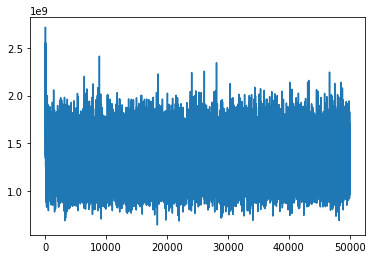

In [25]:
plt.plot(history.history['loss'])

In [26]:
res = model.predict([m1,m2,a],batch_size=n_dias)

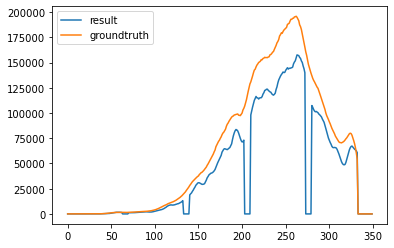

In [27]:
plt.plot(res,label='result')
plt.plot(b,label='groundtruth')
plt.legend()